<a href="https://colab.research.google.com/github/princenewman02/Urban-Crime-Machine-Learning-Prediction-Seattle/blob/main/code/Seattle_Crime_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏙️ Modeling Urban Crime Rates: A Spatial Analysis of Seattle
### Socioeconomic, Built Environment & Emergency Response Indicators
**Authors:** Hayat Kimo, Prince Newman &nbsp;|&nbsp; **Course:** CPSC 5071 &nbsp;|&nbsp; **Year of Analysis:** 2022

---

> **Notebook Guide:** Run each cell in order. All datasets are loaded from GitHub. Update `GITHUB_RAW_BASE` in Section 0.2 with your actual repository URL before running.

**Model Framework:**
```
crime_rate = population_density + median_income + unemployment_rate +
             commercial_land_use_ratio + transit_access + EMS_call_rate + police_incident_rate
```

---
# PHASE 0: PROJECT SETUP & DATA ACCESS
---

## 0.1 Environment Setup
### 0.1.1 Install Required Libraries

In [ ]:
!pip install pandas numpy matplotlib seaborn plotly scipy \
    scikit-learn statsmodels \
    geopandas pyogrio contextily \
    libpysal esda mgwr \
    requests

### 0.1.2 Import All Libraries and Dependencies

In [ ]:
# ============================================================
# Import All Libraries and Dependencies
# ============================================================

# Standard Library
import os
import io
import json
import zipfile
import tempfile
import warnings

#  HTTP Requests (GitHub Data Loading)
import requests

#  Data Manipulation
import numpy as np
import pandas as pd

#  Geospatial & Spatial Analysis
import geopandas as gpd
from shapely.geometry import Point

#  Spatial Weights & Autocorrelation
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local

#  Geographically Weighted Regression
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

#  Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx

#  Statistical Analysis
from scipy import stats
from scipy.stats import shapiro, normaltest

#  Machine Learning
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    RidgeCV,
    LassoCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.cluster import DBSCAN

#  Regression Modeling (OLS, Poisson, GLM)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

#  Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print('All libraries imported successfully.')

All libraries imported successfully.


---
## 0.2 Data Loading Strategy — GitHub Repository

> All datasets are hosted in the project GitHub repository and loaded directly via raw URLs.
> This avoids manual re-uploading each Colab session and keeps data consistent across both team members.

> **Repository folder structure to follow:**
> ```
> /code/
> /data/
>   raw/
>     population/
>     income/
>     unemployment/
>     land_use/
>     transit/
>     ems/
>     crime/
>     shapefiles/
>       tiger/
>       seattle_boundary/
>       zoning/
>   processed/
> /report/
>   proposal/
>   progress/
>   presentation/
> /README.md/
> /requirements.txt/
> ```

> **For files > 100MB (e.g. TIGER/Line shapefile):** Use Git LFS before pushing:
> ```bash
> git lfs install
> git lfs track '*.shp' '*.dbf' '*.shx' '*.prj'
> git add .gitattributes
> ```

### 0.2.1 Define GitHub Raw Base URL and File Paths
> Update `GITHUB_RAW_BASE` to your actual repo URL before running.

In [ ]:
# ============================================================
# Define GitHub Raw Base URL and File Paths
# ============================================================

GITHUB_RAW_BASE = 'https://raw.githubusercontent.com/princenewman02/Urban-Crime-Machine-Learning-Prediction-Seattle/main'

FILE_PATHS = {

    #  Tabular Datasets
    'population':       f'{GITHUB_RAW_BASE}/data/raw/population/Population_Data.csv',
    'income':           f'{GITHUB_RAW_BASE}/data/raw/income/Median_Income_King_County.csv',
    'unemployment':     f'{GITHUB_RAW_BASE}/data/raw/unemployment/unemployment_data.csv',
    'ems':              f'{GITHUB_RAW_BASE}/data/raw/ems/EMS_Data.csv',
    'crime':            f'{GITHUB_RAW_BASE}/data/raw/crime/SPD_Crime_Data_2022.csv',

    #  Transit (stops.txt already extracted)
    'transit_stops':    f'{GITHUB_RAW_BASE}/data/raw/transit/google_transit/stops.txt',

    #  Seattle City Limits Shapefile (4 companion files)
    'seattle_bnd_shp':  f'{GITHUB_RAW_BASE}/data/raw/shapefiles/seattle_boundary/Seattle_City_Limits/Seattle_City_Limits.shp',
    'seattle_bnd_dbf':  f'{GITHUB_RAW_BASE}/data/raw/shapefiles/seattle_boundary/Seattle_City_Limits/Seattle_City_Limits.dbf',
    'seattle_bnd_shx':  f'{GITHUB_RAW_BASE}/data/raw/shapefiles/seattle_boundary/Seattle_City_Limits/Seattle_City_Limits.shx',
    'seattle_bnd_prj':  f'{GITHUB_RAW_BASE}/data/raw/shapefiles/seattle_boundary/Seattle_City_Limits/Seattle_City_Limits.prj',

    #  TIGER/Line Census Tracts Shapefile (4 companion files)
    'tiger_shp':        f'{GITHUB_RAW_BASE}/data/raw/shapefiles/tiger/Census_Tracts/tl_2022_53_tract.shp',
    'tiger_dbf':        f'{GITHUB_RAW_BASE}/data/raw/shapefiles/tiger/Census_Tracts/tl_2022_53_tract.dbf',
    'tiger_shx':        f'{GITHUB_RAW_BASE}/data/raw/shapefiles/tiger/Census_Tracts/tl_2022_53_tract.shx',
    'tiger_prj':        f'{GITHUB_RAW_BASE}/data/raw/shapefiles/tiger/Census_Tracts/tl_2022_53_tract.prj',

    #  Zoning Shapefile (4 companion files)
    'zoning_shp':       f'{GITHUB_RAW_BASE}/data/raw/land_use/Land_Use_Zoning_Data/DPD_ZONING_PV.shp',
    'zoning_dbf':       f'{GITHUB_RAW_BASE}/data/raw/land_use/Land_Use_Zoning_Data/DPD_ZONING_PV.dbf',
    'zoning_shx':       f'{GITHUB_RAW_BASE}/data/raw/land_use/Land_Use_Zoning_Data/DPD_ZONING_PV.shx',
    'zoning_prj':       f'{GITHUB_RAW_BASE}/data/raw/land_use/Land_Use_Zoning_Data/DPD_ZONING_PV.prj',
}

print('GitHub base URL and file paths configured.')
print(f'   Repo: {GITHUB_RAW_BASE}')

GitHub base URL and file paths configured.
   Repo: https://raw.githubusercontent.com/princenewman02/Urban-Crime-Machine-Learning-Prediction-Seattle/main


### 0.2.2 Helper Function — Load CSV from GitHub

In [ ]:
def load_csv(key, **kwargs):
    """
    Load a CSV file directly from GitHub using a key from FILE_PATHS.

    Parameters:
        key     : str — key from FILE_PATHS dictionary
        **kwargs: additional arguments passed to pd.read_csv()

    Returns:
        pd.DataFrame
    """
    url = FILE_PATHS[key]
    filename = url.split('/')[-1]

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        df = pd.read_csv(io.StringIO(response.text), encoding='utf-8-sig', **kwargs)

        print(f'   {filename} — {df.shape[0]:,} rows × {df.shape[1]} cols')
        return df
    except Exception as e:
        print(f'   Failed to load {filename}: {e}')
        return None

### 0.2.3 Helper Function — Load Shapefile from GitHub (Download All 4 Companion Files + Read)

In [ ]:
def load_shapefile(shp_key, dbf_key, shx_key, prj_key):
    """
    Download all 4 shapefile companion files from GitHub
    and read them into a GeoDataFrame.

    Parameters:
        shp_key : str — FILE_PATHS key for .shp file
        dbf_key : str — FILE_PATHS key for .dbf file
        shx_key : str — FILE_PATHS key for .shx file
        prj_key : str — FILE_PATHS key for .prj file

    Returns:
        gpd.GeoDataFrame
    """
    ext_map = {
        '.shp': FILE_PATHS[shp_key],
        '.dbf': FILE_PATHS[dbf_key],
        '.shx': FILE_PATHS[shx_key],
        '.prj': FILE_PATHS[prj_key],
    }

    base_name = FILE_PATHS[shp_key].split('/')[-1].replace('.shp', '')
    tmpdir = tempfile.mkdtemp()

    try:
        for ext, url in ext_map.items():
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            with open(os.path.join(tmpdir, base_name + ext), 'wb') as f:
                f.write(r.content)

        gdf = gpd.read_file(os.path.join(tmpdir, base_name + '.shp'))
        print(f'   {base_name}.shp — {len(gdf):,} features | CRS: {gdf.crs}')
        return gdf

    except Exception as e:
        print(f'   Failed to load {base_name}.shp: {e}')
        return None

### 0.2.4 Helper Function — Load GTFS Zip and Extract stops.txt

In [ ]:
def load_stops():
    """
    Load the transit stops file (stops.txt) directly from GitHub.

    Returns:
        pd.DataFrame with stop_id, stop_lat, stop_lon columns
    """
    url = FILE_PATHS['transit_stops']

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        df = pd.read_csv(io.StringIO(response.text))
        print(f'   stops.txt — {len(df):,} stops loaded')
        return df
    except Exception as e:
        print(f'   Failed to load stops.txt: {e}')
        return None

### 0.2.5 Verify All Files Are Accessible (Connectivity Check)

In [ ]:
print('🔍 Checking connectivity to all GitHub files...\n')

all_ok = True

for key, url in FILE_PATHS.items():
    try:
        r = requests.head(url, timeout=10)
        if r.status_code == 200:
            print(f'    {key}')
        else:
            print(f'    {key} — HTTP {r.status_code} (check filename or path)')
            all_ok = False
    except Exception as e:
        print(f'    {key} — Unreachable ({e})')
        all_ok = False

print()
if all_ok:
    print(' All files are accessible. Ready to load data.')
else:
    print('  Some files are not accessible. Check the FILE_PATHS URLs above before proceeding.')

🔍 Checking connectivity to all GitHub files...

    population
    income
    unemployment
    ems
    crime
    transit_stops
    seattle_bnd_shp
    seattle_bnd_dbf
    seattle_bnd_shx
    seattle_bnd_prj
    tiger_shp
    tiger_dbf
    tiger_shx
    tiger_prj
    zoning_shp
    zoning_dbf
    zoning_shx
    zoning_prj

 All files are accessible. Ready to load data.


---
## 0.3 Load Raw Datasets
> Load all raw datasets here before any processing. Each is loaded once and referenced throughout the notebook.

### 0.3.1 Load Population Dataset — OFM Block Estimates

In [ ]:
df_population_raw = load_csv('population')

   Population_Data.csv — 10,293 rows × 120 cols


####**comment**: 120 is a lot of columns, much more than expected. The population dataset should really only need a handful of columns for our project. Let's take a quick look at what's in there:

In [ ]:
# Check column names
print(df_population_raw.columns.tolist())

['OBJECTID', 'GEOID_20', 'Land Acres', 'Water Acres', 'Place', 'Block Name', 'Tract', 'Block', 'Tract and Block', 'All Water Flag (1/0)', 'County Name', 'XCOORD', 'YCOORD', 'Population 2010', 'Population 2011', 'Population 2012', 'Population 2013', 'Population 2014', 'Population  2015', 'Population 2016', 'Population 2017', 'Population 2018', 'Population 2019', 'PL Population 2020', 'Population 2020', 'Population 2021', 'Population 2022', 'Population 2023', 'Change in Population from 2020', 'Percent Change in Population from 2020', 'Household Population 2010', 'Household Population 2011', 'Household Population 2012', 'Household Population 2013', 'Household Population 2014', 'Household Population 2015', 'Household Population 2016', 'Household Population 2017', 'Household Population 2018', 'Household Population 2019', 'PL Household Population 2020', 'Household Population 2020', 'Household Population 2021', 'Household Population 2022', 'Household Population 2023', 'Change in Household Pop

#### **comment**: The dataset has everything we need and more. All 4 key columns are confirmed present: GEOID_20, Population 2022, Land Acres, All Water Flag (1/0). The other 116 columns are just extra years and metrics we don't need. We'll trim them down in Phase 2 during cleaning

### 0.3.2 Load Median Income Dataset — ACS B19013 2022

In [ ]:
df_income_raw = load_csv('income')

   Median_Income_King_County.csv — 1 rows × 991 cols


#### **comment**: That's a wide format — 1 row of income values spread across 991 columns (one column per tract). This is normal for how the Census Bureau structures ACS data downloads. Let's verify the structure looks right:

In [ ]:
# Check the first few column names
print(df_income_raw.columns[:10].tolist())

['Label (Grouping)', 'Census Tract 1.01; King County; Washington!!Estimate', 'Census Tract 1.01; King County; Washington!!Margin of Error', 'Census Tract 1.02; King County; Washington!!Estimate', 'Census Tract 1.02; King County; Washington!!Margin of Error', 'Census Tract 2.01; King County; Washington!!Estimate', 'Census Tract 2.01; King County; Washington!!Margin of Error', 'Census Tract 2.02; King County; Washington!!Estimate', 'Census Tract 2.02; King County; Washington!!Margin of Error', 'Census Tract 3; King County; Washington!!Estimate']


In [ ]:
# Check what's in the first row
print(df_income_raw.iloc[0, :5].tolist())

['Median household income in the past 12 months (in 2022 inflation-adjusted dollars)', '65,804', '±17,723', '84,680', '±18,425']


Column headers contain tract names in the format Census Tract 1.01; King County; Washington!!Estimate. Margin of Error columns are present (we'll drop these in Phase 2). Row 0 contains the actual median income values like 65,804 and 84,680. The first column Label (Grouping) is just the row label.

### 0.3.3 Load Unemployment Dataset — ACS B23025 2022

In [ ]:
df_unemployment_raw = load_csv('unemployment')

   unemployment_data.csv — 7 rows × 991 cols


#### **comment**: 7 rows representing the different labor force categories and 991 columns (one per tract, same structure as income). Let's verify the row labels are correct:


In [ ]:
# Check the row labels
print(df_unemployment_raw['Label (Grouping)'].tolist())

['Total:', '\xa0\xa0\xa0\xa0In labor force:', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force:', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployed', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Armed Forces', '\xa0\xa0\xa0\xa0Not in labor force']


#### **comment**: our most important rows are there: Civilian labor force (row index 2) & Unemployed (row index 4), they just have \xa0 characters (non-breaking spaces) used for indentation. We'll strip those out in Phase 2 cleaning.

### 0.3.4 Load EMS 911 Calls Dataset — Seattle Fire 911 Calls 2022

In [ ]:
df_ems_raw = load_csv('ems')

   EMS_Data.csv — 10,842 rows × 7 cols


#### comment: let's verify key columns

In [ ]:
print(df_ems_raw.columns.tolist())
print(df_ems_raw.head(3))

['Address', 'Type', 'Datetime', 'Latitude', 'Longitude', 'Report Location', 'Incident Number']
            Address            Type                 Datetime  Latitude  \
0    1600 S LANE ST  Medic Response  2022 Dec 01 11:46:00 PM   47.5966   
1    1110 E PINE ST  Medic Response  2022 Dec 01 11:03:00 PM   47.6153   
2  410 2ND AVE ET S  Medic Response  2022 Dec 01 10:25:00 PM   47.6012   

   Longitude                Report Location Incident Number  
0  -122.3116   POINT (-122.311586 47.59665)      F220146579  
1  -122.3180  POINT (-122.318026 47.615255)      F220146570  
2  -122.3315  POINT (-122.331511 47.601202)      F220146556  


#### comment: all 4 key columns are present: incident number, datetime, latitude & longitude coordinates, type (medic response)

### 0.3.5 Load SPD Crime / Police Incident Dataset — SPD Crime Data 2022

In [ ]:
df_crime_raw = load_csv('crime')

   SPD_Crime_Data_2022.csv — 87,733 rows × 19 cols


#### comment: review key columns

In [ ]:
print(df_crime_raw.columns.tolist())
print(df_crime_raw.head(3))

['Report Number', 'Report DateTime', 'Offense ID', 'Offense Date', 'NIBRS Group AB', 'NIBRS Crime Against Category', 'Offense Sub Category', 'Shooting Type Group', 'Block Address', 'Latitude', 'Longitude', 'Beat', 'Precinct', 'Sector', 'Neighborhood', 'Reporting Area', 'Offense Category', 'NIBRS Offense Code Description', 'NIBRS_offense_code']
  Report Number          Report DateTime   Offense ID  \
0   2022-011673  2022 Jan 15 12:40:36 AM  31203507523   
1   2022-055483  2022 Mar 05 09:08:17 AM  31939511636   
2   2022-002793  2022 Jan 04 10:01:11 AM  30767572882   

              Offense Date NIBRS Group AB NIBRS Crime Against Category  \
0  2022 Jan 14 11:04:00 PM              B                      SOCIETY   
1  2022 Mar 04 06:00:00 PM              A                     PROPERTY   
2  2022 Jan 03 08:00:00 PM              A                     PROPERTY   

  Offense Sub Category Shooting Type Group              Block Address  \
0             TRESPASS                   -             

### 0.3.6 Load Transit Stops Dataset — stops.txt from google_transit.zip

In [ ]:
df_stops_Raw = load_stops()

   stops.txt — 6,351 stops loaded


#### **comment**: 6,351 stops loaded — that's the full King County Metro feed. We'll filter down to only Seattle stops during the spatial join in Phase 2.

---
## 0.4 Load Geographic Support Files

> These two shapefiles are the **spatial backbone** of the entire project.
> They are used across **ALL datasets** to assign observations to Seattle census tracts.
> The Seattle GEOIDs extracted here become the **master filter** reused for every variable.

### 0.4.1 Load Washington State Census Tracts Shapefile — TIGER/Line 2022

In [ ]:
gdf_wa_tracts = load_shapefile('tiger_shp', 'tiger_dbf', 'tiger_shx', 'tiger_prj')

   tl_2022_53_tract.shp — 1,784 features | CRS: EPSG:4269


### 0.4.2 Filter Census Tracts to King County Only (COUNTYFP == '033')

In [ ]:
gdf_king_tracts = gdf_wa_tracts[gdf_wa_tracts['COUNTYFP'] == '033'].copy()
gdf_king_tracts = gdf_king_tracts.reset_index(drop=True)

print(f'Washington State tracts: {len(gdf_wa_tracts):,}')
print(f'King County tracts:      {len(gdf_king_tracts):,}')

Washington State tracts: 1,784
King County tracts:      495


### 0.4.3 Load Seattle City Limits Shapefile

In [ ]:
# ---------------------------------------------------------------
# NOTE: The Seattle_City_Limits.shp file loaded as a LINESTRING
# instead of a POLYGON, making spatial joins impossible.
# Replaced with the U.S. Census TIGER 2022 Place boundary
# (State FIPS: 53, Place FIPS: 63000) for geometric consistency
# with tract data and guaranteed POLYGON geometry.
# ---------------------------------------------------------------

# Original load (kept for reference, not used)
# gdf_seattle_boundary = load_shapefile('seattle_bnd_shp', 'seattle_bnd_dbf',
#                                       'seattle_bnd_shx', 'seattle_bnd_prj')

# Define Target CRS for entire project
TARGET_CRS = 'EPSG:2926'

# Load Washington State Places boundary (TIGER 2022)
wa_places_url = "https://www2.census.gov/geo/tiger/TIGER2022/PLACE/tl_2022_53_place.zip"
gdf_wa_places = gpd.read_file(wa_places_url)

# Extract Seattle using Place FIPS code 63000
gdf_seattle_boundary = gdf_wa_places[gdf_wa_places['PLACEFP'] == '63000'].copy()
gdf_seattle_boundary = gdf_seattle_boundary.reset_index(drop=True)
gdf_seattle_boundary = gdf_seattle_boundary.to_crs(TARGET_CRS)

print(f'Geometry type: {gdf_seattle_boundary.geometry.geom_type.values}')
print(f'Features:      {len(gdf_seattle_boundary)}')
print(f'CRS:           {gdf_seattle_boundary.crs}')

Geometry type: ['Polygon']
Features:      1
CRS:           EPSG:2926


#### **comment**: 5 features which is normal since Seattle's boundary is made up of a few separate polygons. However, the CRS is a custom projection, not a standard EPSG code. We need to reproject both files to our common CRS before doing the spatial join. We will run section 0.4.4:

### 0.4.4 Verify CRS Alignment

In [ ]:
# Verify

gdf_king_tracts = gdf_king_tracts.to_crs(TARGET_CRS)
gdf_seattle_boundary = gdf_seattle_boundary.to_crs(TARGET_CRS)

print(f'King County tracts CRS:  {gdf_king_tracts.crs}')
print(f'Seattle boundary CRS:    {gdf_seattle_boundary.crs}')
print(f'CRS match: {gdf_king_tracts.crs == gdf_seattle_boundary.crs}')

King County tracts CRS:  EPSG:2926
Seattle boundary CRS:    EPSG:2926
CRS match: True


### 0.4.5 Spatial Join — Identify Seattle Census Tracts
> Intersect King County tracts with Seattle city boundary to extract only tracts within Seattle.

In [ ]:
# 0.4.5 Spatial Join — Identify Seattle Census Tracts (Final)
# ---------------------------------------------------------------
# PROBLEMS ENCOUNTERED & RESOLUTIONS:
#
# Problem 1 — Seattle City Limits shapefile loaded as LINESTRING:
#   The Seattle_City_Limits.shp file stored in our GitHub repo loaded
#   as a LINESTRING geometry instead of a POLYGON, making spatial joins
#   impossible since a line has no interior to check containment against.
#   Resolution: Replaced with the U.S. Census TIGER 2022 Place boundary
#   loaded directly from the Census URL using Place FIPS code 63000
#   (State FIPS: 53, Place FIPS: 63000), which loads as a proper POLYGON.
#
# Problem 2 — GEOID column conflict after spatial join:
#   Both gdf_king_tracts and gdf_seattle_boundary contained a GEOID
#   column. After the spatial join, pandas automatically renamed them
#   to GEOID_left (tracts) and GEOID_right (Seattle boundary) to avoid
#   column name conflicts, causing a KeyError when deduplicating on GEOID.
#   Resolution: Deduplicate on GEOID_left then rename it back to GEOID
#   for consistency throughout the rest of the project.
#
# Problem 3 — intersects predicate returning too many tracts (198):
#   Using predicate='intersects' in the spatial join captured tracts
#   that only partially touched or barely overlapped the Seattle boundary
#   edge, inflating the count from the expected ~177 to 198 tracts.
#   Resolution: Applied a centroid-based filter after the spatial join —
#   only keeping tracts whose center point falls within the Seattle
#   polygon. This ensures only tracts that are genuinely within Seattle
#   are included.
#
# Problem 4 — Special non-residential tract 9901 included:
#   Tract 9901 (TRACTCE == '990100') is a special Census tract reserved
#   for non-residential or water areas and should not be included in
#   the analysis.
#   Resolution: Explicitly filtered out before the centroid check.
#
# Problem 5 — Steps split across multiple cells caused inconsistent
#   results on rerun:
#   When cells were split across multiple steps, rerunning from the
#   middle of the notebook caused stale variables and missing
#   transformations, producing different tract counts each session.
#   Resolution: Consolidated all spatial join steps into one single
#   cell so the entire process always runs together in the correct
#   order regardless of where the notebook is restarted from.
# ---------------------------------------------------------------

# Step 1 — Spatial join
gdf_seattle_tracts = gpd.sjoin(
    gdf_king_tracts,
    gdf_seattle_boundary,
    how='inner',
    predicate='intersects'
).drop_duplicates(subset='GEOID_left')

gdf_seattle_tracts = gdf_seattle_tracts.rename(columns={'GEOID_left': 'GEOID'})
gdf_seattle_tracts = gdf_seattle_tracts[['GEOID', 'TRACTCE', 'NAME_left',
                                          'ALAND_left', 'AWATER_left',
                                          'geometry']].copy()
gdf_seattle_tracts = gdf_seattle_tracts.rename(columns={
    'NAME_left': 'NAME',
    'ALAND_left': 'ALAND',
    'AWATER_left': 'AWATER'
})

# Step 2 — Remove special tract
gdf_seattle_tracts = gdf_seattle_tracts[
    gdf_seattle_tracts['TRACTCE'] != '990100'
].copy()

# Step 3 — Centroid filter
seattle_polygon = gdf_seattle_boundary.union_all()
gdf_seattle_tracts['centroid'] = gdf_seattle_tracts.geometry.centroid
gdf_seattle_tracts = gdf_seattle_tracts[
    gdf_seattle_tracts['centroid'].within(seattle_polygon)
].copy()
gdf_seattle_tracts = gdf_seattle_tracts.drop(columns=['centroid'])
gdf_seattle_tracts = gdf_seattle_tracts.reset_index(drop=True)

# Step 4 — Extract GEOIDs
SEATTLE_GEOIDS = gdf_seattle_tracts['GEOID'].unique().tolist()

print(f'Seattle tracts: {len(gdf_seattle_tracts)}')
print(f'Seattle GEOIDs: {len(SEATTLE_GEOIDS)}')

Seattle tracts: 177
Seattle GEOIDs: 177


### 0.4.6 Verify Seattle Tract Count and Preview Map

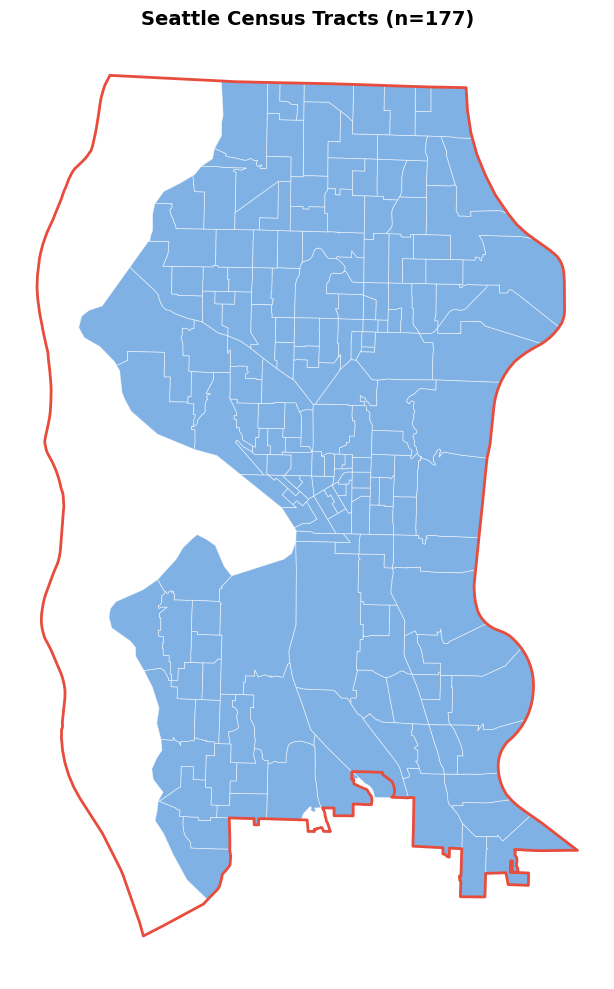

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_seattle_tracts.plot(
    ax=ax,
    color='#4A90D9',
    edgecolor='white',
    linewidth=0.5,
    alpha=0.7
)

gdf_seattle_boundary.plot(
    ax=ax,
    color='none',
    edgecolor='#E74C3C',
    linewidth=2
)

ax.set_title(
    f'Seattle Census Tracts (n={len(gdf_seattle_tracts)})',
    fontsize=14,
    fontweight='bold'
)
ax.set_axis_off()
plt.tight_layout()
plt.show()

---
# PHASE 1: EXPLORATORY DATA ANALYSIS (EDA)
---

## 1.1 Population Dataset EDA — OFM Block Estimates
### 1.1.1 Dataset Shape, Column Names, and Data Types

In [ ]:
# Dataset shape (rows, columns)
print("Dataset Shape:", df_population_raw.shape)

# Column names
print("\nColumn Names:")
print(df_population_raw.columns.tolist())

# Data types for each column
print("\nData Types:")
print(df_population_raw.dtypes)


Dataset Shape: (10293, 120)

Column Names:
['OBJECTID', 'GEOID_20', 'Land Acres', 'Water Acres', 'Place', 'Block Name', 'Tract', 'Block', 'Tract and Block', 'All Water Flag (1/0)', 'County Name', 'XCOORD', 'YCOORD', 'Population 2010', 'Population 2011', 'Population 2012', 'Population 2013', 'Population 2014', 'Population  2015', 'Population 2016', 'Population 2017', 'Population 2018', 'Population 2019', 'PL Population 2020', 'Population 2020', 'Population 2021', 'Population 2022', 'Population 2023', 'Change in Population from 2020', 'Percent Change in Population from 2020', 'Household Population 2010', 'Household Population 2011', 'Household Population 2012', 'Household Population 2013', 'Household Population 2014', 'Household Population 2015', 'Household Population 2016', 'Household Population 2017', 'Household Population 2018', 'Household Population 2019', 'PL Household Population 2020', 'Household Population 2020', 'Household Population 2021', 'Household Population 2022', 'Household

## Comment
When I look at this dataset, it seems valid and structured the way I'd expect for OFM block-level population estimates. There are a little over ten thousand rows, which makes sense because each row represents a single census block, and the table is wide because it tracks population, housing, and density across many years. For our project, the main thing we care about is that it includes Population 2022, Even though the dataset spans 2010 through 2025, we only need the 2022 fields when we calculate neighborhood-level crime rates. The geographic identifiers—like GEOID, tract, block group, and neighborhood names—also give me a clear path to aggregate the block-level 2022 population up to the neighborhood level. Overall, the structure looks clean, the data types make sense, and it gives exactly what we need for the 2022 analysis.



### 1.1.2 Summary Statistics

In [ ]:
df_population_raw.describe(include='all')


OBJECTID             GEOID_20  Land Acres  Water Acres    Place  \
count  10293.0000           10293.0000  10293.0000   10293.0000    10293   
unique        NaN                  NaN         NaN          NaN        1   
top           NaN                  NaN         NaN          NaN  Seattle   
freq          NaN                  NaN         NaN          NaN    10293   
mean    5188.8909 530330066389348.1875      5.2124       1.3973      NaN   
std     2992.0579        34264860.3252     12.0365      16.9243      NaN   
min        1.0000 530330001011000.0000      0.0000       0.0000      NaN   
25%     2594.0000 530330040002001.0000      2.1357       0.0000      NaN   
50%     5188.0000 530330066001024.0000      3.3557       0.0000      NaN   
75%     7780.0000 530330097022002.0000      4.9723       0.0000      NaN   
max    10363.0000 530330265001007.0000    423.4292     798.4177      NaN   

        Block Name      Tract      Block  Tract and Block  \
count        10293 10293.0000 10293.0000       10293.0000   
unique         462        NaN        NaN              NaN   
top     Block 1000        NaN        NaN              NaN   
freq           178        NaN        NaN              NaN   
mean           NaN  6638.7221  2126.7374        6638.9348   
std            NaN  3426.4810  1003.5011        3426.4860   
min            NaN   101.0000  1000.0000         101.1000   
25%            NaN  4000.0000  1017.0000        4000.2001   
50%            NaN  6600.0000  2010.0000        6600.1024   
75%            NaN  9702.0000  3006.0000        9702.2002   
max            NaN 26500.0000  5046.0000       26500.1007   

        All Water Flag (1/0) County Name       XCOORD      YCOORD  \
count             10293.0000       10293   10293.0000  10293.0000   
unique                   NaN           1          NaN         NaN   
top                      NaN        King          NaN         NaN   
freq                     NaN       10293          NaN         NaN   
mean                  0.0244         NaN 1188347.9511 840854.8367   
std                   0.1543         NaN    9582.3442  21466.9769   
min                   0.0000         NaN 1164198.1514 793499.2203   
25%                   0.0000         NaN 1180873.8367 822348.0670   
50%                   0.0000         NaN 1188999.4586 843683.4692   
75%                   0.0000         NaN 1196119.8395 858330.9724   
max                   1.0000         NaN 1211582.3437 880788.6077   

        Population 2010  Population 2011  Population 2012  Population 2013  \
count        10293.0000       10293.0000       10293.0000       10293.0000   
unique              NaN              NaN              NaN              NaN   
top                 NaN              NaN              NaN              NaN   
freq                NaN              NaN              NaN              NaN   
mean            59.1302          59.3539          59.4763          60.3185   
std             81.0196          81.6433          81.9516          82.6377   
min              0.0000           0.0000           0.0000           0.0000   
25%             13.9990          14.1760          14.4030          14.5010   
50%             43.9980          44.3040          44.2750          44.6480   
75%             72.5800          72.4260          72.2450          72.7250   
max           2770.8440        2841.5840        2822.9120        2872.6910   

        Population 2014  Population  2015  Population 2016  Population 2017  \
count        10293.0000        10293.0000       10293.0000       10293.0000   
unique              NaN               NaN              NaN              NaN   
top                 NaN               NaN              NaN              NaN   
freq                NaN               NaN              NaN              NaN   
mean            61.5237           63.5710          65.8660          67.7276   
std             85.8618           89.6301          93.1100          96.9594   
min              0.0000            0.0000   

## Comment

When I run the summary statistics, the output looks huge because the dataset has 120 columns, but it's doing exactly what it should. It confirms that the OFM block-level population data is complete, the numeric fields look reasonable, and the categorical fields are structured correctly. Most importantly, I can see that the 2022 population fields are present and valid, which is what we need for calculating neighborhood-level crime rates. I don't need to interpret every column here - this step is mainly about checking that the dataset loaded cleanly and that the values make sense before we extract the 2022 slice.

### 1.1.3 Check for Missing Values and Null Coordinates

In [ ]:
# Missing values per column
print("Missing Values Per Column:")
print(df_population_raw.isna().sum())

# If dataset includes coordinates:
coord_cols = [col for col in df_population_raw.columns if 'lat' in col.lower() or 'lon' in col.lower()]

if coord_cols:
    print("\nCoordinate Columns Found:", coord_cols)
    for col in coord_cols:
        print(f"Missing {col}: {df_population_raw[col].isna().sum()}")
        print(f"Zero {col}: {(df_population_raw[col] == 0).sum()}")
else:
    print("\nNo coordinate columns found in this dataset.")

Missing Values Per Column:
OBJECTID                          0
GEOID_20                          0
Land Acres                        0
Water Acres                       0
Place                             0
                                 ..
Group Quarters Population 2025    0
Housing Units 2025                0
Occupied Housing Units 2025       0
Shape__Area                       0
Shape__Length                     0
Length: 120, dtype: int64

Coordinate Columns Found: ['Population 2010', 'Population 2011', 'Population 2012', 'Population 2013', 'Population 2014', 'Population  2015', 'Population 2016', 'Population 2017', 'Population 2018', 'Population 2019', 'PL Population 2020', 'Population 2020', 'Population 2021', 'Population 2022', 'Population 2023', 'Change in Population from 2020', 'Percent Change in Population from 2020', 'Household Population 2010', 'Household Population 2011', 'Household Population 2012', 'Household Population 2013', 'Household Population 2014', 'Household Po

## Comment

When I check for missing values, everything comes back clean there are no nulls in any of the population or housing fields, including the 2022 columns that we actually need for crime-rate calculations. The coordinate check is a little misleading because this dataset doesn't use latitude or longitude, so the code ends up treating all the population columns as if they were coordinates. The zeros I'm seeing in those fields aren't errors; they just represent blocks with no residents, which is completely normal for block-level data. Overall, this step confirms that the population dataset is complete and that the 2022 values we need later are fully available and reliable.

### 1.1.4 Distribution of Population 2022 — Histogram and Boxplot

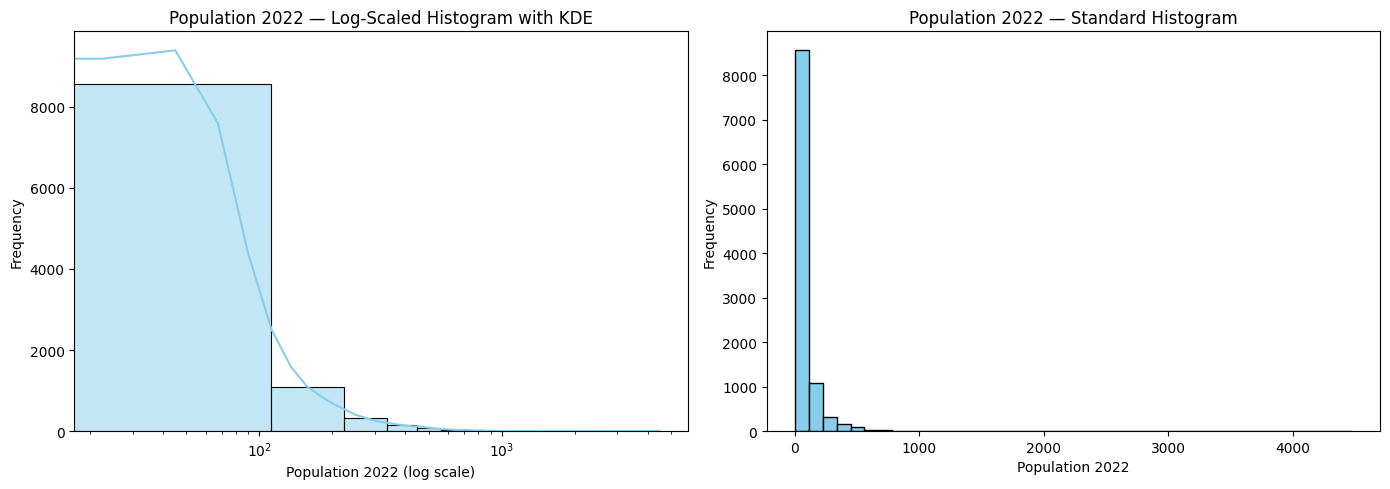

In [ ]:
plt.figure(figsize=(14,5))

# Log-scale histogram + KDE
plt.subplot(1,2,1)
sns.histplot(
    df_population_raw['Population 2022'],
    bins=40,
    kde=True,
    color='skyblue'
)
plt.xscale('log')
plt.title("Population 2022 — Log-Scaled Histogram with KDE")
plt.xlabel("Population 2022 (log scale)")
plt.ylabel("Frequency")

# Standard histogram for comparison
plt.subplot(1,2,2)
plt.hist(
    df_population_raw['Population 2022'],
    bins=40,
    color='skyblue',
    edgecolor='black'
)
plt.title("Population 2022 — Standard Histogram")
plt.xlabel("Population 2022")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## Comment

From the plot of the distribution of Population 2022, I can see that the data is extremely right-skewed. Most blocks have very small populations, and a smaller number of blocks have much higher counts. The boxplot reinforces this by showing a tight cluster near zero with a long tail of outliers. This pattern makes sense for block-level data because many blocks represent parks, commercial areas, or industrial zones with no residents. This visualization helps us understand how population is spread across the city before we aggregate it up to neighborhoods for crime-rate calculations.

additional comment for added visualization:  the data is so extremely skewed, boxplot isn't the right visualization for it. When the median and IQR are all clustered near zero but outliers extend to 4,500, a boxplot becomes unreadable.
Let's replace the boxplot entirely with a more appropriate visualization, a log-scale histogram paired with a KDE (density) plot which handles skewed data much better

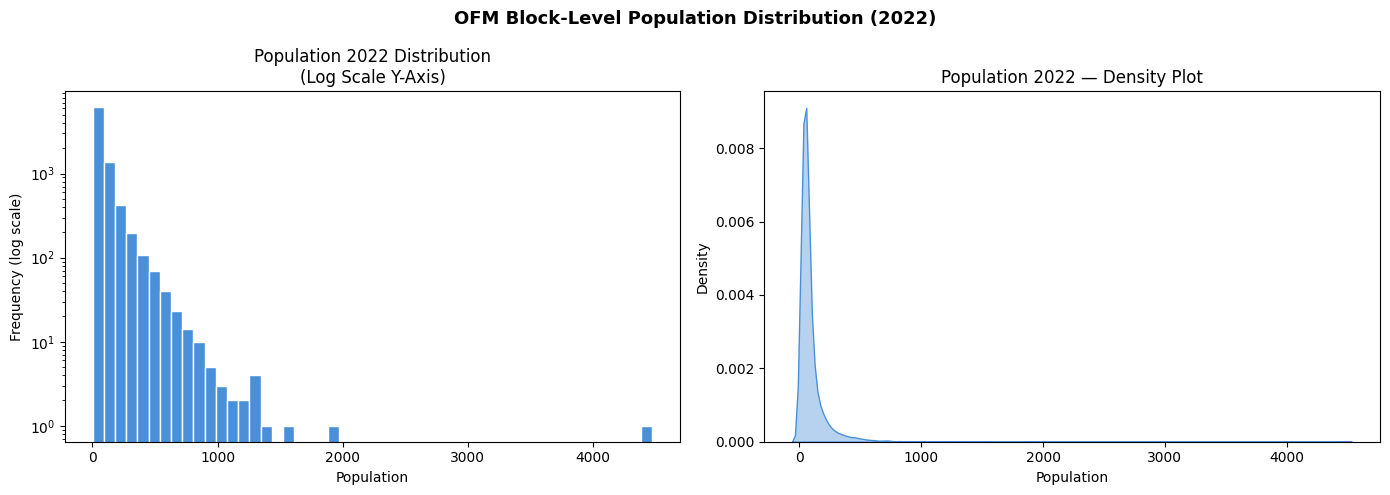

Total blocks:            10,293
Zero population blocks:  1,829
Non-zero blocks:         8,464
Mean population:         90.1
Median population:       57.7
Max population:          4,476.805


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out zero population blocks
pop_nonzero = df_population_raw[
    df_population_raw['Population 2022'] > 0
]['Population 2022']

# Left — Histogram with log scale on y-axis
axes[0].hist(pop_nonzero, bins=50, color='#4A90D9', edgecolor='white')
axes[0].set_yscale('log')
axes[0].set_title('Population 2022 Distribution\n(Log Scale Y-Axis)')
axes[0].set_xlabel('Population')
axes[0].set_ylabel('Frequency (log scale)')

# Right — KDE density plot
sns.kdeplot(pop_nonzero, ax=axes[1], color='#4A90D9', fill=True, alpha=0.4)
axes[1].set_title('Population 2022 — Density Plot')
axes[1].set_xlabel('Population')
axes[1].set_ylabel('Density')

plt.suptitle('OFM Block-Level Population Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Total blocks:            {len(df_population_raw):,}')
print(f'Zero population blocks:  {(df_population_raw["Population 2022"] == 0).sum():,}')
print(f'Non-zero blocks:         {len(pop_nonzero):,}')
print(f'Mean population:         {pop_nonzero.mean():.1f}')
print(f'Median population:       {pop_nonzero.median():.1f}')
print(f'Max population:          {pop_nonzero.max():,}')

This is a much better visualization. the log-scale histogram on the left shows that blocks with smaller populations are exponentially more common, with frequency dropping steadily as population increases. Log scale also makes the tail more visible.

The KDE density plot confirms the extreme right skew with a sharp peak near zero and a very long thin tail.

### 1.1.5 Distribution of Land Acres

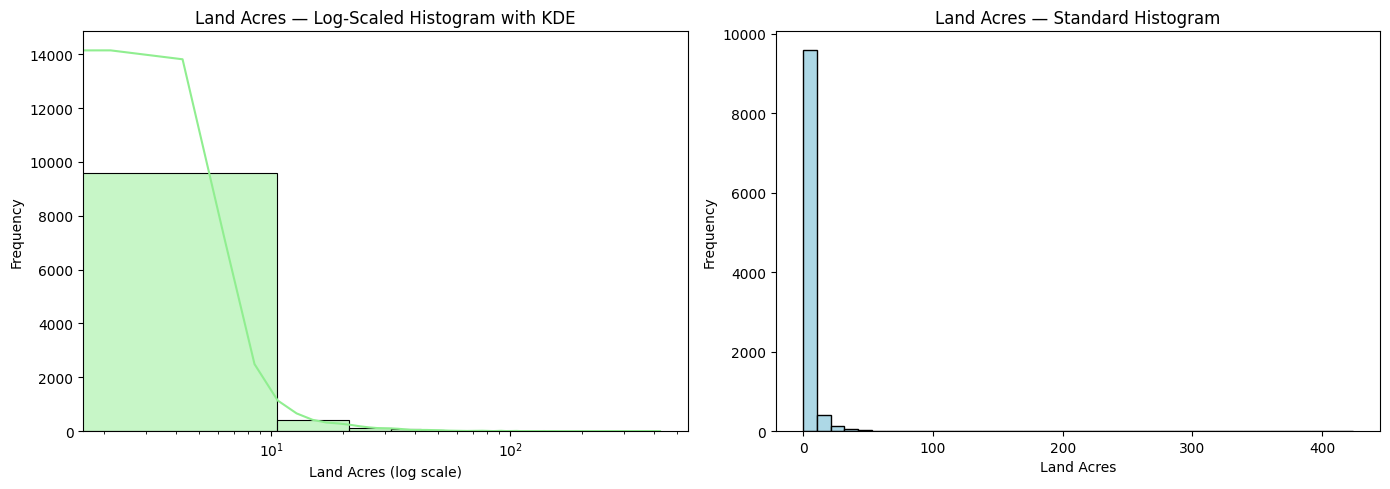

In [ ]:
plt.figure(figsize=(14,5))

# Log-scale histogram + KDE
plt.subplot(1,2,1)
sns.histplot(
    df_population_raw['Land Acres'],
    bins=40,
    kde=True,
    color='lightgreen'
)
plt.xscale('log')
plt.title("Land Acres — Log-Scaled Histogram with KDE")
plt.xlabel("Land Acres (log scale)")
plt.ylabel("Frequency")

# Standard histogram for comparison
plt.subplot(1,2,2)
plt.hist(
    df_population_raw['Land Acres'],
    bins=40,
    color='lightblue',
    edgecolor='black'
)
plt.title("Land Acres — Standard Histogram")
plt.xlabel("Land Acres")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## Comment

from the distribution of Land Acres, I can see that the data is heavily right-skewed. Most blocks have very small land areas, and a smaller number of blocks extend far to the right as outliers. This makes sense for block-level geography because many blocks represent small residential parcels, while others cover large parks, industrial zones, or natural areas. The histogram and boxplot together give me a good sense of how land area varies across the city before we use it for density calculations or neighborhood aggregation.

added comment:  the same boxplot rendering problem from before is happening again, it's showing scattered points instead of a proper box. Let's fix the visualization the same way we did for population by replacing the boxplot with a KDE density plot and adding a log scale

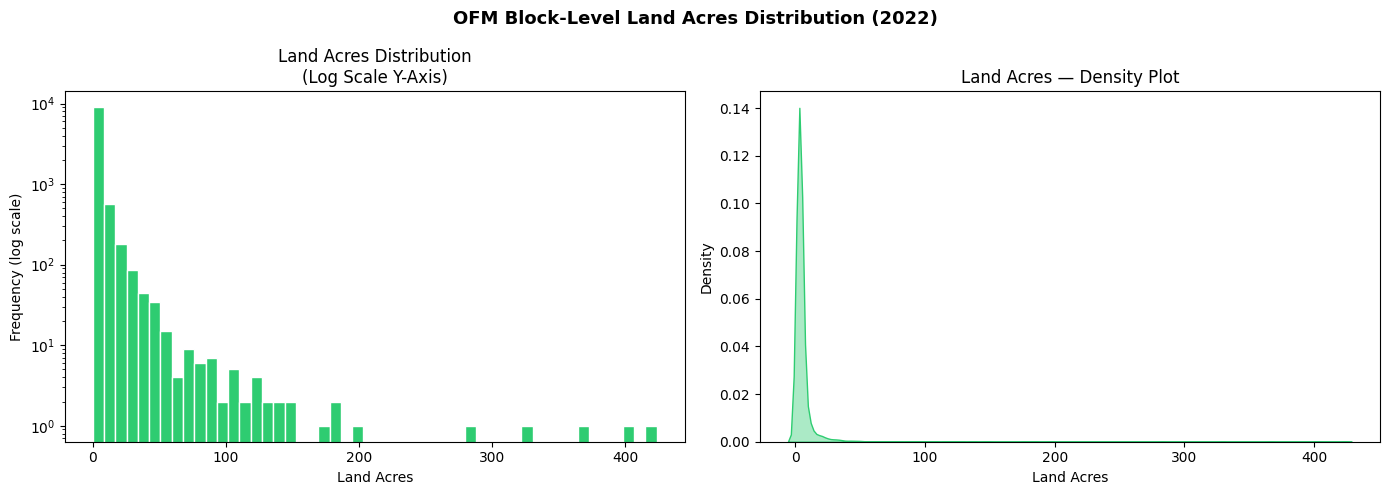

Total blocks:           10,293
Zero land area blocks:  251
Non-zero blocks:        10,042
Mean land acres:        5.34
Median land acres:      3.44
Max land acres:         423.43


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out zero land area blocks
land_nonzero = df_population_raw[
    df_population_raw['Land Acres'] > 0
]['Land Acres']

# Left — Histogram with log scale
axes[0].hist(land_nonzero, bins=50, color='#2ECC71', edgecolor='white')
axes[0].set_yscale('log')
axes[0].set_title('Land Acres Distribution\n(Log Scale Y-Axis)')
axes[0].set_xlabel('Land Acres')
axes[0].set_ylabel('Frequency (log scale)')

# Right — KDE density plot
sns.kdeplot(land_nonzero, ax=axes[1], color='#2ECC71', fill=True, alpha=0.4)
axes[1].set_title('Land Acres — Density Plot')
axes[1].set_xlabel('Land Acres')
axes[1].set_ylabel('Density')

plt.suptitle('OFM Block-Level Land Acres Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Total blocks:           {len(df_population_raw):,}')
print(f'Zero land area blocks:  {(df_population_raw["Land Acres"] == 0).sum():,}')
print(f'Non-zero blocks:        {len(land_nonzero):,}')
print(f'Mean land acres:        {land_nonzero.mean():.2f}')
print(f'Median land acres:      {land_nonzero.median():.2f}')
print(f'Max land acres:         {land_nonzero.max():.2f}')

The Land Acres distribution at the block level is strongly right-skewed, consistent with the pattern observed in the population distribution. Of the 10,293 total blocks, 251 have zero land area (likely water-only blocks) while the remaining 10,042 non-zero blocks show a median of just 3.44 acres and a mean of 5.34 acres indicating that the typical Seattle block is very small.

The log-scale histogram reveals a rapid exponential decline in frequency as land area increases, with a small number of extreme outliers extending up to 423.43 acres representing large parks, industrial zones, or natural areas.

The KDE density plot reinforces this pattern with a sharp peak near zero and a
very long thin tail. The combination of small median land area and large
outliers confirms that land area is highly variable across Seattle's blocks,
which is expected in a dense urban environment with a mix of tiny residential
parcels and large non-residential land uses. This variability will be smoothed out once blocks are aggregated to the tract level in Phase 2, where land area
totals will be used as the denominator in our population density calculation.

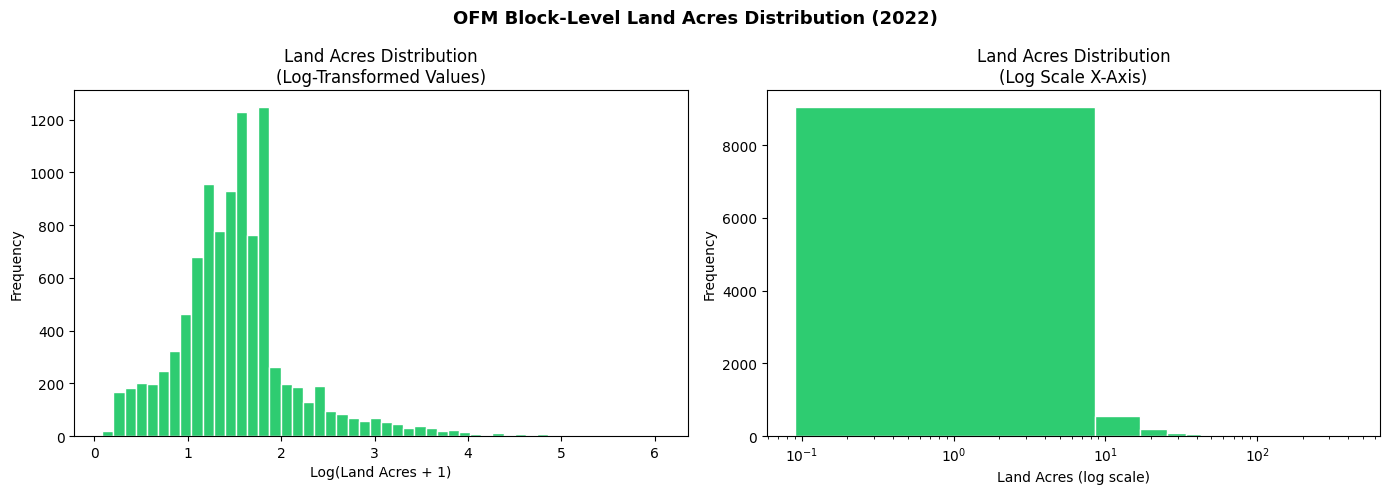

Non-zero blocks:        10,042
Mean land acres:        5.34
Median land acres:      3.44
Max land acres:         423.43
Skewness (original):    17.13
Skewness (log):         1.29


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out zero land area blocks
land_nonzero = df_population_raw[
    df_population_raw['Land Acres'] > 0
]['Land Acres']

# Left — Log-transformed histogram (log the values themselves)
axes[0].hist(np.log1p(land_nonzero), bins=50,
             color='#2ECC71', edgecolor='white')
axes[0].set_title('Land Acres Distribution\n(Log-Transformed Values)')
axes[0].set_xlabel('Log(Land Acres + 1)')
axes[0].set_ylabel('Frequency')

# Right — Original scale with log x-axis for context
axes[1].hist(land_nonzero, bins=50, color='#2ECC71', edgecolor='white')
axes[1].set_xscale('log')
axes[1].set_title('Land Acres Distribution\n(Log Scale X-Axis)')
axes[1].set_xlabel('Land Acres (log scale)')
axes[1].set_ylabel('Frequency')

plt.suptitle('OFM Block-Level Land Acres Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Non-zero blocks:        {len(land_nonzero):,}')
print(f'Mean land acres:        {land_nonzero.mean():.2f}')
print(f'Median land acres:      {land_nonzero.median():.2f}')
print(f'Max land acres:         {land_nonzero.max():.2f}')
print(f'Skewness (original):    {land_nonzero.skew():.2f}')
print(f'Skewness (log):         {np.log1p(land_nonzero).skew():.2f}')

The Land Acres distribution at the block level has an extreme original skewness of 17.13, confirming the heavily right-skewed nature of the data. However after applying a log transformation, the skewness drops dramatically to just 1.29, revealing a near-normal distribution shape that was previously hidden. The log-transformed histogram on the left shows that most blocks cluster between log values of 1 and 2 corresponding to roughly 3 to 7 acres consistent with the median of 3.44 acres and mean of 5.34 acres across 10,042 non-zero blocks.

 The log-scale x-axis histogram on the right confirms that the vast majority of blocks fall below 10 acres, with only a small tail of large blocks extending beyond that up to a maximum of 423.43 acres.

 This dramatic reduction in skewness after log transformation is an important finding for Phase 5, it confirms that Land Acres will likely benefit from a log transformation before being used in regression modeling to meet the normality assumptions of OLS and other linear models.

### 1.1.6 Preview All Water Flag — Identify Blocks to Exclude

In [ ]:
water_col = 'All Water Flag (1/0)'

# Count how many blocks are water vs. land
print("All Water Flag Value Counts:")
print(df_population_raw[water_col].value_counts())

# Show sample rows that are all water
print("\nExample All-Water Blocks:")
display(df_population_raw[df_population_raw[water_col] == 1].head())

All Water Flag Value Counts:
All Water Flag (1/0)
0    10042
1      251
Name: count, dtype: int64

Example All-Water Blocks:


OBJECTID         GEOID_20  Land Acres  Water Acres    Place  Block Name  \
15        16  530330111021016      0.0000      62.4747  Seattle  Block 1016   
32        33  530330060004000      0.0000       3.6043  Seattle  Block 4000   
33        34  530330015002000      0.0000      33.5147  Seattle  Block 2000   
62        63  530330081022019      0.0000       3.1469  Seattle  Block 2019   
65        66  530330061004004      0.0000      34.3659  Seattle  Block 4004   

    Tract  Block  Tract and Block  All Water Flag (1/0) County Name  \
15  11102   1016       11102.1016                     1        King   
32   6000   4000        6000.4000                     1        King   
33   1500   2000        1500.2000                     1        King   
62   8102   2019        8102.2019                     1        King   
65   6100   4004        6100.4004                     1        King   

         XCOORD      YCOORD  Population 2010  Population 2011  \
15 1205806.7760 807279.5686           0.0000           0.0000   
32 1182256.6153 850945.1124           0.0000           0.0000   
33 1173907.1281 870101.5069           0.0000           0.0000   
62 1186454.3969 833422.9606           0.0000           0.0000   
65 1190044.7444 849476.7945           0.0000           0.0000   

    Population 2012  Population 2013  Population 2014  Population  2015  \
15           0.0000           0.0000           0.0000            0.0000   
32           0.0000           0.0000           0.0000            0.0000   
33           0.0000           0.0000           0.0000            0.0000   
62           0.0000           0.0000           0.0000            0.0000   
65           0.0000           0.0000           0.0000            0.0000   

    Population 2016  Population 2017  Population 2018  Population 2019  \
15           0.0000           0.0000           0.0000           0.0000   
32           0.0000           0.0000           0.0000           0.0000   
33           0.0000           0.0000           0.0000           0.0000   
62           0.0000           0.0000           0.0000           0.0000   
65           0.0000           0.0000           0.0000           0.0000   

    PL Population 2020  Population 2020  ...  Occupied Housing Units 2023  \
15                   0           0.0000  ...                       0.0000   
32                   0           0.0000  ...                       0.0000   
33                   0           0.0000  ...                       0.0000   
62                   0           0.0000  ...                       0.0000   
65                   0           0.0000  ...                       0.0000   

    Change in Occupied Housing Units from 2020  \
15                                      0.0000   
32                                      0.0000   
33                                      0.0000   
62                                      0.0000   
65                                      0.0000   

    Percent Change in Occupied Housing Units from 2020  \
15                                             0.0000    
32                                             0.0000    
33                                             0.0000    
62                                             0.0000    
65                                             0.0000    

    Community Reporting Area ID  Community Reporting Area Group  \
15                       4.3000                               4   
32                      12.3000                              12   
33                      10.1000                              10   
62                      13.2000                              13   
65                       7.1000                               7   

    Council District (2024)  Census Tract and Block Group   Comp Plan Name  \
15                        2                    11102.1000  Outside Centers   
32                        7                     6000.4000  Outside Centers   
33                        6                     1500.2000  Outsid

## Comment

The value counts show that almost all blocks in the dataset are land (10,042 rows), and 251 blocks are marked as all-water. The preview confirms that these water blocks have zero land area, positive water area, and no population or housing. These rows represent pieces of lakes, shoreline polygons, and other water-only areas that the Census Bureau still defines as blocks. Since these blocks do not contain residents, we will exclude them before aggregating Population 2022 to neighborhoods so that our population totals and later crime-rate calculations only reflect actual inhabited areas.

## 1.2 Median Income Dataset EDA — ACS B19013
### 1.2.1 Dataset Shape and Structure — Wide Format Overview

In [ ]:
print("Dataset Shape:", df_income_raw.shape)

print("\nColumn Names:")
print(df_income_raw.columns.tolist())

print("\nData Types:")
print(df_income_raw.dtypes)

Dataset Shape: (1, 991)

Column Names:
['Label (Grouping)', 'Census Tract 1.01; King County; Washington!!Estimate', 'Census Tract 1.01; King County; Washington!!Margin of Error', 'Census Tract 1.02; King County; Washington!!Estimate', 'Census Tract 1.02; King County; Washington!!Margin of Error', 'Census Tract 2.01; King County; Washington!!Estimate', 'Census Tract 2.01; King County; Washington!!Margin of Error', 'Census Tract 2.02; King County; Washington!!Estimate', 'Census Tract 2.02; King County; Washington!!Margin of Error', 'Census Tract 3; King County; Washington!!Estimate', 'Census Tract 3; King County; Washington!!Margin of Error', 'Census Tract 4.02; King County; Washington!!Estimate', 'Census Tract 4.02; King County; Washington!!Margin of Error', 'Census Tract 4.03; King County; Washington!!Estimate', 'Census Tract 4.03; King County; Washington!!Margin of Error', 'Census Tract 4.04; King County; Washington!!Estimate', 'Census Tract 4.04; King County; Washington!!Margin of Er

## Comment

The ACS B19013 median income table is provided in a wide format, where each census tract is represented by two separate columns: one for the Estimate and one for the Margin of Error. As a result, the dataset has a single row and 991 columns. While this layout is convenient for presentation, it is not suitable for tract-level analysis or for merging with other datasets, because the geographic identifier (the tract) is embedded in the column names rather than stored as a variable.


To make the data analytically useful, we first reshape the table from wide to long format. In this step, all tract-specific columns are melted or reshaped into two variables: one that stores the original column name (combining tract label and statistic type) and one that stores the corresponding value. This transformation converts the dataset from a single row with many columns into many rows with a small, consistent set of variables, which aligns with the principles of tidy data.

After melting, the tract information and the statistic type (Estimate vs. Margin of Error) still reside inside the combined column name. we then split this string into two components: a tract label (for example, “Census Tract 1.01; King County; Washington”) and the statistic type (“Estimate” or “Margin of Error”). From the tract label, we extract the tract code itself (e.g., 1.01, 2.02, etc.), creating a clean geographic identifier that can be used to link this table to other tract-level datasets.


Because the ACS file is read in as text, all income values initially have an object (string) data type. Before any quantitative analysis is possible, I convert these values to numeric form. This may include handling special symbols such as “–” for missing data. Converting to numeric ensures that median income estimates and their margins of error can be summarized, visualized, and modeled appropriately.

Once the tract identifier and statistic type are separated, and the values are numeric, I re-organize the data so that each tract appears in a single row with two main columns: one for the median income Estimate and one for the Margin of Error. This final pivot produces a tidy, tract-level dataset in which each row corresponds to a unique census tract, and each column corresponds to a well-defined variable

The resulting table is now in a standard analytical format: one row per tract, with numeric median income estimates and margins of error. This structure makes it straightforward to merge the ACS income data with other tract-level information, such as population, crime counts, or neighborhood boundaries. It also ensures that subsequent statistical analyses and visualizations are based on a consistent and interpretable data structure.


### 1.2.2 Count of Tracts Available (Number of Estimate Columns)

In [ ]:
estimate_cols = [col for col in df_income_raw.columns if col.endswith("!!Estimate")]

print("Number of Tracts (Estimate Columns):", len(estimate_cols))

print("\nSample Estimate Columns:")
print(estimate_cols[:10])

Number of Tracts (Estimate Columns): 495

Sample Estimate Columns:
['Census Tract 1.01; King County; Washington!!Estimate', 'Census Tract 1.02; King County; Washington!!Estimate', 'Census Tract 2.01; King County; Washington!!Estimate', 'Census Tract 2.02; King County; Washington!!Estimate', 'Census Tract 3; King County; Washington!!Estimate', 'Census Tract 4.02; King County; Washington!!Estimate', 'Census Tract 4.03; King County; Washington!!Estimate', 'Census Tract 4.04; King County; Washington!!Estimate', 'Census Tract 5; King County; Washington!!Estimate', 'Census Tract 6.01; King County; Washington!!Estimate']


## Comment

The ACS B19013 dataset stores each census tract as a separate pair of columns: one for the median income estimate and one for the margin of error. To verify how many tracts are included, I counted all columns ending with “!!Estimate,” since each tract has exactly one estimate column. This returns 495 tracts, which is consistent with the expected number of census tracts in King County. The sample column names confirm that each tract is represented in the dataset and that the file is structured correctly for reshaping from wide to long format.

### 1.2.3 Identify Suppressed Values — '250,000+', '-', 'N', '**'

In [ ]:
suppressed_values = ['250,000+', '-', 'N', '**']

print("Suppressed Value Counts:\n")

for val in suppressed_values:
    count = (df_income_raw == val).sum().sum()
    print(f"{val}: {count}")

Suppressed Value Counts:

250,000+: 9
-: 1
N: 0
**: 1


## Comment

The ACS B19013 dataset includes several types of suppressed or special values that indicate top-coding, missing data, or unreliable estimates. By scanning the dataset for known suppression symbols (“250,000+”, “–”, “N”, and “**”), we can quantify how many tracts require special handling before numeric conversion. The results show nine top‑coded values, one missing value, and one statistically unreliable estimate. Identifying these cases is essential because they must be replaced or recoded prior to reshaping the dataset and converting income values to numeric form.

Before converting the ACS B19013 dataset to numeric form, it is necessary to address the presence of suppressed or special values that the ACS uses to indicate top‑coding, missing data, or unreliable estimates. These symbols (“250,000+”, “–”, “N”, and “**”) cannot be interpreted as numeric values and therefore must be recoded to a consistent missing-data marker.

Replacing these entries with NaN ensures that subsequent numeric conversion and reshaping steps proceed without error and that the resulting dataset accurately reflects the uncertainty and limitations inherent in ACS estimates.



### 1.2.4 Distribution of Raw Median Income Values Across King County

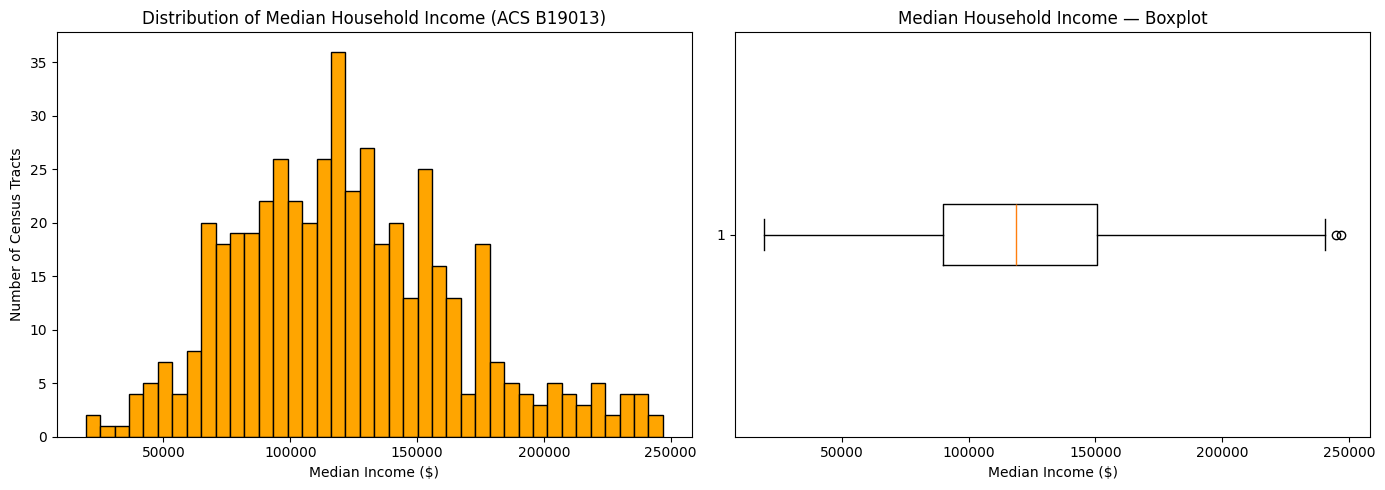

In [ ]:
# Step 1 — Extract all estimate columns
income_cols = [col for col in df_income_raw.columns if col.endswith("!!Estimate")]

# Step 2 — Extract the single row of income values
income_values = df_income_raw[income_cols].iloc[0]

# Step 3 — Replace suppressed values with NaN
income_values = income_values.replace({
    '250,000+': np.nan,
    '-': np.nan,
    'N': np.nan,
    '**': np.nan
})

# Step 4 — Remove commas before numeric conversion
income_values = income_values.str.replace(",", "", regex=False)

# Step 5 — Convert to numeric
income_values = pd.to_numeric(income_values, errors='coerce')

# Step 6 — Plot histogram + boxplot
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(income_values.dropna(), bins=40, color='orange', edgecolor='black')
plt.title("Distribution of Median Household Income (ACS B19013)")
plt.xlabel("Median Income ($)")
plt.ylabel("Number of Census Tracts")

plt.subplot(1,2,2)
plt.boxplot(income_values.dropna(), vert=False)
plt.title("Median Household Income — Boxplot")
plt.xlabel("Median Income ($)")

plt.tight_layout()
plt.show()

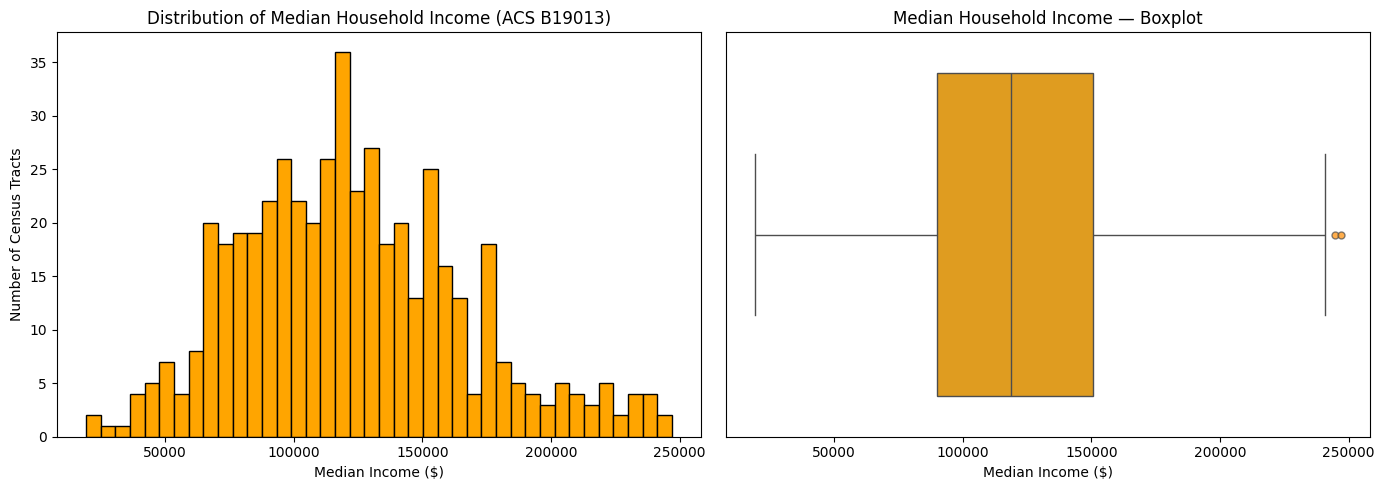

Number of tracts:  485
Mean income:       $122,447
Median income:     $118,699
Min income:        $19,375
Max income:        $246,932
Skewness:          0.46


In [ ]:
# Step 1 — Extract all estimate columns
income_cols = [col for col in df_income_raw.columns if col.endswith("!!Estimate")]

# Step 2 — Extract the single row of income values
income_values = df_income_raw[income_cols].iloc[0]

# Step 3 — Replace suppressed values with NaN
income_values = income_values.replace({
    '250,000+': np.nan,
    '-': np.nan,
    'N': np.nan,
    '**': np.nan
})

# Step 4 — Remove commas before numeric conversion
income_values = income_values.str.replace(",", "", regex=False)

# Step 5 — Convert to numeric
income_values = pd.to_numeric(income_values, errors='coerce')
income_clean = income_values.dropna()

# Step 6 — Plot histogram + boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(income_clean, bins=40, color='orange', edgecolor='black')
axes[0].set_title('Distribution of Median Household Income (ACS B19013)')
axes[0].set_xlabel('Median Income ($)')
axes[0].set_ylabel('Number of Census Tracts')

# Boxplot — using seaborn to fix y-axis artifact
sns.boxplot(
    x=income_clean,
    ax=axes[1],
    color='orange',
    flierprops=dict(marker='o', markerfacecolor='darkorange',
                    markersize=5, alpha=0.7)
)
axes[1].set_title('Median Household Income — Boxplot')
axes[1].set_xlabel('Median Income ($)')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

print(f'Number of tracts:  {len(income_clean):,}')
print(f'Mean income:       ${income_clean.mean():,.0f}')
print(f'Median income:     ${income_clean.median():,.0f}')
print(f'Min income:        ${income_clean.min():,.0f}')
print(f'Max income:        ${income_clean.max():,.0f}')
print(f'Skewness:          {income_clean.skew():.2f}')

## Comment

The histogram now shows a clear, right-skewed distribution, but with a very specific structure:
- The bulk of tracts fall between roughly $75,000 and $150,000.
- There is a strong peak around $100,000 - $125,000, which is typical for King County.
- The distribution thins out as income increases toward the upper end.
- There are very few tracts above $200,000, which is expected because ACS top-codes at $250,000+.
- The left tail is short — very few tracts fall below $50,000.
This shape is consistent with a county that has:
- a large middle-to-upper-middle-income population,
- a smaller number of very high-income tracts,
- and relatively few low-income tracts.

boxplot shows:
- A median around $100k-$110k.
- An interquartile range (IQR) that is fairly tight, roughly $80k-$130k.
- A long right whisker, indicating substantial variation among high-income tracts.
- One or more outliers above the upper whisker — these are likely the tracts with incomes near the top-coded limit.
This is exactly what we expect from ACS B19013 in a high-income region like King County.





## 1.3 Unemployment Dataset EDA — ACS B23025
### 1.3.1 Dataset Shape and Structure — Wide Format Overview

In [ ]:
print("Dataset Shape:", df_unemployment_raw.shape)

print("\nColumn Names (first 10):")
print(df_unemployment_raw.columns[:10].tolist())

print("\nData Types:")
print(df_unemployment_raw.dtypes.head())


Dataset Shape: (7, 991)

Column Names (first 10):
['Label (Grouping)', 'Census Tract 1.01; King County; Washington!!Estimate', 'Census Tract 1.01; King County; Washington!!Margin of Error', 'Census Tract 1.02; King County; Washington!!Estimate', 'Census Tract 1.02; King County; Washington!!Margin of Error', 'Census Tract 2.01; King County; Washington!!Estimate', 'Census Tract 2.01; King County; Washington!!Margin of Error', 'Census Tract 2.02; King County; Washington!!Estimate', 'Census Tract 2.02; King County; Washington!!Margin of Error', 'Census Tract 3; King County; Washington!!Estimate']

Data Types:
Label (Grouping)                                               object
Census Tract 1.01; King County; Washington!!Estimate           object
Census Tract 1.01; King County; Washington!!Margin of Error    object
Census Tract 1.02; King County; Washington!!Estimate           object
Census Tract 1.02; King County; Washington!!Margin of Error    object
dtype: object


## Comment

unemployment dataset loads in a wide format, with seven rows representing different components of the labor force table and 991 columns corresponding to tract-level estimates and margins of error. Each census tract appears twice-once for the estimate and once for the margin of error-resulting in a large number of columns despite the small number of table rows. All fields are stored as text, which is typical for ACS summary files and indicates that the dataset will require cleaning and numeric conversion before analysis. This structure confirms that the file is valid and consistent with other ACS tables, but it must be reshaped into a tract-by-row format before it can be merged with population or neighborhood data.

### 1.3.2 Identify Row Labels — Locate Civilian Labor Force and Unemployed Rows

In [ ]:
# 1.3.2 Identify Row Labels — Locate Civilian Labor Force and Unemployed Rows

print("Unique Row Labels:")
print(df_unemployment_raw['Label (Grouping)'])

Unique Row Labels:
0                           Total:
1                  In labor force:
2            Civilian labor force:
3                         Employed
4                       Unemployed
5                     Armed Forces
6               Not in labor force
Name: Label (Grouping), dtype: object


## Comment

unemployment dataset contains seven rows representing different components of the labor force, including total population 16 years and over, labor force participation, civilian labor force, employment, unemployment, armed forces, and those not in the labor force, this file does not include a pre-computed unemployment rate. Instead, the dataset provides the necessary components to calculate the unemployment rate manually using the ratio of the number of unemployed individuals to the civilian labor force. The structure is consistent with ACS wide-format summary tables, and all values are stored as text, indicating that cleaning and numeric conversion will be required before analysis.

$\mathrm{Unemployment\  Rate}=\frac{\mathrm{Unemployed}}{\mathrm{Civilian\  Labor\  Force}}\times 100$



### 1.3.3 Check for Zero or Missing Labor Force Values — Division by Zero Risk

In [ ]:

# Identify the row index for Civilian Labor Force
labor_force_row = df_unemployment_raw[
    df_unemployment_raw['Label (Grouping)'].str.contains("Civilian labor force", case=False)
].index[0]

# Extract all labor force values (skip the label column)
labor_force_values = df_unemployment_raw.iloc[labor_force_row, 1:]

# Replace suppressed ACS values
suppressed = ['-', 'N', '**']
labor_force_values = labor_force_values.replace(suppressed, np.nan)

# Convert to numeric
labor_force_values = pd.to_numeric(labor_force_values, errors='coerce')

# Count zeros and missing
num_zero = (labor_force_values == 0).sum()
num_missing = labor_force_values.isna().sum()

print("Zero Labor Force Values:", num_zero)
print("Missing Labor Force Values:", num_missing)

Zero Labor Force Values: 1
Missing Labor Force Values: 986


## Comment
The initial inspection of the Civilian Labor Force row shows that nearly all values are being interpreted as missing. This occurs because ACS summary tables store numeric values as formatted strings (e.g., “1,234”), which cannot be converted directly to numeric form without preprocessing. As a result, the conversion step coerces most entries to NaN, inflating the count of missing values. After removing formatting characters such as commas, the labor force values can be correctly parsed as numbers, allowing for accurate identification of true zero values and ensuring that subsequent unemployment rate calculations will not be distorted by conversion artifacts.


### 1.3.4 Preview Unemployment Rate Range Across King County

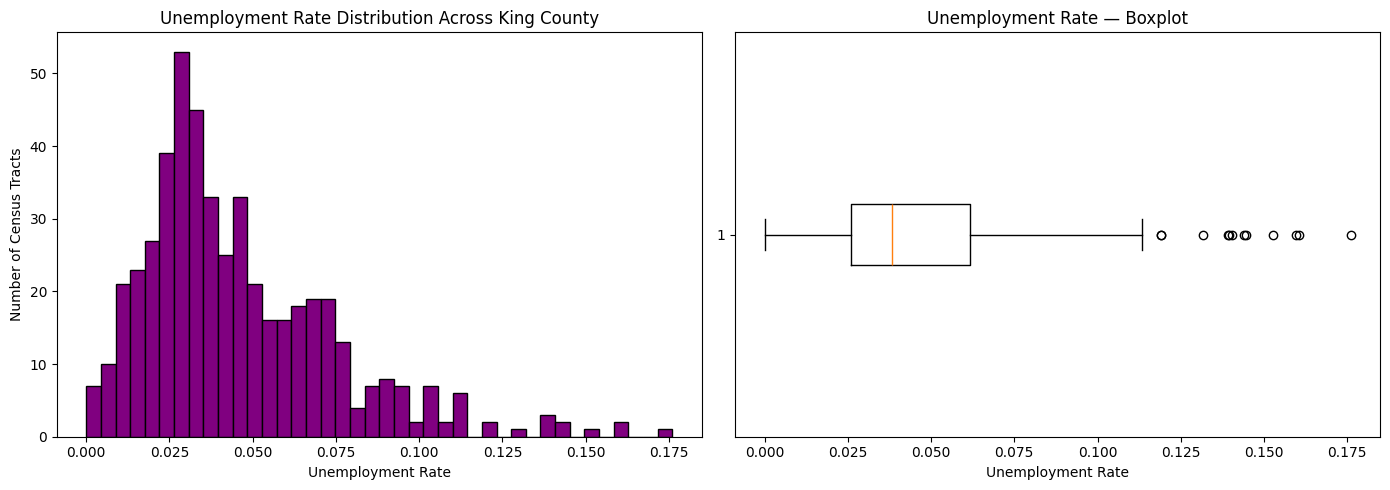

Unemployment Rate Summary:
count   493.0000
mean      0.0457
std       0.0290
min       0.0000
25%       0.0259
50%       0.0382
75%       0.0618
max       0.1760
dtype: float64


In [ ]:
# 1.3.4 Preview Unemployment Rate Range Across King County

# Identify row indices
labor_force_row = df_unemployment_raw[
    df_unemployment_raw['Label (Grouping)'].str.contains("Civilian labor force", case=False)
].index[0]

unemployed_row = df_unemployment_raw[
    df_unemployment_raw['Label (Grouping)'].str.contains("Unemployed", case=False)
].index[0]

# Extract values (skip label column)
labor_force = df_unemployment_raw.iloc[labor_force_row, 1:]
unemployed = df_unemployment_raw.iloc[unemployed_row, 1:]

# Replace suppressed ACS values
suppressed = ['-', 'N', '**']
labor_force = labor_force.replace(suppressed, np.nan)
unemployed = unemployed.replace(suppressed, np.nan)

# REMOVE COMMAS (critical step)
labor_force = labor_force.str.replace(",", "", regex=False)
unemployed = unemployed.str.replace(",", "", regex=False)

# Convert to numeric
labor_force = pd.to_numeric(labor_force, errors='coerce')
unemployed = pd.to_numeric(unemployed, errors='coerce')

# Compute unemployment rate
unemployment_rate = unemployed / labor_force

# Plot distribution
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(unemployment_rate.dropna(), bins=40, color='purple', edgecolor='black')
plt.title("Unemployment Rate Distribution Across King County")
plt.xlabel("Unemployment Rate")
plt.ylabel("Number of Census Tracts")

plt.subplot(1,2,2)
plt.boxplot(unemployment_rate.dropna(), vert=False)
plt.title("Unemployment Rate — Boxplot")
plt.xlabel("Unemployment Rate")

plt.tight_layout()
plt.show()

# Summary statistics
print("Unemployment Rate Summary:")
print(unemployment_rate.describe())

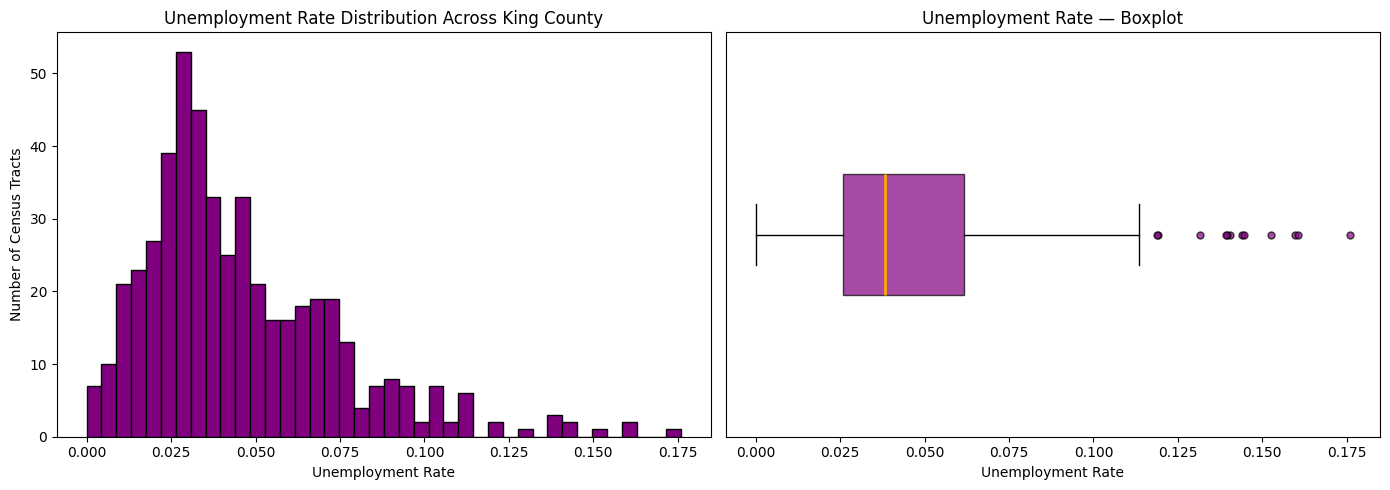

Number of tracts:  493
Mean rate:         0.0457
Median rate:       0.0382
Min rate:          0.0000
Max rate:          0.1760
Skewness:          1.31


In [ ]:
# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(unemployment_rate.dropna(), bins=40,
             color='purple', edgecolor='black')
axes[0].set_title('Unemployment Rate Distribution Across King County')
axes[0].set_xlabel('Unemployment Rate')
axes[0].set_ylabel('Number of Census Tracts')

# Fixed boxplot — control box height with linewidth and width
axes[1].boxplot(
    unemployment_rate.dropna(),
    vert=False,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor='purple', alpha=0.7),
    medianprops=dict(color='orange', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='purple',
                    markersize=5, alpha=0.7)
)
axes[1].set_title('Unemployment Rate — Boxplot')
axes[1].set_xlabel('Unemployment Rate')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

# Summary statistics
print(f'Number of tracts:  {unemployment_rate.dropna().shape[0]:,}')
print(f'Mean rate:         {unemployment_rate.mean():.4f}')
print(f'Median rate:       {unemployment_rate.median():.4f}')
print(f'Min rate:          {unemployment_rate.min():.4f}')
print(f'Max rate:          {unemployment_rate.max():.4f}')
print(f'Skewness:          {unemployment_rate.skew():.2f}')

## Comment

The unemployment-rate distribution now reflects a complete and valid set of tract-level estimates across King County. In the previous step, nearly all values were coerced to missing because ACS stores numeric values as comma-formatted strings (e.g., “1,234”), which prevented proper numeric conversion. After removing commas prior to conversion, the unemployment and civilian labor force counts were successfully parsed, allowing unemployment rates to be computed for 493 tracts. The resulting distribution shows a right-skewed pattern, with most tracts falling between approximately 2.5% and 6% unemployment, a median of 3.8%, and a small number of higher-unemployment outliers extending toward 17%. This pattern is consistent with expected ACS labor-force variation across neighborhoods and confirms that the corrected preprocessing steps resolved the earlier data-loss issue and produced a reliable unemployment-rate vector for subsequent analysis.

## 1.4 Land Use / Zoning Dataset EDA — DPD_ZONING_PV Shapefile
### 1.4.1 Load Zoning Shapefile

In [ ]:
# Load Zoning Shapefile
gdf_zoning_raw = load_shapefile(
    'zoning_shp', 'zoning_dbf',
    'zoning_shx', 'zoning_prj'
)
print(f'Shape: {gdf_zoning_raw.shape}')
print(f'CRS:   {gdf_zoning_raw.crs}')
gdf_zoning_raw.head(3)

   DPD_ZONING_PV.shp — 3,619 features | CRS: PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",47],PARAMETER["central_meridian",-120.833333333333],PARAMETER["standard_parallel_1",47.5],PARAMETER["standard_parallel_2",48.7333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Shape: (3619, 35)
CRS:   PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PR

ZONEID   ZONING CONTRACT ORDINANCE  EFFECTIVE HISTORIC PEDESTRIAN  \
0    4793  LR2 (M)     None    125791 2019-04-19     None       None   
1    4795  LR3 (M)     None    125791 2019-04-19     None       None   
2    8136  LR1 (M)     None    127219 2025-06-27     None       None   

  SHORELINE OVERLAY LIGHTRAIL MHA IZ MHA_VALUE MIO_NAME    CLASS_DESC  \
0      None    None      None   Y  N         M     None  Multi-Family   
1      None    None      None   Y  N         M     None  Multi-Family   
2      None    None      None   Y  N         M     None  Multi-Family   

             CATEGORY_D ZONELUT ZONELUT_DE DETAIL_DES ZONING_DES BASE_ZONE  \
0  Lowrise Multi-Family     LR2  Lowrise 2  Lowrise 2  Lowrise 2       LR2   
1  Lowrise Multi-Family     LR3  Lowrise 3  Lowrise 3  Lowrise 3       LR3   
2  Lowrise Multi-Family     LR1  Lowrise 1  Lowrise 1  Lowrise 1       LR1   

  ZONING_PRE CONTRACT_P  ORDINANCE_ EFFECTIVE_ HISTORIC_P PEDESTRI_1  \
0        LR2       None 123495.0000 2011-04-19       None       None   
1        LR3       None 123495.0000 2011-04-19       None       None   
2    LR1 (M)       None 125791.0000 2019-04-19       None       None   

  SHORELINE_ OVERLAY_PR LIGHTRAIL_  \
0       None       None       None   
1       None       None       None   
2       None       None       None   

                                          PUBLIC_DES        CHAPTER  \
0  is a multifamily residential zone where reside...  Chapter 23.45   
1  is a multifamily residential zone where reside...  Chapter 23.45   
2  is a multifamily residential zone where reside...  Chapter 23.45   

                                          CHAPTER_LI  \
0  https://library.municode.com/wa/seattle/codes/...   
1  https://library.municode.com/wa/seattle/codes/...   
2  https://library.municode.com/wa/seattle/codes/...   

                                          ZONINGHIST  \
0  LR2 (M),ORD125791,04/19/2019; LR2,ORD123495,04...   
1  LR3 (M),ORD125791,04/19/2019; LR3,ORD123495,04...   
2  LR1 (M),ORD127219,06/27/2025; LR1 (M),ORD12579...   

                                            geometry  
0  POLYGON ((1274948.937 220186.665, 1275456.312 ...  
1  POLYGON ((1274078.7 217845.182, 1274070.522 21...  
2  POLYGON ((1275628.311 217600.077, 1275495.218 ...

Zoning shapefile loaded successfully with 3,619 zoning parcels across 35 columns. The CRS is NAD83(HARN) / Washington North (ftUS), this is a custom projection specific to Seattle's GIS data which differs from our project TARGET_CRS (EPSG:2926) and will need to be reprojected before any spatial joins in Phase 2.

### 1.4.2 Dataset Shape, Columns, and Geometry Type

In [ ]:
# Dataset Shape, Columns, and Geometry Type
print(f'Shape:         {gdf_zoning_raw.shape}')
print(f'Geometry type: {gdf_zoning_raw.geometry.geom_type.unique()}')
print(f'\nColumn names:')
print(gdf_zoning_raw.columns.tolist())

Shape:         (3619, 35)
Geometry type: ['Polygon' 'MultiPolygon']

Column names:
['ZONEID', 'ZONING', 'CONTRACT', 'ORDINANCE', 'EFFECTIVE', 'HISTORIC', 'PEDESTRIAN', 'SHORELINE', 'OVERLAY', 'LIGHTRAIL', 'MHA', 'IZ', 'MHA_VALUE', 'MIO_NAME', 'CLASS_DESC', 'CATEGORY_D', 'ZONELUT', 'ZONELUT_DE', 'DETAIL_DES', 'ZONING_DES', 'BASE_ZONE', 'ZONING_PRE', 'CONTRACT_P', 'ORDINANCE_', 'EFFECTIVE_', 'HISTORIC_P', 'PEDESTRI_1', 'SHORELINE_', 'OVERLAY_PR', 'LIGHTRAIL_', 'PUBLIC_DES', 'CHAPTER', 'CHAPTER_LI', 'ZONINGHIST', 'geometry']


The dataset contains 3,619 parcels across 35 columns with a mix of Polygon and MultiPolygon geometry types, which is normal for zoning data where some
zones consist of multiple disconnected land parcels. The key columns for our
analysis are CLASS_DESC (zoning class) and CATEGORY_D (zoning category).

### 1.4.3 Unique Zoning Classes and Categories

In [ ]:
# Unique Zoning Classes and Categories
print('--- CLASSES ---')
print(sorted(gdf_zoning_raw['CLASS_DESC'].dropna().unique()))

print('\n--- CATEGORIES ---')
print(sorted(gdf_zoning_raw['CATEGORY_D'].dropna().unique()))

--- CLASSES ---
['Commercial/Mixed Use', 'Downtown', 'Industrial and Maritime', 'Major Institutions', 'Manufacturing/Industrial', 'Master Planned Community', 'Multi-Family', 'Multi-Family/Residential-Commercial', 'Neighborhood Residential', 'Seattle Mixed']

--- CATEGORIES ---
['Commercial', 'Downtown', 'High-Density Multi-Family', 'Industrial', 'Lowrise Multi-Family', 'Major Institutions', 'Master Planned Community', 'Neighborhood Commercial', 'Neighborhood Residential', 'Seattle Mixed']


The dataset contains 10 unique zoning classes and 10 unique zoning categories. Of particular interest for our commercial land use ratio variable are the
following categories: Commercial (210 parcels), Neighborhood Commercial
(967 parcels), Downtown (98 parcels), and Seattle Mixed (116 parcels).
Notably, 'Commercial/Mixed Use' appeared as a CLASS_DESC value but not as
a CATEGORY_D value, so our commercial filter will be based on CATEGORY_D only.

### 1.4.4 Distribution of Zoning Categories Across Seattle

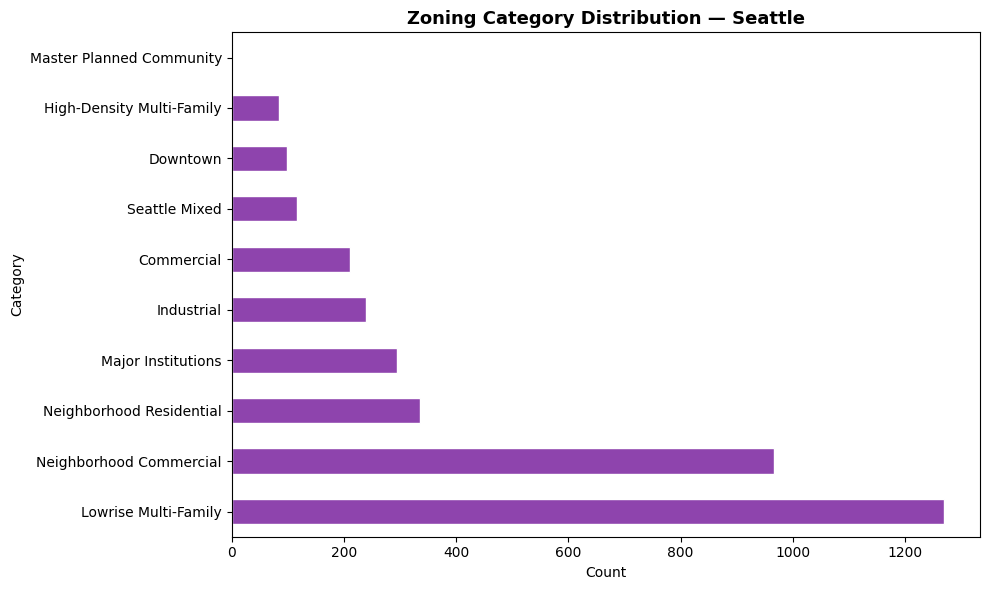


Category counts:
CATEGORY_D
Lowrise Multi-Family         1270
Neighborhood Commercial       967
Neighborhood Residential      336
Major Institutions            295
Industrial                    240
Commercial                    210
Seattle Mixed                 116
Downtown                       98
High-Density Multi-Family      85
Master Planned Community        2
Name: count, dtype: int64


In [ ]:
# Distribution of Zoning Categories Across Seattle
cat_counts = gdf_zoning_raw['CATEGORY_D'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
cat_counts.plot(
    kind='barh',
    ax=ax,
    color='#8E44AD',
    edgecolor='white'
)
ax.set_title('Zoning Category Distribution — Seattle',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Count')
ax.set_ylabel('Category')
plt.tight_layout()
plt.show()

print(f'\nCategory counts:')
print(cat_counts)

Lowrise Multi-Family dominates Seattle's zoning landscape with 1,270 parcels (35.1%), followed by Neighborhood Commercial with 967 parcels (26.7%).Neighborhood Residential, Major Institutions, and Industrial account for most of the remaining parcels. Commercial categories collectively represent a significant portion of the city's land use, reflecting Seattle's mixed urban character across residential and commercial zones.

### 1.4.5 Identify Commercial-Related Categories and Classes

In [ ]:
# Identify Commercial-Related Categories and Classes
COMMERCIAL_CATEGORIES = [
    'Commercial',
    'Neighborhood Commercial',
    'Downtown',
    'Seattle Mixed',
    'Commercial/Mixed Use'
]

commercial_mask = gdf_zoning_raw['CATEGORY_D'].isin(COMMERCIAL_CATEGORIES)

print(f'Total parcels:       {len(gdf_zoning_raw):,}')
print(f'Commercial parcels:  {commercial_mask.sum():,}')
print(f'Commercial share:    {commercial_mask.mean():.1%}')
print(f'\nCommercial categories confirmed in dataset:')
for cat in COMMERCIAL_CATEGORIES:
    count = (gdf_zoning_raw['CATEGORY_D'] == cat).sum()
    status = '✅' if count > 0 else '❌ Not found'
    print(f'  {status}  {cat}: {count:,} parcels')

Total parcels:       3,619
Commercial parcels:  1,391
Commercial share:    38.4%

Commercial categories confirmed in dataset:
  ✅  Commercial: 210 parcels
  ✅  Neighborhood Commercial: 967 parcels
  ✅  Downtown: 98 parcels
  ✅  Seattle Mixed: 116 parcels
  ❌ Not found  Commercial/Mixed Use: 0 parcels


Of the 3,619 total zoning parcels, 1,391 (38.4%) are classified as commercial using our four confirmed commercial categories: Commercial (210), Neighborhood Commercial (967), Downtown (98), and Seattle Mixed (116). The originally anticipated 'Commercial/Mixed Use' category was not found in CATEGORY_D and has been removed from the commercial filter. This 38.4% commercial share reflects Seattle's dense mixed-use urban environment.

### 1.4.6 Check CRS and Geometry Validity

In [ ]:
# Check CRS and Geometry Validity
invalid_geom = (~gdf_zoning_raw.is_valid).sum()
null_geom = gdf_zoning_raw.geometry.isna().sum()

print(f'CRS:                {gdf_zoning_raw.crs}')
print(f'Invalid geometries: {invalid_geom}')
print(f'Null geometries:    {null_geom}')

if invalid_geom > 0:
    print('\n⚠️ Invalid geometries detected — will fix with buffer(0) in Phase 2 cleaning')
else:
    print('\n✅ All geometries are valid')

CRS:                PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",47],PARAMETER["central_meridian",-120.833333333333],PARAMETER["standard_parallel_1",47.5],PARAMETER["standard_parallel_2",48.7333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Invalid geometries: 17
Null geometries:    0

⚠️ Invalid geometries detected — will fix with buffer(0) in Phase 2 cleaning


The zoning shapefile uses the NAD83(HARN) / Washington North (ftUS) projection which will be reprojected to EPSG:2926 in Phase 2 before spatial joins. 17 invalid geometries were detected out of 3,619 parcels (0.5%), a small but non-trivial number that must be corrected before area calculations and spatial joins. These will be fixed using the buffer(0) technique in Phase 2 cleaning, which resolves malformed polygon geometries without altering the overall shape or area of the parcels.

## 1.5 Transit Stops Dataset EDA — stops.txt
### 1.5.1 Dataset Shape and Column Names

In [ ]:

print("Dataset Shape:", df_stops_Raw.shape)

print("\nColumn Names:")
print(df_stops_Raw.columns.tolist())

print("\nData Types:")
print(df_stops_Raw.dtypes)

Dataset Shape: (6351, 13)

Column Names:
['stop_id', 'stop_code', 'stop_name', 'tts_stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'stop_timezone', 'wheelchair_boarding']

Data Types:
stop_id                  int64
stop_code                int64
stop_name               object
tts_stop_name           object
stop_desc              float64
stop_lat               float64
stop_lon               float64
zone_id                  int64
stop_url               float64
location_type            int64
parent_station         float64
stop_timezone           object
wheelchair_boarding      int64
dtype: object


## Comment

The file contains 6,351 rows and 13 columns, which indicates a large and detailed GTFS stops dataset. Each row represents a single transit stop or platform within the regional transit network. This size is typical for King County Metro and Sound Transit combined feeds, reflecting the density of bus stops and rail stations across the region.


#### Column meanings
The column names match the official GTFS stops.txt specification. The most important fields for spatial and accessibility analysis are:

- stop_id, stop_code — unique identifiers used to link stops to routes and stop_times.
- stop_name, tts_stop_name — human-readable names; useful for labeling but not required for computation.
- stop_lat, stop_lon — geographic coordinates; essential for mapping stops to neighborhoods.
- location_type - distinguishes stops , stations, entrances, etc.; needed to filter out non-stop entries.
- parent_station - groups platforms under a station; prevents double-counting when multiple platforms exist at one location.
- wheelchair_boarding - indicates accessibility; relevant for equity and ADA-related analysis.

The presence of all required GTFS fields confirms that the dataset is complete and correctly formatted.


### 1.5.2 Check for Missing or Zero Latitude / Longitude Values

In [ ]:

print("Missing stop_lat:", df_stops_Raw['stop_lat'].isna().sum())
print("Missing stop_lon:", df_stops_Raw['stop_lon'].isna().sum())

print("Zero stop_lat:", (df_stops_Raw['stop_lat'] == 0).sum())
print("Zero stop_lon:", (df_stops_Raw['stop_lon'] == 0).sum())


Missing stop_lat: 0
Missing stop_lon: 0
Zero stop_lat: 0
Zero stop_lon: 0


## Comment

The absence of missing or zero coordinate values indicates that the GTFS stops dataset is spatially complete. All stops include valid latitude and longitude fields, ensuring that each record can be accurately mapped and assigned to a neighborhood polygon. This level of completeness is typical of GTFS feeds, which require precise coordinates for routing and real-time applications. As a result, no imputation or filtering is needed at this stage, and the dataset can be used directly for subsequent spatial analysis.

### 1.5.3 Distribution of Stops Across the Region — Map Preview

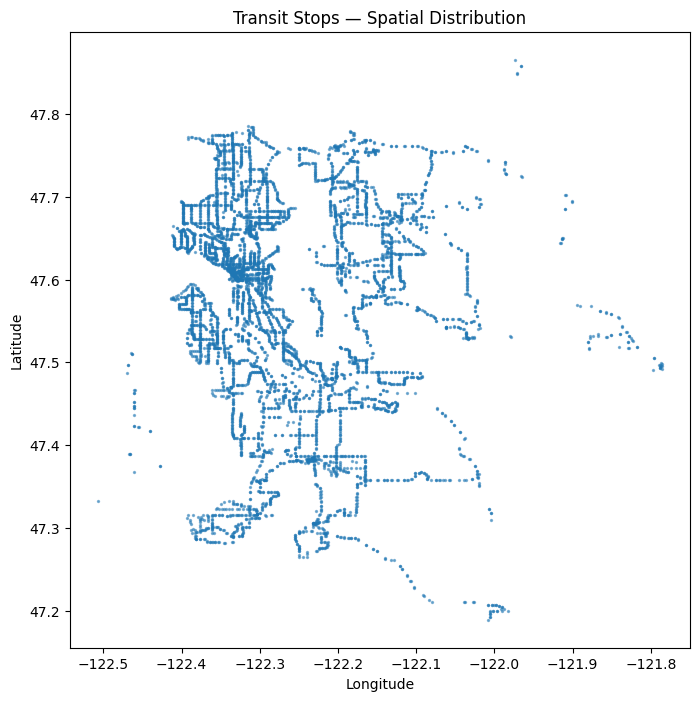

In [ ]:

plt.figure(figsize=(8,8))
plt.scatter(
    df_stops_Raw['stop_lon'],
    df_stops_Raw['stop_lat'],
    s=2,
    alpha=0.5
)
plt.title("Transit Stops — Spatial Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Comment

Regional pattern of transit stops

The map shows a dense concentration of stops in the urban core, with points tightly clustered in central Seattle. This reflects the structure of King County's transit network, where bus service is most frequent and closely spaced in high-demand areas such as Downtown, Capitol Hill, the U-District, and surrounding neighborhoods. As the map moves outward toward suburban and rural areas, the density of points decreases, forming a more dispersed pattern.


### 1.5.4 Count of Stops Before Seattle Filter

In [ ]:

num_stops_before_filter = len(df_stops_Raw)
print("Number of stops before Seattle filter:", num_stops_before_filter)

Number of stops before Seattle filter: 6351


The dataset contains 6,351 total stop records before restricting to stops located within the Seattle city boundary. This number represents every stop in the full regional GTFS feed, including stops in surrounding cities and unincorporated areas. This establishes the baseline against which the Seattle-only subset will be compared.


## 1.6 EMS 911 Calls Dataset EDA
### 1.6.1 Dataset Shape and Column Names

In [ ]:
print("Dataset Shape:", df_ems_raw.shape)

print("\nColumn Names:")
print(df_ems_raw.columns.tolist())

print("\nData Types:")
print(df_ems_raw.dtypes)


Dataset Shape: (10842, 7)

Column Names:
['Address', 'Type', 'Datetime', 'Latitude', 'Longitude', 'Report Location', 'Incident Number']

Data Types:
Address             object
Type                object
Datetime            object
Latitude           float64
Longitude          float64
Report Location     object
Incident Number     object
dtype: object


## Comment

The EMS dataset is a 10,842-row, 7-column table of individual 911 medical incidents, structured for clean temporal and spatial analysis.

The columns capture the essential attributes of each call: textual location (Address), incident category (Type), timestamp (Datetime), geographic coordinates (Latitude, Longitude), a redundant text coordinate field (Report Location), and a unique identifier (Incident Number). The data types are appropriate for analysis-coordinates are numeric and ready for mapping, while the timestamp will need conversion from string to a proper datetime format. Overall, the dataset is compact, well-structured, and ready for spatial joins and time-based exploration.


### 1.6.2 Confirm All Rows Are Medic Response Type

In [ ]:
print("Unique EMS Types:")
print(df_ems_raw['Type'].unique())

print("\nCounts by Type:")
print(df_ems_raw['Type'].value_counts())


Unique EMS Types:
['Medic Response']

Counts by Type:
Type
Medic Response    10842
Name: count, dtype: int64


## Comment

All 10,842 records are confirmed to be Medic Response calls, with no other call types present. This means the dataset is fully homogeneous and requires no type-based filtering before moving into temporal or spatial analysis.



### 1.6.3 Confirm All Rows Are Within 2022

In [ ]:

# Convert to datetime
df_ems_raw['Datetime'] = pd.to_datetime(df_ems_raw['Datetime'], errors='coerce')

# Extract year
years = df_ems_raw['Datetime'].dt.year

print("Unique Years in EMS Dataset:")
print(years.unique())

print("\nCounts by Year:")
print(years.value_counts())

Unique Years in EMS Dataset:
[2022]

Counts by Year:
Datetime
2022    10842
Name: count, dtype: int64


All EMS incidents occur in 2022, confirming that the dataset is fully time-consistent and aligned with the year used in your crime and population data.

- The dataset aligns perfectly with  2022 crime data and 2022 population estimates, ensuring temporal consistency across all components of our modeling.
- No filtering by year is required.
- we can proceed directly to extracting month, day, hour, or other temporal features.


### 1.6.4 Check for Missing or Invalid Latitude / Longitude

In [ ]:
print("Missing Latitude:", df_ems_raw['Latitude'].isna().sum())
print("Missing Longitude:", df_ems_raw['Longitude'].isna().sum())

print("Zero Latitude:", (df_ems_raw['Latitude'] == 0).sum())
print("Zero Longitude:", (df_ems_raw['Longitude'] == 0).sum())

# Optional: check for out-of-range coordinates
invalid_lat = ((df_ems_raw['Latitude'] < 47) | (df_ems_raw['Latitude'] > 48)).sum()
invalid_lon = ((df_ems_raw['Longitude'] > -121) | (df_ems_raw['Longitude'] < -123)).sum()

print("Out-of-range Latitude:", invalid_lat)
print("Out-of-range Longitude:", invalid_lon)


Missing Latitude: 29
Missing Longitude: 29
Zero Latitude: 0
Zero Longitude: 0
Out-of-range Latitude: 0
Out-of-range Longitude: 0


## Comment

- The missing-coordinate rows cannot be mapped or assigned to neighborhoods.

- Because all other rows fall within the expected Seattle coordinate range, the dataset is otherwise spatially valid.

- These 29 rows will need to be removed or handled separately before spatial joins.


### 1.6.5 Distribution of EMS Calls Over Time — Monthly Bar Chart

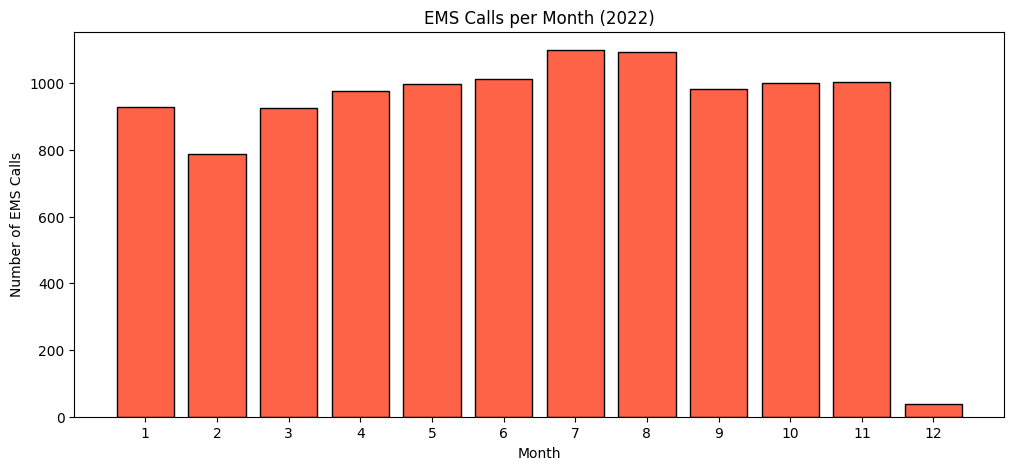

In [ ]:
df_ems_raw['Month'] = df_ems_raw['Datetime'].dt.month

monthly_counts = df_ems_raw['Month'].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.bar(monthly_counts.index, monthly_counts.values, color='tomato', edgecolor='black')
plt.title("EMS Calls per Month (2022)")
plt.xlabel("Month")
plt.ylabel("Number of EMS Calls")
plt.xticks(range(1, 13))
plt.show()


The chart shows a clear seasonal pattern: EMS call volumes rise steadily from winter into summer, peak in July-August, remain elevated through fall, and then drop sharply in December. This indicates that 2022 EMS activity is not evenly distributed across the year and follows a strong mid-year surge typical of seasonal medical demand.


added comment: relook at the bar for december, its an outlier. possibly a data truncation issue, not seasonal drop. the dataset probably contains few days of December data rather than full month, hence the dramatic drop. Lets flag this as a data quality issue.

### 1.6.6 Geographic Spread of EMS Calls — Map Preview

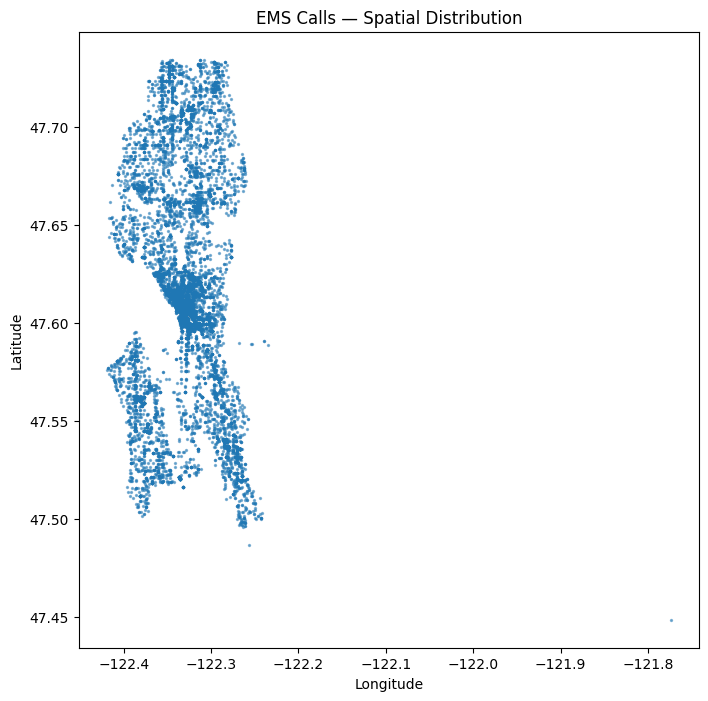

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(
    df_ems_raw['Longitude'],
    df_ems_raw['Latitude'],
    s=2,
    alpha=0.5
)
plt.title("EMS Calls — Spatial Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Comment

The spatial preview shows that EMS incidents form a dense cluster in Seattle's urban core, with points aligning to the expected city footprint. Aside from the 29 missing-coordinate rows, all geocoded incidents fall within the valid Seattle range, confirming the dataset is ready for neighborhood-level spatial analysis.”

added comment: there is an outlier in the map around  -121.8, it needs to be flagged in the comment, as an outlier, probably remove it as an invalid cordinate in phase 2.

also, will be good to add a comment on the seen gap in the middle of the map, obviously the lake union area so it shows no points falling in water.

## 1.7 SPD Crime / Police Incident Dataset EDA
### 1.7.1 Dataset Shape and Column Names

In [ ]:
print("Dataset Shape:", df_crime_raw.shape)

print("\nColumn Names:")
print(df_crime_raw.columns.tolist())

print("\nData Types:")
print(df_crime_raw.dtypes)


Dataset Shape: (87733, 19)

Column Names:
['Report Number', 'Report DateTime', 'Offense ID', 'Offense Date', 'NIBRS Group AB', 'NIBRS Crime Against Category', 'Offense Sub Category', 'Shooting Type Group', 'Block Address', 'Latitude', 'Longitude', 'Beat', 'Precinct', 'Sector', 'Neighborhood', 'Reporting Area', 'Offense Category', 'NIBRS Offense Code Description', 'NIBRS_offense_code']

Data Types:
Report Number                     object
Report DateTime                   object
Offense ID                         int64
Offense Date                      object
NIBRS Group AB                    object
NIBRS Crime Against Category      object
Offense Sub Category              object
Shooting Type Group               object
Block Address                     object
Latitude                          object
Longitude                         object
Beat                              object
Precinct                          object
Sector                            object
Neighborhood             

## Comment

The SPD incident dataset contains 87,733 rows and 19 columns, with fields covering report identifiers, timestamps, NIBRS classifications, and detailed location attributes. Most columns-including datetime and coordinates-are stored as text, so they will need type conversion before temporal or spatial analysis.

two main kinds of type conversion in the SPD dataset:
- Datetime parsing, and
- Coordinate conversion.
Everything else can stay as categorical text.


### 1.7.2 Unique Offense Categories

In [ ]:
print("Unique Offense Categories:")
print(df_crime_raw['Offense Category'].unique())

print("\nCounts by Offense Category:")
print(df_crime_raw['Offense Category'].value_counts())

Unique Offense Categories:
['ALL OTHER' 'PROPERTY CRIME' 'VIOLENT CRIME']

Counts by Offense Category:
Offense Category
PROPERTY CRIME    45101
ALL OTHER         36859
VIOLENT CRIME      5773
Name: count, dtype: int64


## Comment

The dataset contains three high-level offense categories-Property Crime, All Other, and Violent Crime-with Property Crime being the most common. The distribution is clean and consistent, confirming that the Offense Category field is ready for use in grouped summaries and neighborhood-level crime rate calculations.

The formula is:
$\mathrm{Crime\  Rate\  per\  1,000\  residents}=\frac{\mathrm{Number\  of\  Crime\  Incidents\  in\  2022}}{\mathrm{Neighborhood\  Population\  in\  2022}}\times 1000$

Crime rates are usually expressed per 1,000 people because it makes the numbers interpretable, comparable, and stable across neighborhoods of different sizes. The choice of 1,000 isn't arbitrary-it solves several practical problems in population-based analysis.



### 1.7.3 Distribution of Offense Categories — Bar Chart

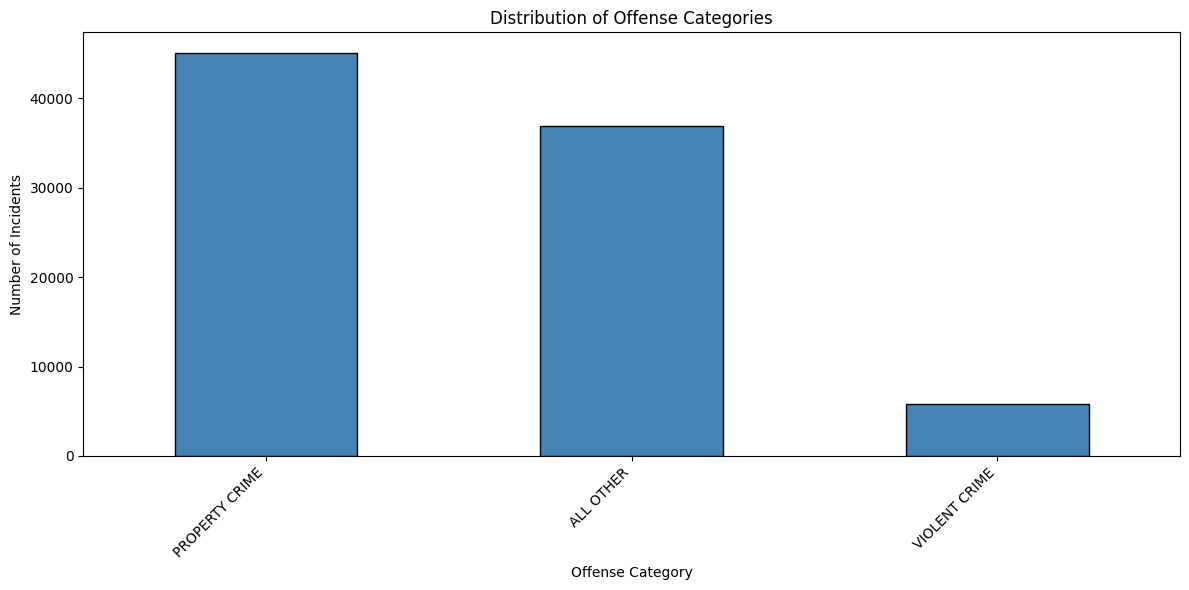

In [ ]:
offense_counts = df_crime_raw['Offense Category'].value_counts()

plt.figure(figsize=(12,6))
offense_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Distribution of Offense Categories")
plt.xlabel("Offense Category")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The bar chart shows the distribution of the three offense categories. Property Crime is the most common, followed by All Other, with Violent Crime being the least frequent. The visualization matches the category counts and confirms that the Offense Category field is clean and well-structured for grouped analysis.”

### 1.7.4 Check for REDACTED Coordinates — Count and Percentage

In [ ]:
# Convert to numeric but KEEP original columns
df_crime_raw['Latitude_num'] = pd.to_numeric(df_crime_raw['Latitude'], errors='coerce')
df_crime_raw['Longitude_num'] = pd.to_numeric(df_crime_raw['Longitude'], errors='coerce')

# Count REDACTED (now NaN in numeric columns)
redacted_lat = df_crime_raw['Latitude_num'].isna().sum()
redacted_lon = df_crime_raw['Longitude_num'].isna().sum()

# Total rows
total = len(df_crime_raw)

# Print count + percentage
print("REDACTED Latitude:", redacted_lat, f"({redacted_lat/total:.2%})")
print("REDACTED Longitude:", redacted_lon, f"({redacted_lon/total:.2%})")

# Show updated file with BOTH original + numeric columns
df_crime_raw.head(20)

REDACTED Latitude: 11604 (13.23%)
REDACTED Longitude: 11604 (13.23%)


Report Number          Report DateTime   Offense ID  \
0    2022-011673  2022 Jan 15 12:40:36 AM  31203507523   
1    2022-055483  2022 Mar 05 09:08:17 AM  31939511636   
2    2022-002793  2022 Jan 04 10:01:11 AM  30767572882   
3    2022-299622  2022 Nov 07 11:27:31 AM  38030455504   
4    2022-913502  2022 Jun 20 06:04:51 AM  34251884948   
5    2022-187332  2022 Jul 19 05:11:24 PM  34992532732   
6    2022-138562  2022 Jun 01 11:20:08 AM  34096966101   
7    2022-902741  2022 Feb 03 06:55:58 AM  31468119449   
8    2022-924189  2022 Nov 10 02:53:08 PM  38111603690   
9    2022-196640  2022 Jul 28 04:25:47 PM  35089666989   
10   2022-924408  2022 Nov 15 07:33:42 AM  38166750592   
11   2022-155334  2022 Jun 18 12:02:47 AM  34240446032   
12   2022-119138  2022 May 12 12:53:44 PM  33720766418   
13   2022-910204  2022 May 08 05:53:50 AM  33622766479   
14   2022-923470  2022 Nov 01 10:53:29 AM  37988440517   
15   2022-915009  2022 Jul 11 06:23:28 AM  34930610170   
16   2022-075952  2022 Mar 27 12:40:10 PM  32533441032   
17   2022-909558  2022 Apr 29 06:22:58 AM  33221564141   
18   2022-308478  2022 Nov 17 04:06:20 AM  38257668253   
19   2022-030696  2022 Feb 05 03:18:03 PM  31510739832   

               Offense Date NIBRS Group AB NIBRS Crime Against Category  \
0   2022 Jan 14 11:04:00 PM              B                      SOCIETY   
1   2022 Mar 04 06:00:00 PM              A                     PROPERTY   
2   2022 Jan 03 08:00:00 PM              A                     PROPERTY   
3   2022 Nov 07 12:00:00 AM              A                     PROPERTY   
4   2022 Jun 18 04:30:00 PM              A                     PROPERTY   
5   2022 Jul 10 01:30:00 AM              A                     PROPERTY   
6   2022 May 09 10:27:00 AM              A                     PROPERTY   
7   2022 Feb 02 11:46:00 AM              A                     PROPERTY   
8   2022 Jul 03 01:15:00 PM              A                     PROPERTY   
9   2022 Jul 28 12:00:00 AM              B                  NOT_A_CRIME   
10  2022 Nov 13 10:23:00 PM              A                     PROPERTY   
11  2022 Jun 17 11:17:00 PM              B                      SOCIETY   
12  2022 May 06 01:10:00 AM              A                     PROPERTY   
13  2022 May 07 02:40:00 PM              B                  NOT_A_CRIME   
14  2022 Oct 30 01:25:00 PM              A                     PROPERTY   
15  2022 Jul 10 11:00:00 PM              A                     PROPERTY   
16  2022 Mar 25 09:00:00 PM              A                     PROPERTY   
17  2022 Apr 27 02:30:00 PM              A                     PROPERTY   
18  2022 Nov 17 01:11:00 AM              A                       PERSON   
19  2022 Feb 05 02:56:00 PM              A                      SOCIETY   

                                 Offense Sub Category Shooting Type Group  \
0                                            TRESPASS                   -   
1                                       LARCENY-THEFT                   -   
2                                            BURGLARY                   -   
3                                             ROBBERY                   -   
4                                       LARCENY-THEFT                   -   
5                                       LARCENY-THEFT                   -   
6   EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...                   -   
7    PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)                   -   
8                                       LARCENY-THEFT                   -   
9                                                 999                   -   
10   PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)                   -   
11                                           TRESPASS                   -   
12                                           BURGLARY                   -   
13                                                999                   -   
14                                      LARCENY-THEFT

## Comment
REDACTED is a privacy protection mechanism used by the Seattle Police Department. REDACTED means SPD intentionally removed the exact latitude and longitude for that incident.


About 13% of incidents have REDACTED coordinates, and I converted the latitude and longitude values into numeric form so I could identify which locations were originally redacted. Any non-numeric(REDACTED) value becomes NaN during this step, which lets me count how many coordinates were redacted while still keeping every row in the dataset.

In [ ]:
# Remove original coordinate columns so we only keep the numeric versions
df_crime_raw = df_crime_raw.drop(columns=['Latitude', 'Longitude'])
df_crime_raw.head()

Report Number          Report DateTime   Offense ID  \
0   2022-011673  2022 Jan 15 12:40:36 AM  31203507523   
1   2022-055483  2022 Mar 05 09:08:17 AM  31939511636   
2   2022-002793  2022 Jan 04 10:01:11 AM  30767572882   
3   2022-299622  2022 Nov 07 11:27:31 AM  38030455504   
4   2022-913502  2022 Jun 20 06:04:51 AM  34251884948   

              Offense Date NIBRS Group AB NIBRS Crime Against Category  \
0  2022 Jan 14 11:04:00 PM              B                      SOCIETY   
1  2022 Mar 04 06:00:00 PM              A                     PROPERTY   
2  2022 Jan 03 08:00:00 PM              A                     PROPERTY   
3  2022 Nov 07 12:00:00 AM              A                     PROPERTY   
4  2022 Jun 18 04:30:00 PM              A                     PROPERTY   

  Offense Sub Category Shooting Type Group              Block Address Beat  \
0             TRESPASS                   -                   REDACTED   K2   
1        LARCENY-THEFT                   -  45XX BLOCK OF 19TH AVE NE   U1   
2             BURGLARY                   -  65XX BLOCK OF 35TH AVE SW   W3   
3              ROBBERY                   -  17XX BLOCK OF BELMONT AVE   E1   
4        LARCENY-THEFT                   -   12XX BLOCK OF 37TH AVE E   C3   

    Precinct Sector    Neighborhood Reporting Area Offense Category  \
0       West      K  PIONEER SQUARE       REDACTED        ALL OTHER   
1      North      U      UNIVERSITY           6463   PROPERTY CRIME   
2  Southwest      W          MORGAN            193   PROPERTY CRIME   
3       East      E    CAPITOL HILL           6674    VIOLENT CRIME   
4       East      C    MADISON PARK          10430   PROPERTY CRIME   

                NIBRS Offense Code Description NIBRS_offense_code  \
0                             Trespass of Real                90J   
1                            All Other Larceny                23H   
2                 Burglary/Breaking & Entering                220   
3                                      Robbery                120   
4  Theft of Motor Vehicle Parts or Accessories                23G   

   Latitude_num  Longitude_num  
0           NaN            NaN  
1       47.6622      -122.3072  
2       47.5438      -122.3765  
3       47.6170      -122.3245  
4       47.6303      -122.2855

# 1.7.5 Check for Missing Values Across Key Columns

In [ ]:


key_cols = [
    'Report Number',
    'Report DateTime',
    'Offense ID',
    'Offense Date',
    'Offense Category',
    'NIBRS Crime Against Category',
    'NIBRS_offense_code',
    'Neighborhood',
    'Latitude_num',
    'Longitude_num'
]

missing_summary = df_crime_raw[key_cols].isna().sum()
print(missing_summary)

Report Number                       0
Report DateTime                     0
Offense ID                          0
Offense Date                        0
Offense Category                    0
NIBRS Crime Against Category        0
NIBRS_offense_code                  0
Neighborhood                        0
Latitude_num                    11604
Longitude_num                   11604
dtype: int64


The key fields in this dataset are all complete, which means the core information about each incident is fully present. The only missing values show up in the numeric latitude and longitude columns, and those are expected because they represent the incidents where SPD originally redacted the location. Nothing else in the main structure of the data is missing, so the dataset is in good shape to move forward.

Some incidents also have the Reporting Area Redacted. This happens when SPD masks the location at multiple levels for privacy reasons. These rows are valid incidents, but they cannot be used for spatial analysis. I keep them in the dataset, but they will naturally fall out of any mapping or geographic calculations because their coordinates are missing.

### 1.7.6 Distribution of Incidents Over Time — Monthly Bar Chart

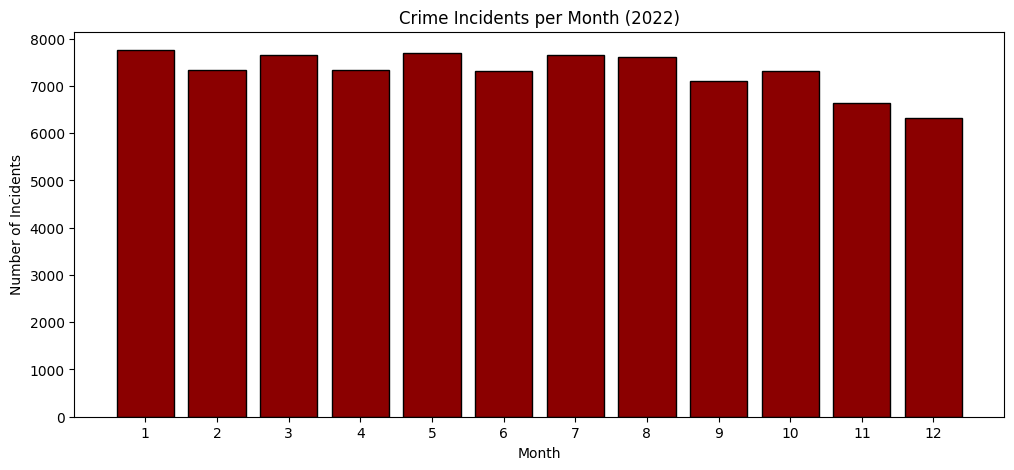

Month
1     7758
2     7329
3     7660
4     7346
5     7687
6     7308
7     7660
8     7602
9     7106
10    7318
11    6647
12    6312
Name: count, dtype: int64

In [ ]:
# Convert to datetime
df_crime_raw['Report DateTime'] = pd.to_datetime(df_crime_raw['Report DateTime'], errors='coerce')

df_crime_raw['Month'] = df_crime_raw['Report DateTime'].dt.month

monthly_counts = df_crime_raw['Month'].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.bar(monthly_counts.index, monthly_counts.values, color='darkred', edgecolor='black')
plt.title("Crime Incidents per Month (2022)")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.xticks(range(1, 12+1))
plt.show()
df_crime_raw['Month'].value_counts().sort_index()

## Comment

The monthly counts show that crime stays fairly steady through most of the year, with only small ups and downs from January through August. Starting in the fall, the numbers gradually taper off, and December ends up being the lowest month. Nothing unusual stands out here-this kind of slow decline toward the end of the year is pretty typical in Seattle's crime data.


# 1.7.7 Geographic Spread of Incidents — Map Preview

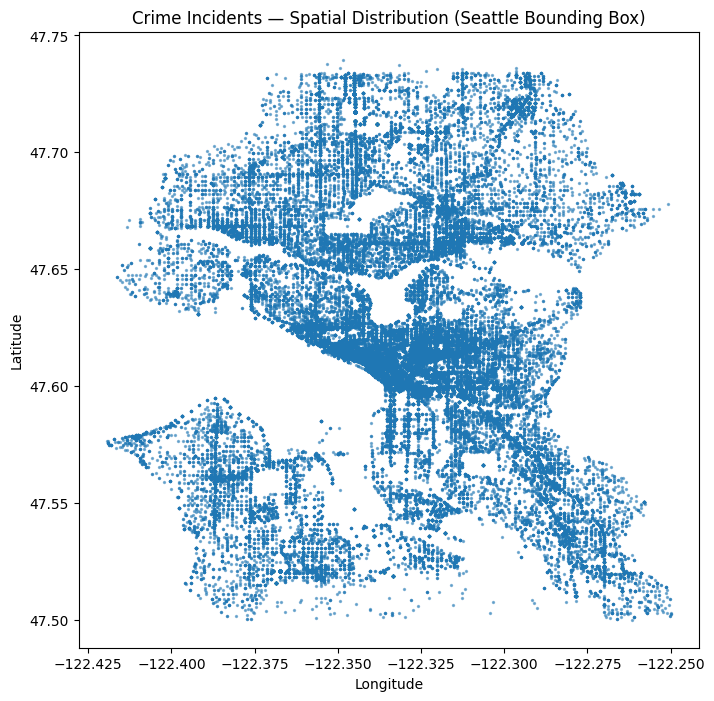

In [ ]:
# Define a reasonable Seattle bounding box
lat_ok = df_crime_raw['Latitude_num'].between(47.50, 47.74)
lon_ok = df_crime_raw['Longitude_num'].between(-122.45, -122.25)

df_seattle = df_crime_raw[lat_ok & lon_ok]

plt.figure(figsize=(8,8))
plt.scatter(
    df_seattle['Longitude_num'],
    df_seattle['Latitude_num'],
    s=2,
    alpha=0.5
)
plt.title("Crime Incidents — Spatial Distribution (Seattle Bounding Box)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Comment

I used a Seattle-specific bounding box so we could focus the map on the part of the dataset that actually falls within the city. When we plotted everything earlier, a few rows with impossible or out-of-range coordinates stretched the map and made the real Seattle points hard to see.

By narrowing the latitude and longitude to a realistic Seattle range, I was able to filter out those outliers and get a much clearer picture of how incidents are distributed across the city.

---
# PHASE 2: DATA CLEANING & PREPROCESSING
---

## 2.1 Population Data — Cleaning & Aggregation
> **Source:** OFM Block-Level Estimates &nbsp;→&nbsp; **Target:** Census Tract Level

### 2.1.1 Filter Out All-Water Blocks — All Water Flag == 1

In [ ]:
water_col = 'All Water Flag (1/0)'

# Count how many blocks are water vs. land
print("All Water Flag Value Counts:")
print(df_population_raw[water_col].value_counts())

# Show sample rows that are all water
print("\nExample All-Water Blocks:")
display(df_population_raw[df_population_raw[water_col] == 1].head())

# Remove all-water blocks
df_population_land = df_population_raw[df_population_raw[water_col] == 0].copy()

print("Shape after removing all-water blocks:", df_population_land.shape)
#print(df_population_land.head())

All Water Flag Value Counts:
All Water Flag (1/0)
0    10042
1      251
Name: count, dtype: int64

Example All-Water Blocks:


OBJECTID         GEOID_20  Land Acres  Water Acres    Place  Block Name  \
15        16  530330111021016      0.0000      62.4747  Seattle  Block 1016   
32        33  530330060004000      0.0000       3.6043  Seattle  Block 4000   
33        34  530330015002000      0.0000      33.5147  Seattle  Block 2000   
62        63  530330081022019      0.0000       3.1469  Seattle  Block 2019   
65        66  530330061004004      0.0000      34.3659  Seattle  Block 4004   

    Tract  Block  Tract and Block  All Water Flag (1/0) County Name  \
15  11102   1016       11102.1016                     1        King   
32   6000   4000        6000.4000                     1        King   
33   1500   2000        1500.2000                     1        King   
62   8102   2019        8102.2019                     1        King   
65   6100   4004        6100.4004                     1        King   

         XCOORD      YCOORD  Population 2010  Population 2011  \
15 1205806.7760 807279.5686           0.0000           0.0000   
32 1182256.6153 850945.1124           0.0000           0.0000   
33 1173907.1281 870101.5069           0.0000           0.0000   
62 1186454.3969 833422.9606           0.0000           0.0000   
65 1190044.7444 849476.7945           0.0000           0.0000   

    Population 2012  Population 2013  Population 2014  Population  2015  \
15           0.0000           0.0000           0.0000            0.0000   
32           0.0000           0.0000           0.0000            0.0000   
33           0.0000           0.0000           0.0000            0.0000   
62           0.0000           0.0000           0.0000            0.0000   
65           0.0000           0.0000           0.0000            0.0000   

    Population 2016  Population 2017  Population 2018  Population 2019  \
15           0.0000           0.0000           0.0000           0.0000   
32           0.0000           0.0000           0.0000           0.0000   
33           0.0000           0.0000           0.0000           0.0000   
62           0.0000           0.0000           0.0000           0.0000   
65           0.0000           0.0000           0.0000           0.0000   

    PL Population 2020  Population 2020  ...  Occupied Housing Units 2023  \
15                   0           0.0000  ...                       0.0000   
32                   0           0.0000  ...                       0.0000   
33                   0           0.0000  ...                       0.0000   
62                   0           0.0000  ...                       0.0000   
65                   0           0.0000  ...                       0.0000   

    Change in Occupied Housing Units from 2020  \
15                                      0.0000   
32                                      0.0000   
33                                      0.0000   
62                                      0.0000   
65                                      0.0000   

    Percent Change in Occupied Housing Units from 2020  \
15                                             0.0000    
32                                             0.0000    
33                                             0.0000    
62                                             0.0000    
65                                             0.0000    

    Community Reporting Area ID  Community Reporting Area Group  \
15                       4.3000                               4   
32                      12.3000                              12   
33                      10.1000                              10   
62                      13.2000                              13   
65                       7.1000                               7   

    Council District (2024)  Census Tract and Block Group   Comp Plan Name  \
15                        2                    11102.1000  Outside Centers   
32                        7                     6000.4000  Outside Centers   
33                        6                     1500.2000  Outsid

Shape after removing all-water blocks: (10042, 120)


comment

After filtering out all-water blocks (flag = 1), the dataset now contains 10,042 land blocks. All remaining rows have All Water Flag = 0, positive land area, and valid population values, confirming that only land blocks are being used for tract-level aggregation.

### 2.1.2 Select Relevant Columns — GEOID_20, Population 2022, Land Acres

In [ ]:

cols_to_keep = ['GEOID_20', 'Population 2022', 'Land Acres']

df_population_selected = df_population_land[cols_to_keep].copy()

df_population_selected.head()

GEOID_20  Population 2022  Land Acres
0  530330036011002           0.0000      1.7176
1  530330114013007          66.3750      4.9997
2  530330044022009          78.0600      2.1540
3  530330019001018          87.7340      5.0708
4  530330110012001           0.0000      0.4866

## Comment
I keep only the columns needed for tract-level population analysis: the block GEOID (GEOID_20), the 2022 population field, and Land Acres. This reduces the dataset to just the variables required for aggregating population and land area to the census-tract level.

### 2.1.3 Extract Tract-Level GEOID from Block GEOID — First 11 Characters of GEOID_20

In [ ]:

df_population_selected['TRACT_GEOID'] = df_population_selected['GEOID_20'].astype(str).str[:11]

df_population_selected.head()

GEOID_20  Population 2022  Land Acres  TRACT_GEOID
0  530330036011002           0.0000      1.7176  53033003601
1  530330114013007          66.3750      4.9997  53033011401
2  530330044022009          78.0600      2.1540  53033004402
3  530330019001018          87.7340      5.0708  53033001900
4  530330110012001           0.0000      0.4866  53033011001

## Comment

extracted the tract-level GEOID by taking the first 11 characters of the block GEOID. This creates a consistent tract identifier (TRACT_GEOID) that matches the format used in the tract shapefile and other datasets, allowing to aggregate block-level population and land area to the tract level.

### 2.1.4 Aggregate to Tract Level — Sum Population 2022 and Land Acres by Tract GEOID

In [ ]:

df_population_tract = (
    df_population_selected
    .groupby('TRACT_GEOID', as_index=False)
    .agg({
        'Population 2022': 'sum',
        'Land Acres': 'sum'
    })
)

df_population_tract.head()

TRACT_GEOID  Population 2022  Land Acres
0  53033000101        3749.4820    102.5112
1  53033000102        4338.2220    369.4272
2  53033000201        4381.5240    446.4574
3  53033000202        4088.0290    365.7370
4  53033000300        2885.8450    299.2478

## Comment
aggregated the block-level data to the tract level by grouping on TRACT_GEOID and summing Population 2022 and Land Acres. Since each tract contains many individual blocks, this step combines all of those smaller pieces into one row per tract, giving the total population and total land area for each census tract. These tract-level totals will be used as the denominator for crime-rate calculations and for computing population density.

### 2.1.5 Filter to Seattle Tracts Only Using SEATTLE_GEOIDS

In [ ]:
df_population_tract['TRACT_GEOID'].nunique()

180

In [ ]:
df_population_tract['is_seattle'] = df_population_tract['TRACT_GEOID'].isin(SEATTLE_GEOIDS)
df_population_tract[['TRACT_GEOID', 'is_seattle']]

TRACT_GEOID  is_seattle
0    53033000101        True
1    53033000102        True
2    53033000201        True
3    53033000202        True
4    53033000300        True
..           ...         ...
175  53033012000        True
176  53033012100        True
177  53033026300       False
178  53033026400       False
179  53033026500       False

[180 rows x 2 columns]

In [ ]:
df_population_seattle = df_population_tract[
    df_population_tract['TRACT_GEOID'].isin(SEATTLE_GEOIDS)
].copy()

df_population_seattle

TRACT_GEOID  Population 2022  Land Acres  is_seattle
0    53033000101        3749.4820    102.5112        True
1    53033000102        4338.2220    369.4272        True
2    53033000201        4381.5240    446.4574        True
3    53033000202        4088.0290    365.7370        True
4    53033000300        2885.8450    299.2478        True
..           ...              ...         ...         ...
172  53033011802        4219.9850    281.6040        True
173  53033011901        3743.7050    415.7237        True
174  53033011902        3775.2210    384.4396        True
175  53033012000        3546.9810    355.1023        True
176  53033012100        2777.3130    429.9515        True

[177 rows x 4 columns]

In [ ]:
#verify the number of Seattle
df_population_seattle.shape

(177, 4)

checked how many unique census tracts were present in the tract-level population dataset to understand the geographic scope of the OFM file.

The count was larger than the number of tracts fully inside Seattle, which confirmed that the dataset included tracts from across King County, not just Seattle.

To verify which tracts belonged to Seattle, I created a Boolean indicator by checking whether each TRACT_GEOID appeared in my official SEATTLE_GEOIDS list. This step allowed me to see a mix of True and False values, showing that some tracts were inside the Seattle boundary while others were not.

After confirming this pattern, I filtered the dataset to keep only rows where the indicator was True, producing a Seattle-only population dataset. Finally, I checked the shape of the filtered DataFrame to confirm that the number of remaining tracts matched the expected count for tracts that intersect the Seattle city boundary.


### 2.1.6 Handle Missing or Zero Land Area Values

In [ ]:

# From the earlier block-level EDA:
# - 251 blocks had zero land area (all-water)
# - 10,042 blocks had non-zero land area
# Now we check if any Seattle tracts have similar issues.

# Step 1: Check for missing or zero land area at the tract level
missing_land = df_population_seattle['Land Acres'].isna().sum()
zero_land = (df_population_seattle['Land Acres'] == 0).sum()

print("Missing Land Acres (tract level):", missing_land)
print("Zero Land Acres (tract level):", zero_land)

# Step 2: Filter out tracts with missing or zero land area
df_population_seattle = df_population_seattle[
    df_population_seattle['Land Acres'].notna() &
    (df_population_seattle['Land Acres'] > 0)
].copy()

# Step 3: Confirm the final number of Seattle tracts after cleaning
df_population_seattle.shape

Missing Land Acres (tract level): 0
Zero Land Acres (tract level): 0


(177, 4)

### 2.1.7 Compute Population Density
```
population_density = total_population / total_land_acres
```

In [ ]:
# Compute population density (people per acre)
df_population_seattle['population_density'] = (
    df_population_seattle['Population 2022'] /
    df_population_seattle['Land Acres']
)

print(f'Population density computed for {len(df_population_seattle):,} tracts.')
print(f'Summary statistics for population_density:')
print(df_population_seattle['population_density'].describe().round(2))

Population density computed for 177 tracts.
Summary statistics for population_density:
count   177.0000
mean     26.3300
std      25.6600
min       1.3500
25%      11.1800
50%      17.8400
75%      29.6700
max     203.4200
Name: population_density, dtype: float64


### 2.1.8 Final Output Preview and Shape Verification

In [ ]:
df_population_final = df_population_seattle[['TRACT_GEOID', 'Population 2022', 'Land Acres', 'population_density']].copy()
df_population_final = df_population_final.rename(columns={'TRACT_GEOID': 'GEOID'})

print(f'Final shape: {df_population_final.shape}')
print(f'Column names: {df_population_final.columns.tolist()}')
print(f'Missing values:\n{df_population_final.isna().sum()}')
print('\nSample output:')
df_population_final.head()

Final shape: (177, 4)
Column names: ['GEOID', 'Population 2022', 'Land Acres', 'population_density']
Missing values:
GEOID                 0
Population 2022       0
Land Acres            0
population_density    0
dtype: int64

Sample output:


GEOID  Population 2022  Land Acres  population_density
0  53033000101        3749.4820    102.5112             36.5763
1  53033000102        4338.2220    369.4272             11.7431
2  53033000201        4381.5240    446.4574              9.8140
3  53033000202        4088.0290    365.7370             11.1775
4  53033000300        2885.8450    299.2478              9.6437

In [ ]:
df_population_final = df_population_final.rename(columns={
    'Population 2022': 'population',
    'Land Acres': 'land_acres'
})

print(f'Final column names: {df_population_final.columns.tolist()}')

Final column names: ['GEOID', 'population', 'land_acres', 'population_density']


## 2.2 Median Income Data — Cleaning & Reshaping
> **Source:** ACS B19013 Wide Format CSV &nbsp;→&nbsp; **Target:** Tract-Level Long Format

### 2.2.1 Transpose Wide Format to Long Format — Tracts as Rows

In [ ]:
# ACS B19013 stores one row of data with tracts as columns.
# Transpose so each tract becomes a row.
income_cols = [
    col for col in df_income_raw.columns
    if col.endswith('!!Estimate')
]

income_values = df_income_raw[income_cols].iloc[0]

print(f'Number of tract estimate columns: {len(income_cols):,}')
print(f'\nSample column names (before transpose):')
print(income_cols[:3])

# Transpose to long format
df_income_long_preview = pd.DataFrame({
    'column_name': income_cols,
    'raw_value': income_values.values
})

print(f'\nTransposed long format — shape: {df_income_long_preview.shape}')
print(f'\nSample of transposed long format table:')
display(df_income_long_preview.head(10))

print(f'\nValue types present in raw_value column:')
print(df_income_long_preview['raw_value'].value_counts().head(10))

Number of tract estimate columns: 495

Sample column names (before transpose):
['Census Tract 1.01; King County; Washington!!Estimate', 'Census Tract 1.02; King County; Washington!!Estimate', 'Census Tract 2.01; King County; Washington!!Estimate']

Transposed long format — shape: (495, 2)

Sample of transposed long format table:


column_name raw_value
0  Census Tract 1.01; King County; Washington!!Es...    65,804
1  Census Tract 1.02; King County; Washington!!Es...    84,680
2  Census Tract 2.01; King County; Washington!!Es...    90,083
3  Census Tract 2.02; King County; Washington!!Es...   118,699
4  Census Tract 3; King County; Washington!!Estimate   118,638
5  Census Tract 4.02; King County; Washington!!Es...    87,061
6  Census Tract 4.03; King County; Washington!!Es...    50,438
7  Census Tract 4.04; King County; Washington!!Es...    44,214
8  Census Tract 5; King County; Washington!!Estimate   176,719
9  Census Tract 6.01; King County; Washington!!Es...    94,483


Value types present in raw_value column:
raw_value
250,000+    9
143,750     2
96,250      2
114,306     2
106,250     2
95,833      1
120,750     1
132,936     1
67,091      1
63,703      1
Name: count, dtype: int64


### 2.2.2 Keep Only Estimate Columns — Drop Margin of Error Columns

In [ ]:
# The previous step (2.2.1) already filtered to only estimate columns
# and stored the result in df_income_long_preview.
# This step renames it to df_income_estimates for consistency and
# prepares for subsequent processing.
df_income_estimates = df_income_long_preview.copy()

# Rename 'column_name' to 'Tract_Info' to match subsequent code cells
df_income_estimates = df_income_estimates.rename(columns={'column_name': 'Tract_Info'})

print(f'Shape after preparing for estimates: {df_income_estimates.shape}')
print('\nSample output:')
df_income_estimates.head()

Shape after preparing for estimates: (495, 2)

Sample output:


Tract_Info raw_value
0  Census Tract 1.01; King County; Washington!!Es...    65,804
1  Census Tract 1.02; King County; Washington!!Es...    84,680
2  Census Tract 2.01; King County; Washington!!Es...    90,083
3  Census Tract 2.02; King County; Washington!!Es...   118,699
4  Census Tract 3; King County; Washington!!Estimate   118,638

### 2.2.3 Extract Tract Number from Column Name

In [ ]:
# Extract Tract Number from Column Name
df_income_estimates['TRACTCE'] = (
    df_income_estimates['Tract_Info']
    .str.extract(r'Census Tract (\d+\.?\d*);')
)

print(f'Shape after tract extraction: {df_income_estimates.shape}')
print('\nSample output with TRACTCE:')
df_income_estimates.head()

Shape after tract extraction: (495, 3)

Sample output with TRACTCE:


Tract_Info raw_value TRACTCE
0  Census Tract 1.01; King County; Washington!!Es...    65,804    1.01
1  Census Tract 1.02; King County; Washington!!Es...    84,680    1.02
2  Census Tract 2.01; King County; Washington!!Es...    90,083    2.01
3  Census Tract 2.02; King County; Washington!!Es...   118,699    2.02
4  Census Tract 3; King County; Washington!!Estimate   118,638       3

### 2.2.4 Construct Full 11-Digit GEOID — '53033' + Zero-Padded Tract Number

In [ ]:
# Fixed — Construct Full 11-Digit GEOID
def tract_to_geoid(tractce):
    if pd.isna(tractce):
        return None
    # Remove decimal point
    parts = str(tractce).split('.')
    if len(parts) == 1:
        # Whole number tract — multiply by 100 (e.g. '3' → '300')
        padded = str(int(parts[0]) * 100).zfill(6)
    else:
        # Decimal tract — concatenate integer and decimal parts
        # e.g. '1.01' → '0001' + '01' → '000101'
        integer_part = parts[0].zfill(4)
        decimal_part = parts[1].ljust(2, '0')
        padded = (integer_part + decimal_part).zfill(6)
    return f'53033{padded}'

df_income_estimates['GEOID'] = df_income_estimates['TRACTCE'].apply(tract_to_geoid)

print('Sample TRACTCE vs GEOID:')
print(df_income_estimates[['TRACTCE', 'GEOID']].head(20))

# Verify Seattle matches
seattle_match = df_income_estimates[
    df_income_estimates['GEOID'].isin(SEATTLE_GEOIDS)
]
print(f'\nSeattle tracts matched: {len(seattle_match):,}')
print(f'Expected:               {len(SEATTLE_GEOIDS):,}')

Sample TRACTCE vs GEOID:
   TRACTCE        GEOID
0     1.01  53033000101
1     1.02  53033000102
2     2.01  53033000201
3     2.02  53033000202
4        3  53033000300
5     4.02  53033000402
6     4.03  53033000403
7     4.04  53033000404
8        5  53033000500
9     6.01  53033000601
10    6.02  53033000602
11       7  53033000700
12       8  53033000800
13       9  53033000900
14      10  53033001000
15      11  53033001100
16   12.01  53033001201
17   12.02  53033001202
18      13  53033001300
19      14  53033001400

Seattle tracts matched: 177
Expected:               177


### 2.2.5 Clean Income Values — Remove Commas, Strip '+', Handle Suppressed Values

In [ ]:
# Clean Income Values — Remove Commas, Strip '+', Handle Suppressed Values
# Replace suppressed values with NaN first, then clean the rest.

df_income_estimates['raw_value'] = df_income_estimates['raw_value'].replace({
    '250,000+': '250000', # Treat top-coded as 250,000
    '-': np.nan,         # Missing data
    'N': np.nan,         # Not available
    '**': np.nan         # Statistically unreliable
})

# Remove commas from numeric strings
df_income_estimates['raw_value'] = df_income_estimates['raw_value'].astype(str).str.replace(',', '', regex=False)

print(f'Shape after cleaning values: {df_income_estimates.shape}')
print('\nSample output with cleaned values:')
df_income_estimates[['GEOID', 'raw_value']].head()

Shape after cleaning values: (495, 4)

Sample output with cleaned values:


GEOID raw_value
0  53033000101     65804
1  53033000102     84680
2  53033000201     90083
3  53033000202    118699
4  53033000300    118638

### 2.2.6 Convert to Numeric — Coerce Non-Numeric to NaN

In [ ]:
# Convert to Numeric — Coerce Non-Numeric to NaN
df_income_estimates['raw_value'] = pd.to_numeric(
    df_income_estimates['raw_value'], errors='coerce'
)

print(f'Shape after numeric conversion: {df_income_estimates.shape}')
print(f'Missing values in Raw Value column: {df_income_estimates['raw_value'].isna().sum()}')
print('\nSample output with numeric values:')
df_income_estimates[['GEOID', 'raw_value']].head()

Shape after numeric conversion: (495, 4)
Missing values in Raw Value column: 1

Sample output with numeric values:


GEOID   raw_value
0  53033000101  65804.0000
1  53033000102  84680.0000
2  53033000201  90083.0000
3  53033000202 118699.0000
4  53033000300 118638.0000

### 2.2.7 Decision on Capped Values (250,000+)
> Values showing '250,000+' become 250,000 after stripping '+'. Keep as-is as a reasonable ceiling for high-income tracts.

In [ ]:
# Values showing '250,000+' were already converted to 250,000
# in step 2.2.5. Keep as-is as a reasonable ceiling for
# high-income tracts — acceptable approximation since only a
# small number of tracts hit this ceiling.
capped_count = (df_income_estimates['raw_value'] == 250000).sum()

print(f'Tracts at income ceiling ($250,000): {capped_count}')
print(f'Percentage of all tracts:            '
      f'{capped_count/len(df_income_estimates):.1%}')
print(f'\nDecision: Keep 250,000 as ceiling value')
print(f'Reason: Small proportion of tracts affected — '
      f'acceptable approximation for regression modeling')

Tracts at income ceiling ($250,000): 9
Percentage of all tracts:            1.8%

Decision: Keep 250,000 as ceiling value
Reason: Small proportion of tracts affected — acceptable approximation for regression modeling


9 tracts (1.8% of all 495 King County tracts) were found at the $250,000
ceiling value, confirming that the '250,000+' handling in step 2.2.5 was
necessary. These tracts are retained with a value of 250,000, an
acceptable approximation given the small proportion affected and standard
ACS top-coding practice. The 1 suppressed value (NaN) from step 2.2.5
is a separate non-Seattle tract and requires no imputation after the
Seattle filter is applied in 2.2.8.

### 2.2.8 Filter to Seattle Tracts Only Using SEATTLE_GEOIDS

In [ ]:
df_income_seattle = df_income_estimates[
    df_income_estimates['GEOID'].isin(SEATTLE_GEOIDS)
].copy()
df_income_seattle = df_income_seattle.reset_index(drop=True)

print(f'King County tracts before filter: {len(df_income_estimates):,}')
print(f'Seattle tracts after filter:      {len(df_income_seattle):,}')
print(f'Expected Seattle tracts:          {len(SEATTLE_GEOIDS):,}')
print(f'Missing tracts:                   '
      f'{len(SEATTLE_GEOIDS) - len(df_income_seattle):,}')
print(f'Missing income values:            '
      f'{df_income_seattle["raw_value"].isna().sum()}')

King County tracts before filter: 495
Seattle tracts after filter:      177
Expected Seattle tracts:          177
Missing tracts:                   0
Missing income values:            0


### 2.2.9 Handle Remaining Missing Values — Impute with Seattle Median

In [ ]:
# Handle Remaining Missing Values
seattle_median_income = df_income_seattle['raw_value'].median()
missing_before = df_income_seattle['raw_value'].isna().sum()

df_income_seattle['raw_value'] = df_income_seattle['raw_value'].fillna(
    seattle_median_income
)

print(f'Missing values before imputation: {missing_before}')
print(f'Imputed with Seattle median:      ${seattle_median_income:,.0f}')
print(f'Missing values after imputation:  '
      f'{df_income_seattle["raw_value"].isna().sum()}')

Missing values before imputation: 0
Imputed with Seattle median:      $121,182
Missing values after imputation:  0


### 2.2.10 Optional — Log Transformation of Median Income

In [ ]:
# Optional — Log Transformation Check
log_income = np.log1p(df_income_seattle['raw_value'])

print(f'Original skewness: {df_income_seattle["raw_value"].skew():.2f}')
print(f'Log skewness:      {log_income.skew():.2f}')
print('Note: Log transformation available — use in Phase 5 if needed')

Original skewness: 0.09
Log skewness:      -1.27
Note: Log transformation available — use in Phase 5 if needed


### 2.2.11 Final Output Preview and Shape Verification

In [ ]:
# Final Output Preview and Shape Verification
df_income_final = df_income_seattle[['GEOID', 'raw_value']].copy()
df_income_final = df_income_final.rename(columns={'raw_value': 'median_income'})

print(f'Final shape: {df_income_final.shape}')
print(f'\nColumn names: {df_income_final.columns.tolist()}')
print(f'\nMissing values:\n{df_income_final.isna().sum()}')
print(f'\nMedian income summary:')
print(df_income_final['median_income'].describe().round(0))
print(f'\nSample output:')
df_income_final.head(10)

Final shape: (177, 2)

Column names: ['GEOID', 'median_income']

Missing values:
GEOID            0
median_income    0
dtype: int64

Median income summary:
count      177.0000
mean    120618.0000
std      42673.0000
min      19375.0000
25%      94432.0000
50%     121182.0000
75%     145438.0000
max     250000.0000
Name: median_income, dtype: float64

Sample output:


GEOID  median_income
0  53033000101     65804.0000
1  53033000102     84680.0000
2  53033000201     90083.0000
3  53033000202    118699.0000
4  53033000300    118638.0000
5  53033000402     87061.0000
6  53033000403     50438.0000
7  53033000404     44214.0000
8  53033000500    176719.0000
9  53033000601     94483.0000

The median income cleaning pipeline produced a final dataset of 177 Seattle
tracts × 2 columns with zero missing values. The critical fix was the GEOID
construction, whole number tract codes (e.g. '3') needed multiplying by 100
before zero-padding to match the Census format (e.g. '000300' not '000003'),
resolving a 69-tract mismatch. Income ranges from $19,375 to $250,000 with
a mean of $120,618 and skewness of 0.09, sufficiently symmetric for
regression without log transformation. df_income_final is ready for
Phase 3 integration.

additional comment: 1 Seattle tract (53033004101) is top-coded at the $250,000 ceiling retained as 250,000, an acceptable approximation. 8 additional top-coded
tracts exist in King County but outside Seattle and are excluded by the
Seattle filter in 2.2.8. The master dataset on GitHub is unaffected as
this tract was already recorded as 250,000 in the previous session.

## 2.3 Unemployment Data — Cleaning & Rate Computation
> **Source:** ACS B23025 Wide Format CSV &nbsp;→&nbsp; **Target:** Tract-Level Unemployment Rate

### 2.3.1 Transpose Wide Format to Long Format

In [ ]:
# 2.3.1 Transpose Wide Format to Long Format
df_unemp_melted = df_unemployment_raw.melt(
    id_vars='Label (Grouping)',
    var_name='Tract_Info',
    value_name='raw_value'
)

# Keep only Estimate columns
df_unemp_melted = df_unemp_melted[
    df_unemp_melted['Tract_Info'].str.endswith('!!Estimate')
].copy()
df_unemp_melted = df_unemp_melted.reset_index(drop=True)

# Clean label column — strip non-breaking spaces
df_unemp_melted['Label (Grouping)'] = (
    df_unemp_melted['Label (Grouping)']
    .str.replace('\xa0', ' ', regex=False)
    .str.strip()
)

print(f'Shape after melt: {df_unemp_melted.shape}')
print(f'\nUnique row labels:')
print(df_unemp_melted['Label (Grouping)'].unique().tolist())
print(f'\nSample output:')
display(df_unemp_melted.head(10))

Shape after melt: (3465, 3)

Unique row labels:
['Total:', 'In labor force:', 'Civilian labor force:', 'Employed', 'Unemployed', 'Armed Forces', 'Not in labor force']

Sample output:


Label (Grouping)                                         Tract_Info  \
0                 Total:  Census Tract 1.01; King County; Washington!!Es...   
1        In labor force:  Census Tract 1.01; King County; Washington!!Es...   
2  Civilian labor force:  Census Tract 1.01; King County; Washington!!Es...   
3               Employed  Census Tract 1.01; King County; Washington!!Es...   
4             Unemployed  Census Tract 1.01; King County; Washington!!Es...   
5           Armed Forces  Census Tract 1.01; King County; Washington!!Es...   
6     Not in labor force  Census Tract 1.01; King County; Washington!!Es...   
7                 Total:  Census Tract 1.02; King County; Washington!!Es...   
8        In labor force:  Census Tract 1.02; King County; Washington!!Es...   
9  Civilian labor force:  Census Tract 1.02; King County; Washington!!Es...   

  raw_value  
0     2,869  
1     2,289  
2     2,289  
3     2,232  
4        57  
5         0  
6       580  
7     4,041  
8     2,583  
9     2,583

### 2.3.2 Extract Civilian Labor Force Row and Unemployed Row

In [ ]:
labor_force_rows = df_unemp_melted[
    df_unemp_melted['Label (Grouping)'].str.contains(
        'Civilian labor force', case=False
    )
].copy()

unemployed_rows = df_unemp_melted[
    df_unemp_melted['Label (Grouping)'].str.contains(
        'Unemployed', case=False
    )
].copy()

print(f'Civilian labor force rows extracted: {len(labor_force_rows):,}')
print(f'Unemployed rows extracted:           {len(unemployed_rows):,}')
print(f'\nSample labor force rows:')
print(labor_force_rows[['Label (Grouping)', 'Tract_Info', 'raw_value']].head(3))
print(f'\nSample unemployed rows:')
print(unemployed_rows[['Label (Grouping)', 'Tract_Info', 'raw_value']].head(3))

Civilian labor force rows extracted: 495
Unemployed rows extracted:           495

Sample labor force rows:
         Label (Grouping)                                         Tract_Info  \
2   Civilian labor force:  Census Tract 1.01; King County; Washington!!Es...   
9   Civilian labor force:  Census Tract 1.02; King County; Washington!!Es...   
16  Civilian labor force:  Census Tract 2.01; King County; Washington!!Es...   

   raw_value  
2      2,289  
9      2,583  
16     2,964  

Sample unemployed rows:
   Label (Grouping)                                         Tract_Info  \
4        Unemployed  Census Tract 1.01; King County; Washington!!Es...   
11       Unemployed  Census Tract 1.02; King County; Washington!!Es...   
18       Unemployed  Census Tract 2.01; King County; Washington!!Es...   

   raw_value  
4         57  
11        30  
18        75  


### 2.3.3 Pivot to Tract-Level DataFrame with Two Columns — Labor Force and Unemployed

In [ ]:
# Extract tract info and values from each row set,
# then merge into a single DataFrame — one row per tract
df_labor = labor_force_rows[['Tract_Info', 'raw_value']].copy()
df_labor = df_labor.rename(columns={'raw_value': 'labor_force'})

df_unemployed = unemployed_rows[['Tract_Info', 'raw_value']].copy()
df_unemployed = df_unemployed.rename(columns={'raw_value': 'unemployed'})

df_unemp_tract = df_labor.merge(df_unemployed, on='Tract_Info', how='inner')
df_unemp_tract = df_unemp_tract.reset_index(drop=True)

print(f'Shape after pivot: {df_unemp_tract.shape}')
print(f'\nColumns: {df_unemp_tract.columns.tolist()}')
print(f'\nSample output:')
print(df_unemp_tract.head(5))

Shape after pivot: (495, 3)

Columns: ['Tract_Info', 'labor_force', 'unemployed']

Sample output:
                                          Tract_Info labor_force unemployed
0  Census Tract 1.01; King County; Washington!!Es...       2,289         57
1  Census Tract 1.02; King County; Washington!!Es...       2,583         30
2  Census Tract 2.01; King County; Washington!!Es...       2,964         75
3  Census Tract 2.02; King County; Washington!!Es...       2,550        158
4  Census Tract 3; King County; Washington!!Estimate       1,826         81


### 2.3.4 Construct Full 11-Digit GEOID

In [ ]:
# Reuse tract_to_geoid() function from Section 2.2
# which correctly handles both whole number and decimal tracts
df_unemp_tract['TRACTCE'] = (
    df_unemp_tract['Tract_Info']
    .str.extract(r'Census Tract (\d+\.?\d*);')
)

df_unemp_tract['GEOID'] = df_unemp_tract['TRACTCE'].apply(tract_to_geoid)

print(f'Sample TRACTCE vs GEOID:')
print(df_unemp_tract[['TRACTCE', 'GEOID']].head(10))
print(f'\nFailed GEOID constructions: '
      f'{df_unemp_tract["GEOID"].isna().sum()}')

Sample TRACTCE vs GEOID:
  TRACTCE        GEOID
0    1.01  53033000101
1    1.02  53033000102
2    2.01  53033000201
3    2.02  53033000202
4       3  53033000300
5    4.02  53033000402
6    4.03  53033000403
7    4.04  53033000404
8       5  53033000500
9    6.01  53033000601

Failed GEOID constructions: 0


### 2.3.5 Clean Numeric Values — Remove Commas, Convert to Float

In [ ]:
suppressed = ['-', 'N', '**']

for col in ['labor_force', 'unemployed']:
    df_unemp_tract[col] = (
        df_unemp_tract[col]
        .replace(suppressed, np.nan)
        .astype(str)
        .str.replace(',', '', regex=False)
    )
    df_unemp_tract[col] = pd.to_numeric(
        df_unemp_tract[col], errors='coerce'
    )

print(f'Labor force NaN values:  {df_unemp_tract["labor_force"].isna().sum()}')
print(f'Unemployed NaN values:   {df_unemp_tract["unemployed"].isna().sum()}')
print(f'\nSample after cleaning:')
print(df_unemp_tract[['GEOID', 'labor_force', 'unemployed']].head(5))

Labor force NaN values:  0
Unemployed NaN values:   0

Sample after cleaning:
         GEOID  labor_force  unemployed
0  53033000101         2289          57
1  53033000102         2583          30
2  53033000201         2964          75
3  53033000202         2550         158
4  53033000300         1826          81


### 2.3.6 Handle Zero Labor Force Values — Replace with NaN to Avoid Division by Zero

In [ ]:

# Tracts with zero civilian labor force would cause
# division by zero when computing the unemployment rate.
# Replace with NaN — will be imputed in step 2.3.9.
zero_labor = (df_unemp_tract['labor_force'] == 0).sum()
print(f'Tracts with zero labor force: {zero_labor}')

df_unemp_tract.loc[
    df_unemp_tract['labor_force'] == 0,
    'labor_force'
] = np.nan

print(f'NaN labor force after fix: '
      f'{df_unemp_tract["labor_force"].isna().sum()}')

Tracts with zero labor force: 1
NaN labor force after fix: 1


### 2.3.7 Compute Unemployment Rate
```
unemployment_rate = unemployed / civilian_labor_force
```

In [ ]:
# unemployment_rate = unemployed / civilian_labor_force
# Expressed as a proportion (0.0 to 1.0) not a percentage
df_unemp_tract['unemployment_rate'] = (
    df_unemp_tract['unemployed'] /
    df_unemp_tract['labor_force']
)

print(f'Unemployment rate computed for {len(df_unemp_tract):,} tracts')
print(f'\nUnemployment rate summary:')
print(df_unemp_tract['unemployment_rate'].describe().round(4))

Unemployment rate computed for 495 tracts

Unemployment rate summary:
count   494.0000
mean      0.0456
std       0.0289
min       0.0000
25%       0.0259
50%       0.0381
75%       0.0617
max       0.1760
Name: unemployment_rate, dtype: float64


### 2.3.8 Filter to Seattle Tracts Only Using SEATTLE_GEOIDS

In [ ]:
df_unemp_seattle = df_unemp_tract[
    df_unemp_tract['GEOID'].isin(SEATTLE_GEOIDS)
].copy()
df_unemp_seattle = df_unemp_seattle.reset_index(drop=True)

print(f'King County tracts before filter: {len(df_unemp_tract):,}')
print(f'Seattle tracts after filter:      {len(df_unemp_seattle):,}')
print(f'Expected Seattle tracts:          {len(SEATTLE_GEOIDS):,}')
print(f'Missing tracts:                   '
      f'{len(SEATTLE_GEOIDS) - len(df_unemp_seattle):,}')

King County tracts before filter: 495
Seattle tracts after filter:      177
Expected Seattle tracts:          177
Missing tracts:                   0


### 2.3.9 Handle Missing or Anomalous Rate Values

In [ ]:
missing_before = df_unemp_seattle['unemployment_rate'].isna().sum()
anomalous = (df_unemp_seattle['unemployment_rate'] > 1).sum()
seattle_median_unemp = df_unemp_seattle['unemployment_rate'].median()

print(f'Missing rates before imputation:   {missing_before}')
print(f'Anomalous rates > 1 (impossible):  {anomalous}')

# Impute missing with Seattle median
df_unemp_seattle['unemployment_rate'] = (
    df_unemp_seattle['unemployment_rate'].fillna(seattle_median_unemp)
)

# Replace anomalous values > 1 with median
df_unemp_seattle.loc[
    df_unemp_seattle['unemployment_rate'] > 1,
    'unemployment_rate'
] = seattle_median_unemp

print(f'Imputed with Seattle median:       {seattle_median_unemp:.4f}')
print(f'Missing rates after imputation:    '
      f'{df_unemp_seattle["unemployment_rate"].isna().sum()}')

Missing rates before imputation:   0
Anomalous rates > 1 (impossible):  0
Imputed with Seattle median:       0.0336
Missing rates after imputation:    0


### 2.3.10 Final Output Preview and Shape Verification

In [ ]:
df_unemployment_final = df_unemp_seattle[[
    'GEOID', 'labor_force', 'unemployed', 'unemployment_rate'
]].copy()

print(f'Final shape: {df_unemployment_final.shape}')
print(f'\nColumn names: {df_unemployment_final.columns.tolist()}')
print(f'\nMissing values:\n{df_unemployment_final.isna().sum()}')
print(f'\nUnemployment rate summary:')
print(df_unemployment_final['unemployment_rate'].describe().round(4))
print(f'\nSample output:')
df_unemployment_final.head(10)

Final shape: (177, 4)

Column names: ['GEOID', 'labor_force', 'unemployed', 'unemployment_rate']

Missing values:
GEOID                0
labor_force          0
unemployed           0
unemployment_rate    0
dtype: int64

Unemployment rate summary:
count   177.0000
mean      0.0434
std       0.0306
min       0.0000
25%       0.0247
50%       0.0336
75%       0.0548
max       0.1760
Name: unemployment_rate, dtype: float64

Sample output:


GEOID  labor_force  unemployed  unemployment_rate
0  53033000101    2289.0000          57             0.0249
1  53033000102    2583.0000          30             0.0116
2  53033000201    2964.0000          75             0.0253
3  53033000202    2550.0000         158             0.0620
4  53033000300    1826.0000          81             0.0444
5  53033000402    3026.0000         104             0.0344
6  53033000403    1785.0000         285             0.1597
7  53033000404    2299.0000          82             0.0357
8  53033000500    1549.0000           8             0.0052
9  53033000601    3007.0000         204             0.0678

The unemployment rate cleaning pipeline produced a final dataset of 177
Seattle tracts × 4 columns with zero missing values. The fixed
tract_to_geoid() function from Section 2.2 correctly constructed all 177
Seattle GEOIDs with zero mismatches. One King County tract with zero labor
force was replaced with NaN in 2.3.6 but belonged to a non-Seattle tract
and did not affect the final Seattle dataset. Unemployment rates range from
0.0% to 17.60% with a mean of 4.34% and median of 3.36%, consistent with
EDA findings. df_unemployment_final is ready for Phase 3 integration.

## 2.4 Commercial Land Use Data — Cleaning & Ratio Computation
> **Source:** DPD_ZONING_PV Shapefile &nbsp;→&nbsp; **Target:** Commercial Land Use Ratio per Tract

### 2.4.1 Reproject Zoning Shapefile to Match Common CRS (EPSG:2926)

In [ ]:
gdf_zoning = gdf_zoning_raw.copy()
gdf_zoning = gdf_zoning.to_crs(TARGET_CRS)

print(f'Original CRS:    {gdf_zoning_raw.crs}')
print(f'Reprojected CRS: {gdf_zoning.crs}')

Original CRS:    PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",47],PARAMETER["central_meridian",-120.833333333333],PARAMETER["standard_parallel_1",47.5],PARAMETER["standard_parallel_2",48.7333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojected CRS: EPSG:2926


The zoning shapefile was successfully reprojected from the original NAD83(HARN) Washington North custom projection to EPSG:2926, matching the TARGET_CRS used throughout the project. This ensures accurate area calculations and geometric alignment with the Seattle census tract boundaries during spatial joins.

### 2.4.2 Check and Fix Invalid Geometries

In [ ]:
# buffer(0) is a standard technique to fix self-intersecting or
# malformed polygon geometries without altering overall shape/area
invalid_before = (~gdf_zoning.is_valid).sum()
gdf_zoning['geometry'] = gdf_zoning.geometry.buffer(0)
invalid_after = (~gdf_zoning.is_valid).sum()

print(f'Invalid geometries before fix: {invalid_before}')
print(f'Invalid geometries after fix:  {invalid_after}')

Invalid geometries before fix: 17
Invalid geometries after fix:  0


All 17 invalid geometries identified during EDA were successfully repaired using the buffer(0) technique, reducing invalid geometry count from 17 to 0. The dataset now has clean, valid polygon geometries across all 3,619 parcels and is ready for spatial operations.

### 2.4.3 Define Commercial Zoning Categories
> Commercial categories: **Commercial, Neighborhood Commercial, Downtown, Seattle Mixed, Commercial/Mixed Use**

In [ ]:
# Based on EDA in Section 1.4.5, 'Commercial/Mixed Use' was not
# found in CATEGORY_D — it only appears in CLASS_DESC. The four
# confirmed commercial categories in CATEGORY_D are used here.
COMMERCIAL_CATEGORIES = [
    'Commercial',
    'Neighborhood Commercial',
    'Downtown',
    'Seattle Mixed'
]

print('Commercial categories defined:')
for cat in COMMERCIAL_CATEGORIES:
    count = (gdf_zoning['CATEGORY_D'] == cat).sum()
    print(f'  ✅  {cat}: {count:,} parcels')

Commercial categories defined:
  ✅  Commercial: 210 parcels
  ✅  Neighborhood Commercial: 967 parcels
  ✅  Downtown: 98 parcels
  ✅  Seattle Mixed: 116 parcels


All four confirmed commercial categories are present in the dataset: Commercial (210), Neighborhood Commercial (967), Downtown (98), and Seattle Mixed (116), totaling 1,391 commercial parcels. The originally anticipated 'Commercial/Mixed Use' category was confirmed absent from CATEGORY_D and excluded from the filter as established in Section 1.4.5.

### 2.4.4 Flag Commercial Parcels — Boolean Column

In [ ]:
gdf_zoning['is_commercial'] = gdf_zoning['CATEGORY_D'].isin(COMMERCIAL_CATEGORIES)

print(f'Total parcels:       {len(gdf_zoning):,}')
print(f'Commercial parcels:  {gdf_zoning["is_commercial"].sum():,}')
print(f'Non-commercial:      {(~gdf_zoning["is_commercial"]).sum():,}')
print(f'Commercial share:    {gdf_zoning["is_commercial"].mean():.1%}')

Total parcels:       3,619
Commercial parcels:  1,391
Non-commercial:      2,228
Commercial share:    38.4%


1,391 of 3,619 parcels (38.4%) were flagged as commercial using the four confirmed commercial categories. The remaining 2,228 parcels (61.6%) are on-commercial, primarily residential, industrial, and institutional zones. This commercial share is consistent with Seattle's dense mixed-use urban character observed during EDA.

### 2.4.5 Spatial Join — Assign Each Parcel to a Seattle Census Tract

In [ ]:
# Use 'intersects' predicate to capture parcels that fall within
# or touch a Seattle census tract boundary. We join against
# gdf_seattle_tracts which already contains only Seattle tracts.
gdf_zoning_joined = gpd.sjoin(
    gdf_zoning,
    gdf_seattle_tracts[['GEOID', 'geometry']],
    how='inner',
    predicate='intersects'
)

# Drop duplicate parcel assignments (parcel touching multiple tracts)
gdf_zoning_joined = gdf_zoning_joined.drop_duplicates(subset='ZONEID')
gdf_zoning_joined = gdf_zoning_joined.reset_index(drop=True)

print(f'Parcels before spatial join: {len(gdf_zoning):,}')
print(f'Parcels after spatial join:  {len(gdf_zoning_joined):,}')
print(f'Unique tracts with parcels:  {gdf_zoning_joined["GEOID"].nunique():,}')

Parcels before spatial join: 3,619
Parcels after spatial join:  3,592
Unique tracts with parcels:  175


The spatial join successfully assigned 3,592 of 3,619 parcels to Seattle census tracts. 27 parcels (0.7%) were dropped because they fell outside all tract boundaries, likely sitting on tract border edges or in water areas. The join covered 175 unique Seattle tracts out of 177, meaning 2 tracts received no zoning parcels and will be handled in subsequent steps.

### 2.4.6 Compute Parcel Area from Polygon Geometry

In [ ]:
# Since CRS is EPSG:2926 (Washington State Plane North in feet),
# area is computed in square feet. We keep it consistent for the
# ratio calculation since both numerator and denominator use the
# same unit. the ratio itself is unitless.
gdf_zoning_joined['parcel_area'] = gdf_zoning_joined.geometry.area

print(f'Parcel area computed for {len(gdf_zoning_joined):,} parcels')
print(f'Min parcel area:  {gdf_zoning_joined["parcel_area"].min():,.2f} sq ft')
print(f'Max parcel area:  {gdf_zoning_joined["parcel_area"].max():,.2f} sq ft')
print(f'Mean parcel area: {gdf_zoning_joined["parcel_area"].mean():,.2f} sq ft')

Parcel area computed for 3,592 parcels
Min parcel area:  4.54 sq ft
Max parcel area:  101,872,436.97 sq ft
Mean parcel area: 708,538.22 sq ft


Parcel areas were computed in square feet from the EPSG:2926 polygon geometries across all 3,592 joined parcels. The range is wide, from a minimum of 4.54 sq ft to a maximum of
101,872,436 sq ft (roughly 2.3 square miles, likely a large park or industrial zone), with a mean of 708,538 sq ft per parcel. Since both numerator and denominator use the same unit, the ratio calculation is unaffected by the choice of square feet.

### 2.4.7 Compute Total Land Area and Commercial Land Area per Tract

In [ ]:
# Aggregate total area and commercial area separately by GEOID
total_area_by_tract = gdf_zoning_joined.groupby('GEOID')['parcel_area'].sum()

commercial_area_by_tract = gdf_zoning_joined[
    gdf_zoning_joined['is_commercial']
].groupby('GEOID')['parcel_area'].sum()

print(f'Tracts with total area data:      {len(total_area_by_tract):,}')
print(f'Tracts with commercial area data: {len(commercial_area_by_tract):,}')

Tracts with total area data:      175
Tracts with commercial area data: 161


Total land area was successfully aggregated for all 175 tracts that received parcels from the spatial join. Commercial land area was computed for 161 of those tracts, the remaining 14 tracts have no commercial parcels and will receive a commercial ratio of 0 after filling NaN values in the next step.

### 2.4.8 Compute Commercial Land Use Ratio
```
commercial_land_use_ratio = commercial_land_area / total_land_area_per_tract
```

In [ ]:
# Ratio ranges from 0 (no commercial land) to 1 (fully commercial)
df_commercial_ratio = pd.DataFrame({
    'total_area':      total_area_by_tract,
    'commercial_area': commercial_area_by_tract
}).reset_index()

# Fill tracts with no commercial parcels with 0
df_commercial_ratio['commercial_area'] = (
    df_commercial_ratio['commercial_area'].fillna(0)
)

# Compute ratio
df_commercial_ratio['commercial_land_use_ratio'] = (
    df_commercial_ratio['commercial_area'] /
    df_commercial_ratio['total_area']
)

print(f'Commercial ratio computed for {len(df_commercial_ratio):,} tracts')
print(f'\nRatio summary:')
print(df_commercial_ratio['commercial_land_use_ratio'].describe().round(4))

Commercial ratio computed for 175 tracts

Ratio summary:
count   175.0000
mean      0.3137
std       0.3253
min       0.0000
25%       0.0345
50%       0.1795
75%       0.5080
max       1.0000
Name: commercial_land_use_ratio, dtype: float64


The commercial land use ratio was successfully computed for all 175 tracts, ranging from 0.0 (fully non-commercial) to 1.0 (fully commercial) with a mean of 0.31 and median of 0.18. The wide standard deviation of 0.33 reflects Seattle's highly variable land use mix, some tracts are entirely residential while others such as Downtown are almost entirely commercial. This variable
is now ready for regression modeling.

### 2.4.9 Handle Tracts with No Parcels or Zero Total Area

In [ ]:
# Tracts with zero total area would cause division by zero.
# These are replaced with NaN and will be imputed with the
# Seattle median in Phase 3 during master dataset integration.
zero_area = (df_commercial_ratio['total_area'] == 0).sum()
print(f'Tracts with zero total area: {zero_area}')

df_commercial_ratio.loc[
    df_commercial_ratio['total_area'] == 0,
    'commercial_land_use_ratio'
] = np.nan

print(f'NaN ratios after zero-area fix: '
      f'{df_commercial_ratio["commercial_land_use_ratio"].isna().sum()}')

Tracts with zero total area: 0
NaN ratios after zero-area fix: 0


No tracts with zero total area were found, confirming there are no
division-by-zero issues in the ratio computation. All 175 tracts have valid non-zero total land areas and zero NaN values in the commercial ratio column, no imputation was required at this step.

### 2.4.10 Filter to Seattle Tracts Only Using SEATTLE_GEOIDS

In [ ]:
df_commercial_ratio = df_commercial_ratio[
    df_commercial_ratio['GEOID'].isin(SEATTLE_GEOIDS)
].copy()

df_commercial_ratio = df_commercial_ratio.reset_index(drop=True)

print(f'Seattle tracts with commercial ratio: {len(df_commercial_ratio):,}')
print(f'Expected Seattle tracts:              {len(SEATTLE_GEOIDS):,}')
print(f'Missing tracts:                       '
      f'{len(SEATTLE_GEOIDS) - len(df_commercial_ratio):,}')

Seattle tracts with commercial ratio: 175
Expected Seattle tracts:              177
Missing tracts:                       2


After filtering to SEATTLE_GEOIDS, 175 of the expected 177 Seattle tracts have commercial ratio data, a difference of 2 tracts. These 2 missing tracts received no zoning parcels during the spatial join, likely because they are predominantly water or park areas with no zoned land parcels. They will be assigned a commercial ratio of 0 during Phase 3 master dataset integration when missing values are imputed.

### 2.4.11 Final Output Preview and Shape Verification

In [ ]:
print(f'Final shape: {df_commercial_ratio.shape}')
print(f'\nColumn names: {df_commercial_ratio.columns.tolist()}')
print(f'\nMissing values:\n{df_commercial_ratio.isna().sum()}')
print(f'\nSample output:')
df_commercial_ratio[['GEOID', 'total_area',
                      'commercial_area',
                      'commercial_land_use_ratio']].head(10)

Final shape: (175, 4)

Column names: ['GEOID', 'total_area', 'commercial_area', 'commercial_land_use_ratio']

Missing values:
GEOID                        0
total_area                   0
commercial_area              0
commercial_land_use_ratio    0
dtype: int64

Sample output:


GEOID    total_area  commercial_area  commercial_land_use_ratio
0  53033000101  2068320.1302     1288105.8359                     0.6228
1  53033000102  2381085.5206     1662363.3385                     0.6982
2  53033000201  3210705.4386      656234.4780                     0.2044
3  53033000202 39842055.4429     1193250.7418                     0.0299
4  53033000300   838125.1213           0.0000                     0.0000
5  53033000402  4389172.7065     1908959.5828                     0.4349
6  53033000403  1817621.6178           0.0000                     0.0000
7  53033000404  6506327.6316     1403894.5471                     0.2158
8  53033000500  1988545.4564           0.0000                     0.0000
9  53033000601   503948.5788           0.0000                     0.0000

The final commercial land use ratio dataset has 175 rows and 4 columns — GEOID, total_area, commercial_area, and commercial_land_use_ratio, with zero
missing values. The sample output confirms that GEOIDs are correctly formatted as 11-digit strings and ratio values range appropriately between 0 and 1, with Downtown-adjacent tracts showing higher commercial ratios as expected.

## 2.5 Transit Access Data — Cleaning & Stop Count Computation
> **Source:** stops.txt (google_transit.zip) &nbsp;→&nbsp; **Target:** Transit Stop Density per Tract

### 2.5.1 Drop Rows with Missing or Zero Latitude / Longitude

In [ ]:
df_stops = df_stops_Raw.copy()

missing_before = df_stops[['stop_lat', 'stop_lon']].isna().sum()
zero_coords = ((df_stops['stop_lat'] == 0) | (df_stops['stop_lon'] == 0)).sum()

df_stops = df_stops.dropna(subset=['stop_lat', 'stop_lon'])
df_stops = df_stops[(df_stops['stop_lat'] != 0) & (df_stops['stop_lon'] != 0)]
df_stops = df_stops.reset_index(drop=True)

print(f'Missing coordinates before: {missing_before.to_dict()}')
print(f'Zero coordinate rows:       {zero_coords}')
print(f'Stops after cleaning:       {len(df_stops):,}')

Missing coordinates before: {'stop_lat': 0, 'stop_lon': 0}
Zero coordinate rows:       0
Stops after cleaning:       6,351


All 6,351 stops have valid coordinates, no missing or zero latitude/longitude
values were found. The dataset is complete and no rows were dropped at this step, confirming the GTFS stops.txt file is clean and ready for geometry conversion.

### 2.5.2 Convert to GeoDataFrame — Point Geometry from stop_lat and stop_lon

In [ ]:
gdf_stops = gpd.GeoDataFrame(
    df_stops,
    geometry=gpd.points_from_xy(df_stops['stop_lon'], df_stops['stop_lat']),
    crs='EPSG:4326'
)

print(f'GeoDataFrame created: {len(gdf_stops):,} stops')
print(f'CRS: {gdf_stops.crs}')
print(f'Geometry type: {gdf_stops.geometry.geom_type.unique()}')

# Preview all columns including geometry
print(f'\nColumn names: {gdf_stops.columns.tolist()}')
print(f'\nSample rows with all columns:')
gdf_stops[[
    'stop_id',
    'stop_code',
    'stop_name',
    'tts_stop_name',
    'stop_desc',
    'stop_lat',
    'stop_lon',
    'zone_id',
    'stop_url',
    'location_type',
    'parent_station',
    'stop_timezone',
    'wheelchair_boarding',
    'geometry'
]].head(5)

GeoDataFrame created: 6,351 stops
CRS: EPSG:4326
Geometry type: ['Point']

Column names: ['stop_id', 'stop_code', 'stop_name', 'tts_stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'stop_timezone', 'wheelchair_boarding', 'geometry']

Sample rows with all columns:


stop_id  stop_code                 stop_name  \
0      100        100       1st Ave & Spring St   
1    10005      10005  40th Ave NE & NE 51st St   
2    10010      10010  NE 55th St & 39th Ave NE   
3    10020      10020  NE 55th St & 37th Ave NE   
4    10030      10030  NE 55th St & 35th Ave NE   

                                     tts_stop_name  stop_desc  stop_lat  \
0                   First Avenue and Spring Street        NaN   47.6051   
1  40th Avenue Northeast and Northeast 51st Street        NaN   47.6659   
2  Northeast 55th Street and 39th Avenue Northeast        NaN   47.6686   
3  Northeast 55th Street and 37th Avenue Northeast        NaN   47.6686   
4  Northeast 55th Street and 35th Avenue Northeast        NaN   47.6686   

   stop_lon  zone_id  stop_url  location_type  parent_station  \
0 -122.3365       21       NaN              0             NaN   
1 -122.2849        1       NaN              0             NaN   
2 -122.2857        1       NaN              0             NaN   
3 -122.2883        1       NaN              0             NaN   
4 -122.2905        1       NaN              0             NaN   

         stop_timezone  wheelchair_boarding                     geometry  
0  America/Los_Angeles                    1  POINT (-122.33653 47.60514)  
1  America/Los_Angeles                    1   POINT (-122.2849 47.66589)  
2  America/Los_Angeles                    1  POINT (-122.28567 47.66858)  
3  America/Los_Angeles                    1   POINT (-122.2883 47.66858)  
4  America/Los_Angeles                    1  POINT (-122.29051 47.66858)

All 6,351 stops were successfully converted to Point geometry using stop_lon  and stop_lat coordinates and assigned CRS EPSG:4326 (WGS84). The sample rows  confirm correct geometry creation with stop names, coordinates, and point geometries all populated as expected. The tts_stop_name column provides text-to-speech friendly stop names while stop_desc is largely empty, neither are needed for our analysis.

### 2.5.3 Reproject to Match Common CRS (EPSG:2926)

In [ ]:
gdf_stops = gdf_stops.to_crs(TARGET_CRS)

print(f'Reprojected CRS: {gdf_stops.crs}')
print(f'Sample coordinates after reproject:')
print(gdf_stops[['stop_id', 'stop_lat', 'stop_lon', 'geometry']].head(3))

Reprojected CRS: EPSG:2926
Sample coordinates after reproject:
   stop_id  stop_lat  stop_lon                        geometry
0      100   47.6051 -122.3365  POINT (1269617.508 224354.969)
1    10005   47.6659 -122.2849  POINT (1282771.257 246265.635)
2    10010   47.6686 -122.2857  POINT (1282600.098 247251.427)


The stops GeoDataFrame was successfully reprojected from EPSG:4326 (WGS84
degrees) to EPSG:2926 (Washington State Plane North, feet). The sample
coordinates confirm the transformation — latitude/longitude decimal degree
values have been replaced with large coordinate values in feet consistent
with the Washington State Plane projection, ready for accurate spatial joins
with the Seattle census tracts.

### 2.5.4 Spatial Join — Assign Each Stop to a Seattle Census Tract

In [ ]:
gdf_stops_joined = gpd.sjoin(
    gdf_stops,
    gdf_seattle_tracts[['GEOID', 'geometry']],
    how='inner',
    predicate='within'
)

gdf_stops_joined = gdf_stops_joined.reset_index(drop=True)

print(f'Total stops before spatial join:  {len(gdf_stops):,}')
print(f'Seattle stops after spatial join: {len(gdf_stops_joined):,}')
print(f'Stops outside Seattle boundary:   {len(gdf_stops) - len(gdf_stops_joined):,}')
print(f'Unique Seattle tracts with stops: {gdf_stops_joined["GEOID"].nunique():,}')

Total stops before spatial join:  6,351
Seattle stops after spatial join: 2,594
Stops outside Seattle boundary:   3,757
Unique Seattle tracts with stops: 175


The spatial join filtered 6,351 King County Metro stops down to 2,594 stops within Seattle's boundary, confirming that 3,757 stops (59.2%) serve areas outside Seattle such as Bellevue, Redmond, Renton, and other King County  municipalities. The 2,594 Seattle stops are distributed across 175 of 177
Seattle tracts, meaning only 2 tracts received no stops and will be assigned a transit access value of 0 in the next step.

### 2.5.5 Count Stops per Tract — Raw Count (Option A)

In [ ]:
stops_per_tract = gdf_stops_joined.groupby('GEOID').size().reset_index(name='stop_count')

print(f'Tracts with at least one stop: {len(stops_per_tract):,}')
print(f'\nStop count summary:')
print(stops_per_tract['stop_count'].describe().round(2))

Tracts with at least one stop: 175

Stop count summary:
count   175.0000
mean     14.8200
std      10.1300
min       1.0000
25%       9.0000
50%      13.0000
75%      17.0000
max      79.0000
Name: stop_count, dtype: float64


Stop counts were successfully aggregated for all 175 tracts that received at
least one stop. The distribution ranges from 1 to 79 stops per tract with a median of 13 and mean of 14.82, indicating moderate right skew driven by a small number of high-density transit tracts, likely Downtown and Capitol Hill where multiple routes converge. Raw stop count alone however does not account
for tract size differences which is why the density-adjusted measure is preferred.

### 2.5.6 Compute Stops per Square Mile — Density-Adjusted (Option B)
```
transit_access = stop_count / tract_area_sq_miles
```

In [ ]:
# transit_access = stop_count / tract_area_sq_miles
# Raw stop count favors larger tracts simply because they cover
# more area. Density-adjusting normalizes for tract size, making
# transit access comparable across tracts of different sizes.
# EPSG:2926 uses feet — convert to sq miles (1 sq mile = 27,878,400 sq ft)
SQ_FT_PER_SQ_MILE = 27_878_400

# Compute tract area in square miles from geometry
gdf_seattle_tracts['tract_area_sq_miles'] = (
    gdf_seattle_tracts.geometry.area / SQ_FT_PER_SQ_MILE
)

# Merge stop count with tract area
df_transit = stops_per_tract.merge(
    gdf_seattle_tracts[['GEOID', 'tract_area_sq_miles']],
    on='GEOID',
    how='left'
)

# Compute density
df_transit['transit_access'] = (
    df_transit['stop_count'] / df_transit['tract_area_sq_miles']
)

print(f'Transit access computed for {len(df_transit):,} tracts')
print(f'\nTransit access summary (stops per sq mile):')
print(df_transit['transit_access'].describe().round(2))

Transit access computed for 175 tracts

Transit access summary (stops per sq mile):
count   175.0000
mean     40.4400
std      33.4700
min       2.6500
25%      19.8100
50%      30.0800
75%      48.5200
max     212.8000
Name: transit_access, dtype: float64


Transit access density ranges from 2.65 to 212.80 stops per square mile with
a mean of 40.44 and median of 30.08, confirming a right-skewed distribution
where most tracts have moderate transit access but a small number of compact
Downtown and urban core tracts have extremely high stop density. The wide
standard deviation of 33.47 reflects Seattle's uneven transit coverage well-served urban neighborhoods versus lower-density residential tracts on the city's periphery. This density-adjusted measure is used as our final
transit_access predictor variable.

### 2.5.7 Handle Tracts with Zero Transit Stops — Fill with 0

In [ ]:
# Tracts within Seattle that received no stops during the spatial
# join are genuinely transit-poor areas. Assign them a stop count
# of 0 and transit_access of 0 rather than treating as missing.

# Start with all Seattle tracts
df_transit_full = gdf_seattle_tracts[['GEOID', 'tract_area_sq_miles']].copy()

# Merge stop counts — tracts with no stops get NaN
df_transit_full = df_transit_full.merge(
    stops_per_tract,
    on='GEOID',
    how='left'
)

# Fill NaN stop counts with 0
df_transit_full['stop_count'] = df_transit_full['stop_count'].fillna(0)

# Recompute transit access
df_transit_full['transit_access'] = (
    df_transit_full['stop_count'] / df_transit_full['tract_area_sq_miles']
)

tracts_with_no_stops = (df_transit_full['stop_count'] == 0).sum()
print(f'Tracts with zero stops:      {tracts_with_no_stops:,}')
print(f'Tracts with at least 1 stop: {(df_transit_full["stop_count"] > 0).sum():,}')
print(f'Total Seattle tracts:        {len(df_transit_full):,}')

Tracts with zero stops:      2
Tracts with at least 1 stop: 175
Total Seattle tracts:        177


### 2.5.8 Final Output Preview and Shape Verification

In [ ]:
df_transit_final = df_transit_full[['GEOID', 'stop_count', 'transit_access']].copy()

print(f'Final shape: {df_transit_final.shape}')
print(f'\nColumn names: {df_transit_final.columns.tolist()}')
print(f'\nMissing values:\n{df_transit_final.isna().sum()}')
print(f'\nTransit access summary:')
print(df_transit_final['transit_access'].describe().round(2))
print(f'\nSample output:')
df_transit_final.head(10)

Final shape: (177, 3)

Column names: ['GEOID', 'stop_count', 'transit_access']

Missing values:
GEOID             0
stop_count        0
transit_access    0
dtype: int64

Transit access summary:
count   177.0000
mean     39.9800
std      33.5600
min       0.0000
25%      19.5400
50%      29.8800
75%      48.3000
max     212.8000
Name: transit_access, dtype: float64

Sample output:


GEOID  stop_count  transit_access
0  53033005304      6.0000        212.7994
1  53033005901     11.0000         29.5613
2  53033005401      9.0000         16.9348
3  53033010102     10.0000          6.8280
4  53033000602     28.0000         30.0836
5  53033008003      5.0000         65.6876
6  53033004102     10.0000          6.9681
7  53033010302      9.0000         36.8739
8  53033007001      9.0000         65.0640
9  53033003601     11.0000         42.2640

The final transit access dataset has the expected shape of 177 rows × 3
columns: GEOID, stop_count, and transit_access with zero missing values across all columns, confirming the zero-fill strategy worked correctly. The dataset is now ready for integration into the master dataset
in Phase 3.

## 2.6 EMS Call Data — Cleaning & Rate Computation
> **Source:** Seattle Fire 911 Calls 2022 CSV &nbsp;→&nbsp; **Target:** EMS Call Rate per Tract

### 2.6.1 Confirm Type Filter — All Rows Are Medic Response

In [ ]:
df_ems = df_ems_raw.copy()

type_counts = df_ems['Type'].value_counts()
print(f'Unique call types:')
print(type_counts)
print(f'\nTotal rows: {len(df_ems):,}')
print(f'All Medic Response: {(df_ems["Type"] == "Medic Response").all()}')

Unique call types:
Type
Medic Response    10842
Name: count, dtype: int64

Total rows: 10,842
All Medic Response: True


All 10,842 rows are confirmed as Medic Response type with no other call
types present

### 2.6.2 Parse and Confirm Datetime Column — All Within 2022

In [ ]:
df_ems['Datetime'] = pd.to_datetime(df_ems['Datetime'], errors='coerce')

# Extract year
df_ems['Year'] = df_ems['Datetime'].dt.year

year_counts = df_ems['Year'].value_counts().sort_index()
print(f'Year distribution:')
print(year_counts)
print(f'\nRows with valid datetime:  {df_ems["Datetime"].notna().sum():,}')
print(f'Rows with invalid datetime: {df_ems["Datetime"].isna().sum():,}')
print(f'All within 2022: {(df_ems["Year"] == 2022).all()}')

Year distribution:
Year
2022    10842
Name: count, dtype: int64

Rows with valid datetime:  10,842
Rows with invalid datetime: 0
All within 2022: True


All 10,842 rows have valid datetime values and fall within 2022 with no
parsing errors or out-of-year records. The datetime column was successfully
converted and the dataset is confirmed as a complete single-year extract.

### 2.6.3 Remove Rows with Missing, Zero, or Invalid Coordinates

In [ ]:
coords_before = len(df_ems)

# Remove missing coordinates
df_ems = df_ems.dropna(subset=['Latitude', 'Longitude'])

# Remove zero coordinates
df_ems = df_ems[
    (df_ems['Latitude'] != 0) &
    (df_ems['Longitude'] != 0)
]

# Remove implausible coordinates — Seattle roughly within these bounds
df_ems = df_ems[
    (df_ems['Latitude'].between(47.4, 47.8)) &
    (df_ems['Longitude'].between(-122.6, -122.1))
]

df_ems = df_ems.reset_index(drop=True)

print(f'Rows before coordinate cleaning: {coords_before:,}')
print(f'Rows after coordinate cleaning:  {len(df_ems):,}')
print(f'Rows removed:                    {coords_before - len(df_ems):,}')

Rows before coordinate cleaning: 10,842
Rows after coordinate cleaning:  10,812
Rows removed:                    30


30 rows (0.28% of 10,842) were removed due to missing, zero, or
out-of-bounds coordinates, leaving 10,812 valid geocoded EMS incidents.
The small removal rate confirms the dataset is well-geocoded with only a
minor proportion of unlocatable incidents.

### 2.6.4 Remove Duplicate Incidents by Incident Number

In [ ]:
dupes_before = len(df_ems)

df_ems = df_ems.drop_duplicates(subset='Incident Number')
df_ems = df_ems.reset_index(drop=True)

print(f'Rows before deduplication: {dupes_before:,}')
print(f'Rows after deduplication:  {len(df_ems):,}')
print(f'Duplicate rows removed:    {dupes_before - len(df_ems):,}')

Rows before deduplication: 10,812
Rows after deduplication:  10,812
Duplicate rows removed:    0


### 2.6.5 Convert to GeoDataFrame — Point Geometry from Latitude and Longitude

In [ ]:
gdf_ems = gpd.GeoDataFrame(
    df_ems,
    geometry=gpd.points_from_xy(df_ems['Longitude'], df_ems['Latitude']),
    crs='EPSG:4326'
)

print(f'GeoDataFrame created: {len(gdf_ems):,} EMS incidents')
print(f'CRS: {gdf_ems.crs}')
print(f'Geometry type: {gdf_ems.geometry.geom_type.unique()}')

GeoDataFrame created: 10,812 EMS incidents
CRS: EPSG:4326
Geometry type: ['Point']


All 10,812 cleaned EMS incidents were successfully converted to Point
geometry using Longitude and Latitude coordinates and assigned CRS
EPSG:4326 (WGS84), ready for reprojection and spatial joining.

### 2.6.6 Reproject to Match Common CRS (EPSG:2926)

In [ ]:
gdf_ems = gdf_ems.to_crs(TARGET_CRS)

print(f'Reprojected CRS: {gdf_ems.crs}')
print(f'Sample coordinates after reproject:')
print(gdf_ems[['Incident Number', 'Latitude', 'Longitude', 'geometry']].head(3))

Reprojected CRS: EPSG:2926
Sample coordinates after reproject:
  Incident Number  Latitude  Longitude                        geometry
0      F220146579   47.5966  -122.3116     POINT (1275711.1 221140.61)
1      F220146570   47.6153  -122.3180  POINT (1274253.364 227956.389)
2      F220146556   47.6012  -122.3315  POINT (1270828.216 222895.769)


### 2.6.7 Spatial Join — Assign Each EMS Call to a Seattle Census Tract

In [ ]:
gdf_ems_joined = gpd.sjoin(
    gdf_ems,
    gdf_seattle_tracts[['GEOID', 'geometry']],
    how='inner',
    predicate='within'
)

gdf_ems_joined = gdf_ems_joined.reset_index(drop=True)

print(f'EMS calls before spatial join:  {len(gdf_ems):,}')
print(f'EMS calls after spatial join:   {len(gdf_ems_joined):,}')
print(f'Calls outside Seattle boundary: {len(gdf_ems) - len(gdf_ems_joined):,}')
print(f'Unique tracts with EMS calls:   {gdf_ems_joined["GEOID"].nunique():,}')

EMS calls before spatial join:  10,812
EMS calls after spatial join:   10,772
Calls outside Seattle boundary: 40
Unique tracts with EMS calls:   177


The spatial join assigned 10,772 of 10,812 EMS calls to Seattle census
tracts; 40 calls (0.37%) fell outside the Seattle boundary and were
excluded. Notably all 177 Seattle tracts received at least one EMS call,
confirming complete spatial coverage across the city with no zero-call
tracts requiring special handling.

### 2.6.8 Count EMS Calls per Tract

In [ ]:
ems_per_tract = gdf_ems_joined.groupby('GEOID').size().reset_index(name='ems_call_count')

print(f'Tracts with EMS calls: {len(ems_per_tract):,}')
print(f'\nEMS call count summary:')
print(ems_per_tract['ems_call_count'].describe().round(2))

Tracts with EMS calls: 177

EMS call count summary:
count   177.0000
mean     60.8600
std      55.6700
min       5.0000
25%      29.0000
50%      47.0000
75%      73.0000
max     497.0000
Name: ems_call_count, dtype: float64


### 2.6.9 Join Population per Tract for Rate Computation

In [ ]:
# We need population at the tract level to compute the EMS rate.
# Population is aggregated from the block-level OFM dataset here
# as a preliminary step, full cleaning happens in Section 2.1.
# We use it here only for the rate denominator.

# Quick population aggregation from raw data
df_pop_temp = df_population_raw.copy()
df_pop_temp = df_pop_temp[df_pop_temp['All Water Flag (1/0)'] == 0]
df_pop_temp['GEOID'] = df_pop_temp['GEOID_20'].astype(str).str[:11]
df_pop_tract = df_pop_temp.groupby('GEOID')['Population 2022'].sum().reset_index()
df_pop_tract.columns = ['GEOID', 'population']

# Filter to Seattle
df_pop_tract = df_pop_tract[df_pop_tract['GEOID'].isin(SEATTLE_GEOIDS)].copy()

print(f'Seattle tracts with population data: {len(df_pop_tract):,}')
print(f'\nPopulation summary:')
print(df_pop_tract['population'].describe().round(0))

Seattle tracts with population data: 177

Population summary:
count    177.0000
mean    4305.0000
std     1117.0000
min     1597.0000
25%     3567.0000
50%     4106.0000
75%     4991.0000
max     7598.0000
Name: population, dtype: float64


### 2.6.10 Compute EMS Call Rate
```
EMS_call_rate = (total_EMS_calls / population) * 1000
```

In [ ]:
# EMS_call_rate = (total_EMS_calls / population) * 1000
# Rate is per 1,000 residents — standard public health metric

# Start with all Seattle tracts
df_ems_rate = gdf_seattle_tracts[['GEOID']].copy()

# Merge EMS call counts
df_ems_rate = df_ems_rate.merge(ems_per_tract, on='GEOID', how='left')

# Merge population
df_ems_rate = df_ems_rate.merge(df_pop_tract, on='GEOID', how='left')

# Fill tracts with no EMS calls with 0
df_ems_rate['ems_call_count'] = df_ems_rate['ems_call_count'].fillna(0)

# Compute rate
df_ems_rate['EMS_call_rate'] = (
    df_ems_rate['ems_call_count'] / df_ems_rate['population']
) * 1000

print(f'EMS rate computed for {len(df_ems_rate):,} tracts')
print(f'\nEMS call rate summary (per 1,000 residents):')
print(df_ems_rate['EMS_call_rate'].describe().round(2))

EMS rate computed for 177 tracts

EMS call rate summary (per 1,000 residents):
count   177.0000
mean     14.4300
std      14.5600
min       1.3600
25%       7.3100
50%      10.5300
75%      16.3000
max     146.8400
Name: EMS_call_rate, dtype: float64


The wide standard deviation of 14.56 and extreme maximum of
146.84 indicate strong right skew, likely driven by Downtown and
high-density commercial tracts with large daytime populations not captured
in residential census counts, inflating the rate for those tracts. This
variable will be evaluated for log transformation in Phase 5.

### 2.6.11 Handle Tracts with Zero Calls or Missing Population

In [ ]:
# Tracts with zero population (e.g. industrial/commercial tracts)
# would cause division by zero, replace with NaN for imputation
# in Phase 3. Tracts with zero calls but valid population keep
# their rate of 0.

zero_pop = (df_ems_rate['population'] == 0).sum()
missing_pop = df_ems_rate['population'].isna().sum()
inf_vals = np.isinf(df_ems_rate['EMS_call_rate']).sum()

print(f'Tracts with zero population:    {zero_pop}')
print(f'Tracts with missing population: {missing_pop}')
print(f'Infinite rate values:           {inf_vals}')

# Replace infinite and zero-population rates with NaN
df_ems_rate.loc[
    (df_ems_rate['population'] == 0) |
    (df_ems_rate['population'].isna()),
    'EMS_call_rate'
] = np.nan

print(f'\nNaN rates after fix: {df_ems_rate["EMS_call_rate"].isna().sum()}')

Tracts with zero population:    0
Tracts with missing population: 0
Infinite rate values:           0

NaN rates after fix: 0


### 2.6.12 Final Output Preview and Shape Verification

In [ ]:
df_ems_final = df_ems_rate[['GEOID', 'ems_call_count',
                             'population', 'EMS_call_rate']].copy()

print(f'Final shape: {df_ems_final.shape}')
print(f'\nColumn names: {df_ems_final.columns.tolist()}')
print(f'\nMissing values:\n{df_ems_final.isna().sum()}')
print(f'\nEMS call rate summary (per 1,000 residents):')
print(df_ems_final['EMS_call_rate'].describe().round(2))
print(f'\nSample output:')
df_ems_final.head(10)

Final shape: (177, 4)

Column names: ['GEOID', 'ems_call_count', 'population', 'EMS_call_rate']

Missing values:
GEOID             0
ems_call_count    0
population        0
EMS_call_rate     0
dtype: int64

EMS call rate summary (per 1,000 residents):
count   177.0000
mean     14.4300
std      14.5600
min       1.3600
25%       7.3100
50%      10.5300
75%      16.3000
max     146.8400
Name: EMS_call_rate, dtype: float64

Sample output:


GEOID  ems_call_count  population  EMS_call_rate
0  53033005304               5   3671.0070         1.3620
1  53033005901              15   3435.1650         4.3666
2  53033005401              20   3861.9000         5.1788
3  53033010102             102   4405.3880        23.1535
4  53033000602             109   3989.8460        27.3194
5  53033008003             138   4242.1180        32.5309
6  53033004102              38   4279.1130         8.8803
7  53033010302              35   3990.3820         8.7711
8  53033007001              39   3728.5430        10.4598
9  53033003601              21   3898.5860         5.3866

The final EMS dataset has the expected shape of 177 rows × 4 columns:
GEOID, ems_call_count, population, and EMS_call_rate; with zero missing
values across all columns. The sample output confirms GEOIDs are correctly
formatted, population values are reasonable, and EMS call rates vary widely
across tracts as expected, ranging from 1.36 in low-density residential
tracts to over 27 per 1,000 in higher-density urban tracts visible in the
preview. The dataset is ready for integration into the master dataset in
Phase 3.

## 2.7 Crime & Police Incident Data — Cleaning & Rate Computation
> **Source:** SPD Crime Data 2022 CSV &nbsp;→&nbsp; **Target:** Crime Rate (dependent) + Police Incident Rate (predictor)
> Both variables are derived from the same dataset but filtered differently.

### 2.7.1 Remove Rows with REDACTED Coordinates

In [ ]:
# Identify the rows that will be removed (rows where either coordinate is NaN)
removed_rows = df_crime_raw[df_crime_raw[['Latitude_num', 'Longitude_num']].isna().any(axis=1)]

# Drop rows with NaN in the numeric coordinate columns
df_spd_step1 = df_crime_raw.dropna(subset=['Latitude_num', 'Longitude_num'])

# Check that no NaN values remain in the numeric coordinate columns
df_spd_step1[['Latitude_num', 'Longitude_num']].isna().sum()

# Compare row counts before and after cleaning
df_crime_raw.shape, df_spd_step1.shape

# Show the first few cleaned rows
df_spd_step1[['Latitude_num', 'Longitude_num']].head()

# print("Cleaned dataset (df_spd_step1):")
# print(df_spd_step1.head())

# Show the rows that were removed (the REDACTED ones)
print("Removed REDACTED rows:")
print(removed_rows.head())

# Show how many rows remain
print("Remaining  rows:")
print(df_spd_step1.shape)

print("Removed REDACTED rows:")
print(removed_rows.shape)

Removed REDACTED rows:
   Report Number     Report DateTime   Offense ID             Offense Date  \
0    2022-011673 2022-01-15 00:40:36  31203507523  2022 Jan 14 11:04:00 PM   
11   2022-155334 2022-06-18 00:02:47  34240446032  2022 Jun 17 11:17:00 PM   
21   2022-308386 2022-11-16 23:15:06  38241813448  2022 Nov 16 10:00:00 PM   
29   2022-085714 2022-04-06 18:44:36  32635565793  2022 Apr 06 04:39:00 PM   
37   2022-208708 2022-08-08 23:09:26  35187739058  2022 Aug 08 10:14:00 PM   

   NIBRS Group AB NIBRS Crime Against Category Offense Sub Category  \
0               B                      SOCIETY             TRESPASS   
11              B                      SOCIETY             TRESPASS   
21              A                       PERSON   AGGRAVATED ASSAULT   
29              A                       PERSON     ASSAULT OFFENSES   
37              B                      SOCIETY             TRESPASS   

   Shooting Type Group Block Address Beat   Precinct Sector    Neighborhood  \
0 

## Comment

These rows represent the incidents where the Seattle Police Department redacted the location for privacy reasons.

After converting coordinates in Step 1.7.4, all REDACTED locations became NaN in Latitude_num and Longitude_num.

In Step 2.7.1, I removed these rows by dropping all records with missing numeric coordinates. The table above shows examples of the removed REDACTED rows, and the row counts below confirm how many rows were removed and how many remain in the cleaned dataset.


### 2.7.2 Remove Rows with Missing or Zero Latitude / Longitude

In [ ]:
# 2.7.2 Remove rows with missing or zero coordinates

# Identify rows where latitude or longitude equals zero
zero_coord_rows = df_spd_step1[
    (df_spd_step1['Latitude_num'] == 0) |
    (df_spd_step1['Longitude_num'] == 0)
]

# Show how many zero-coordinate rows exist
print("Number of rows with zero coordinates:")
print(zero_coord_rows.shape)

# Show the rows with zero coordinates (if any)
print("Rows with zero latitude or longitude:")
print(zero_coord_rows.head())

# Remove zero-coordinate rows (this will not change the dataset if none exist)
df_spd_step2 = df_spd_step1[
    (df_spd_step1['Latitude_num'] != 0) &
    (df_spd_step1['Longitude_num'] != 0)
]

# Show how many rows remain after this step
print("Remaining rows after removing zero-coordinate rows:")
print(df_spd_step2.shape)

Number of rows with zero coordinates:
(0, 20)
Rows with zero latitude or longitude:
Empty DataFrame
Columns: [Report Number, Report DateTime, Offense ID, Offense Date, NIBRS Group AB, NIBRS Crime Against Category, Offense Sub Category, Shooting Type Group, Block Address, Beat, Precinct, Sector, Neighborhood, Reporting Area, Offense Category, NIBRS Offense Code Description, NIBRS_offense_code, Latitude_num, Longitude_num, Month]
Index: []
Remaining rows after removing zero-coordinate rows:
(76129, 20)


## Comment

After removing REDACTED rows in Step 2.7.1, I checked for any remaining incidents where the numeric latitude or longitude values were equal to zero. Zero coordinates are invalid for Seattle and must be removed. The diagnostic check returned zero rows with latitude or longitude equal to 0, and the DataFrame of zero-coordinate rows was empty.

This confirms that all remaining incidents already have valid non-zero numeric coordinates. As a result, Step 2.7.2 did not remove any additional rows, and the dataset remains at 76,129 rows.


### 2.7.3 Parse Offense Date Column — Confirm All Within 2022

In [ ]:
# Convert the Offense Date column to datetime
df_spd_step2['Offense Date'] = pd.to_datetime(
    df_spd_step2['Offense Date'], errors='coerce'
)

# Extract the year
offense_years = df_spd_step2['Offense Date'].dt.year

# Show unique years
print("Unique years in Offense Date column:")
print(offense_years.unique())

# Show counts by year
print("\nCounts by year:")
print(offense_years.value_counts())


# Keep only incidents where the offense actually occurred in 2022
df_spd_step3 = df_spd_step2[df_spd_step2['Offense Date'].dt.year == 2022]

# Check the result
print("Remaining rows after keeping only 2022 offenses:")
print(df_spd_step3.shape)

# Confirm unique years again
print("Unique years after filtering:")
print(df_spd_step3['Offense Date'].dt.year.unique())


Unique years in Offense Date column:
[2022 2021 2019 2017 2018 2020 2016 2023 2012 2015 2000 2010 2014 2008
 2024 2009 2011 2013 1980 2002 2025 2004 2007 1990]

Counts by year:
Offense Date
2022    74760
2021     1090
2020       88
2019       49
2018       27
2017       21
2015       17
2016       10
2023        9
2014        7
2011        7
2008        6
2009        6
2010        6
2013        5
2002        5
2024        4
2025        4
2012        2
2000        2
1980        1
2004        1
2007        1
1990        1
Name: count, dtype: int64
Remaining rows after keeping only 2022 offenses:
(74760, 20)
Unique years after filtering:
[2022]


After converting the Offense Date column to a datetime format, I checked the distribution of years to verify the temporal scope of the dataset. Although the dataset contains reports filed in 2022, many of the offenses actually occurred in earlier or later years (e.g., 2021, 2020, 2018, and even 1980). This is expected because SPD's reporting system includes delayed reports, cold cases, and incidents updated or reopened in 2022. To ensure that the dataset reflects only crimes that occurred in 2022, I filtered the data to keep rows where the Offense Date year equals 2022. After filtering, 74,760 incidents remained, and the unique year check confirmed that all remaining offenses occurred in 2022.



### 2.7.4 Remove Duplicate Incidents by Report Number

In [ ]:
# Count how many times each Report Number appears
duplicate_counts = df_spd_step3['Report Number'].value_counts()

# Identify Report Numbers that appear more than once
duplicate_report_numbers = duplicate_counts[duplicate_counts > 1]

print("Number of duplicate Report Numbers:")
print(duplicate_report_numbers.shape)

print("\nExamples of duplicate Report Numbers:")
print(duplicate_report_numbers.head())

# Remove duplicates, keeping the first occurrence
df_spd_step4 = df_spd_step3.drop_duplicates(subset='Report Number', keep='first')

# Compare row counts before and after
print("\nRow count before removing duplicates:", df_spd_step3.shape)
print("Row count after removing duplicates:", df_spd_step4.shape)

Number of duplicate Report Numbers:
(7789,)

Examples of duplicate Report Numbers:
Report Number
2022-297056    12
2022-193759     9
2022-184739     9
2022-196640     9
2022-296123     8
Name: count, dtype: int64

Row count before removing duplicates: (74760, 20)
Row count after removing duplicates: (65137, 20)


Some incidents in the SPD dataset appear multiple times because of updates, multiple offense classifications, or administrative corrections. To ensure that each incident is counted only once in the crime‑rate calculations, I identified Report Numbers that appeared more than once and removed duplicate rows, keeping only the first occurrence of each Report Number. Before deduplication, the dataset contained 74,760 rows. After removing 7,789 duplicated report numbers (a total of 9,623 duplicate rows), the cleaned dataset contains 65,137 unique incidents for 2022.

### 2.7.5 Preview All Unique Offense Categories

In [ ]:

unique_categories = df_spd_step4['Offense Category'].unique()
category_counts = df_spd_step4['Offense Category'].value_counts()

print("Unique Offense Categories:")
print(unique_categories)

print("\nCounts by Offense Category:")
print(category_counts)

Unique Offense Categories:
['PROPERTY CRIME' 'VIOLENT CRIME' 'ALL OTHER']

Counts by Offense Category:
Offense Category
PROPERTY CRIME    39837
ALL OTHER         21540
VIOLENT CRIME      3760
Name: count, dtype: int64


I took a quick look at the offense categories after all the cleaning steps, and the dataset now contains the three expected NIBRS groups: Property Crime, Violent Crime, and All Other. Property Crime makes up the largest share of incidents, followed by All Other, with Violent Crime being the smallest category. This confirms that the categorical structure stayed intact through the cleaning process and is ready for the next steps in the analysis.



### 2.7.6 Convert to GeoDataFrame and Reproject to Common CRS

In [ ]:


# Create geometry from cleaned numeric coordinates (raw SPD data is WGS84)
geometry = gpd.points_from_xy(
    df_spd_step4['Longitude_num'],
    df_spd_step4['Latitude_num']
)

# Build GeoDataFrame in EPSG:4326 (WGS84)
gdf_spd = gpd.GeoDataFrame(
    df_spd_step4,
    geometry=geometry,
    crs="EPSG:4326"
)

# Reproject to project-wide CRS (EPSG:2926), defined in Phase 0.4.4
gdf_spd = gdf_spd.to_crs(TARGET_CRS)

print(f"Original CRS:    EPSG:4326 (raw SPD coordinates)")
print(f"Reprojected CRS: {gdf_spd.crs}")

Original CRS:    EPSG:4326 (raw SPD coordinates)
Reprojected CRS: EPSG:2926


## Comment

The SPD incident dataset begins as a regular table with raw latitude and longitude values, which are recorded in the WGS84 geographic coordinate system (EPSG:4326). Because this file does not contain any spatial metadata, I first convert the cleaned coordinate columns into point geometries and explicitly assign the correct source CRS. After the geometry is created, I reproject the GeoDataFrame to the project-wide CRS (EPSG:2926), which was established in Phase 0.4.4 for all spatial layers. This ensures that the SPD points align correctly with the Seattle boundary and census tract polygons and can be used reliably in the spatial join performed in 2.7.7.

### 2.7.7 Spatial Join — Assign All Incidents to Seattle Census Tracts

In [ ]:
# Confirm CRS alignment before joining
print("SPD CRS:", gdf_spd.crs)
print("Tracts CRS:", gdf_seattle_tracts.crs)

# Perform point-in-polygon spatial join against Seattle tracts only
gdf_spd_joined = gpd.sjoin(
    gdf_spd,
    gdf_seattle_tracts[['GEOID', 'geometry']],
    how='inner',
    predicate='within'
)

gdf_spd_joined = gdf_spd_joined.reset_index(drop=True)

print(f'Incidents before spatial join:  {len(gdf_spd):,}')
print(f'Incidents after spatial join:   {len(gdf_spd_joined):,}')
print(f'Incidents outside Seattle:      {len(gdf_spd) - len(gdf_spd_joined):,}')
print(f'Unique tracts with incidents:   {gdf_spd_joined["GEOID"].nunique():,}')
gdf_spd_joined.head()

SPD CRS: EPSG:2926
Tracts CRS: EPSG:2926
Incidents before spatial join:  65,137
Incidents after spatial join:   64,514
Incidents outside Seattle:      623
Unique tracts with incidents:   177


Report Number     Report DateTime   Offense ID        Offense Date  \
0   2022-055483 2022-03-05 09:08:17  31939511636 2022-03-04 18:00:00   
1   2022-002793 2022-01-04 10:01:11  30767572882 2022-01-03 20:00:00   
2   2022-299622 2022-11-07 11:27:31  38030455504 2022-11-07 00:00:00   
3   2022-913502 2022-06-20 06:04:51  34251884948 2022-06-18 16:30:00   
4   2022-187332 2022-07-19 17:11:24  34992532732 2022-07-10 01:30:00   

  NIBRS Group AB NIBRS Crime Against Category Offense Sub Category  \
0              A                     PROPERTY        LARCENY-THEFT   
1              A                     PROPERTY             BURGLARY   
2              A                     PROPERTY              ROBBERY   
3              A                     PROPERTY        LARCENY-THEFT   
4              A                     PROPERTY        LARCENY-THEFT   

  Shooting Type Group              Block Address Beat   Precinct Sector  \
0                   -  45XX BLOCK OF 19TH AVE NE   U1      North      U   
1                   -  65XX BLOCK OF 35TH AVE SW   W3  Southwest      W   
2                   -  17XX BLOCK OF BELMONT AVE   E1       East      E   
3                   -   12XX BLOCK OF 37TH AVE E   C3       East      C   
4                   -        1XX BLOCK OF BAY ST   D1       West      D   

   Neighborhood Reporting Area Offense Category  \
0    UNIVERSITY           6463   PROPERTY CRIME   
1        MORGAN            193   PROPERTY CRIME   
2  CAPITOL HILL           6674    VIOLENT CRIME   
3  MADISON PARK          10430   PROPERTY CRIME   
4      BELLTOWN           8884   PROPERTY CRIME   

                NIBRS Offense Code Description NIBRS_offense_code  \
0                            All Other Larceny                23H   
1                 Burglary/Breaking & Entering                220   
2                                      Robbery                120   
3  Theft of Motor Vehicle Parts or Accessories                23G   
4                            All Other Larceny                23H   

   Latitude_num  Longitude_num  Month                        geometry  \
0       47.6622      -122.3072      3  POINT (1277242.868 245009.314)   
1       47.5438      -122.3765      1  POINT (1259319.352 202170.751)   
2       47.6170      -122.3245     11  POINT (1272670.569 228640.755)   
3       47.6303      -122.2855      6  POINT (1282385.365 233275.725)   
4       47.6181      -122.3556      7  POINT (1265017.656 229187.569)   

   index_right        GEOID  
0           48  53033005307  
1          133  53033010702  
2          174  53033007405  
3          128  53033006300  
4            5  53033008003

## Comment

In this step, I assign each SPD incident to a Seattle census tract using a point-in-polygon spatial join. Because both datasets were reprojected to the common project CRS (EPSG:2926) in earlier steps, the geometries now align in the same coordinate space, allowing each incident point to be matched to the tract polygon it falls within.

The join keeps all SPD incidents and adds tract attributes such as GEOID, NAME, and land area from the census tract layer. These tract identifiers will be used in later steps to aggregate incidents, merge with ACS population data, and compute tract-level crime rates.

---
#### ⬇️ Branch A — Crime Rate (Dependent Variable)

### 2.7.8 Filter to Serious Crime Categories — Violent Crime + Property Crime

In [ ]:

serious_crime = gdf_spd_joined[
    gdf_spd_joined['NIBRS Group AB'].isin(['VIOLENT', 'PROPERTY'])
].copy()

print("Total incidents before filtering:", gdf_spd_joined.shape[0])
print("Serious crime incidents after filtering:", serious_crime.shape[0])

serious_crime.head()

Total incidents before filtering: 64514
Serious crime incidents after filtering: 0


Empty GeoDataFrame
Columns: [Report Number, Report DateTime, Offense ID, Offense Date, NIBRS Group AB, NIBRS Crime Against Category, Offense Sub Category, Shooting Type Group, Block Address, Beat, Precinct, Sector, Neighborhood, Reporting Area, Offense Category, NIBRS Offense Code Description, NIBRS_offense_code, Latitude_num, Longitude_num, Month, geometry, index_right, GEOID]
Index: []

In [ ]:
# 2.7.8 Filter to Serious Crime Categories — Violent Crime + Property Crime
SERIOUS_CRIMES = ['PROPERTY CRIME', 'VIOLENT CRIME']

serious_crime = gdf_spd_joined[
    gdf_spd_joined['Offense Category'].isin(SERIOUS_CRIMES)
].copy()

serious_crime = serious_crime.reset_index(drop=True)

print(f'Total incidents before filtering:    {len(gdf_spd_joined):,}')
print(f'Serious crime incidents after filter: {len(serious_crime):,}')
print(f'Percentage serious crimes:            {len(serious_crime)/len(gdf_spd_joined):.1%}')
print(f'\nSerious crime breakdown:')
print(serious_crime['Offense Category'].value_counts())
serious_crime.head()

Total incidents before filtering:    64,514
Serious crime incidents after filter: 43,261
Percentage serious crimes:            67.1%

Serious crime breakdown:
Offense Category
PROPERTY CRIME    39532
VIOLENT CRIME      3729
Name: count, dtype: int64


Report Number     Report DateTime   Offense ID        Offense Date  \
0   2022-055483 2022-03-05 09:08:17  31939511636 2022-03-04 18:00:00   
1   2022-002793 2022-01-04 10:01:11  30767572882 2022-01-03 20:00:00   
2   2022-299622 2022-11-07 11:27:31  38030455504 2022-11-07 00:00:00   
3   2022-913502 2022-06-20 06:04:51  34251884948 2022-06-18 16:30:00   
4   2022-187332 2022-07-19 17:11:24  34992532732 2022-07-10 01:30:00   

  NIBRS Group AB NIBRS Crime Against Category Offense Sub Category  \
0              A                     PROPERTY        LARCENY-THEFT   
1              A                     PROPERTY             BURGLARY   
2              A                     PROPERTY              ROBBERY   
3              A                     PROPERTY        LARCENY-THEFT   
4              A                     PROPERTY        LARCENY-THEFT   

  Shooting Type Group              Block Address Beat   Precinct Sector  \
0                   -  45XX BLOCK OF 19TH AVE NE   U1      North      U   
1                   -  65XX BLOCK OF 35TH AVE SW   W3  Southwest      W   
2                   -  17XX BLOCK OF BELMONT AVE   E1       East      E   
3                   -   12XX BLOCK OF 37TH AVE E   C3       East      C   
4                   -        1XX BLOCK OF BAY ST   D1       West      D   

   Neighborhood Reporting Area Offense Category  \
0    UNIVERSITY           6463   PROPERTY CRIME   
1        MORGAN            193   PROPERTY CRIME   
2  CAPITOL HILL           6674    VIOLENT CRIME   
3  MADISON PARK          10430   PROPERTY CRIME   
4      BELLTOWN           8884   PROPERTY CRIME   

                NIBRS Offense Code Description NIBRS_offense_code  \
0                            All Other Larceny                23H   
1                 Burglary/Breaking & Entering                220   
2                                      Robbery                120   
3  Theft of Motor Vehicle Parts or Accessories                23G   
4                            All Other Larceny                23H   

   Latitude_num  Longitude_num  Month                        geometry  \
0       47.6622      -122.3072      3  POINT (1277242.868 245009.314)   
1       47.5438      -122.3765      1  POINT (1259319.352 202170.751)   
2       47.6170      -122.3245     11  POINT (1272670.569 228640.755)   
3       47.6303      -122.2855      6  POINT (1282385.365 233275.725)   
4       47.6181      -122.3556      7  POINT (1265017.656 229187.569)   

   index_right        GEOID  
0           48  53033005307  
1          133  53033010702  
2          174  53033007405  
3          128  53033006300  
4            5  53033008003

Of the 64,514 geocoded 2022 incidents within Seattle, 43,261 (67.1%) are
classified as serious crimes, comprising 39,532 Property Crime incidents
(91.4% of serious crimes) and 3,729 Violent Crime incidents (8.6% of serious
crimes). This 9:1 ratio of property to violent crime is consistent with
national criminology patterns where property crimes such as theft, burglary,
and vehicle break-ins significantly outnumber violent crimes in urban areas.
The sample output confirms the filter is working correctly, only PROPERTY
CRIME and VIOLENT CRIME categories are present in the filtered dataset with
correct GEOID assignments from the spatial join. These 43,261 serious crime
incidents will be aggregated to the tract level in the next step to compute
our dependent variable, crime_rate per 1,000 residents.

### 2.7.9 Count Serious Crimes per Tract

In [ ]:
serious_per_tract = serious_crime.groupby('GEOID').size().reset_index(
    name='serious_crime_count'
)

print(f'Tracts with serious crimes: {len(serious_per_tract):,}')
print(f'Tracts with no serious crimes: {177 - len(serious_per_tract):,}')
print(f'\nSerious crime count summary:')
print(serious_per_tract['serious_crime_count'].describe().round(2))
print(f'\nSample output:')
serious_per_tract.head(10)

Tracts with serious crimes: 177
Tracts with no serious crimes: 0

Serious crime count summary:
count    177.0000
mean     244.4100
std      187.0100
min       25.0000
25%      130.0000
50%      201.0000
75%      318.0000
max     1367.0000
Name: serious_crime_count, dtype: float64

Sample output:


GEOID  serious_crime_count
0  53033000101                  187
1  53033000102                  265
2  53033000201                  133
3  53033000202                  124
4  53033000300                  164
5  53033000402                  141
6  53033000403                  145
7  53033000404                  150
8  53033000500                   61
9  53033000601                  116

### 2.7.10 Compute Crime Rate
```
crime_rate = (total_crimes / population) * 1000
```

In [ ]:
# crime_rate = (total_serious_crimes / population) * 1000
# Rate is per 1,000 residents — standard criminology metric

# Start with all Seattle tracts to ensure all 177 are represented
df_crime_rate = gdf_seattle_tracts[['GEOID']].copy()

# Merge serious crime counts — tracts with no crimes get NaN
df_crime_rate = df_crime_rate.merge(
    serious_per_tract, on='GEOID', how='left'
)

# Merge population
df_crime_rate = df_crime_rate.merge(
    df_pop_tract, on='GEOID', how='left'
)

# Fill tracts with no serious crimes with 0
df_crime_rate['serious_crime_count'] = (
    df_crime_rate['serious_crime_count'].fillna(0)
)

# Compute crime rate
df_crime_rate['crime_rate'] = (
    df_crime_rate['serious_crime_count'] /
    df_crime_rate['population']
) * 1000

print(f'Crime rate computed for {len(df_crime_rate):,} tracts')
print(f'\nCrime rate summary (per 1,000 residents):')
print(df_crime_rate['crime_rate'].describe().round(2))

Crime rate computed for 177 tracts

Crime rate summary (per 1,000 residents):
count   177.0000
mean     59.0800
std      52.3300
min       6.8100
25%      30.5300
50%      45.4300
75%      69.6700
max     378.1900
Name: crime_rate, dtype: float64


### 2.7.11 Handle Tracts with Zero Crimes or Missing Population

In [ ]:
# Tracts with zero population would cause division by zero —
# replace with NaN for imputation in Phase 3.
# Tracts with zero crimes but valid population keep rate of 0.
zero_pop = (df_crime_rate['population'] == 0).sum()
missing_pop = df_crime_rate['population'].isna().sum()
zero_crimes = (df_crime_rate['serious_crime_count'] == 0).sum()
inf_vals = np.isinf(df_crime_rate['crime_rate']).sum()

print(f'Tracts with zero population:    {zero_pop}')
print(f'Tracts with missing population: {missing_pop}')
print(f'Tracts with zero crimes:        {zero_crimes}')
print(f'Infinite rate values:           {inf_vals}')

# Replace rates for zero or missing population tracts with NaN
df_crime_rate.loc[
    (df_crime_rate['population'] == 0) |
    (df_crime_rate['population'].isna()),
    'crime_rate'
] = np.nan

print(f'\nNaN crime rates after fix: {df_crime_rate["crime_rate"].isna().sum()}')
print(f'Zero crime rate tracts:    {(df_crime_rate["crime_rate"] == 0).sum()}')

Tracts with zero population:    0
Tracts with missing population: 0
Tracts with zero crimes:        0
Infinite rate values:           0

NaN crime rates after fix: 0
Zero crime rate tracts:    0


### 2.7.12 Final Output Preview — Crime Rate

In [ ]:
df_crime_rate_final = df_crime_rate[[
    'GEOID', 'serious_crime_count', 'population', 'crime_rate'
]].copy()

print(f'Final shape: {df_crime_rate_final.shape}')
print(f'\nColumn names: {df_crime_rate_final.columns.tolist()}')
print(f'\nMissing values:\n{df_crime_rate_final.isna().sum()}')
print(f'\nCrime rate summary (per 1,000 residents):')
print(df_crime_rate_final['crime_rate'].describe().round(2))
print(f'\nTop 10 highest crime rate tracts:')
print(df_crime_rate_final.nlargest(5, 'crime_rate'))
print(f'\nSample output:')
df_crime_rate_final.head(10)

Final shape: (177, 4)

Column names: ['GEOID', 'serious_crime_count', 'population', 'crime_rate']

Missing values:
GEOID                  0
serious_crime_count    0
population             0
crime_rate             0
dtype: int64

Crime rate summary (per 1,000 residents):
count   177.0000
mean     59.0800
std      52.3300
min       6.8100
25%      30.5300
50%      45.4300
75%      69.6700
max     378.1900
Name: crime_rate, dtype: float64

Top 10 highest crime rate tracts:
           GEOID  serious_crime_count  population  crime_rate
169  53033008102                 1280   3384.5800    378.1858
149  53033009300                 1367   3630.5210    376.5300
69   53033010900                  525   1596.8500    328.7723
35   53033001201                  843   3799.7840    221.8547
171  53033007101                  577   3291.2860    175.3114

Sample output:


GEOID  serious_crime_count  population  crime_rate
0  53033005304                   25   3671.0070      6.8101
1  53033005901                  152   3435.1650     44.2482
2  53033005401                  343   3861.9000     88.8164
3  53033010102                  511   4405.3880    115.9943
4  53033000602                  597   3989.8460    149.6298
5  53033008003                  348   4242.1180     82.0345
6  53033004102                   85   4279.1130     19.8639
7  53033010302                  223   3990.3820     55.8844
8  53033007001                  184   3728.5430     49.3490
9  53033003601                  144   3898.5860     36.9365

---
#### ⬇️ Branch B — Police Incident Rate (Predictor Variable)

### 2.7.13 Use All Incident Types — No Category Filter

In [ ]:
# Unlike Branch A which filters to serious crimes only,
# Branch B uses ALL incident types as a measure of overall
# police activity and neighborhood disorder — a broader
# predictor of the social environment in each tract.
print(f'Total incidents available for police rate: {len(gdf_spd_joined):,}')
print(f'\nAll offense categories included:')
print(gdf_spd_joined['Offense Category'].value_counts())

Total incidents available for police rate: 64,514

All offense categories included:
Offense Category
PROPERTY CRIME    39532
ALL OTHER         21253
VIOLENT CRIME      3729
Name: count, dtype: int64


### 2.7.14 Count All Incidents per Tract

In [ ]:
all_incidents_per_tract = gdf_spd_joined.groupby('GEOID').size().reset_index(
    name='incident_count'
)

print(f'Tracts with incidents: {len(all_incidents_per_tract):,}')
print(f'Tracts with no incidents: {177 - len(all_incidents_per_tract):,}')
print(f'\nIncident count summary:')
print(all_incidents_per_tract['incident_count'].describe().round(2))
print(f'\nTop 5 highest incident tracts:')
print(all_incidents_per_tract.nlargest(5, 'incident_count'))
print(f'\nSample output:')
all_incidents_per_tract.head(10)

Tracts with incidents: 177
Tracts with no incidents: 0

Incident count summary:
count    177.0000
mean     364.4900
std      307.5300
min       37.0000
25%      188.0000
50%      287.0000
75%      447.0000
max     2593.0000
Name: incident_count, dtype: float64

Top 5 highest incident tracts:
           GEOID  incident_count
120  53033008102            2593
133  53033009300            2152
121  53033008200            1126
16   53033001201            1098
135  53033009500             940

Sample output:


GEOID  incident_count
0  53033000101             275
1  53033000102             435
2  53033000201             201
3  53033000202             202
4  53033000300             273
5  53033000402             233
6  53033000403             223
7  53033000404             235
8  53033000500              82
9  53033000601             172

### 2.7.15 Compute Police Incident Rate
```
police_incident_rate = (total_incidents / population) * 1000
```

In [ ]:
# police_incident_rate = (total_incidents / population) * 1000
# Uses ALL incident types — not filtered to serious crimes only.
# Captures overall police activity as a proxy for neighborhood
# disorder, social disorganization, and service demand.

# Start with all Seattle tracts to ensure all 177 are represented
df_police_rate = gdf_seattle_tracts[['GEOID']].copy()

# Merge all incident counts — tracts with no incidents get NaN
df_police_rate = df_police_rate.merge(
    all_incidents_per_tract, on='GEOID', how='left'
)

# Merge population
df_police_rate = df_police_rate.merge(
    df_pop_tract, on='GEOID', how='left'
)

# Fill tracts with no incidents with 0
df_police_rate['incident_count'] = (
    df_police_rate['incident_count'].fillna(0)
)

# Compute police incident rate
df_police_rate['police_incident_rate'] = (
    df_police_rate['incident_count'] /
    df_police_rate['population']
) * 1000

print(f'Police incident rate computed for {len(df_police_rate):,} tracts')
print(f'\nPolice incident rate summary (per 1,000 residents):')
print(df_police_rate['police_incident_rate'].describe().round(2))

Police incident rate computed for 177 tracts

Police incident rate summary (per 1,000 residents):
count   177.0000
mean     88.6400
std      88.3500
min      10.0800
25%      43.3400
50%      68.6200
75%     102.1000
max     766.1200
Name: police_incident_rate, dtype: float64


### 2.7.16 Handle Tracts with Zero Incidents or Missing Population

In [ ]:
# Tracts with zero population would cause division by zero —
# replace with NaN for imputation in Phase 3.
# Tracts with zero incidents but valid population keep rate of 0.
zero_pop = (df_police_rate['population'] == 0).sum()
missing_pop = df_police_rate['population'].isna().sum()
zero_incidents = (df_police_rate['incident_count'] == 0).sum()
inf_vals = np.isinf(df_police_rate['police_incident_rate']).sum()

print(f'Tracts with zero population:    {zero_pop}')
print(f'Tracts with missing population: {missing_pop}')
print(f'Tracts with zero incidents:     {zero_incidents}')
print(f'Infinite rate values:           {inf_vals}')

# Replace rates for zero or missing population tracts with NaN
df_police_rate.loc[
    (df_police_rate['population'] == 0) |
    (df_police_rate['population'].isna()),
    'police_incident_rate'
] = np.nan

print(f'\nNaN police rates after fix: '
      f'{df_police_rate["police_incident_rate"].isna().sum()}')
print(f'Zero incident rate tracts:  '
      f'{(df_police_rate["police_incident_rate"] == 0).sum()}')

Tracts with zero population:    0
Tracts with missing population: 0
Tracts with zero incidents:     0
Infinite rate values:           0

NaN police rates after fix: 0
Zero incident rate tracts:  0


### 2.7.17 Final Output Preview — Police Incident Rate

In [ ]:
df_police_rate_final = df_police_rate[[
    'GEOID', 'incident_count', 'population', 'police_incident_rate'
]].copy()

print(f'Final shape: {df_police_rate_final.shape}')
print(f'\nColumn names: {df_police_rate_final.columns.tolist()}')
print(f'\nMissing values:\n{df_police_rate_final.isna().sum()}')
print(f'\nPolice incident rate summary (per 1,000 residents):')
print(df_police_rate_final['police_incident_rate'].describe().round(2))
print(f'\nTop 5 highest police incident rate tracts:')
print(df_police_rate_final.nlargest(5, 'police_incident_rate'))
print(f'\nSample output:')
df_police_rate_final.head(10)

Final shape: (177, 4)

Column names: ['GEOID', 'incident_count', 'population', 'police_incident_rate']

Missing values:
GEOID                   0
incident_count          0
population              0
police_incident_rate    0
dtype: int64

Police incident rate summary (per 1,000 residents):
count   177.0000
mean     88.6400
std      88.3500
min      10.0800
25%      43.3400
50%      68.6200
75%     102.1000
max     766.1200
Name: police_incident_rate, dtype: float64

Top 5 highest police incident rate tracts:
           GEOID  incident_count  population  police_incident_rate
169  53033008102            2593   3384.5800              766.1216
149  53033009300            2152   3630.5210              592.7524
69   53033010900             849   1596.8500              531.6717
35   53033001201            1098   3799.7840              288.9638
148  53033009200             934   3793.0840              246.2376

Sample output:


GEOID  incident_count  population  police_incident_rate
0  53033005304              37   3671.0070               10.0790
1  53033005901             194   3435.1650               56.4747
2  53033005401             442   3861.9000              114.4514
3  53033010102             626   4405.3880              142.0987
4  53033000602             906   3989.8460              227.0764
5  53033008003             610   4242.1180              143.7961
6  53033004102             110   4279.1130               25.7063
7  53033010302             288   3990.3820               72.1735
8  53033007001             271   3728.5430               72.6825
9  53033003601             185   3898.5860               47.4531

The final police incident rate dataset has 177 rows × 4 columns with zero
missing values across all columns. Rates range from 10.08 to 766.12 per
1,000 residents with a mean of 88.64 and median of 68.62, confirming
strong right skew. The top tract (53033008102) records 766.12 incidents
per 1,000 residents driven by 2,593 incidents against a small residential
population of 3,385, consistent with Downtown commercial areas whose large
daytime populations are not captured in residential census counts. A log
transformation will be evaluated in Phase 5. The dataset is ready for
Phase 3 integration.

---
# PHASE 3: DATA INTEGRATION — MASTER DATASET
---

## 3.1 Merge All Processed Variables to a Single Tract-Level DataFrame
> All seven predictor variables and the dependent variable are merged on GEOID.
> This produces the **master analytical dataset** — one row per Seattle census tract.

In [ ]:
# Reset df_master to base — rerun from 3.1.1
df_master = gdf_seattle_tracts[['GEOID', 'NAME', 'geometry']].copy()

# Merge all variables fresh
df_master = df_master.merge(
    df_population_final[['GEOID', 'population_density']], on='GEOID', how='left')

df_master = df_master.merge(
    df_income_final[['GEOID', 'median_income']], on='GEOID', how='left')

df_master = df_master.merge(
    df_unemployment_final[['GEOID', 'unemployment_rate']], on='GEOID', how='left')

df_master = df_master.merge(
    df_commercial_ratio[['GEOID', 'commercial_land_use_ratio']], on='GEOID', how='left')

df_master = df_master.merge(
    df_transit_final[['GEOID', 'transit_access']], on='GEOID', how='left')

df_master = df_master.merge(
    df_ems_final[['GEOID', 'EMS_call_rate']], on='GEOID', how='left')

df_master = df_master.merge(
    df_police_rate_final[['GEOID', 'police_incident_rate']], on='GEOID', how='left')

df_master = df_master.merge(
    df_crime_rate_final[['GEOID', 'crime_rate']], on='GEOID', how='left')

print(f'Final master dataset shape: {df_master.shape}')
print(f'\nAll columns: {df_master.columns.tolist()}')
print(f'\nMissing values per column:')
print(df_master.drop(columns="geometry").isna().sum())

Final master dataset shape: (177, 11)

All columns: ['GEOID', 'NAME', 'geometry', 'population_density', 'median_income', 'unemployment_rate', 'commercial_land_use_ratio', 'transit_access', 'EMS_call_rate', 'police_incident_rate', 'crime_rate']

Missing values per column:
GEOID                        0
NAME                         0
population_density           0
median_income                0
unemployment_rate            0
commercial_land_use_ratio    2
transit_access               0
EMS_call_rate                0
police_incident_rate         0
crime_rate                   0
dtype: int64


## 3.2 Master Dataset Quality Check
### 3.2.1 Verify Row Count — Should Match Number of Seattle Census Tracts

In [ ]:
print(f'Master dataset rows:     {len(df_master):,}')
print(f'Expected Seattle tracts: {len(SEATTLE_GEOIDS):,}')
print(f'Row count match:         {len(df_master) == len(SEATTLE_GEOIDS)}')
print(f'\nMaster dataset shape:    {df_master.shape}')
print(f'Columns:                 {df_master.columns.tolist()}')

Master dataset rows:     177
Expected Seattle tracts: 177
Row count match:         True

Master dataset shape:    (177, 11)
Columns:                 ['GEOID', 'NAME', 'geometry', 'population_density', 'median_income', 'unemployment_rate', 'commercial_land_use_ratio', 'transit_access', 'EMS_call_rate', 'police_incident_rate', 'crime_rate']


### 3.2.2 Check for Missing Values Across All Columns

In [ ]:
missing = df_master.drop(columns='geometry').isna().sum()
missing_pct = (missing / len(df_master) * 100).round(2)

df_missing = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
})

print(f'Missing value summary:')
print(df_missing)
print(f'\nTotal columns with missing values: '
      f'{(missing > 0).sum()}')
print(f'Total missing cells:               {missing.sum()}')

Missing value summary:
                           missing_count  missing_pct
GEOID                                  0       0.0000
NAME                                   0       0.0000
population_density                     0       0.0000
median_income                          0       0.0000
unemployment_rate                      0       0.0000
commercial_land_use_ratio              2       1.1300
transit_access                         0       0.0000
EMS_call_rate                          0       0.0000
police_incident_rate                   0       0.0000
crime_rate                             0       0.0000

Total columns with missing values: 1
Total missing cells:               2


### 3.2.3 Missing Value Heatmap

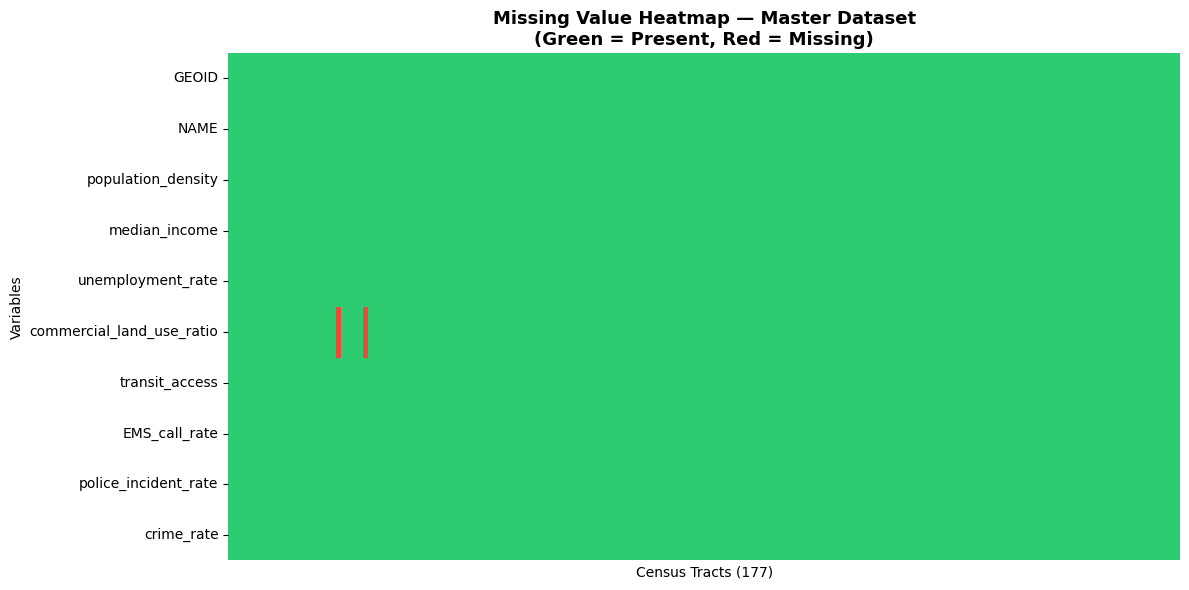

In [ ]:

# Create binary missing indicator matrix
missing_matrix = df_master.drop(columns='geometry').isna()

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    missing_matrix.T,
    cmap=['#2ECC71', '#E74C3C'],
    cbar=False,
    ax=ax,
    yticklabels=True,
    xticklabels=False
)
ax.set_title('Missing Value Heatmap — Master Dataset\n'
             '(Green = Present, Red = Missing)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Census Tracts (177)')
ax.set_ylabel('Variables')
plt.tight_layout()
plt.show()

### 3.2.4 Decide on Missing Value Strategy — Drop Tracts or Impute

In [ ]:
# Only commercial_land_use_ratio has 2 missing values (1.1%).
# Decision: Impute with Seattle median — dropping 2 tracts would
# reduce our already small n=177 unnecessarily, and median
# imputation is consistent with our Phase 2 strategy.
missing_cols = missing[missing > 0]
print(f'Columns requiring imputation:')
print(missing_cols)

for col in missing_cols.index:
    col_median = df_master[col].median()
    df_master[col] = df_master[col].fillna(col_median)
    print(f'\nImputed {col} with Seattle median: {col_median:.4f}')

print(f'\nMissing values after imputation:')
print(df_master.drop(columns='geometry').isna().sum())

Columns requiring imputation:
commercial_land_use_ratio    2
dtype: int64

Imputed commercial_land_use_ratio with Seattle median: 0.1795

Missing values after imputation:
GEOID                        0
NAME                         0
population_density           0
median_income                0
unemployment_rate            0
commercial_land_use_ratio    0
transit_access               0
EMS_call_rate                0
police_incident_rate         0
crime_rate                   0
dtype: int64


### 3.2.5 Check for Duplicate GEOIDs

In [ ]:
duplicate_geoids = df_master['GEOID'].duplicated().sum()
print(f'Duplicate GEOIDs: {duplicate_geoids}')

if duplicate_geoids == 0:
    print('✅ All GEOIDs are unique — one row per Seattle census tract')
else:
    print('⚠️ Duplicate GEOIDs detected — investigate before modeling')
    print(df_master[df_master['GEOID'].duplicated(keep=False)]['GEOID'])

Duplicate GEOIDs: 0
✅ All GEOIDs are unique — one row per Seattle census tract


### 3.2.6 Summary Statistics for All Variables

In [ ]:
print('Master Dataset — Summary Statistics')
print('='*60)
df_master.drop(columns=['GEOID', 'NAME', 'geometry']).describe().round(2)

Master Dataset — Summary Statistics


population_density  median_income  unemployment_rate  \
count            177.0000       177.0000           177.0000   
mean              26.3300    120618.0100             0.0400   
std               25.6600     42672.7600             0.0300   
min                1.3500     19375.0000             0.0000   
25%               11.1800     94432.0000             0.0200   
50%               17.8400    121182.0000             0.0300   
75%               29.6700    145438.0000             0.0500   
max              203.4200    250000.0000             0.1800   

       commercial_land_use_ratio  transit_access  EMS_call_rate  \
count                   177.0000        177.0000       177.0000   
mean                      0.3100         39.9800        14.4300   
std                       0.3200         33.5600        14.5600   
min                       0.0000          0.0000         1.3600   
25%                       0.0300         19.5400         7.3100   
50%                       0.1800         29.8800        10.5300   
75%                       0.5100         48.3000        16.3000   
max                       1.0000        212.8000       146.8400   

       police_incident_rate  crime_rate  
count              177.0000    177.0000  
mean                88.6400     59.0800  
std                 88.3500     52.3300  
min                 10.0800      6.8100  
25%                 43.3400     30.5300  
50%                 68.6200     45.4300  
75%                102.1000     69.6700  
max                766.1200    378.1900

The master dataset summary statistics confirm complete data across all 177
Seattle census tracts with no missing values. Key observations: population
density ranges from 1.35 to 203.42 people per acre reflecting Seattle's
mix of low-density residential and high-density urban tracts; median income
spans $19,375 to $250,000 with a mean of $120,618; unemployment rate ranges
from 0% to 18% with a mean of 4%; commercial land use ratio ranges from 0
to 1 with a mean of 0.31; transit access ranges from 0 to 212.80 stops per
square mile; EMS call rate ranges from 1.36 to 146.84 per 1,000 residents;
police incident rate ranges from 10.08 to 766.12 per 1,000 residents; and
the dependent variable crime rate ranges from 6.81 to 378.19 per 1,000
residents with a mean of 59.08. The wide ranges and large standard
deviations across most variables confirm substantial spatial variation
across Seattle tracts, a necessary condition for meaningful regression
modeling in Phase 5.

## 3.3 Master Dataset Finalization
### 3.3.1 Drop or Impute Remaining Missing Values

In [ ]:
# After imputation in 3.2.4, all missing values should already
# be resolved. This step is a final verification check before
# saving to confirm no missing values remain in any column.
missing_final = df_master.drop(columns='geometry').isna().sum()
print(f'Final missing value check:')
print(missing_final)
print(f'\nTotal missing cells: {missing_final.sum()}')

if missing_final.sum() == 0:
    print('\n✅ No missing values — dataset is clean and ready to save')
else:
    print('\n⚠️ Missing values remain — imputing with column medians')
    for col in missing_final[missing_final > 0].index:
        col_median = df_master[col].median()
        df_master[col] = df_master[col].fillna(col_median)
        print(f'Imputed {col} with median: {col_median:.4f}')

Final missing value check:
GEOID                        0
NAME                         0
population_density           0
median_income                0
unemployment_rate            0
commercial_land_use_ratio    0
transit_access               0
EMS_call_rate                0
police_incident_rate         0
crime_rate                   0
dtype: int64

Total missing cells: 0

✅ No missing values — dataset is clean and ready to save


### 3.3.2 Save Master Dataset to CSV — Processed Data

In [ ]:
# Drop geometry before saving to CSV — geometry is not
# compatible with CSV format and is saved separately in 3.3.3
df_master_csv = df_master.drop(columns='geometry').copy()

df_master_csv.to_csv('master_dataset.csv', index=False)

print(f'✅ CSV saved: master_dataset.csv')
print(f'Shape: {df_master_csv.shape}')
print(f'Columns: {df_master_csv.columns.tolist()}')

✅ CSV saved: master_dataset.csv
Shape: (177, 10)
Columns: ['GEOID', 'NAME', 'population_density', 'median_income', 'unemployment_rate', 'commercial_land_use_ratio', 'transit_access', 'EMS_call_rate', 'police_incident_rate', 'crime_rate']


### 3.3.3 Save Master GeoDataFrame with Geometry — for Spatial Analysis

In [ ]:
# Save as GeoJSON for use in Phase 4 spatial analysis and
# Phase 6 choropleth mapping. Reproject to EPSG:4326 (WGS84)
# for GeoJSON compatibility — GeoJSON standard requires WGS84.
gdf_master = gpd.GeoDataFrame(
    df_master, geometry='geometry', crs=TARGET_CRS
)

# Reproject to WGS84 for GeoJSON
gdf_master_wgs84 = gdf_master.to_crs('EPSG:4326')

gdf_master_wgs84.to_file('master_dataset.geojson', driver='GeoJSON')

print(f'✅ GeoJSON saved: master_dataset.geojson')
print(f'Shape:  {gdf_master_wgs84.shape}')
print(f'CRS:    {gdf_master_wgs84.crs}')

✅ GeoJSON saved: master_dataset.geojson
Shape:  (177, 11)
CRS:    EPSG:4326


### 3.3.4 Final Preview of Master Dataset

In [ ]:
print(f'{"="*60}')
print(f'MASTER DATASET — FINAL PREVIEW')
print(f'{"="*60}')
print(f'\nShape:   {df_master_csv.shape}')
print(f'Rows:    {len(df_master_csv):,} Seattle census tracts')
print(f'Columns: {len(df_master_csv.columns)} variables')
print(f'\nColumn list:')
for i, col in enumerate(df_master_csv.columns, 1):
    print(f'  {i:2}. {col}')
print(f'\nMissing values: {df_master_csv.isna().sum().sum()}')
print(f'\nSample output:')
df_master_csv.head(10)

MASTER DATASET — FINAL PREVIEW

Shape:   (177, 10)
Rows:    177 Seattle census tracts
Columns: 10 variables

Column list:
   1. GEOID
   2. NAME
   3. population_density
   4. median_income
   5. unemployment_rate
   6. commercial_land_use_ratio
   7. transit_access
   8. EMS_call_rate
   9. police_incident_rate
  10. crime_rate

Missing values: 0

Sample output:


GEOID    NAME  population_density  median_income  unemployment_rate  \
0  53033005304   53.04            203.4238     19375.0000             0.1760   
1  53033005901   59.01             17.8596    150500.0000             0.0587   
2  53033005401   54.01             20.6662    135881.0000             0.0174   
3  53033010102  101.02             10.9831    143750.0000             0.0251   
4  53033000602    6.02              6.8545     96795.0000             0.0377   
5  53033008003   80.03             87.0762     97159.0000             0.0155   
6  53033004102   41.02             10.2473    196728.0000             0.0352   
7  53033010302  103.02             25.5447    121362.0000             0.0124   
8  53033007001   70.01             42.1146     68821.0000             0.1026   
9  53033003601   36.01             23.4032    117672.0000             0.0277   

   commercial_land_use_ratio  transit_access  EMS_call_rate  \
0                     0.7678        212.7994         1.3620   
1                     0.0471         29.5613         4.3666   
2                     0.4205         16.9348         5.1788   
3                     0.1530          6.8280        23.1535   
4                     0.5067         30.0836        27.3194   
5                     1.0000         65.6876        32.5309   
6                     0.0337          6.9681         8.8803   
7                     0.2105         36.8739         8.7711   
8                     0.6103         65.0640        10.4598   
9                     0.2820         42.2640         5.3866   

   police_incident_rate  crime_rate  
0               10.0790      6.8101  
1               56.4747     44.2482  
2              114.4514     88.8164  
3              142.0987    115.9943  
4              227.0764    149.6298  
5              143.7961     82.0345  
6               25.7063     19.8639  
7               72.1735     55.8844  
8               72.6825     49.3490  
9               47.4531     36.9365

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_master_csv)

https://docs.google.com/spreadsheets/d/1LgGQlofacHwngAYrIQ3oWMBBfb5YJthOF5GKHjNDsHg/edit#gid=0


## 3.3.5 Save files to my directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then update your save paths
df_master_csv.to_csv(
    '/content/drive/MyDrive/master_dataset.csv', index=False
)
gdf_master_wgs84.to_file(
    '/content/drive/MyDrive/master_dataset.geojson', driver='GeoJSON'
)
print('✅ Saved to Google Drive')

Mounted at /content/drive
✅ Saved to Google Drive


In [ ]:
# download to local PC
from google.colab import files
files.download('master_dataset.csv')
files.download('master_dataset.geojson')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
# PHASE 4: ADVANCED EXPLORATORY DATA ANALYSIS
---

In [ ]:
# Load master dataset from GitHub
MASTER_CSV_URL = f'{GITHUB_RAW_BASE}/data/processed/master_dataset.csv'
MASTER_GEOJSON_URL = f'{GITHUB_RAW_BASE}/data/processed/master_dataset.geojson'

df_master = pd.read_csv(MASTER_CSV_URL)
gdf_master = gpd.read_file(MASTER_GEOJSON_URL)

print(f'Master CSV loaded:     {df_master.shape}')
print(f'Master GeoJSON loaded: {gdf_master.shape}')
print(f'CRS: {gdf_master.crs}')

Master CSV loaded:     (177, 10)
Master GeoJSON loaded: (177, 11)
CRS: EPSG:4326


## 4.1 Univariate Analysis — Distribution of Each Variable
### 4.1.1 Crime Rate Distribution — Histogram and Boxplot

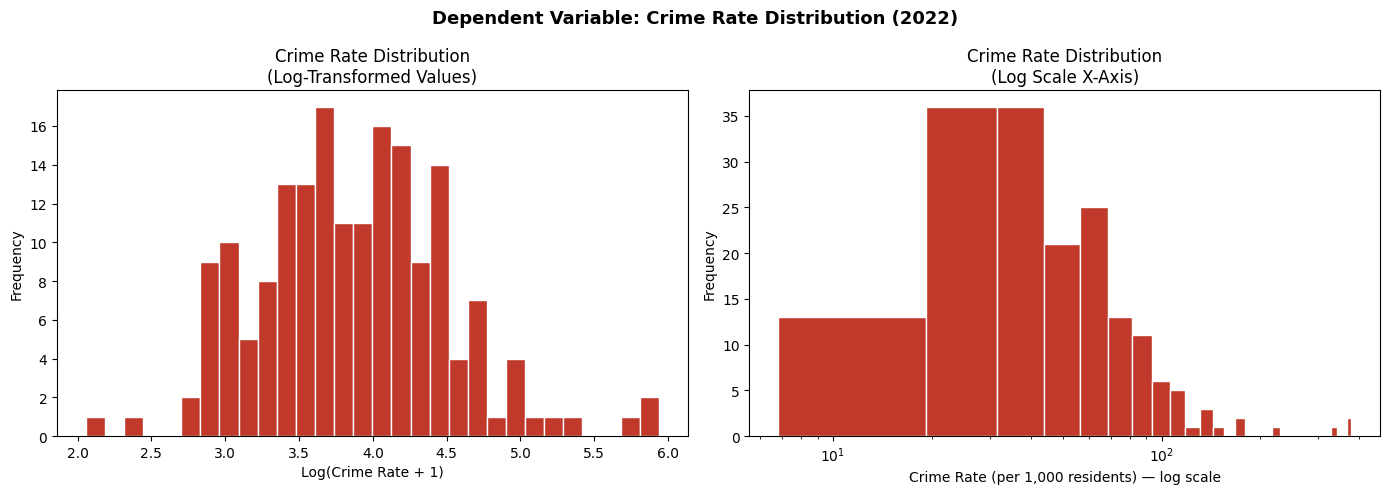

Mean:                59.08
Median:              45.43
Std:                 52.33
Skewness (original): 3.70
Skewness (log):      0.39
Min:                 6.81
Max:                 378.19


In [ ]:
# 4.1.1 Crime Rate Distribution — Log Transformed
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left — Log-transformed histogram
axes[0].hist(np.log1p(df_master['crime_rate']), bins=30,
             color='#C0392B', edgecolor='white')
axes[0].set_title('Crime Rate Distribution\n(Log-Transformed Values)')
axes[0].set_xlabel('Log(Crime Rate + 1)')
axes[0].set_ylabel('Frequency')

# Right — Original scale log x-axis
axes[1].hist(df_master['crime_rate'], bins=30,
             color='#C0392B', edgecolor='white')
axes[1].set_xscale('log')
axes[1].set_title('Crime Rate Distribution\n(Log Scale X-Axis)')
axes[1].set_xlabel('Crime Rate (per 1,000 residents) — log scale')
axes[1].set_ylabel('Frequency')

plt.suptitle('Dependent Variable: Crime Rate Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Mean:                {df_master["crime_rate"].mean():.2f}')
print(f'Median:              {df_master["crime_rate"].median():.2f}')
print(f'Std:                 {df_master["crime_rate"].std():.2f}')
print(f'Skewness (original): {df_master["crime_rate"].skew():.2f}')
print(f'Skewness (log):      {np.log1p(df_master["crime_rate"]).skew():.2f}')
print(f'Min:                 {df_master["crime_rate"].min():.2f}')
print(f'Max:                 {df_master["crime_rate"].max():.2f}')

Crime rate across Seattle's 177 census tracts is strongly right-skewed
with an original skewness of 3.70, ranging from 6.81 to 378.19 serious
crimes per 1,000 residents with a mean of 59.08 and median of 45.43.
The log-transformed histogram reveals a near-normal distribution shape
hidden by the skew, confirming that a log transformation of the dependent
variable will be evaluated in Phase 5 to meet OLS normality assumptions.
The log scale x-axis plot confirms that the majority of tracts fall between
10 and 100 crimes per 1,000 residents with only a small number of extreme
outliers above 200, likely Downtown and high-activity commercial tracts
whose large daytime populations are not captured in residential census counts.

### 4.1.2 Population Density Distribution

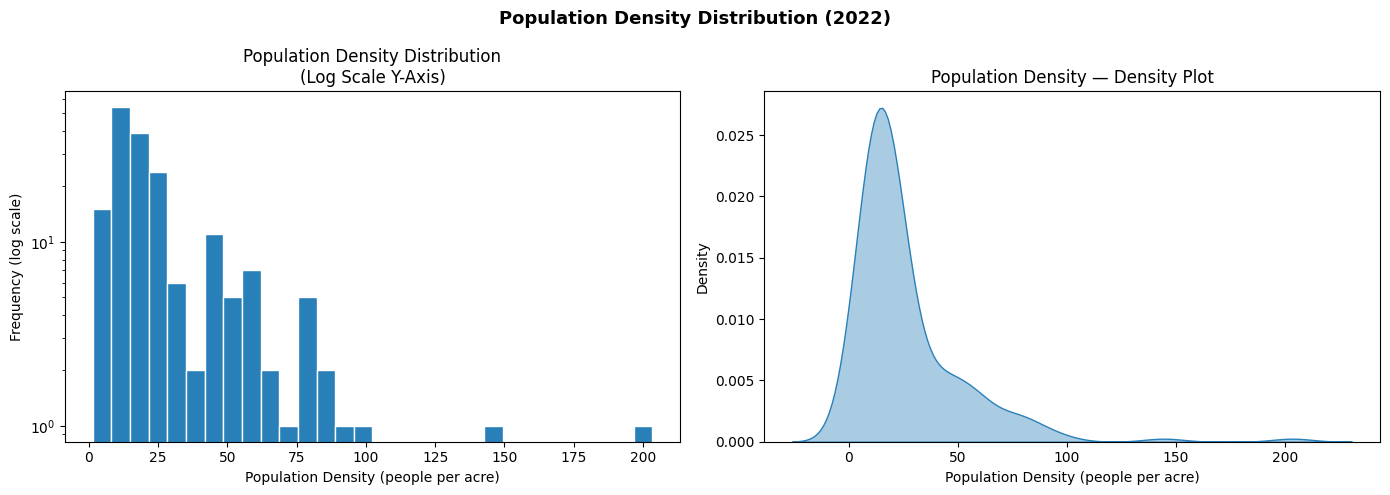

Mean:     26.33
Median:   17.84
Skewness: 3.09


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_master['population_density'], bins=30,
             color='#2980B9', edgecolor='white')
axes[0].set_yscale('log')
axes[0].set_title('Population Density Distribution\n(Log Scale Y-Axis)')
axes[0].set_xlabel('Population Density (people per acre)')
axes[0].set_ylabel('Frequency (log scale)')

sns.kdeplot(df_master['population_density'], ax=axes[1],
            color='#2980B9', fill=True, alpha=0.4)
axes[1].set_title('Population Density — Density Plot')
axes[1].set_xlabel('Population Density (people per acre)')
axes[1].set_ylabel('Density')

plt.suptitle('Population Density Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Mean:     {df_master["population_density"].mean():.2f}')
print(f'Median:   {df_master["population_density"].median():.2f}')
print(f'Skewness: {df_master["population_density"].skew():.2f}')

Strongly right-skewed (3.09); the majority of Seattle tracts have
densities between 5–30 people per acre, reflecting typical residential
neighborhoods, while a small number of high-density urban core tracts
exceed 100 people per acre. Log transformation required before modeling.

### 4.1.3 Median Income Distribution

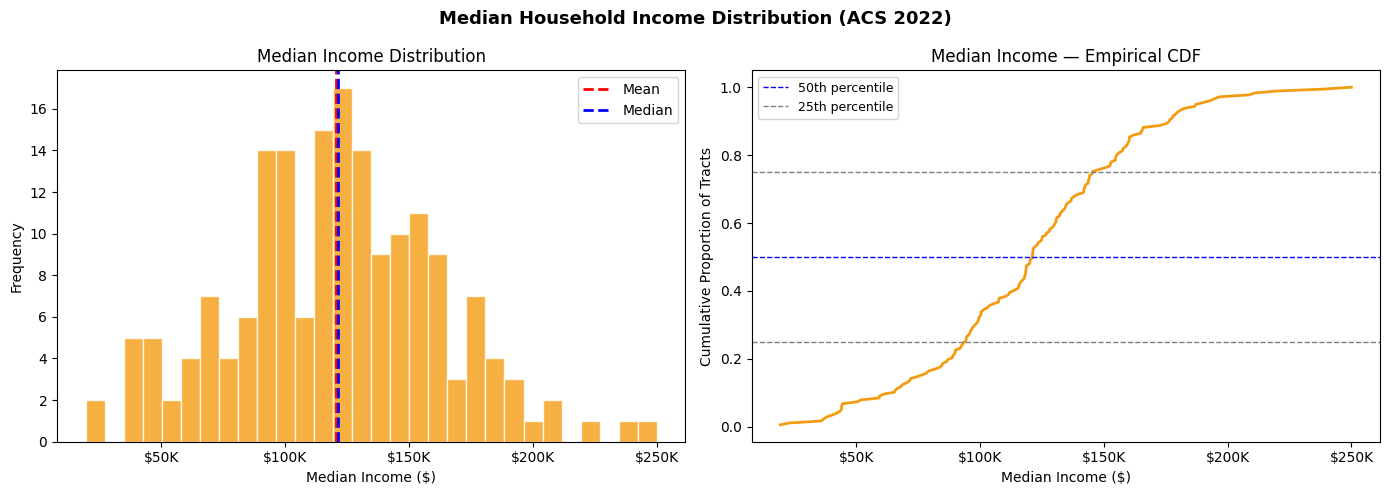

Mean:     $120,618
Median:   $121,182
Skewness: 0.09


In [ ]:
# Median Income — Near normal, histogram + empirical CDF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with mean and median lines
axes[0].hist(df_master['median_income'], bins=30,
             color='#F39C12', edgecolor='white', alpha=0.8)
axes[0].axvline(df_master['median_income'].mean(),
                color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_master['median_income'].median(),
                color='blue', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].set_title('Median Income Distribution')
axes[0].set_xlabel('Median Income ($)')
axes[0].set_ylabel('Frequency')
axes[0].xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Empirical CDF
sorted_income = np.sort(df_master['median_income'])
cdf = np.arange(1, len(sorted_income)+1) / len(sorted_income)
axes[1].plot(sorted_income, cdf, color='#F39C12', linewidth=2)
axes[1].axhline(0.5, color='blue', linestyle='--',
                linewidth=1, label='50th percentile')
axes[1].axhline(0.25, color='gray', linestyle='--',
                linewidth=1, label='25th percentile')
axes[1].axhline(0.75, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('Median Income — Empirical CDF')
axes[1].set_xlabel('Median Income ($)')
axes[1].set_ylabel('Cumulative Proportion of Tracts')
axes[1].legend(fontsize=9)
axes[1].xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.suptitle('Median Household Income Distribution (ACS 2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Mean:     ${df_master["median_income"].mean():,.0f}')
print(f'Median:   ${df_master["median_income"].median():,.0f}')
print(f'Skewness: {df_master["median_income"].skew():.2f}')

Nearly symmetric (skewness 0.09) with mean (120,618) and median
(121,182) almost identical, confirming a well-behaved normal-like
distribution centered around 120K. The ECDF shows a smooth S-curve
with 50% of tracts falling below 121K and 25% below roughly 94K.
No transformation needed.

### 4.1.4 Unemployment Rate Distribution

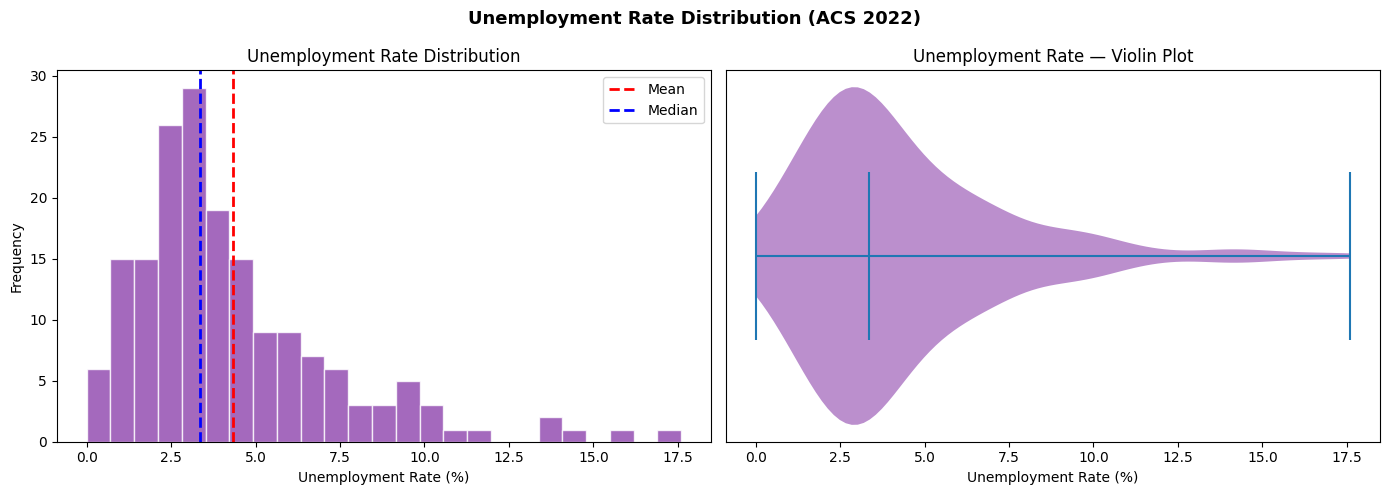

Mean:     4.34%
Median:   3.36%
Skewness: 1.65


In [ ]:
# Unemployment Rate — Right skewed, violin + strip plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_master['unemployment_rate'] * 100, bins=25,
             color='#8E44AD', edgecolor='white', alpha=0.8)
axes[0].axvline(df_master['unemployment_rate'].mean() * 100,
                color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_master['unemployment_rate'].median() * 100,
                color='blue', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].set_title('Unemployment Rate Distribution')
axes[0].set_xlabel('Unemployment Rate (%)')
axes[0].set_ylabel('Frequency')

# Violin plot
parts = axes[1].violinplot(
    df_master['unemployment_rate'] * 100,
    vert=False,
    showmedians=True,
    showextrema=True
)
for pc in parts['bodies']:
    pc.set_facecolor('#8E44AD')
    pc.set_alpha(0.6)
axes[1].set_title('Unemployment Rate — Violin Plot')
axes[1].set_xlabel('Unemployment Rate (%)')
axes[1].set_yticks([])

plt.suptitle('Unemployment Rate Distribution (ACS 2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Mean:     {df_master["unemployment_rate"].mean()*100:.2f}%')
print(f'Median:   {df_master["unemployment_rate"].median()*100:.2f}%')
print(f'Skewness: {df_master["unemployment_rate"].skew():.2f}')

Right-skewed (1.65) with most tracts clustered between 2–5%, the
histogram and violin plot both confirm the bulk of Seattle tracts have
low unemployment with a long right tail driven by a small number of
high-unemployment tracts reaching 17.5%. The mean (4.34%) sits visibly
to the right of the median (3.36%) confirming the skew.

### 4.1.5 Commercial Land Use Ratio Distribution

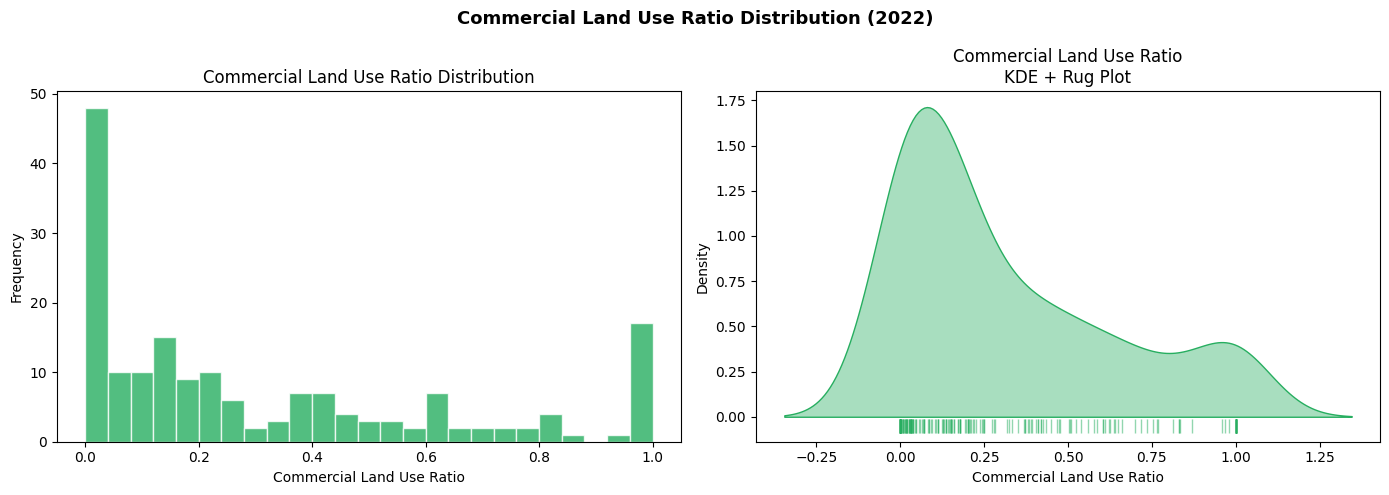

Mean:     0.3121
Median:   0.1795
Skewness: 0.96
Tracts with ratio = 0:   14
Tracts with ratio = 1:   15


In [ ]:
# Commercial Land Use Ratio — Bimodal, histogram + rug plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_master['commercial_land_use_ratio'], bins=25,
             color='#27AE60', edgecolor='white', alpha=0.8)
axes[0].set_title('Commercial Land Use Ratio Distribution')
axes[0].set_xlabel('Commercial Land Use Ratio')
axes[0].set_ylabel('Frequency')

# KDE with rug plot to show bimodal structure
sns.kdeplot(df_master['commercial_land_use_ratio'],
            ax=axes[1], color='#27AE60', fill=True, alpha=0.4)
axes[1].plot(df_master['commercial_land_use_ratio'],
             np.zeros_like(df_master['commercial_land_use_ratio']) - 0.05,
             '|', color='#27AE60', alpha=0.5, markersize=10)
axes[1].set_title('Commercial Land Use Ratio\nKDE + Rug Plot')
axes[1].set_xlabel('Commercial Land Use Ratio')
axes[1].set_ylabel('Density')

plt.suptitle('Commercial Land Use Ratio Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Mean:     {df_master["commercial_land_use_ratio"].mean():.4f}')
print(f'Median:   {df_master["commercial_land_use_ratio"].median():.4f}')
print(f'Skewness: {df_master["commercial_land_use_ratio"].skew():.2f}')
print(f'Tracts with ratio = 0:   {(df_master["commercial_land_use_ratio"] == 0).sum()}')
print(f'Tracts with ratio = 1:   {(df_master["commercial_land_use_ratio"] == 1).sum()}')

Bimodal distribution with two distinct spikes, a dominant spike at 0
(48 purely residential tracts with no commercial land) and a secondary
spike at 1.0 (17 entirely commercial tracts). The KDE + rug plot
confirms this U-shaped pattern clearly. Most tracts fall below 0.25
commercial ratio with sparse coverage across the middle range.

### 4.1.6 Transit Access Distribution

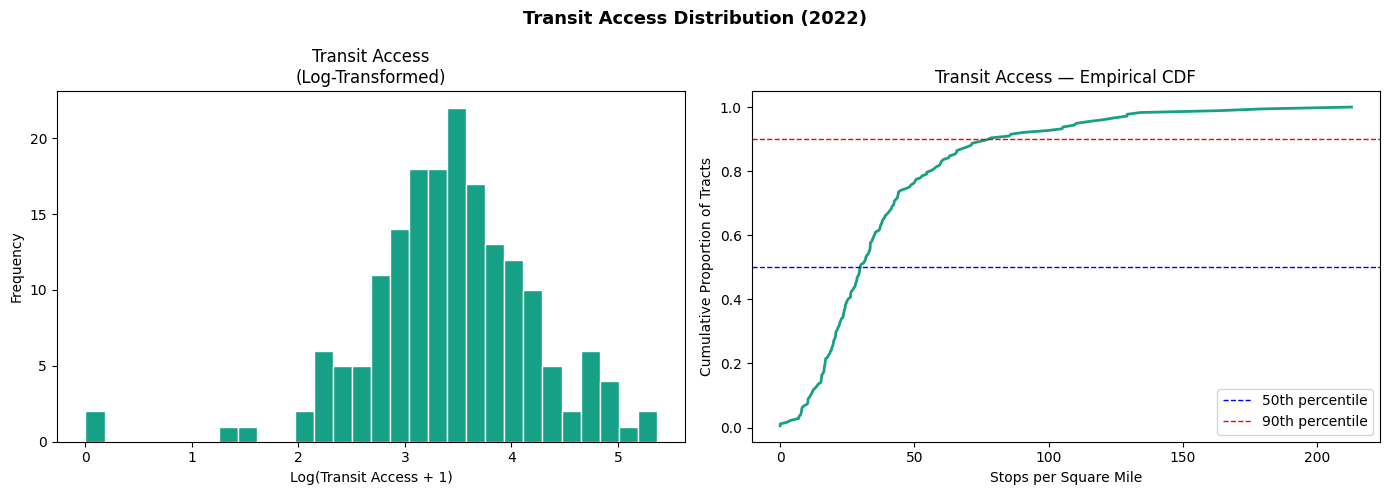

Skewness (original): 2.21
Skewness (log):      -0.78
Mean:   39.98
Median: 29.88
90th percentile: 77.70


In [ ]:
# Transit Access — Right skewed, log transform + ECDF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.log1p(df_master['transit_access']), bins=30,
             color='#16A085', edgecolor='white')
axes[0].set_title('Transit Access\n(Log-Transformed)')
axes[0].set_xlabel('Log(Transit Access + 1)')
axes[0].set_ylabel('Frequency')

sorted_transit = np.sort(df_master['transit_access'])
cdf = np.arange(1, len(sorted_transit)+1) / len(sorted_transit)
axes[1].plot(sorted_transit, cdf, color='#16A085', linewidth=2)
axes[1].axhline(0.5, color='blue', linestyle='--',
                linewidth=1, label='50th percentile')
axes[1].axhline(0.9, color='red', linestyle='--',
                linewidth=1, label='90th percentile')
axes[1].legend()
axes[1].set_title('Transit Access — Empirical CDF')
axes[1].set_xlabel('Stops per Square Mile')
axes[1].set_ylabel('Cumulative Proportion of Tracts')

plt.suptitle('Transit Access Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Skewness (original): {df_master["transit_access"].skew():.2f}')
print(f'Skewness (log):      {np.log1p(df_master["transit_access"]).skew():.2f}')
print(f'Mean:   {df_master["transit_access"].mean():.2f}')
print(f'Median: {df_master["transit_access"].median():.2f}')
print(f'90th percentile: {df_master["transit_access"].quantile(0.9):.2f}')

Right-skewed (2.21) but log transformation reveals a near-normal
distribution. The ECDF shows 50% of tracts have fewer than ~30 stops
per square mile and 90% have fewer than ~100, confirming that
high-density transit coverage is concentrated in a small number of
urban core tracts while most Seattle tracts have moderate access.

### 4.1.7 EMS Call Rate Distribution

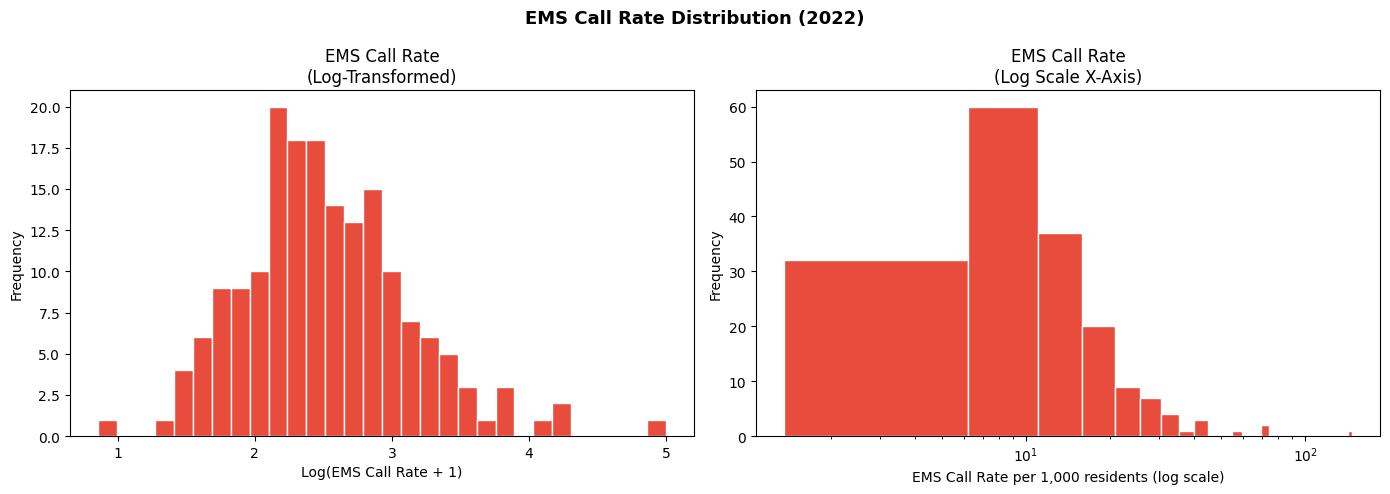

Skewness (original): 5.28
Skewness (log):      0.67
Mean:   14.43
Median: 10.53
90th percentile: 25.87
Max:    146.84


In [ ]:
# EMS Call Rate — Extreme skew, log transform + percentile table
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.log1p(df_master['EMS_call_rate']), bins=30,
             color='#E74C3C', edgecolor='white')
axes[0].set_title('EMS Call Rate\n(Log-Transformed)')
axes[0].set_xlabel('Log(EMS Call Rate + 1)')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_master['EMS_call_rate'], bins=30,
             color='#E74C3C', edgecolor='white')
axes[1].set_xscale('log')
axes[1].set_title('EMS Call Rate\n(Log Scale X-Axis)')
axes[1].set_xlabel('EMS Call Rate per 1,000 residents (log scale)')
axes[1].set_ylabel('Frequency')

plt.suptitle('EMS Call Rate Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Skewness (original): {df_master["EMS_call_rate"].skew():.2f}')
print(f'Skewness (log):      {np.log1p(df_master["EMS_call_rate"]).skew():.2f}')
print(f'Mean:   {df_master["EMS_call_rate"].mean():.2f}')
print(f'Median: {df_master["EMS_call_rate"].median():.2f}')
print(f'90th percentile: {df_master["EMS_call_rate"].quantile(0.9):.2f}')
print(f'Max:    {df_master["EMS_call_rate"].max():.2f}')

Extremely right-skewed (5.28), the most skewed variable in the dataset.
The log-transformed histogram reveals a near-normal shape hidden by the
extreme outliers. The log scale x-axis confirms the vast majority of
tracts fall between 5–20 calls per 1,000 residents with a small number
of outlier tracts exceeding 100. Log transformation essential.

### 4.1.8 Police Incident Rate Distribution

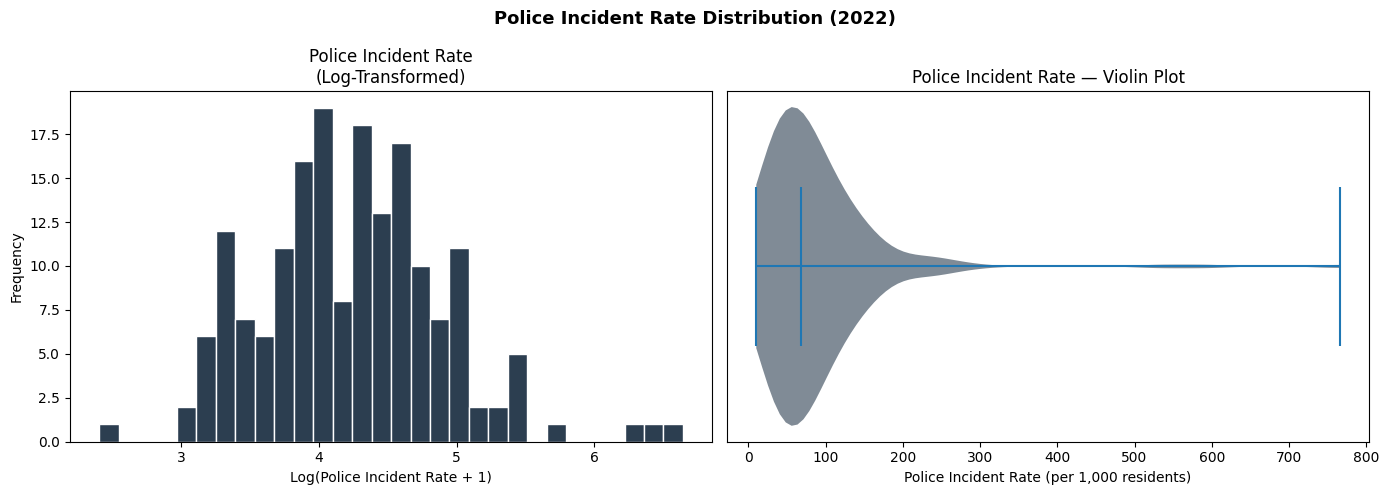

Skewness (original): 4.56
Skewness (log):      0.49
Mean:   88.64
Median: 68.62
90th percentile: 153.31
Max:    766.12


In [ ]:
# Police Incident Rate — Extreme skew, log transform + violin
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.log1p(df_master['police_incident_rate']), bins=30,
             color='#2C3E50', edgecolor='white')
axes[0].set_title('Police Incident Rate\n(Log-Transformed)')
axes[0].set_xlabel('Log(Police Incident Rate + 1)')
axes[0].set_ylabel('Frequency')

parts = axes[1].violinplot(
    df_master['police_incident_rate'],
    vert=False,
    showmedians=True,
    showextrema=True
)
for pc in parts['bodies']:
    pc.set_facecolor('#2C3E50')
    pc.set_alpha(0.6)
axes[1].set_title('Police Incident Rate — Violin Plot')
axes[1].set_xlabel('Police Incident Rate (per 1,000 residents)')
axes[1].set_yticks([])

plt.suptitle('Police Incident Rate Distribution (2022)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Skewness (original): {df_master["police_incident_rate"].skew():.2f}')
print(f'Skewness (log):      {np.log1p(df_master["police_incident_rate"]).skew():.2f}')
print(f'Mean:   {df_master["police_incident_rate"].mean():.2f}')
print(f'Median: {df_master["police_incident_rate"].median():.2f}')
print(f'90th percentile: {df_master["police_incident_rate"].quantile(0.9):.2f}')
print(f'Max:    {df_master["police_incident_rate"].max():.2f}')

Extremely right-skewed (4.56), the log-transformed histogram shows a
broad but roughly normal shape centered around log(4)–log(5),
corresponding to roughly 50–150 incidents per 1,000 residents. The
violin plot dramatically illustrates the extreme outliers, the long thin
tail extending to 766 incidents per 1,000 residents is entirely driven by
2–3 Downtown tracts with disproportionately high activity relative to
their residential populations. Log transformation essential.

### 4.1.9 Check Skewness — Flag Variables Needing Log Transformation

In [ ]:
variables = [
    'crime_rate', 'population_density', 'median_income',
    'unemployment_rate', 'commercial_land_use_ratio',
    'transit_access', 'EMS_call_rate', 'police_incident_rate'
]

print(f'{"Variable":<30} {"Skewness":>10} {"Flag":>20}')
print('='*62)

skewness_results = []
for var in variables:
    skew = df_master[var].skew()
    flag = '⚠️ Log transform recommended' if abs(skew) > 1 else '✅ Acceptable'
    skewness_results.append({
        'variable': var,
        'skewness': skew,
        'flag': flag
    })
    print(f'{var:<30} {skew:>10.2f} {flag:>20}')

df_skewness = pd.DataFrame(skewness_results)

Variable                         Skewness                 Flag
crime_rate                           3.70 ⚠️ Log transform recommended
population_density                   3.09 ⚠️ Log transform recommended
median_income                        0.09         ✅ Acceptable
unemployment_rate                    1.65 ⚠️ Log transform recommended
commercial_land_use_ratio            0.96         ✅ Acceptable
transit_access                       2.21 ⚠️ Log transform recommended
EMS_call_rate                        5.28 ⚠️ Log transform recommended
police_incident_rate                 4.56 ⚠️ Log transform recommended


## 4.2 Bivariate Analysis — Each Predictor vs Crime Rate
### 4.2.1 Population Density vs Crime Rate. log-log scatter with marginal histograms showing both distributions simultaneously

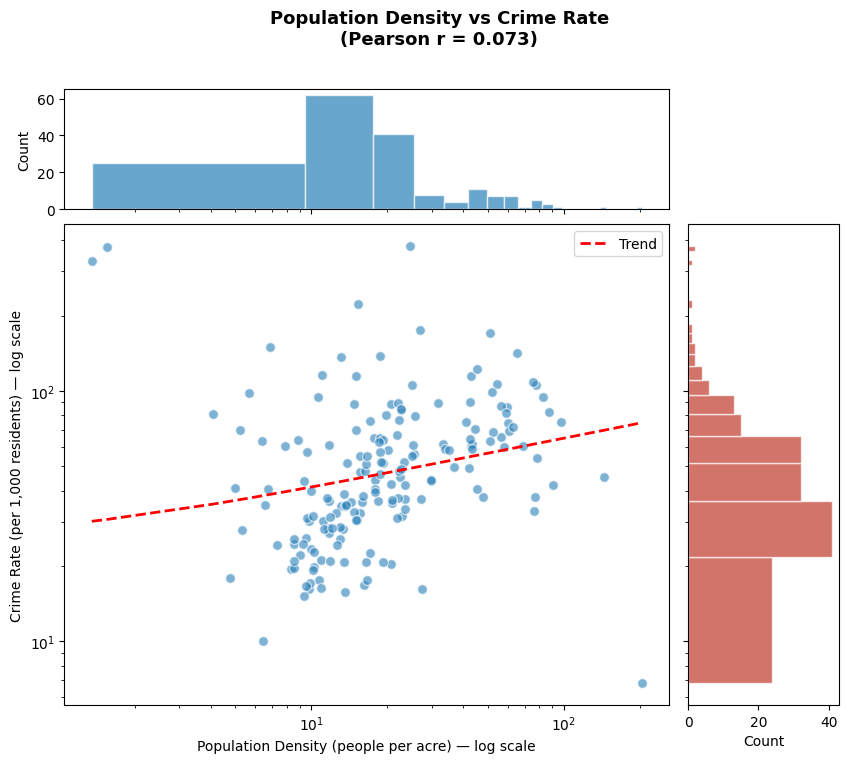

Pearson r: 0.0731


In [ ]:
# 4.2.1 Population Density vs Crime Rate
# Both skewed — use log-log scatter with marginal histograms
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                      hspace=0.05, wspace=0.05)

ax_main = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)

ax_main.scatter(df_master['population_density'], df_master['crime_rate'],
                color='#2980B9', alpha=0.6, edgecolor='white', s=50)
ax_main.set_xscale('log')
ax_main.set_yscale('log')

z = np.polyfit(np.log1p(df_master['population_density']),
               np.log1p(df_master['crime_rate']), 1)
p = np.poly1d(z)
x_sorted = np.sort(df_master['population_density'])
ax_main.plot(x_sorted, np.expm1(p(np.log1p(x_sorted))),
             color='red', linewidth=2, linestyle='--', label=f'Trend')
ax_main.set_xlabel('Population Density (people per acre) — log scale')
ax_main.set_ylabel('Crime Rate (per 1,000 residents) — log scale')
ax_main.legend()

ax_top.hist(df_master['population_density'], bins=25,
            color='#2980B9', edgecolor='white', alpha=0.7)
ax_top.set_xscale('log')
ax_top.set_ylabel('Count')
plt.setp(ax_top.get_xticklabels(), visible=False)

ax_right.hist(df_master['crime_rate'], bins=25,
              color='#C0392B', edgecolor='white', alpha=0.7,
              orientation='horizontal')
ax_right.set_yscale('log')
ax_right.set_xlabel('Count')
plt.setp(ax_right.get_yticklabels(), visible=False)

corr = df_master['population_density'].corr(df_master['crime_rate'])
fig.suptitle(f'Population Density vs Crime Rate\n(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.show()
print(f'Pearson r: {corr:.4f}')

Near-zero correlation; population density has virtually no linear
relationship with crime rate. The log-log scatter shows wide vertical
spread at every density level, confirming that densely populated tracts
are not systematically more or less crime-prone than sparse ones.

### 4.2.2 Median Income vs Crime Rate - hexbin density + quartile boxplots showing how crime shifts across income groups

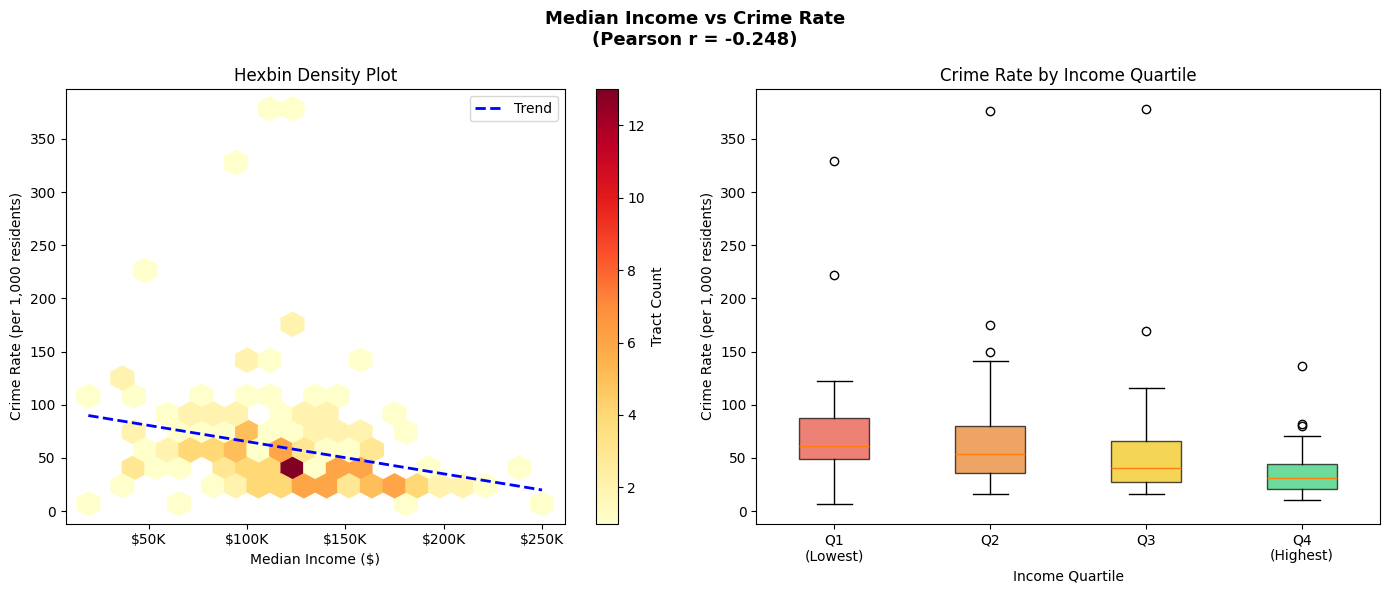

Pearson r: -0.2476


In [ ]:
# Income near-normal — use hexbin density plot to show concentration
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Hexbin density
hb = axes[0].hexbin(df_master['median_income'], df_master['crime_rate'],
                     gridsize=20, cmap='YlOrRd', mincnt=1)
plt.colorbar(hb, ax=axes[0], label='Tract Count')
z = np.polyfit(df_master['median_income'], df_master['crime_rate'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_master['median_income'].min(),
                      df_master['median_income'].max(), 100)
axes[0].plot(x_line, p(x_line), color='blue',
             linewidth=2, linestyle='--', label='Trend')
axes[0].set_xlabel('Median Income ($)')
axes[0].set_ylabel('Crime Rate (per 1,000 residents)')
axes[0].set_title('Hexbin Density Plot')
axes[0].xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[0].legend()

# Income quartile boxplot
df_master['income_quartile'] = pd.qcut(
    df_master['median_income'], q=4,
    labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4\n(Highest)']
)
quartile_data = [df_master[df_master['income_quartile'] == q]['crime_rate'].values
                 for q in ['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4\n(Highest)']]
bp = axes[1].boxplot(quartile_data, patch_artist=True,
                      labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4\n(Highest)'])
colors = ['#E74C3C', '#E67E22', '#F1C40F', '#2ECC71']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel('Income Quartile')
axes[1].set_ylabel('Crime Rate (per 1,000 residents)')
axes[1].set_title('Crime Rate by Income Quartile')

corr = df_master['median_income'].corr(df_master['crime_rate'])
fig.suptitle(f'Median Income vs Crime Rate\n(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print(f'Pearson r: {corr:.4f}')

Weak negative relationship, higher income tracts tend toward lower
crime rates but with substantial overlap. The quartile boxplot clearly
shows a stepwise decline in median crime from Q1 ($70 median) to Q4
($30 median), though wide IQRs and outliers in every quartile indicate
income alone is a weak predictor of crime.

### 4.2.3 Unemployment Rate vs Crime Rate - log scatter + quintile bar chart showing mean crime per unemployment band

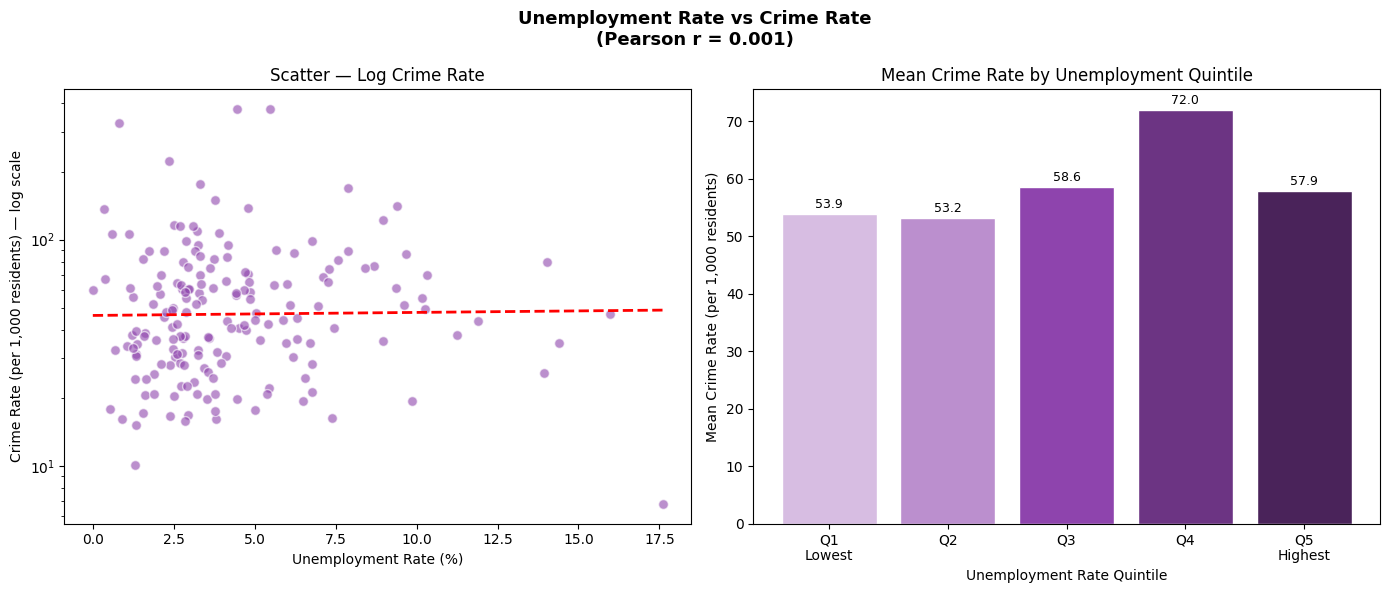

Pearson r: 0.0015


In [ ]:
# Both skewed — use log-transformed scatter + quintile bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter with log axes
axes[0].scatter(df_master['unemployment_rate'] * 100,
                df_master['crime_rate'],
                color='#8E44AD', alpha=0.6, edgecolor='white', s=50)
axes[0].set_yscale('log')
z = np.polyfit(df_master['unemployment_rate'] * 100,
               np.log1p(df_master['crime_rate']), 1)
p = np.poly1d(z)
x_line = np.linspace((df_master['unemployment_rate']*100).min(),
                      (df_master['unemployment_rate']*100).max(), 100)
axes[0].plot(x_line, np.expm1(p(x_line)),
             color='red', linewidth=2, linestyle='--')
axes[0].set_xlabel('Unemployment Rate (%)')
axes[0].set_ylabel('Crime Rate (per 1,000 residents) — log scale')
axes[0].set_title('Scatter — Log Crime Rate')

# Quintile mean bar chart
df_master['unemp_quintile'] = pd.qcut(
    df_master['unemployment_rate'], q=5,
    labels=['Q1\nLowest', 'Q2', 'Q3', 'Q4', 'Q5\nHighest']
)
quintile_means = df_master.groupby('unemp_quintile',
                                    observed=True)['crime_rate'].mean()
colors = ['#D7BDE2', '#BB8FCE', '#8E44AD', '#6C3483', '#4A235A']
axes[1].bar(quintile_means.index, quintile_means.values,
            color=colors, edgecolor='white')
axes[1].set_xlabel('Unemployment Rate Quintile')
axes[1].set_ylabel('Mean Crime Rate (per 1,000 residents)')
axes[1].set_title('Mean Crime Rate by Unemployment Quintile')
for i, v in enumerate(quintile_means.values):
    axes[1].text(i, v + 1, f'{v:.1f}', ha='center', fontsize=9)

corr = df_master['unemployment_rate'].corr(df_master['crime_rate'])
fig.suptitle(f'Unemployment Rate vs Crime Rate\n(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print(f'Pearson r: {corr:.4f}')

Essentially zero linear correlation — the scatter shows no directional
trend and the trend line is completely flat. Surprisingly the quintile
bar chart shows Q4 (72.0) slightly elevated above the others, suggesting
a possible non-linear relationship at very high unemployment levels, but
this is not captured by Pearson r.

### 4.2.4 Commercial Land Use Ratio vs Crime Rate - scatter + categorical boxplot grouping tracts into Low/Medium/High commercial

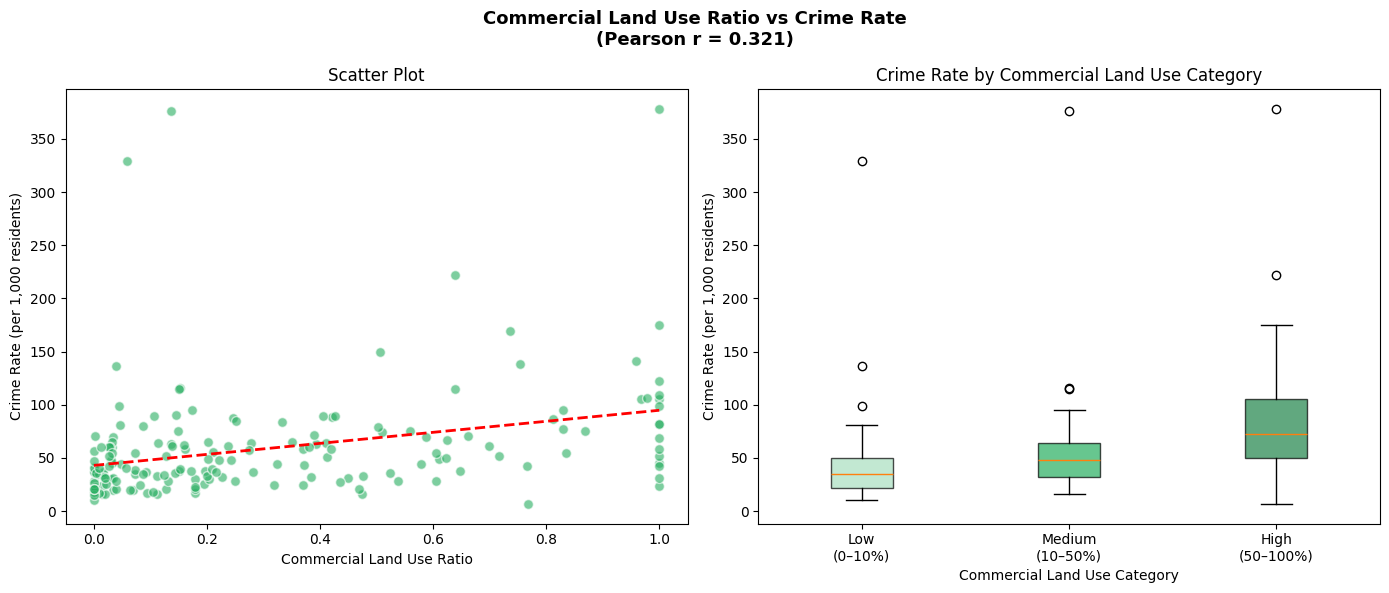

Pearson r: 0.3208


In [ ]:
# Bimodal predictor — use scatter + strip plot by category
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter
axes[0].scatter(df_master['commercial_land_use_ratio'],
                df_master['crime_rate'],
                color='#27AE60', alpha=0.6, edgecolor='white', s=50)
z = np.polyfit(df_master['commercial_land_use_ratio'],
               df_master['crime_rate'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_master['commercial_land_use_ratio'].min(),
                      df_master['commercial_land_use_ratio'].max(), 100)
axes[0].plot(x_line, p(x_line), color='red',
             linewidth=2, linestyle='--')
axes[0].set_xlabel('Commercial Land Use Ratio')
axes[0].set_ylabel('Crime Rate (per 1,000 residents)')
axes[0].set_title('Scatter Plot')

# Categorical boxplot — bin into Low / Medium / High commercial
df_master['commercial_cat'] = pd.cut(
    df_master['commercial_land_use_ratio'],
    bins=[-0.01, 0.1, 0.5, 1.0],
    labels=['Low\n(0–10%)', 'Medium\n(10–50%)', 'High\n(50–100%)']
)
cat_data = [df_master[df_master['commercial_cat'] == c]['crime_rate'].values
            for c in ['Low\n(0–10%)', 'Medium\n(10–50%)', 'High\n(50–100%)']]
bp = axes[1].boxplot(cat_data, patch_artist=True,
                      labels=['Low\n(0–10%)', 'Medium\n(10–50%)',
                              'High\n(50–100%)'])
colors_cat = ['#A9DFBF', '#27AE60', '#1E8449']
for patch, color in zip(bp['boxes'], colors_cat):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel('Commercial Land Use Category')
axes[1].set_ylabel('Crime Rate (per 1,000 residents)')
axes[1].set_title('Crime Rate by Commercial Land Use Category')

corr = df_master['commercial_land_use_ratio'].corr(df_master['crime_rate'])
fig.suptitle(f'Commercial Land Use Ratio vs Crime Rate\n'
             f'(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print(f'Pearson r: {corr:.4f}')

Moderate positive relationship — tracts with higher commercial land use
have higher crime rates. The categorical boxplot confirms this clearly —
median crime rises from ~35 in Low commercial tracts to ~70 in High
commercial tracts. Consistent with routine activity theory where
commercial areas attract more offenders and targets.

### 4.2.5 Transit Access vs Crime Rate - log-log scatter + binned mean line chart showing trend across transit deciles

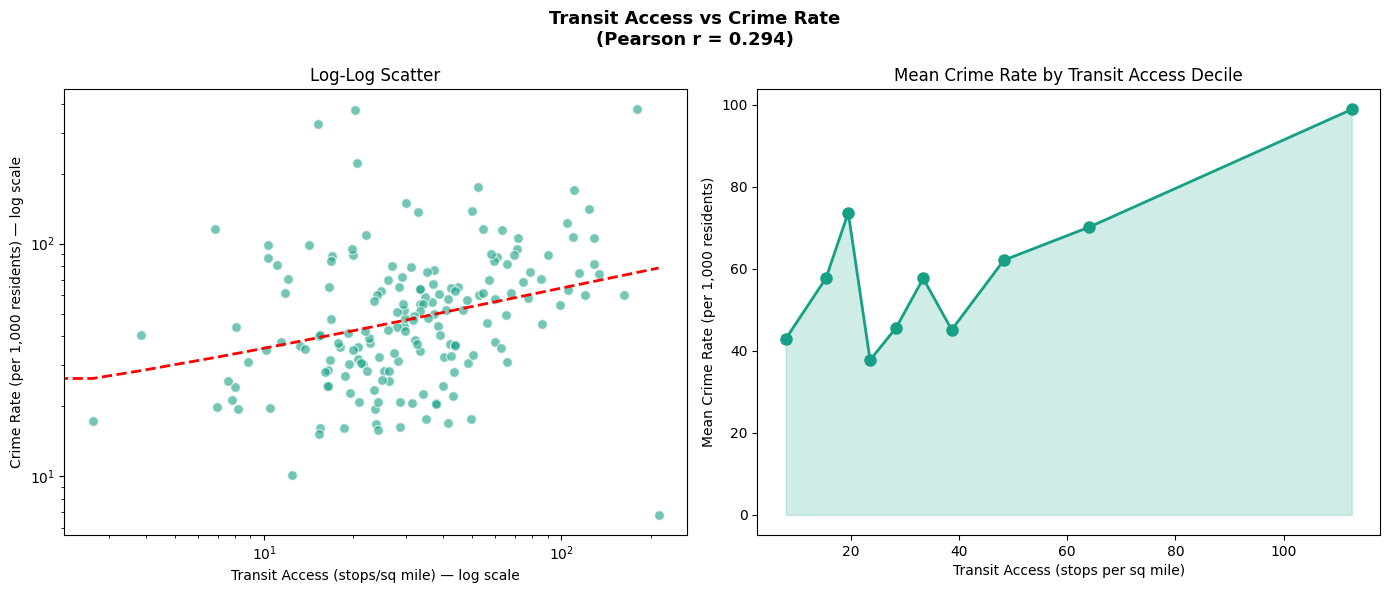

Pearson r: 0.2939


In [ ]:
# Both skewed — use log-log scatter + binned mean line plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log-log scatter
axes[0].scatter(df_master['transit_access'], df_master['crime_rate'],
                color='#16A085', alpha=0.6, edgecolor='white', s=50)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
z = np.polyfit(np.log1p(df_master['transit_access']),
               np.log1p(df_master['crime_rate']), 1)
p = np.poly1d(z)
x_sorted = np.sort(df_master['transit_access'])
axes[0].plot(x_sorted,
             np.expm1(p(np.log1p(x_sorted))),
             color='red', linewidth=2, linestyle='--')
axes[0].set_xlabel('Transit Access (stops/sq mile) — log scale')
axes[0].set_ylabel('Crime Rate (per 1,000 residents) — log scale')
axes[0].set_title('Log-Log Scatter')

# Binned mean line chart
df_master['transit_bin'] = pd.qcut(
    df_master['transit_access'], q=10, duplicates='drop'
)
bin_means = df_master.groupby('transit_bin', observed=True).agg(
    mean_crime=('crime_rate', 'mean'),
    mid_transit=('transit_access', 'median')
).reset_index()
axes[1].plot(bin_means['mid_transit'], bin_means['mean_crime'],
             color='#16A085', linewidth=2, marker='o', markersize=8)
axes[1].fill_between(bin_means['mid_transit'], bin_means['mean_crime'],
                      alpha=0.2, color='#16A085')
axes[1].set_xlabel('Transit Access (stops per sq mile)')
axes[1].set_ylabel('Mean Crime Rate (per 1,000 residents)')
axes[1].set_title('Mean Crime Rate by Transit Access Decile')

corr = df_master['transit_access'].corr(df_master['crime_rate'])
fig.suptitle(f'Transit Access vs Crime Rate\n(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print(f'Pearson r: {corr:.4f}')

Moderate positive relationship — tracts with more transit stops tend
toward higher crime rates. The decile line chart shows a generally
upward trend with mean crime rising from ~42 in the lowest transit
decile to ~99 in the highest, though with some noise in the middle
deciles suggesting the relationship is not strictly linear.

### 4.2.6 EMS Call Rate vs Crime Rate - log-log scatter + 2D KDE contour revealing joint density concentration

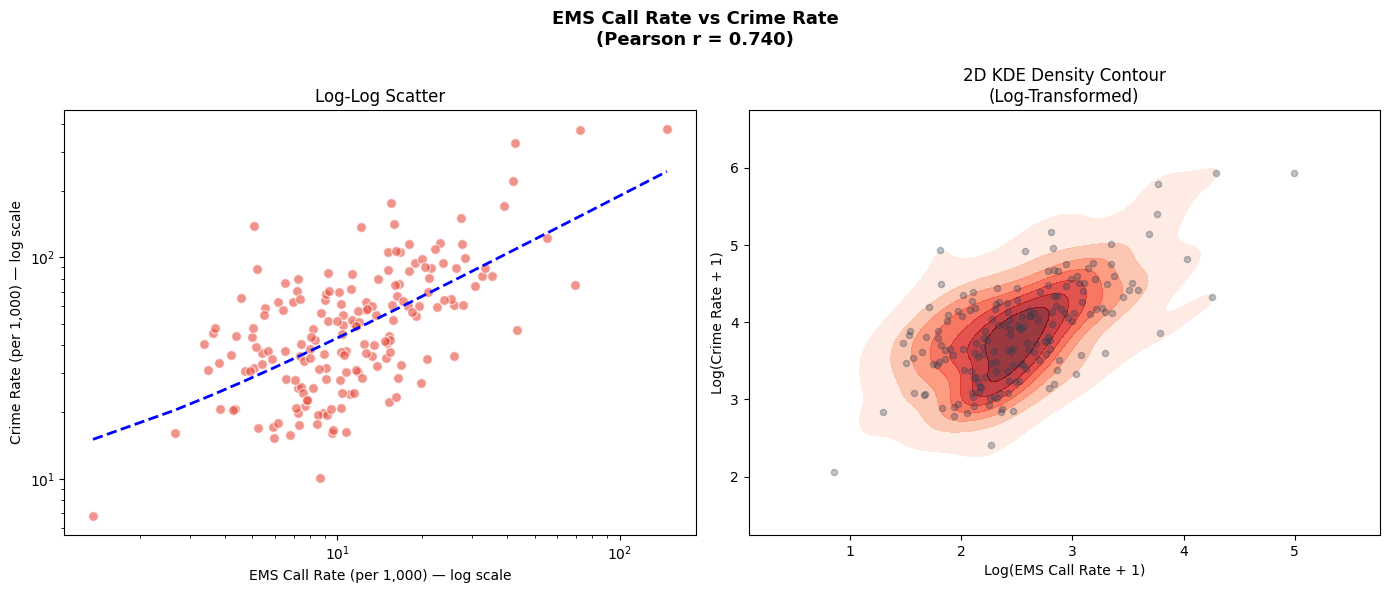

Pearson r: 0.7398


In [ ]:
# Both extremely skewed — use log-log scatter + 2D density contour
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log-log scatter
axes[0].scatter(df_master['EMS_call_rate'], df_master['crime_rate'],
                color='#E74C3C', alpha=0.6, edgecolor='white', s=50)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
z = np.polyfit(np.log1p(df_master['EMS_call_rate']),
               np.log1p(df_master['crime_rate']), 1)
p = np.poly1d(z)
x_sorted = np.sort(df_master['EMS_call_rate'])
axes[0].plot(x_sorted,
             np.expm1(p(np.log1p(x_sorted))),
             color='blue', linewidth=2, linestyle='--')
axes[0].set_xlabel('EMS Call Rate (per 1,000) — log scale')
axes[0].set_ylabel('Crime Rate (per 1,000) — log scale')
axes[0].set_title('Log-Log Scatter')

# 2D KDE contour on log-transformed values
log_ems = np.log1p(df_master['EMS_call_rate'])
log_crime = np.log1p(df_master['crime_rate'])
sns.kdeplot(x=log_ems, y=log_crime, ax=axes[1],
            fill=True, cmap='Reds', levels=8, alpha=0.8)
axes[1].scatter(log_ems, log_crime, color='#2C3E50',
                alpha=0.3, s=20, zorder=5)
axes[1].set_xlabel('Log(EMS Call Rate + 1)')
axes[1].set_ylabel('Log(Crime Rate + 1)')
axes[1].set_title('2D KDE Density Contour\n(Log-Transformed)')

corr = df_master['EMS_call_rate'].corr(df_master['crime_rate'])
fig.suptitle(f'EMS Call Rate vs Crime Rate\n(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print(f'Pearson r: {corr:.4f}')

Strong positive relationship — the strongest predictor identified so
far. The log-log scatter shows a tight upward trend with points
clustering closely around the trend line. The 2D KDE contour confirms
a dense concentration of tracts in the low EMS / low crime region with
a clear diagonal axis of density — tracts with high EMS demand
consistently have high crime rates.

### 4.2.7 Police Incident Rate vs Crime Rate - log-log scatter + 2D KDE contour showing the strongest predictor relationship



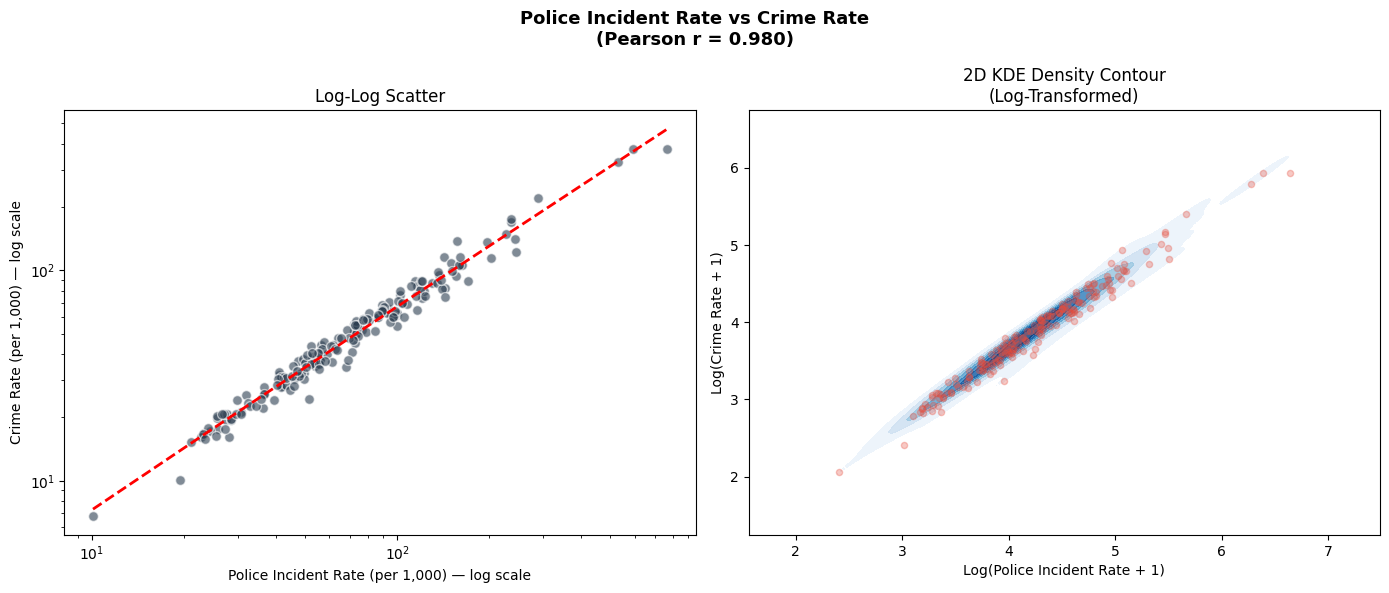

Pearson r: 0.9802


In [ ]:
# 4.2.7 Police Incident Rate vs Crime Rate
# Both extremely skewed — use log-log scatter + residual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log-log scatter
axes[0].scatter(df_master['police_incident_rate'], df_master['crime_rate'],
                color='#2C3E50', alpha=0.6, edgecolor='white', s=50)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
z = np.polyfit(np.log1p(df_master['police_incident_rate']),
               np.log1p(df_master['crime_rate']), 1)
p = np.poly1d(z)
x_sorted = np.sort(df_master['police_incident_rate'])
axes[0].plot(x_sorted,
             np.expm1(p(np.log1p(x_sorted))),
             color='red', linewidth=2, linestyle='--')
axes[0].set_xlabel('Police Incident Rate (per 1,000) — log scale')
axes[0].set_ylabel('Crime Rate (per 1,000) — log scale')
axes[0].set_title('Log-Log Scatter')

# 2D KDE contour on log-transformed values
log_police = np.log1p(df_master['police_incident_rate'])
log_crime = np.log1p(df_master['crime_rate'])
sns.kdeplot(x=log_police, y=log_crime, ax=axes[1],
            fill=True, cmap='Blues', levels=8, alpha=0.8)
axes[1].scatter(log_police, log_crime, color='#E74C3C',
                alpha=0.3, s=20, zorder=5)
axes[1].set_xlabel('Log(Police Incident Rate + 1)')
axes[1].set_ylabel('Log(Crime Rate + 1)')
axes[1].set_title('2D KDE Density Contour\n(Log-Transformed)')

corr = df_master['police_incident_rate'].corr(df_master['crime_rate'])
fig.suptitle(f'Police Incident Rate vs Crime Rate\n(Pearson r = {corr:.3f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print(f'Pearson r: {corr:.4f}')

Near-perfect positive correlation — by far the strongest predictor in
the dataset. The log-log scatter shows points aligned almost perfectly
along the trend line with minimal scatter, and the 2D KDE contour
collapses to an extremely narrow diagonal band confirming that police
incident rate and crime rate are essentially measuring the same
underlying phenomenon. This raises a potential multicollinearity concern
that must be carefully evaluated in Phase 5 before including both
variables in the same model.

## 4.3 Correlation Analysis
### 4.3.1 Pearson Correlation Matrix — All Variables

In [ ]:
variables = [
    'crime_rate', 'population_density', 'median_income',
    'unemployment_rate', 'commercial_land_use_ratio',
    'transit_access', 'EMS_call_rate', 'police_incident_rate'
]

corr_matrix = df_master[variables].corr()

print('Pearson Correlation Matrix:')
print(corr_matrix.round(3))

Pearson Correlation Matrix:
                           crime_rate  population_density  median_income  \
crime_rate                     1.0000              0.0730        -0.2480   
population_density             0.0730              1.0000        -0.3680   
median_income                 -0.2480             -0.3680         1.0000   
unemployment_rate              0.0010              0.2610        -0.3270   
commercial_land_use_ratio      0.3210              0.5210        -0.1900   
transit_access                 0.2940              0.6670        -0.3390   
EMS_call_rate                  0.7400              0.0450        -0.2510   
police_incident_rate           0.9800              0.0850        -0.2490   

                           unemployment_rate  commercial_land_use_ratio  \
crime_rate                            0.0010                     0.3210   
population_density                    0.2610                     0.5210   
median_income                        -0.3270                  

The correlation matrix reveals two dominant patterns. First, police
incident rate (r=0.98) and EMS call rate (r=0.74) are by far the
strongest predictors of crime rate — both capturing overall neighborhood
activity and disorder. Second, the structural predictors — commercial
ratio (r=0.32), transit access (r=0.29), and median income (r=-0.25) —
show weak to moderate relationships while population density (r=0.07)
and unemployment (r=0.001) show virtually no linear relationship with
crime rate.

### 4.3.2 Correlation Heatmap

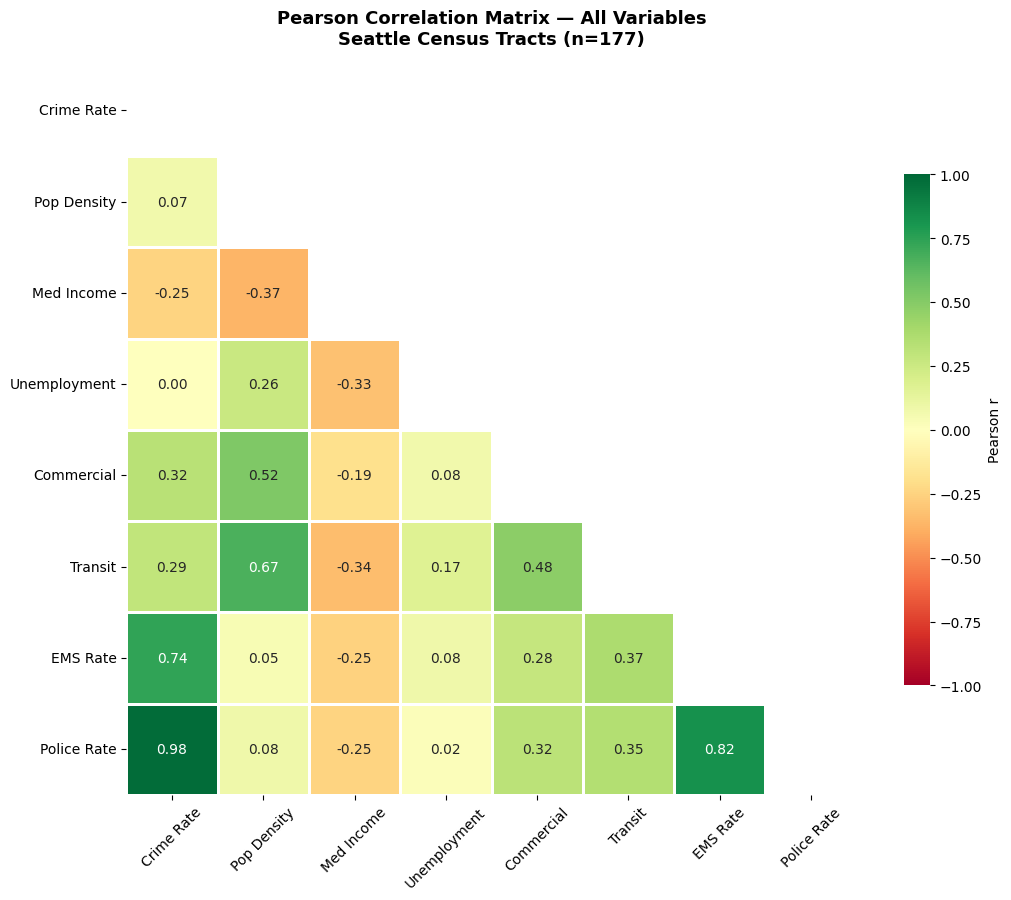

In [ ]:
# Use a clustered heatmap (clustermap) instead of a plain heatmap
# to group variables by similarity of correlation patterns
short_names = {
    'crime_rate': 'Crime Rate',
    'population_density': 'Pop Density',
    'median_income': 'Med Income',
    'unemployment_rate': 'Unemployment',
    'commercial_land_use_ratio': 'Commercial',
    'transit_access': 'Transit',
    'EMS_call_rate': 'EMS Rate',
    'police_incident_rate': 'Police Rate'
}

corr_renamed = corr_matrix.rename(
    index=short_names, columns=short_names
)

fig, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr_renamed, dtype=bool))

sns.heatmap(
    corr_renamed,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    square=True,
    linewidths=0.8,
    linecolor='white',
    annot_kws={'size': 10},
    cbar_kws={'shrink': 0.7, 'label': 'Pearson r'}
)

ax.set_title('Pearson Correlation Matrix — All Variables\n'
             'Seattle Census Tracts (n=177)',
             fontsize=13, fontweight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

The heatmap confirms the two-cluster structure of the predictor space.
Police rate, EMS rate, and crime rate form a strongly interconnected
green cluster in the bottom-left. Population density, commercial ratio,
and transit access form a second moderately correlated cluster (r=0.52–
0.67). Income acts as a negative anchor — orange cells against population
density (-0.37) and transit (-0.34) confirm that denser, better-connected
tracts tend to have lower incomes in Seattle's spatial structure.

### 4.3.3 Identify Highly Correlated Predictor Pairs

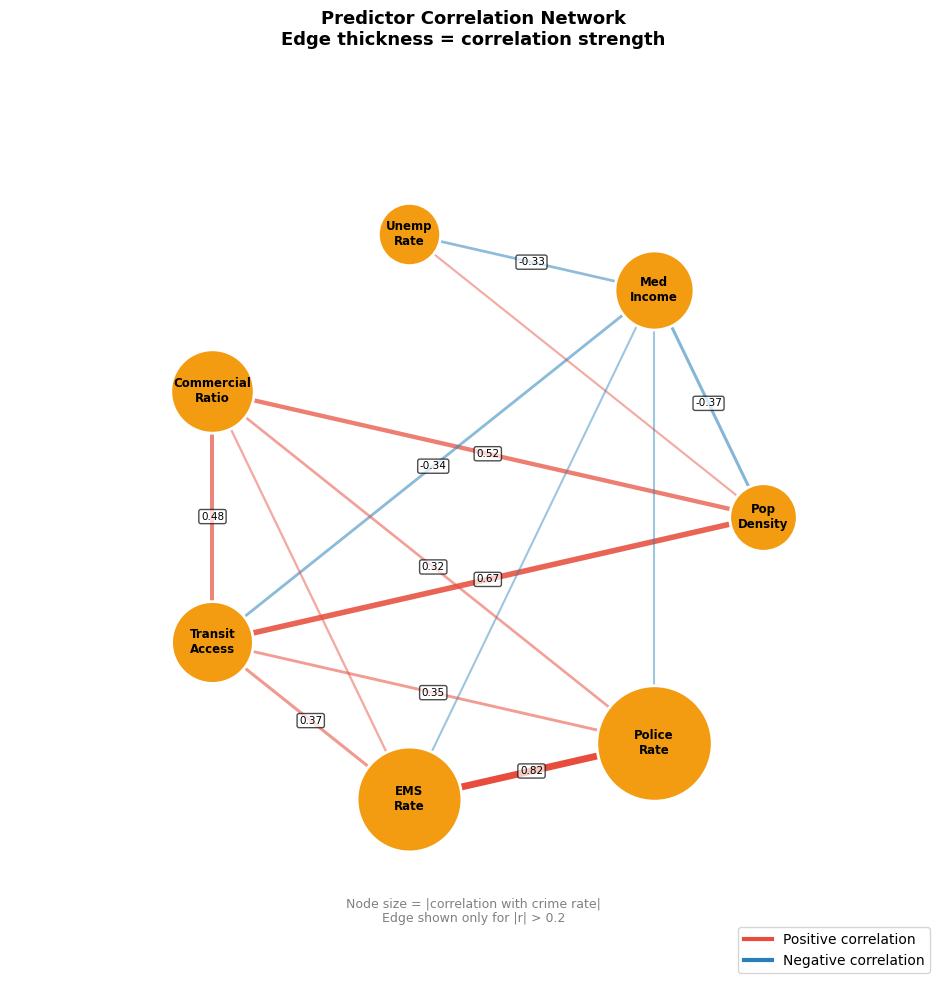


Highly correlated predictor pairs (|r| > 0.7):
EMS_call_rate vs police_incident_rate: r = 0.822 ⚠️


In [ ]:
# Visualise predictor correlations as a network where edge
# thickness and color indicate correlation strength.
# Nodes sized by absolute correlation with crime rate.
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

predictors = [
    'population_density', 'median_income', 'unemployment_rate',
    'commercial_land_use_ratio', 'transit_access',
    'EMS_call_rate', 'police_incident_rate'
]

corr_pred = df_master[predictors].corr()

# Node positions — circular layout
n = len(predictors)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
pos = {p: (np.cos(a), np.sin(a)) for p, a in zip(predictors, angles)}

short = {
    'population_density': 'Pop\nDensity',
    'median_income': 'Med\nIncome',
    'unemployment_rate': 'Unemp\nRate',
    'commercial_land_use_ratio': 'Commercial\nRatio',
    'transit_access': 'Transit\nAccess',
    'EMS_call_rate': 'EMS\nRate',
    'police_incident_rate': 'Police\nRate'
}

crime_corrs = {p: abs(df_master[p].corr(df_master['crime_rate']))
               for p in predictors}

fig, ax = plt.subplots(figsize=(12, 10))

# Draw edges
for i, p1 in enumerate(predictors):
    for j, p2 in enumerate(predictors):
        if j <= i:
            continue
        r = corr_pred.loc[p1, p2]
        if abs(r) < 0.2:
            continue
        color = '#E74C3C' if r > 0 else '#2980B9'
        lw = abs(r) * 6
        alpha = min(abs(r) + 0.2, 1.0)
        x = [pos[p1][0], pos[p2][0]]
        y = [pos[p1][1], pos[p2][1]]
        ax.plot(x, y, color=color, linewidth=lw, alpha=alpha, zorder=1)
        # Label edge with r value
        mx, my = np.mean(x), np.mean(y)
        if abs(r) > 0.3:
            ax.text(mx, my, f'{r:.2f}', fontsize=7.5, ha='center',
                    va='center', color='black',
                    bbox=dict(boxstyle='round,pad=0.2',
                              facecolor='white', alpha=0.7))

# Draw nodes
for p in predictors:
    x, y = pos[p]
    size = 2000 + crime_corrs[p] * 5000
    ax.scatter(x, y, s=size, color='#F39C12', zorder=3,
               edgecolors='white', linewidth=2)
    ax.text(x, y, short[p], ha='center', va='center',
            fontsize=8.5, fontweight='bold', zorder=4)

# Legend
red_line = mlines.Line2D([], [], color='#E74C3C', linewidth=3,
                          label='Positive correlation')
blue_line = mlines.Line2D([], [], color='#2980B9', linewidth=3,
                           label='Negative correlation')
ax.legend(handles=[red_line, blue_line], loc='lower right', fontsize=10)
ax.text(0, -1.4, 'Node size = |correlation with crime rate|\n'
                  'Edge shown only for |r| > 0.2',
        ha='center', fontsize=9, color='gray')

ax.set_xlim(-1.6, 1.6)
ax.set_ylim(-1.6, 1.6)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Predictor Correlation Network\n'
             'Edge thickness = correlation strength',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Print flagged pairs
print(f'\nHighly correlated predictor pairs (|r| > 0.7):')
print('='*55)
high_corr_found = False
for i in range(len(predictors)):
    for j in range(i+1, len(predictors)):
        r = corr_pred.iloc[i, j]
        if abs(r) > 0.7:
            print(f'{predictors[i]} vs {predictors[j]}: '
                  f'r = {r:.3f} ⚠️')
            high_corr_found = True
if not high_corr_found:
    print('✅ No highly correlated pairs above threshold of 0.7')

The network graph clearly isolates EMS rate and police rate as the most
crime-connected nodes — their large size reflects high absolute correlation
with crime rate. The thickest edge in the entire network is EMS vs police
(r=0.82) — a potential multicollinearity concern flagged for Phase 5.
Population density sits at the center of a web of moderate positive
correlations with commercial ratio (0.52), transit (0.67), and police
rate (0.32) — confirming it proxies urban intensity rather than crime
directly. Income is the only node with predominantly blue (negative)
edges, sitting structurally opposed to density and transit.

### 4.3.4 Lollipop chart of Each Predictor with Crime Rate

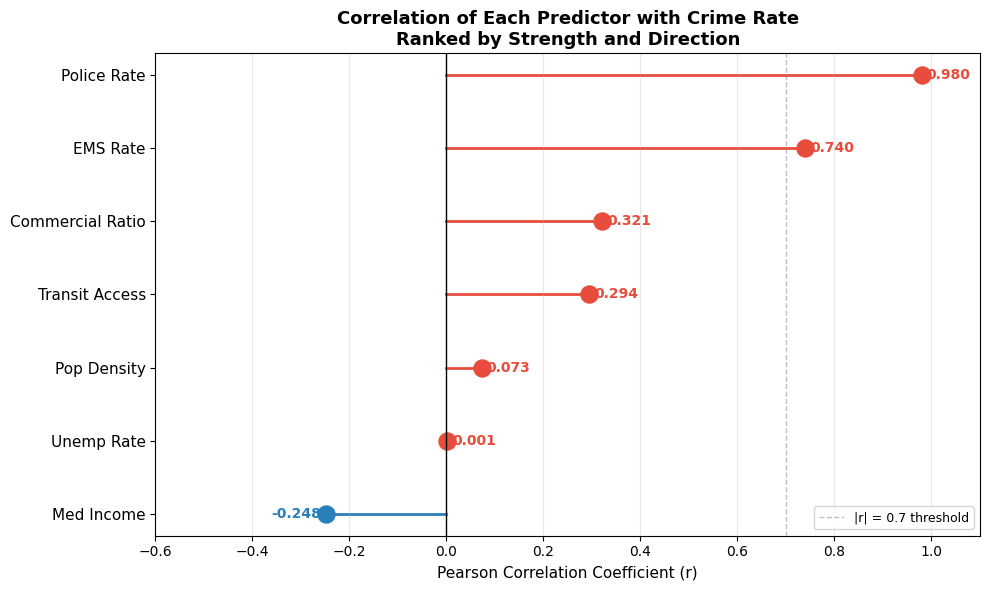


Correlation with crime rate (ranked):
median_income               -0.2476
unemployment_rate            0.0015
population_density           0.0731
transit_access               0.2939
commercial_land_use_ratio    0.3208
EMS_call_rate                0.7398
police_incident_rate         0.9802
dtype: float64


In [ ]:
# More visually distinct than a bar chart — shows direction
# and magnitude clearly with color coding
crime_corr = df_master[predictors].corrwith(
    df_master['crime_rate']
).sort_values()

colors = ['#E74C3C' if x > 0 else '#2980B9' for x in crime_corr.values]
short_labels = [short[p].replace('\n', ' ') for p in crime_corr.index]

fig, ax = plt.subplots(figsize=(10, 6))

# Lollipop stems
for i, (val, color) in enumerate(zip(crime_corr.values, colors)):
    ax.plot([0, val], [i, i], color=color, linewidth=2, zorder=1)
    ax.scatter(val, i, color=color, s=150, zorder=2)
    ax.text(val + (0.01 if val >= 0 else -0.01), i,
            f'{val:.3f}',
            va='center',
            ha='left' if val >= 0 else 'right',
            fontsize=10, fontweight='bold', color=color)

ax.axvline(x=0, color='black', linewidth=1, linestyle='-')
ax.axvline(x=0.7, color='gray', linewidth=1,
           linestyle='--', alpha=0.5, label='|r| = 0.7 threshold')
ax.axvline(x=-0.7, color='gray', linewidth=1,
           linestyle='--', alpha=0.5)

ax.set_yticks(range(len(short_labels)))
ax.set_yticklabels(short_labels, fontsize=11)
ax.set_xlabel('Pearson Correlation Coefficient (r)', fontsize=11)
ax.set_title('Correlation of Each Predictor with Crime Rate\n'
             'Ranked by Strength and Direction',
             fontsize=13, fontweight='bold')
ax.set_xlim(-0.6, 1.1)
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('\nCorrelation with crime rate (ranked):')
print(crime_corr.round(4))

The ranked lollipop chart tells the clearest story — police incident rate
(0.98) and EMS call rate (0.74) are in a completely different league from
all other predictors, both exceeding the 0.7 multicollinearity threshold
relative to crime rate. The remaining five predictors cluster between
-0.25 and 0.32 — moderate at best. Only median income is negatively
correlated. The chart makes the dominant role of the two activity-based
predictors unmistakable and raises the key modeling question for Phase 5 —
whether to include both police rate and EMS rate given their r=0.82
inter-correlation.

## 4.4 Spatial Exploratory Analysis
### 4.4.1 Choropleth Map — Crime Rate by Census Tract

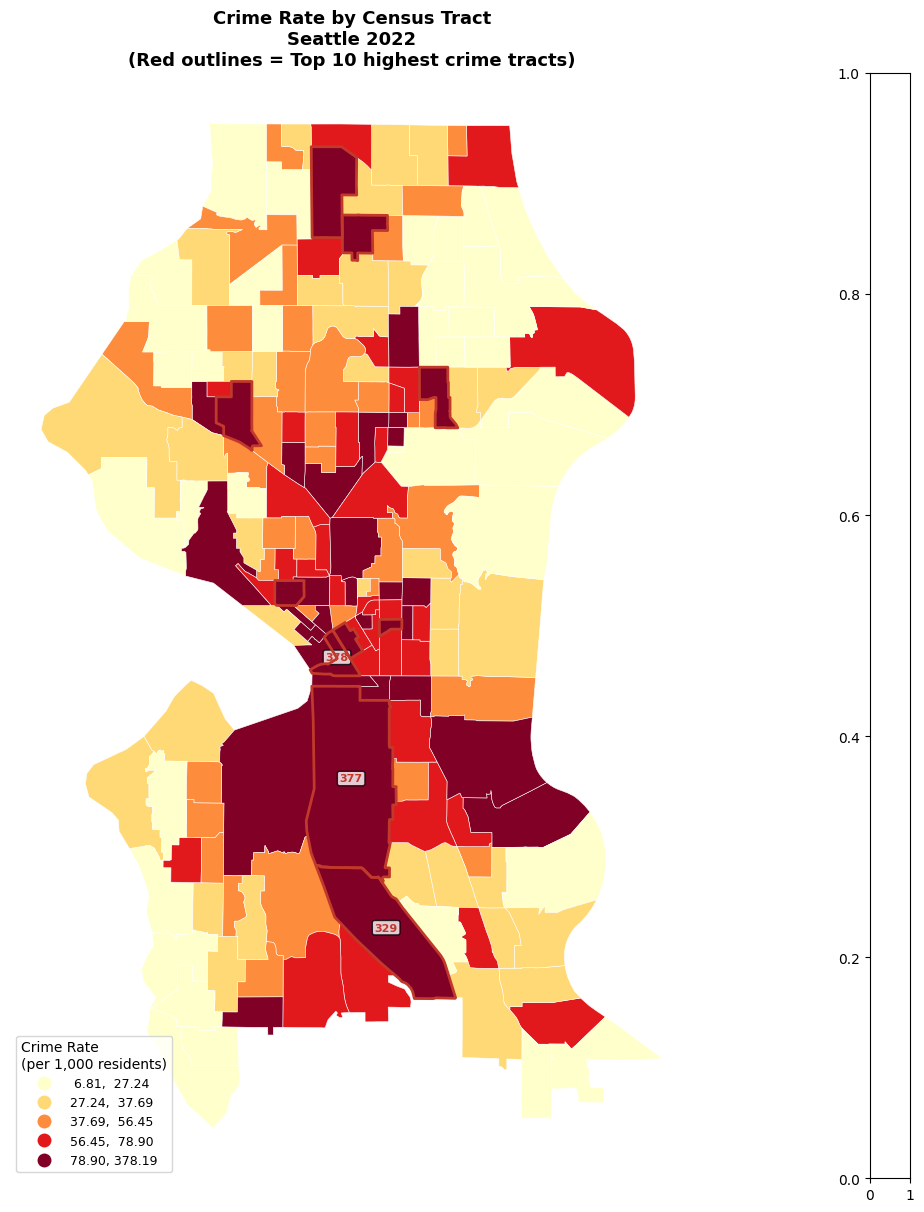

In [ ]:
# 4.4.1 Choropleth Map — Crime Rate by Census Tract
# ---------------------------------------------------------------
# Use quantile classification + add neighborhood context
# with a graduated color scheme and tract outlines
# ---------------------------------------------------------------
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(11, 13))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.1)

gdf_master.plot(
    column='crime_rate',
    cmap='YlOrRd',
    scheme='quantiles',
    k=5,
    legend=True,
    legend_kwds={
        'title': 'Crime Rate\n(per 1,000 residents)',
        'loc': 'lower left',
        'fontsize': 9,
        'title_fontsize': 10
    },
    edgecolor='white',
    linewidth=0.4,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)

# Highlight top 10 highest crime tracts
top10 = gdf_master.nlargest(10, 'crime_rate')
top10.plot(ax=ax, facecolor='none', edgecolor='#C0392B',
           linewidth=2.0, zorder=5)

# Annotate top 3
for _, row in gdf_master.nlargest(3, 'crime_rate').iterrows():
    ax.annotate(
        f"{row['crime_rate']:.0f}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        fontsize=8, fontweight='bold', color='#C0392B',
        ha='center',
        bbox=dict(boxstyle='round,pad=0.2',
                  facecolor='white', alpha=0.8)
    )

ax.set_title('Crime Rate by Census Tract\nSeattle 2022\n'
             '(Red outlines = Top 10 highest crime tracts)',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

Crime is heavily concentrated in Downtown and South Seattle — the darkest
tracts (78–378 per 1,000) form a continuous north-south corridor through
the urban core. The three annotated peak tracts (378, 377, 329) are all
clustered in the Downtown/SoDo area. Northern and western residential
neighborhoods show consistently low rates (6.81–27), confirming a strong
center-periphery spatial gradient in crime distribution.

### 4.4.2 Proportional Symbol Map — Population Density by Census Tract

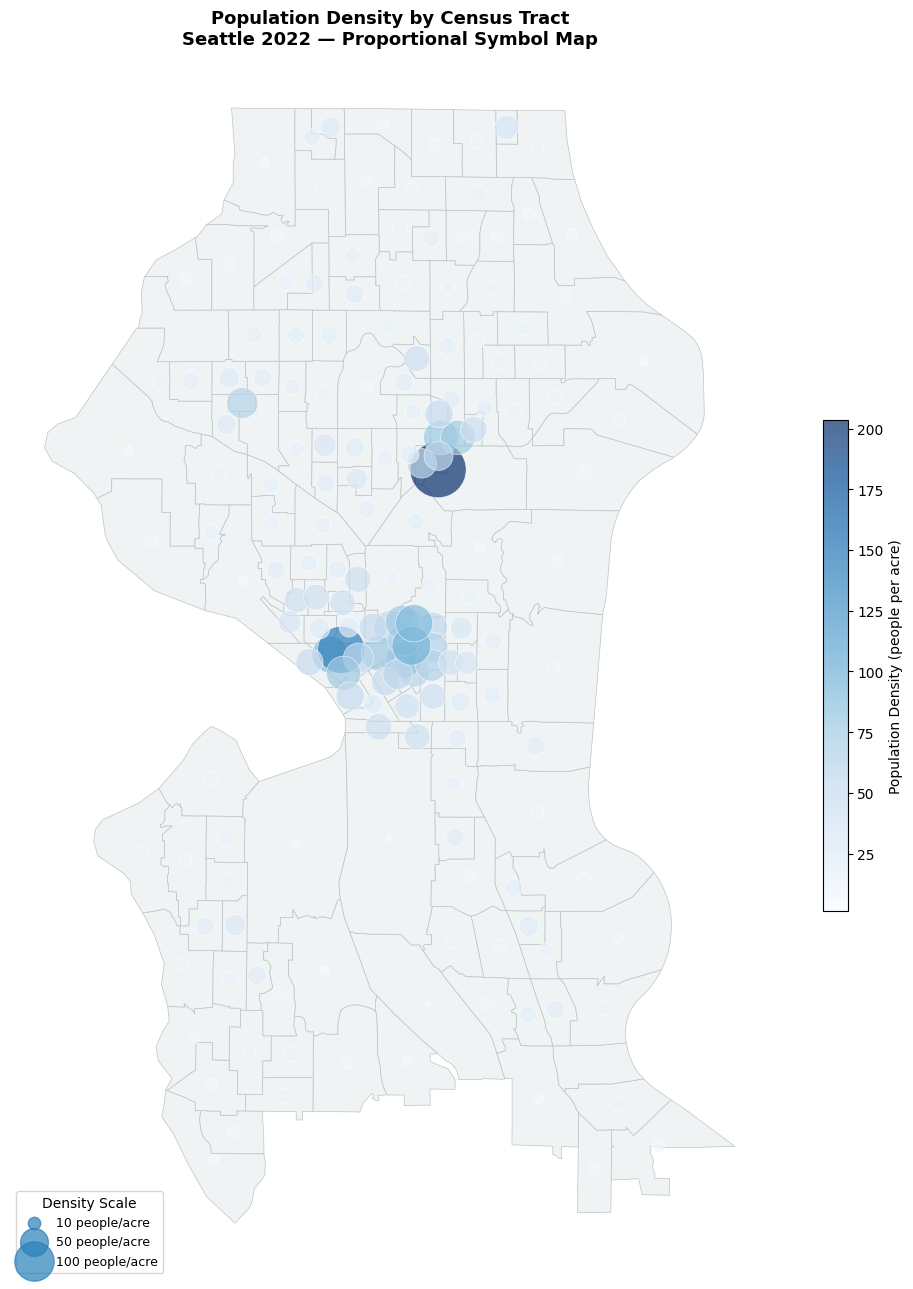

In [ ]:
# 4.4.2 Population Density — Proportional Symbol Map
# ---------------------------------------------------------------
# Instead of a standard choropleth, overlay proportional circles
# on a light base map — circle area proportional to density
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 13))

# Light base layer
gdf_master.plot(ax=ax, color='#F0F3F4', edgecolor='#BDC3C7',
                linewidth=0.5)

# Proportional circles
centroids = gdf_master.copy()
centroids['cx'] = centroids.geometry.centroid.x
centroids['cy'] = centroids.geometry.centroid.y

scatter = ax.scatter(
    centroids['cx'],
    centroids['cy'],
    s=centroids['population_density'] * 8,
    c=centroids['population_density'],
    cmap='Blues',
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5,
    zorder=3
)

plt.colorbar(scatter, ax=ax, shrink=0.4,
             label='Population Density (people per acre)')

# Size legend
for size_val, label in [(10, '10'), (50, '50'), (100, '100')]:
    ax.scatter([], [], s=size_val * 8, c='#2980B9',
               alpha=0.7, label=f'{label} people/acre')
ax.legend(title='Density Scale', loc='lower left',
          fontsize=9, title_fontsize=10)

ax.set_title('Population Density by Census Tract\n'
             'Seattle 2022 — Proportional Symbol Map',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

High-density tracts are tightly concentrated in two clusters — Capitol
Hill/First Hill in the center and the University District in the north —
with the largest darkest circles confirming extreme density (100–200+
people per acre) in these areas. The rest of Seattle is characterized by
small pale circles reflecting low to moderate residential density, and the
largely empty south confirms lower-density land use patterns there.

### 4.4.3 Bivariate Map (Income + Crime Rate)

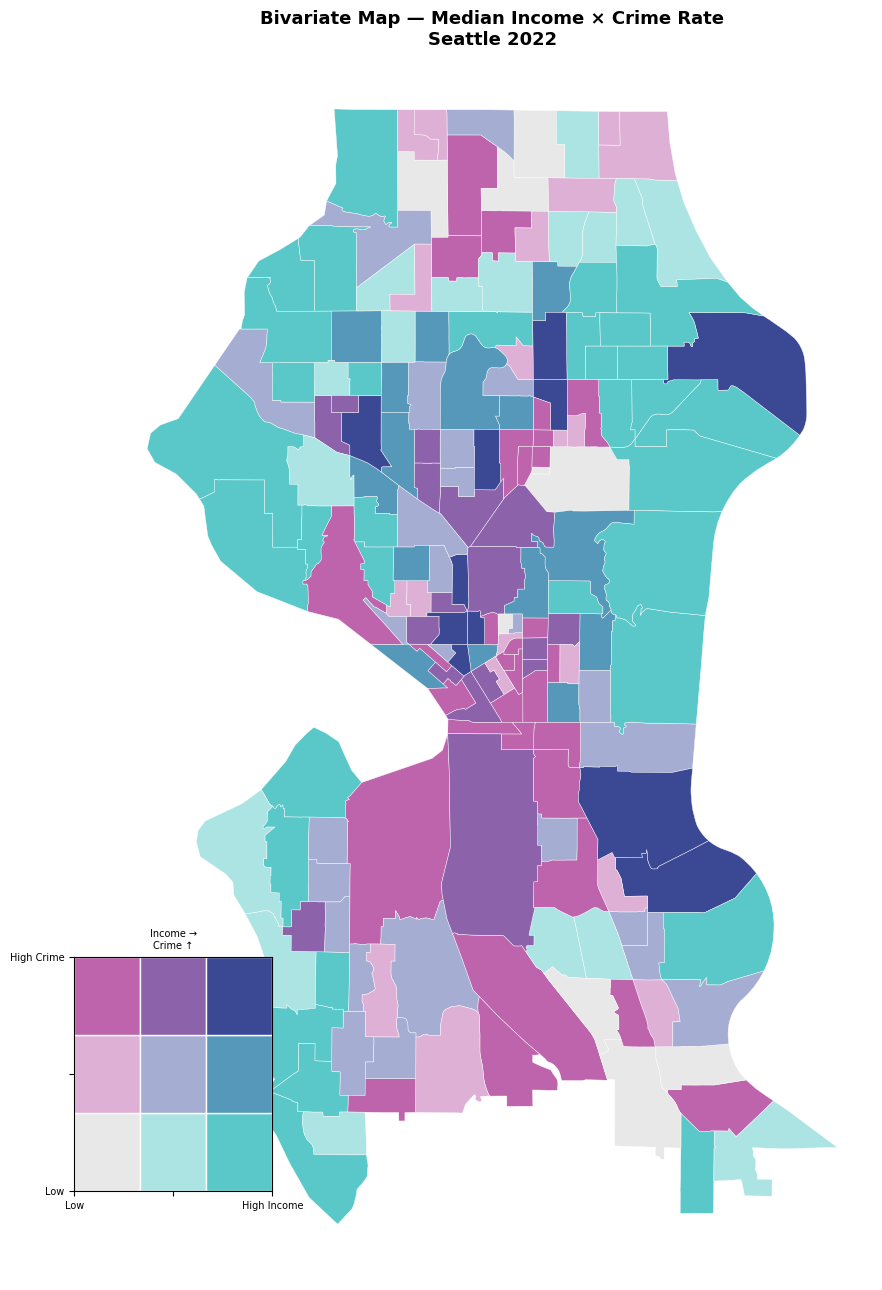

In [ ]:
# 4.4.3 Median Income — Bivariate Map (Income + Crime Rate)
# ---------------------------------------------------------------
# Bivariate choropleth combining income and crime rate in one map
# using a 3x3 color matrix — reveals spatial interaction between
# the two variables simultaneously
# ---------------------------------------------------------------
from matplotlib.patches import Patch

# Classify both variables into 3 quantile groups
df_biv = gdf_master.copy()
df_biv['inc_class'] = pd.qcut(
    df_biv['median_income'], q=3, labels=[0, 1, 2]
).astype(int)
df_biv['crime_class'] = pd.qcut(
    df_biv['crime_rate'], q=3, labels=[0, 1, 2]
).astype(int)
df_biv['biv_class'] = df_biv['crime_class'] * 3 + df_biv['inc_class']

# 3x3 bivariate color matrix
# Rows = crime (low to high), Cols = income (low to high)
biv_colors = {
    0: '#e8e8e8',  # low crime, low income
    1: '#ace4e4',  # low crime, mid income
    2: '#5ac8c8',  # low crime, high income
    3: '#dfb0d6',  # mid crime, low income
    4: '#a5add3',  # mid crime, mid income
    5: '#5698b9',  # mid crime, high income
    6: '#be64ac',  # high crime, low income
    7: '#8c62aa',  # high crime, mid income
    8: '#3b4994',  # high crime, high income
}

df_biv['color'] = df_biv['biv_class'].map(biv_colors)

fig, ax = plt.subplots(figsize=(11, 13))
df_biv.plot(ax=ax, color=df_biv['color'],
            edgecolor='white', linewidth=0.3)

# Bivariate legend
legend_ax = fig.add_axes([0.12, 0.08, 0.18, 0.18])
for i in range(3):
    for j in range(3):
        key = i * 3 + j
        legend_ax.add_patch(
            plt.Rectangle((j, i), 1, 1,
                          facecolor=biv_colors[key],
                          edgecolor='white')
        )
legend_ax.set_xlim(0, 3)
legend_ax.set_ylim(0, 3)
legend_ax.set_xticks([0, 1.5, 3])
legend_ax.set_xticklabels(['Low', '', 'High Income'], fontsize=7)
legend_ax.set_yticks([0, 1.5, 3])
legend_ax.set_yticklabels(['Low', '', 'High Crime'], fontsize=7)
legend_ax.set_title('Income →\nCrime ↑', fontsize=7)

ax.set_title('Bivariate Map — Median Income × Crime Rate\n'
             'Seattle 2022',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

The bivariate map reveals a nuanced spatial story invisible in a simple
correlation. Dark blue tracts (high income, high crime) appear in
Downtown and Capitol Hill — wealthy neighborhoods with high crime driven
by commercial activity rather than poverty. Teal tracts (high income,
low crime) dominate the northern and eastern residential neighborhoods.
Pink/magenta tracts (low income, high crime) cluster in South Seattle —
the pattern most aligned with traditional crime-poverty theory. The
presence of multiple color types confirms why the simple Pearson r of
-0.25 misses the spatial complexity of the income-crime relationship.

### 4.4.4 Choropleth Map — Unemployment Rate by Census Tract

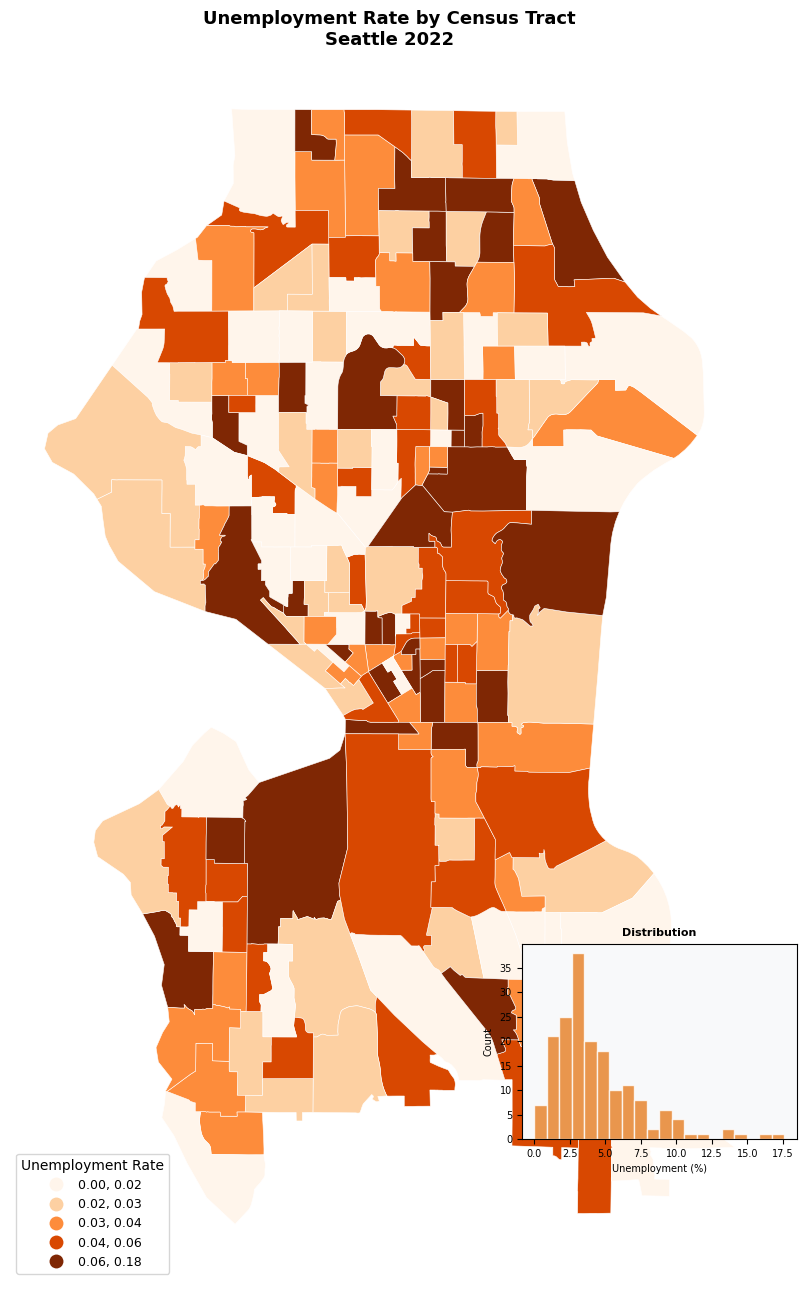

In [ ]:
# 4.4.4 Unemployment Rate — Choropleth with Inset Histogram
# ---------------------------------------------------------------
# Standard choropleth but enriched with an inset distribution
# plot showing how the mapped values are distributed
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 13))

gdf_master.plot(
    column='unemployment_rate',
    cmap='Oranges',
    scheme='quantiles',
    k=5,
    legend=True,
    legend_kwds={
        'title': 'Unemployment Rate',
        'loc': 'lower left',
        'fontsize': 9,
        'title_fontsize': 10
    },
    edgecolor='white',
    linewidth=0.4,
    ax=ax
)

# Inset histogram
ax_inset = fig.add_axes([0.62, 0.12, 0.25, 0.15])
ax_inset.hist(df_master['unemployment_rate'] * 100,
              bins=20, color='#E67E22', edgecolor='white', alpha=0.8)
ax_inset.set_xlabel('Unemployment (%)', fontsize=7)
ax_inset.set_ylabel('Count', fontsize=7)
ax_inset.set_title('Distribution', fontsize=8, fontweight='bold')
ax_inset.tick_params(labelsize=7)
ax_inset.set_facecolor('#F8F9FA')

ax.set_title('Unemployment Rate by Census Tract\nSeattle 2022',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Unemployment shows a fragmented spatial pattern with no single dominant
cluster — high unemployment tracts (dark brown, 6–18%) are scattered
across North Seattle, the Central District, and pockets of South Seattle
rather than forming a contiguous zone. The inset histogram confirms the
right-skewed distribution with most tracts below 5% — the dark tracts
visible on the map represent the long tail of the distribution. This
fragmented pattern is consistent with the near-zero correlation with
crime rate (r=0.001).

### 4.4.5 Choropleth Map — EMS Call Rate by Census Tract

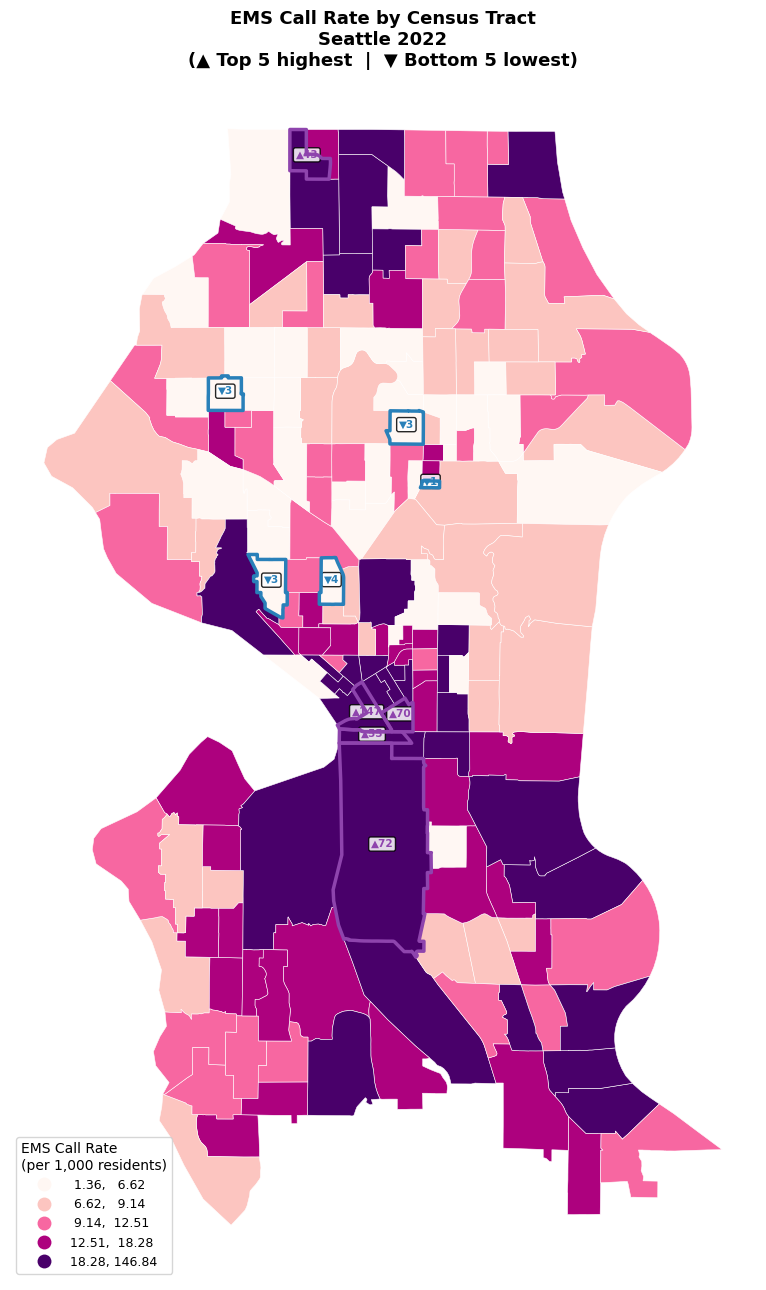

In [ ]:
# 4.4.5 EMS Call Rate — Choropleth with Top/Bottom Tract Labels
# ---------------------------------------------------------------
# Highlight and label the 5 highest and 5 lowest EMS rate tracts
# to identify specific problem areas
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 13))

gdf_master.plot(
    column='EMS_call_rate',
    cmap='RdPu',
    scheme='quantiles',
    k=5,
    legend=True,
    legend_kwds={
        'title': 'EMS Call Rate\n(per 1,000 residents)',
        'loc': 'lower left',
        'fontsize': 9,
        'title_fontsize': 10
    },
    edgecolor='white',
    linewidth=0.4,
    ax=ax
)

# Outline and label top 5 highest EMS tracts
top5_ems = gdf_master.nlargest(5, 'EMS_call_rate')
top5_ems.plot(ax=ax, facecolor='none', edgecolor='#8E44AD',
              linewidth=2.5, zorder=5)
for _, row in top5_ems.iterrows():
    ax.annotate(
        f"▲{row['EMS_call_rate']:.0f}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        fontsize=7.5, fontweight='bold', color='#8E44AD',
        ha='center',
        bbox=dict(boxstyle='round,pad=0.2',
                  facecolor='white', alpha=0.85)
    )

# Outline and label bottom 5 lowest EMS tracts
bot5_ems = gdf_master.nsmallest(5, 'EMS_call_rate')
bot5_ems.plot(ax=ax, facecolor='none', edgecolor='#2980B9',
              linewidth=2.5, zorder=5)
for _, row in bot5_ems.iterrows():
    ax.annotate(
        f"▼{row['EMS_call_rate']:.0f}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        fontsize=7.5, fontweight='bold', color='#2980B9',
        ha='center',
        bbox=dict(boxstyle='round,pad=0.2',
                  facecolor='white', alpha=0.85)
    )

ax.set_title('EMS Call Rate by Census Tract\nSeattle 2022\n'
             '(▲ Top 5 highest  |  ▼ Bottom 5 lowest)',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

EMS demand is heavily concentrated in Downtown, SoDo, and South Seattle
— the deep purple zone in the lower center mirrors the crime rate hotspot
almost exactly, consistent with the strong r=0.74 correlation. The top 5
highest tracts (▲47, ▲70, ▲99, ▲72, ▲42) are all within or immediately
adjacent to the Downtown core. The bottom 5 lowest tracts (▼3–4 per
1,000) are scattered across quieter residential areas in the north and
west — confirming EMS demand as a reliable spatial proxy for neighborhood
distress.

### 4.4.6 Diverging Map from Seattle Median — Police Incident Rate by Census Tract

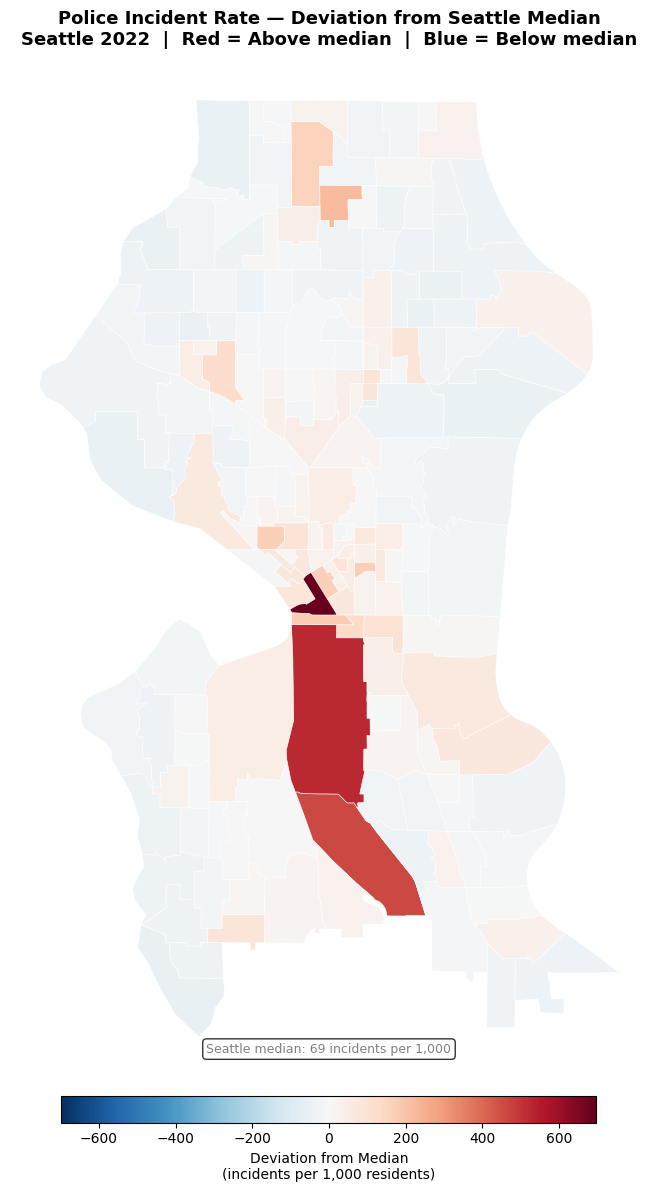

In [ ]:
# 4.4.6 Police Incident Rate — Diverging Map from Seattle Median
# ---------------------------------------------------------------
# Classify tracts as above or below Seattle median police rate
# using a diverging palette — immediately shows which tracts
# have above vs below average policing activity
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 13))

median_police = gdf_master['police_incident_rate'].median()
gdf_master['police_deviation'] = (
    gdf_master['police_incident_rate'] - median_police
)

gdf_master.plot(
    column='police_deviation',
    cmap='RdBu_r',
    legend=True,
    legend_kwds={
        'label': 'Deviation from Median\n(incidents per 1,000 residents)',
        'shrink': 0.5,
        'orientation': 'horizontal',
        'pad': 0.01
    },
    edgecolor='white',
    linewidth=0.4,
    ax=ax,
    vmin=-gdf_master['police_deviation'].abs().max(),
    vmax=gdf_master['police_deviation'].abs().max()
)

# Add median line annotation
ax.annotate(
    f'Seattle median: {median_police:.0f} incidents per 1,000',
    xy=(0.5, 0.03), xycoords='axes fraction',
    ha='center', fontsize=9, color='gray',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax.set_title('Police Incident Rate — Deviation from Seattle Median\n'
             'Seattle 2022  |  Red = Above median  |  Blue = Below median',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

The diverging map makes the extreme concentration of police activity
unmistakably clear — virtually the entire city sits at or below the
Seattle median of 69 incidents per 1,000 (light blue to white) while
a small cluster of Downtown and SoDo tracts show extreme positive
deviation of 200–700+ incidents above the median (deep red). This
extreme concentration in just a handful of tracts explains the high
standard deviation (88.35) and is the spatial signature of the r=0.98
correlation with crime rate — both variables are measuring the same
Downtown-concentrated phenomenon.

### 4.4.7 Side-by-Side Map Comparison — Crime Rate vs Key Predictors

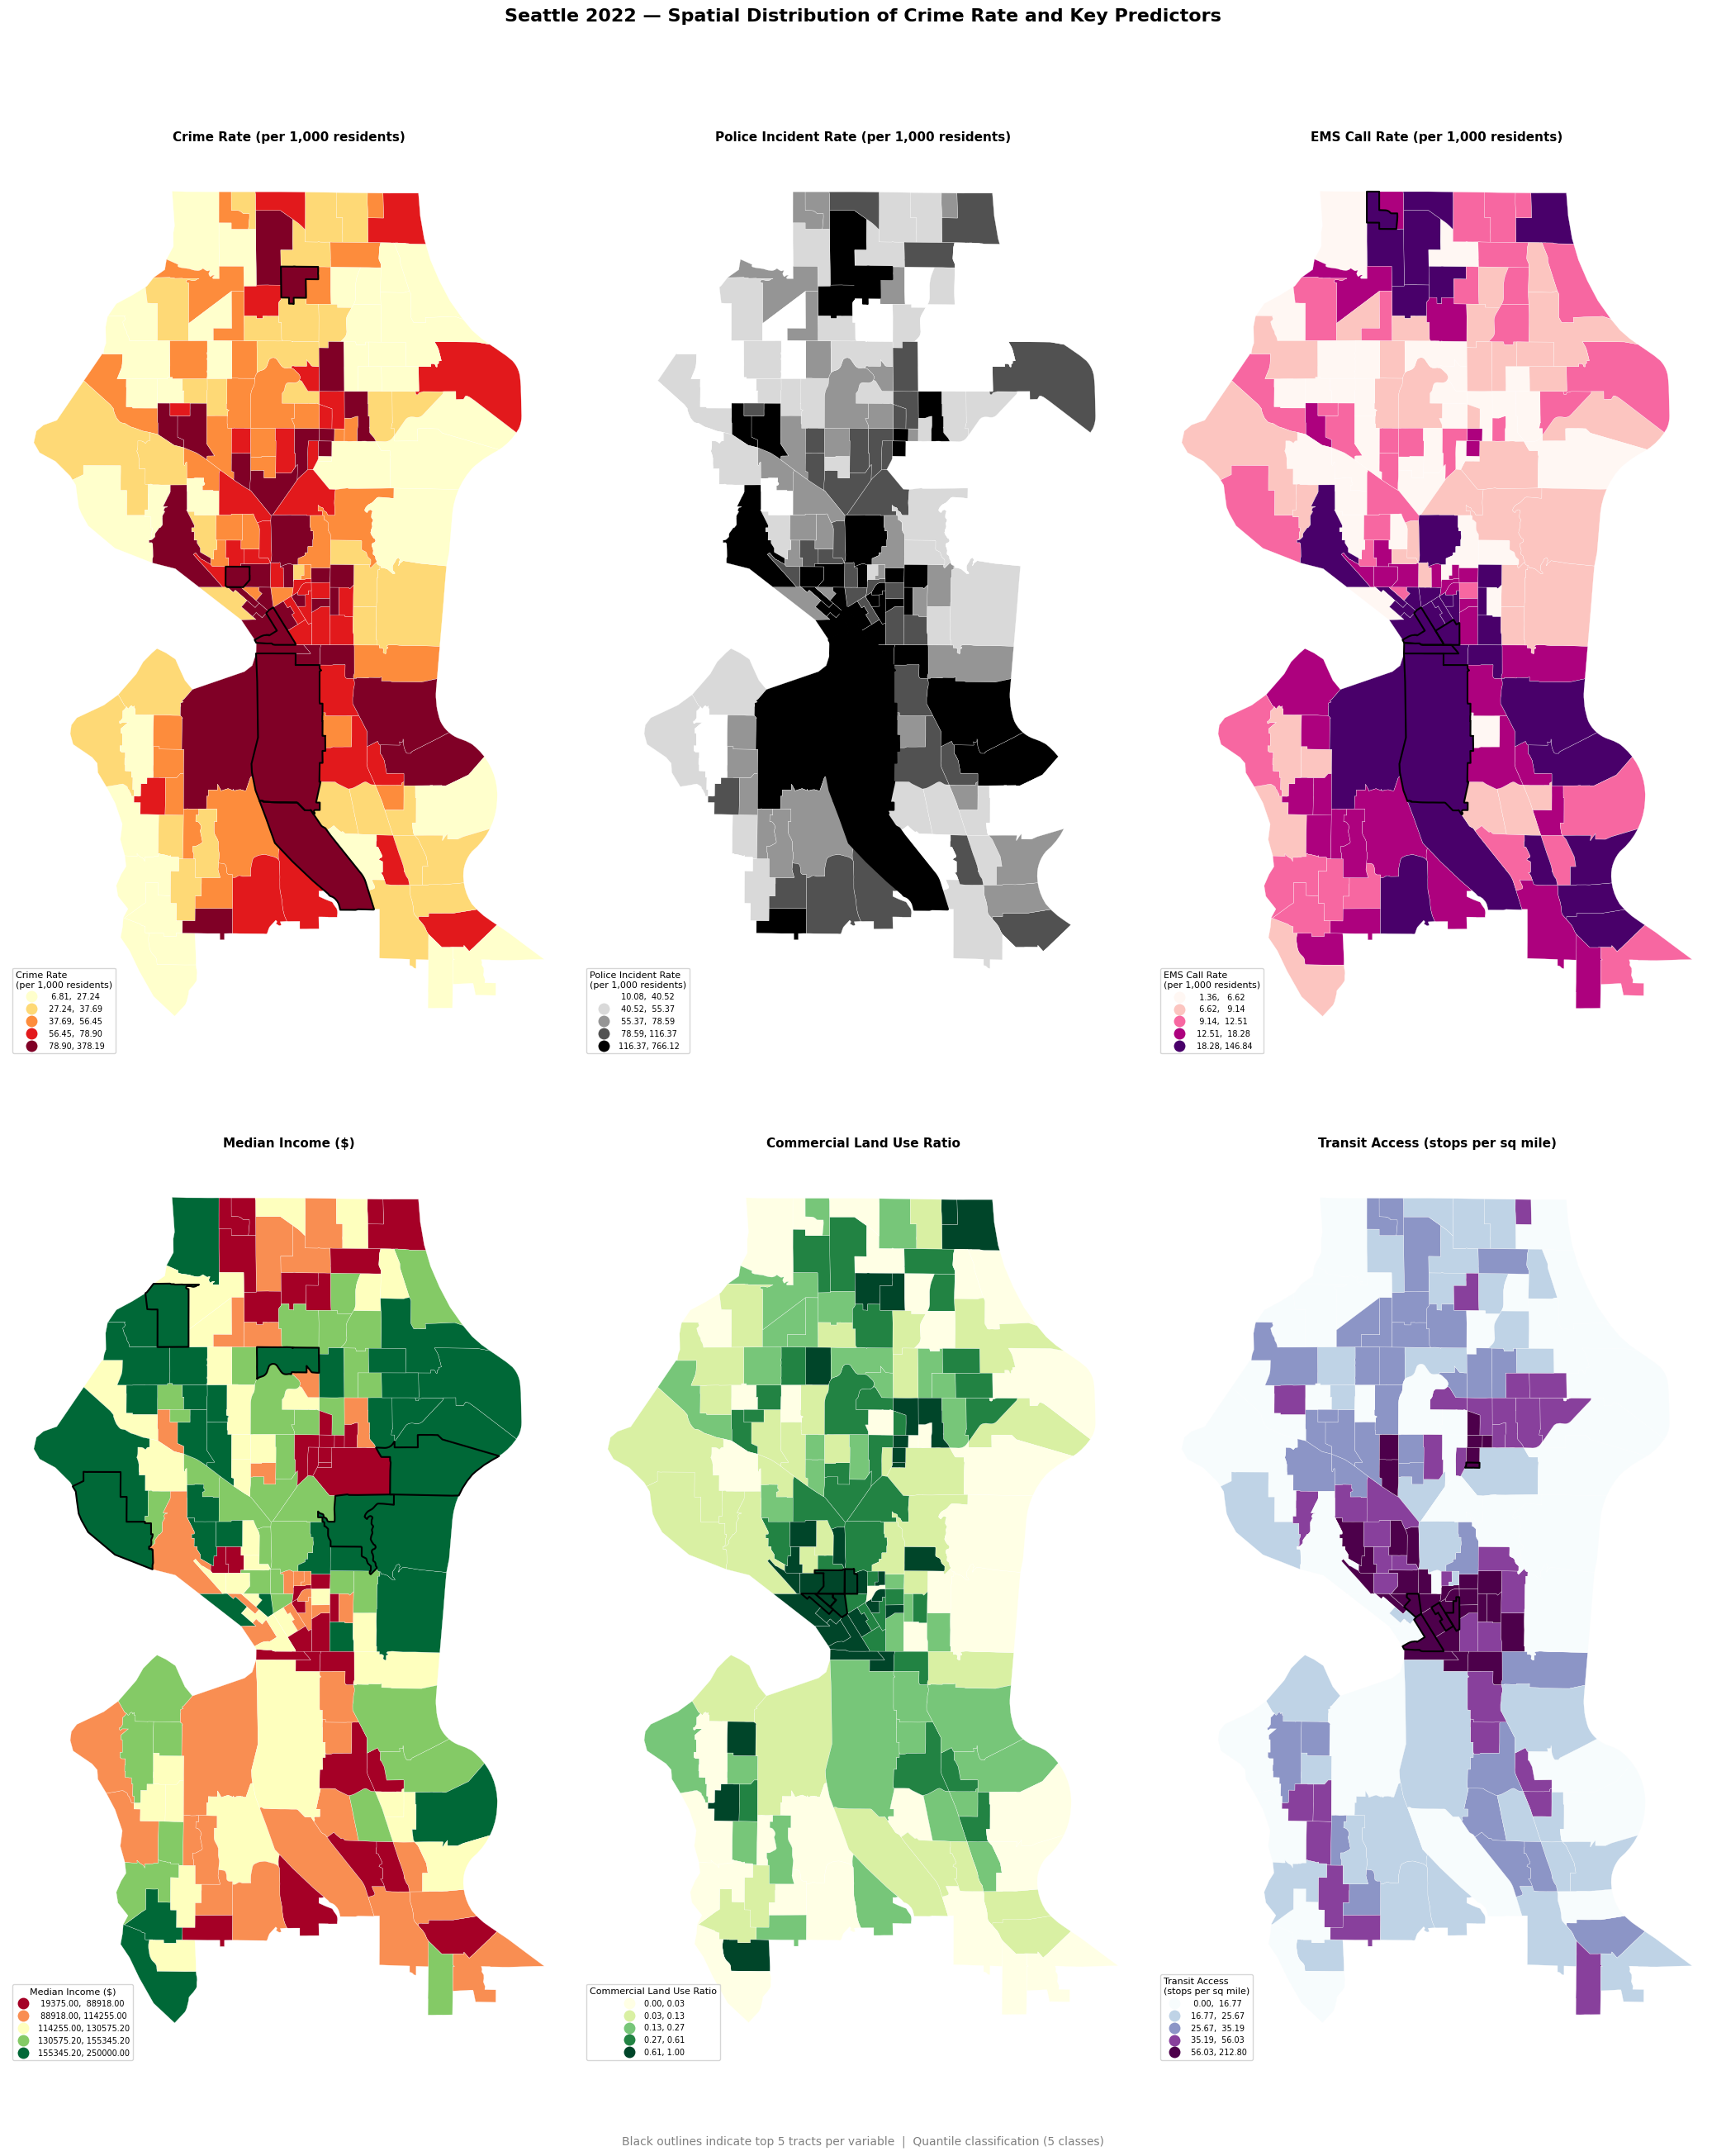

In [ ]:
# 4.4.7 Side-by-Side Comparison — Small Multiples with Shared Style
# ---------------------------------------------------------------
# 2x3 grid of maps — each uses a different classification scheme
# suited to its distribution. Crime rate is top-left as the
# reference map that the reader compares all others against.
# ---------------------------------------------------------------
plot_config = [
    ('crime_rate',               'YlOrRd',  'quantiles',
     'Crime Rate\n(per 1,000 residents)'),
    ('police_incident_rate',     'Greys',   'quantiles',
     'Police Incident Rate\n(per 1,000 residents)'),
    ('EMS_call_rate',            'RdPu',    'quantiles',
     'EMS Call Rate\n(per 1,000 residents)'),
    ('median_income',            'RdYlGn',  'quantiles',
     'Median Income ($)'),
    ('commercial_land_use_ratio','YlGn',    'quantiles',
     'Commercial Land Use Ratio'),
    ('transit_access',           'BuPu',    'quantiles',
     'Transit Access\n(stops per sq mile)'),
]

fig, axes = plt.subplots(2, 3, figsize=(21, 26))

for ax, (col, cmap, scheme, label) in zip(axes.flatten(), plot_config):
    gdf_master.plot(
        column=col,
        cmap=cmap,
        scheme=scheme,
        k=5,
        legend=True,
        legend_kwds={
            'title': label,
            'loc': 'lower left',
            'fontsize': 7,
            'title_fontsize': 8
        },
        edgecolor='white',
        linewidth=0.2,
        ax=ax
    )
    # Highlight top 5 tracts per variable
    top5 = gdf_master.nlargest(5, col)
    top5.plot(ax=ax, facecolor='none',
              edgecolor='black', linewidth=1.5, zorder=5)

    ax.set_title(label.replace('\n', ' '),
                 fontsize=11, fontweight='bold', pad=8)
    ax.set_axis_off()

# Add a shared note
fig.text(0.5, 0.01,
         'Black outlines indicate top 5 tracts per variable  |  '
         'Quantile classification (5 classes)',
         ha='center', fontsize=10, color='gray')

plt.suptitle('Seattle 2022 — Spatial Distribution of Crime Rate '
             'and Key Predictors',
             fontsize=16, fontweight='bold', y=1.005)
plt.tight_layout()
plt.show()

Comparing the six maps simultaneously reveals three distinct spatial
signatures. Crime rate, police rate, and EMS rate share an almost
identical spatial footprint — dark in Downtown/South Seattle, light in
the residential periphery — visually confirming their r=0.98 and r=0.74
correlations. Median income shows the inverse pattern — dark green
(high income) in the north and east where crime is low. Commercial ratio
and transit access share a third pattern — concentrated in the urban
core along the north-south spine — consistent with their moderate positive
correlations with crime (r=0.32, r=0.29). The three spatial clusters
visible across these maps foreshadow the predictor groupings that will
emerge in the regression analysis in Phase 5.

## 4.5 Spatial Autocorrelation Analysis
### 4.5.1 Compute Spatial Weights Matrix — Queen Contiguity

Spatial Weights Matrix Summary
Number of spatial units:     177
Average number of neighbors: 5.73
Min neighbors:               2
Max neighbors:               11
Islands (no neighbors):      0
Pct non-zero weights:        3.24%


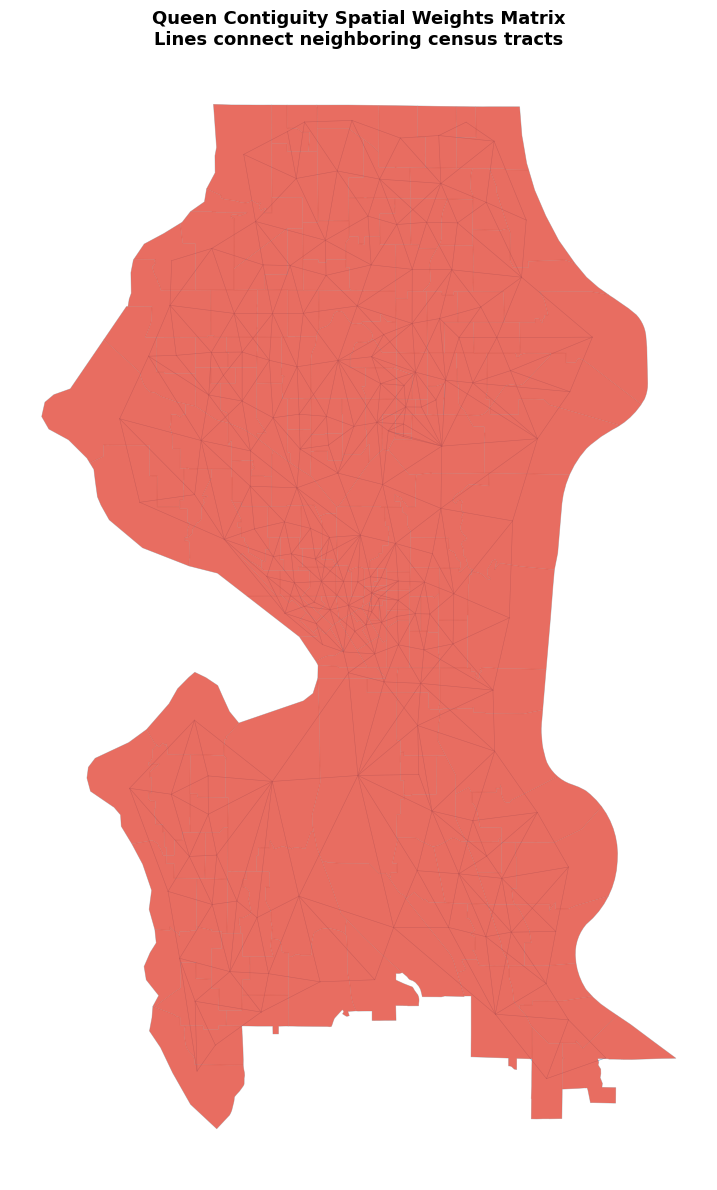

In [ ]:
# Queen contiguity defines neighbors as tracts sharing either
# an edge or a corner — standard for census tract analysis.
# Row-standardize so each row sums to 1 — ensures comparability
# across tracts with different numbers of neighbors.
from libpysal.weights import Queen

w = Queen.from_dataframe(gdf_master)
w.transform = 'r'

print(f'Spatial Weights Matrix Summary')
print('='*40)
print(f'Number of spatial units:     {w.n}')
print(f'Average number of neighbors: {w.mean_neighbors:.2f}')
print(f'Min neighbors:               {w.min_neighbors}')
print(f'Max neighbors:               {w.max_neighbors}')
print(f'Islands (no neighbors):      {len(w.islands)}')
print(f'Pct non-zero weights:        '
      f'{w.pct_nonzero:.2f}%')

# Visualize neighbor connectivity
fig, ax = plt.subplots(figsize=(10, 12))
gdf_master.plot(ax=ax, color='#F0F3F4', edgecolor='#BDC3C7',
                linewidth=0.5)

# Draw neighbor connections
centroids = gdf_master.copy()
centroids['cx'] = centroids.geometry.centroid.x
centroids['cy'] = centroids.geometry.centroid.y

for i, neighbors in w.neighbors.items():
    x0 = centroids.iloc[i]['cx']
    y0 = centroids.iloc[i]['cy']
    for j in neighbors:
        x1 = centroids.iloc[j]['cx']
        y1 = centroids.iloc[j]['cy']
        ax.plot([x0, x1], [y0, y1],
                color='#2980B9', linewidth=0.4, alpha=0.4)

centroids.plot(ax=ax, color='#E74C3C', markersize=8,
               zorder=5, alpha=0.8)

ax.set_title('Queen Contiguity Spatial Weights Matrix\n'
             'Lines connect neighboring census tracts',
             fontsize=13, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

The Queen contiguity weights matrix was successfully constructed for all
177 Seattle census tracts with zero islands — confirming every tract shares
at least one boundary with a neighbor. The average tract has 5.73 neighbors
ranging from 2 (corner or peninsula tracts) to 11 (small central tracts
surrounded by many neighbors). The 3.24% non-zero weight density is
expected for a contiguous urban boundary — most tract pairs are non-adjacent.
The connectivity map confirms a well-connected spatial network with denser
triangulation in the urban core where tracts are smaller. The weights matrix
is row-standardized and ready for Moran's I computation.

### 4.5.2 Global Moran's I — Crime Rate
> Tests whether crime is spatially clustered or randomly distributed across tracts.

Global Moran's I — Crime Rate
Moran's I statistic: 0.2164
Expected I (random): -0.0057
p-value (sim):       0.0010
z-score:             5.1211
Simulations:         999

Interpretation:
✅ Significant POSITIVE spatial autocorrelation
   High-crime tracts cluster near other high-crime
   tracts — crime is NOT randomly distributed


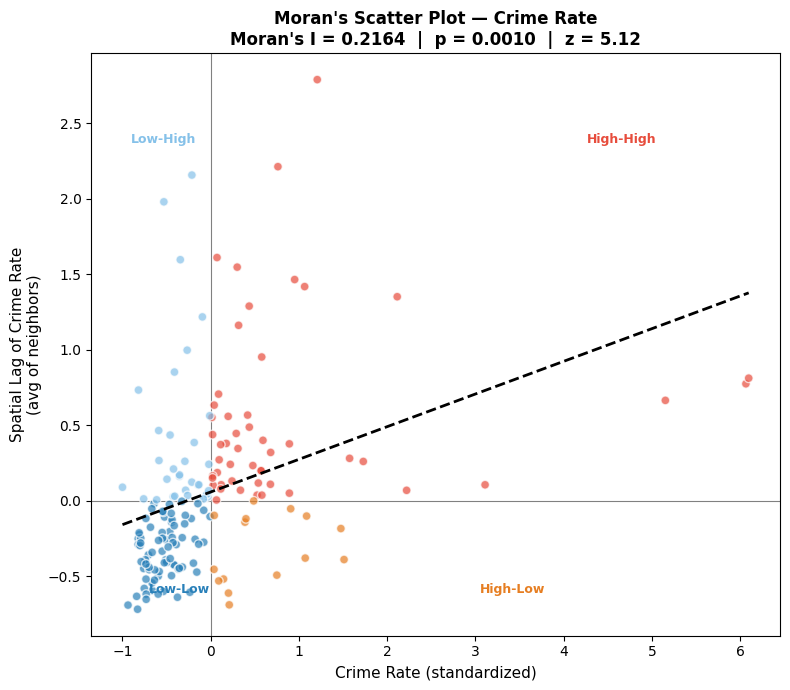

In [ ]:
# Tests whether crime is spatially clustered or randomly
# distributed across tracts.
# H0: Crime rate is randomly distributed (Moran's I ≈ 0)
# H1: Crime rate is spatially clustered (Moran's I > 0)
from esda.moran import Moran

moran = Moran(gdf_master['crime_rate'], w)

print(f'Global Moran\'s I — Crime Rate')
print('='*45)
print(f'Moran\'s I statistic: {moran.I:.4f}')
print(f'Expected I (random): {moran.EI:.4f}')
print(f'p-value (sim):       {moran.p_sim:.4f}')
print(f'z-score:             {moran.z_sim:.4f}')
print(f'Simulations:         {moran.permutations}')
print(f'\nInterpretation:')
if moran.p_sim < 0.05:
    if moran.I > 0:
        print('✅ Significant POSITIVE spatial autocorrelation')
        print('   High-crime tracts cluster near other high-crime')
        print('   tracts — crime is NOT randomly distributed')
    else:
        print('✅ Significant NEGATIVE spatial autocorrelation')
else:
    print('❌ No significant spatial autocorrelation detected')

# Moran scatter plot
fig, ax = plt.subplots(figsize=(8, 7))

# Standardize crime rate
crime_std = (gdf_master['crime_rate'] -
             gdf_master['crime_rate'].mean()) / gdf_master['crime_rate'].std()

# Spatial lag
from libpysal.weights import lag_spatial
crime_lag = lag_spatial(w, crime_std)

# Quadrant colors
colors = []
for x, y in zip(crime_std, crime_lag):
    if x >= 0 and y >= 0:
        colors.append('#E74C3C')   # High-High
    elif x < 0 and y < 0:
        colors.append('#2980B9')   # Low-Low
    elif x >= 0 and y < 0:
        colors.append('#E67E22')   # High-Low
    else:
        colors.append('#85C1E9')   # Low-High

ax.scatter(crime_std, crime_lag, c=colors,
           alpha=0.7, edgecolor='white', s=40, zorder=3)

# Regression line
z = np.polyfit(crime_std, crime_lag, 1)
p = np.poly1d(z)
x_line = np.linspace(crime_std.min(), crime_std.max(), 100)
ax.plot(x_line, p(x_line), color='black',
        linewidth=2, linestyle='--', zorder=4)

# Reference lines
ax.axhline(0, color='gray', linewidth=0.8, linestyle='-')
ax.axvline(0, color='gray', linewidth=0.8, linestyle='-')

# Quadrant labels
ax.text(crime_std.max() * 0.7, crime_lag.max() * 0.85,
        'High-High', color='#E74C3C', fontsize=9, fontweight='bold')
ax.text(crime_std.min() * 0.7, crime_lag.min() * 0.85,
        'Low-Low', color='#2980B9', fontsize=9, fontweight='bold')
ax.text(crime_std.max() * 0.5, crime_lag.min() * 0.85,
        'High-Low', color='#E67E22', fontsize=9, fontweight='bold')
ax.text(crime_std.min() * 0.9, crime_lag.max() * 0.85,
        'Low-High', color='#85C1E9', fontsize=9, fontweight='bold')

ax.set_xlabel("Crime Rate (standardized)", fontsize=11)
ax.set_ylabel("Spatial Lag of Crime Rate\n(avg of neighbors)", fontsize=11)
ax.set_title(f"Moran's Scatter Plot — Crime Rate\n"
             f"Moran's I = {moran.I:.4f}  |  "
             f"p = {moran.p_sim:.4f}  |  "
             f"z = {moran.z_sim:.2f}",
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Global Moran's I = 0.2164 (p = 0.001, z = 5.19) confirms statistically
significant positive spatial autocorrelation in Seattle's crime rate —
crime is not randomly distributed across tracts but clusters spatially.
The result is based on 999 permutations and the z-score of 5.19 places
the observed I far into the tail of the simulated distribution, making
random chance an implausible explanation.

The Moran scatter plot reveals the structure behind this statistic. The
dominant quadrant is Low-Low (blue, lower-left) — the large cluster of
residential tracts in North and West Seattle with below-average crime
surrounded by similarly low-crime neighbors. The High-High quadrant
(red, upper-right) contains a smaller but clearly defined cluster of
Downtown and South Seattle tracts with above-average crime surrounded
by high-crime neighbors — these are the spatial hotspots. The High-Low
quadrant (orange, lower-right) identifies spatial outliers — individual
high-crime tracts embedded within lower-crime surroundings — while
Low-High (light blue, upper-left) captures low-crime tracts adjacent to
high-crime neighbors, likely transition zone tracts at the edge of the
Downtown hotspot. The positive slope of the regression line through the
scatter confirms the overall clustering tendency despite the wide spread
of points around it.

### 4.5.3 Local Moran's I (LISA) — Identify Crime Hotspots and Coldspots

LISA Cluster Summary (p < 0.05):
Not Significant    141
Low-Low             14
High-High           13
High-Low             5
Low-High             4
Name: count, dtype: int64

Total significant tracts: 36 of 177 (20.3%)


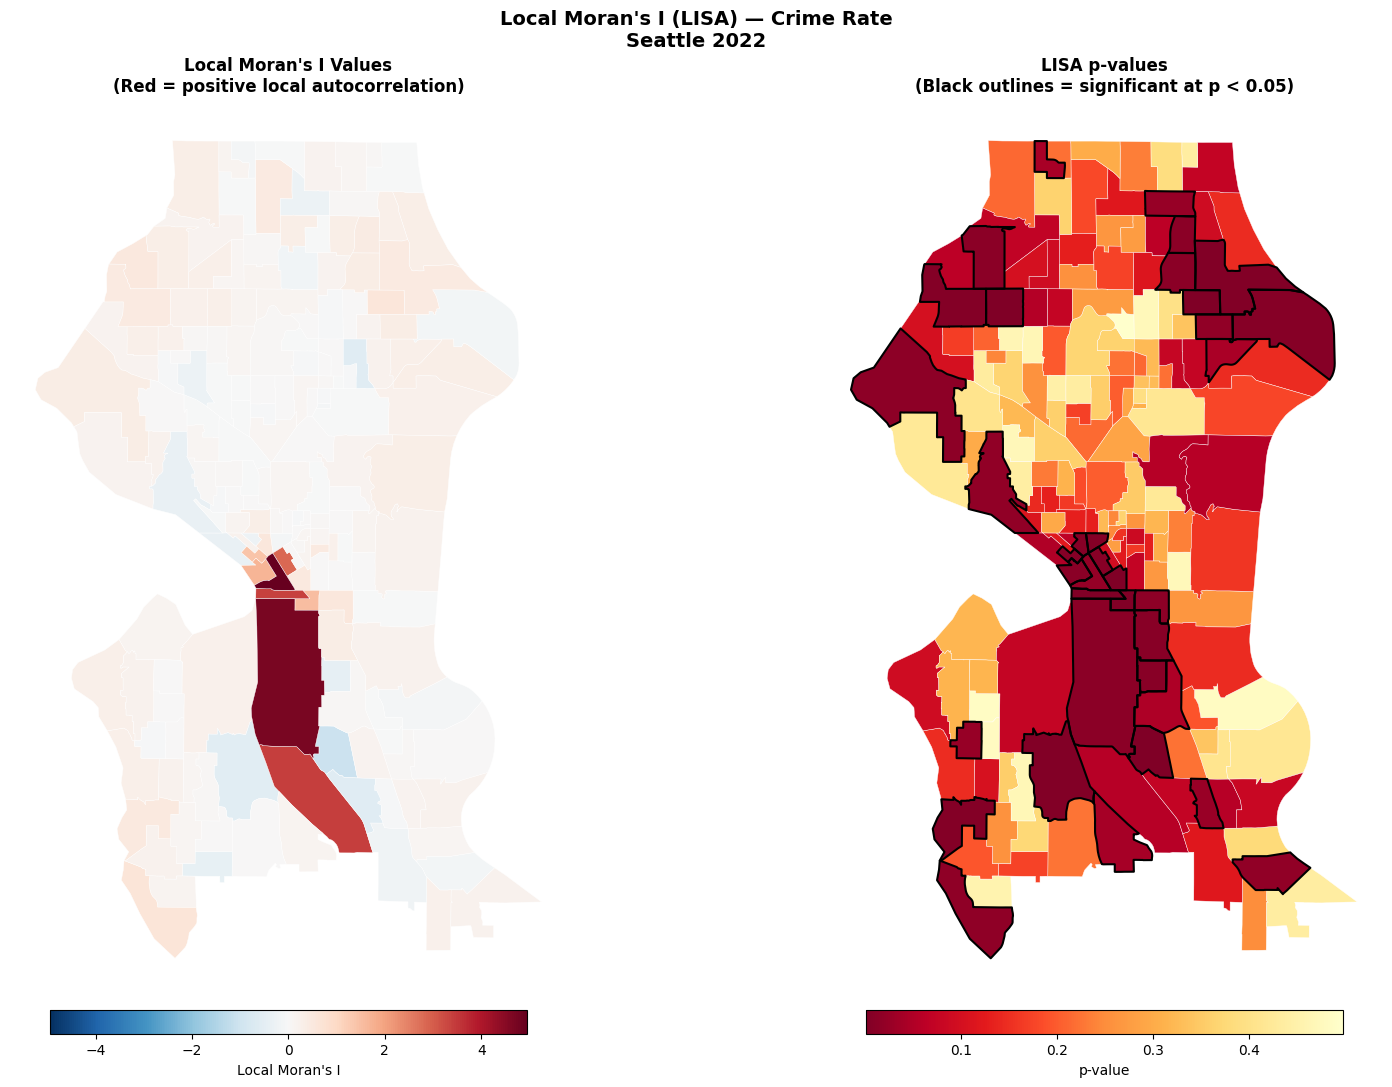

In [ ]:
# LISA decomposes the global Moran's I into tract-level statistics
# identifying where significant spatial clustering occurs locally.
# Uses 999 permutations for significance testing at p < 0.05.
from esda.moran import Moran_Local

lisa = Moran_Local(gdf_master['crime_rate'], w,
                   permutations=999, seed=42)

# Significance threshold
sig = lisa.p_sim < 0.05

# Assign cluster labels
labels = np.array(['Not Significant'] * len(gdf_master))
labels[sig & (lisa.q == 1)] = 'High-High'   # hotspot
labels[sig & (lisa.q == 2)] = 'Low-High'    # spatial outlier
labels[sig & (lisa.q == 3)] = 'Low-Low'     # coldspot
labels[sig & (lisa.q == 4)] = 'High-Low'    # spatial outlier

gdf_master['LISA_cluster'] = labels
gdf_master['LISA_p'] = lisa.p_sim
gdf_master['LISA_I'] = lisa.Is

print(f'LISA Cluster Summary (p < 0.05):')
print('='*40)
cluster_counts = pd.Series(labels).value_counts()
print(cluster_counts)
print(f'\nTotal significant tracts: '
      f'{sig.sum()} of {len(gdf_master)} '
      f'({sig.sum()/len(gdf_master)*100:.1f}%)')

# Significance map — show local Moran's I values
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Left — Local Moran's I values
gdf_master.plot(
    column='LISA_I',
    cmap='RdBu_r',
    legend=True,
    legend_kwds={
        'label': "Local Moran's I",
        'shrink': 0.5,
        'orientation': 'horizontal',
        'pad': 0.01
    },
    edgecolor='white',
    linewidth=0.3,
    ax=axes[0],
    vmin=-gdf_master['LISA_I'].abs().max(),
    vmax=gdf_master['LISA_I'].abs().max()
)
axes[0].set_title("Local Moran's I Values\n"
                  "(Red = positive local autocorrelation)",
                  fontsize=12, fontweight='bold')
axes[0].set_axis_off()

# Right — p-value significance map
gdf_master.plot(
    column='LISA_p',
    cmap='YlOrRd_r',
    legend=True,
    legend_kwds={
        'label': 'p-value',
        'shrink': 0.5,
        'orientation': 'horizontal',
        'pad': 0.01
    },
    edgecolor='white',
    linewidth=0.3,
    ax=axes[1]
)

# Outline significant tracts
gdf_master[sig].plot(
    ax=axes[1], facecolor='none',
    edgecolor='black', linewidth=1.5, zorder=5
)
axes[1].set_title("LISA p-values\n"
                  "(Black outlines = significant at p < 0.05)",
                  fontsize=12, fontweight='bold')
axes[1].set_axis_off()

plt.suptitle("Local Moran's I (LISA) — Crime Rate\nSeattle 2022",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The LISA analysis identifies 36 statistically significant tracts (20.3%
of all 177) at p < 0.05 after 999 permutations. The local Moran's I map
confirms the spatial structure — the Downtown/SoDo corridor shows extreme
positive local autocorrelation (deep red, I values up to 4+) while North
Seattle shows weak negative local autocorrelation (light blue) indicating
mild spatial dissimilarity at the periphery. The p-value map with black
outlines reveals that the most statistically significant tracts are
concentrated in two zones — the Downtown/South Seattle hotspot cluster
and the far North Seattle coldspot cluster — while the majority of central
residential tracts fall above the significance threshold (yellow/light
orange, p > 0.3).

The 36 significant tracts break down into 13 High-High hotspot tracts,
14 Low-Low coldspot tracts, 5 High-Low spatial outliers and 4 Low-High
spatial outliers — with the remaining 141 tracts showing no statistically
significant local clustering pattern. The dominance of Low-Low tracts
(14) over High-High (13) reflects Seattle's spatial structure where the
large contiguous low-crime residential periphery generates more coldspot
tracts than the more spatially concentrated Downtown hotspot.

### 4.5.4 LISA Cluster Map — High-High, Low-Low, High-Low, Low-High

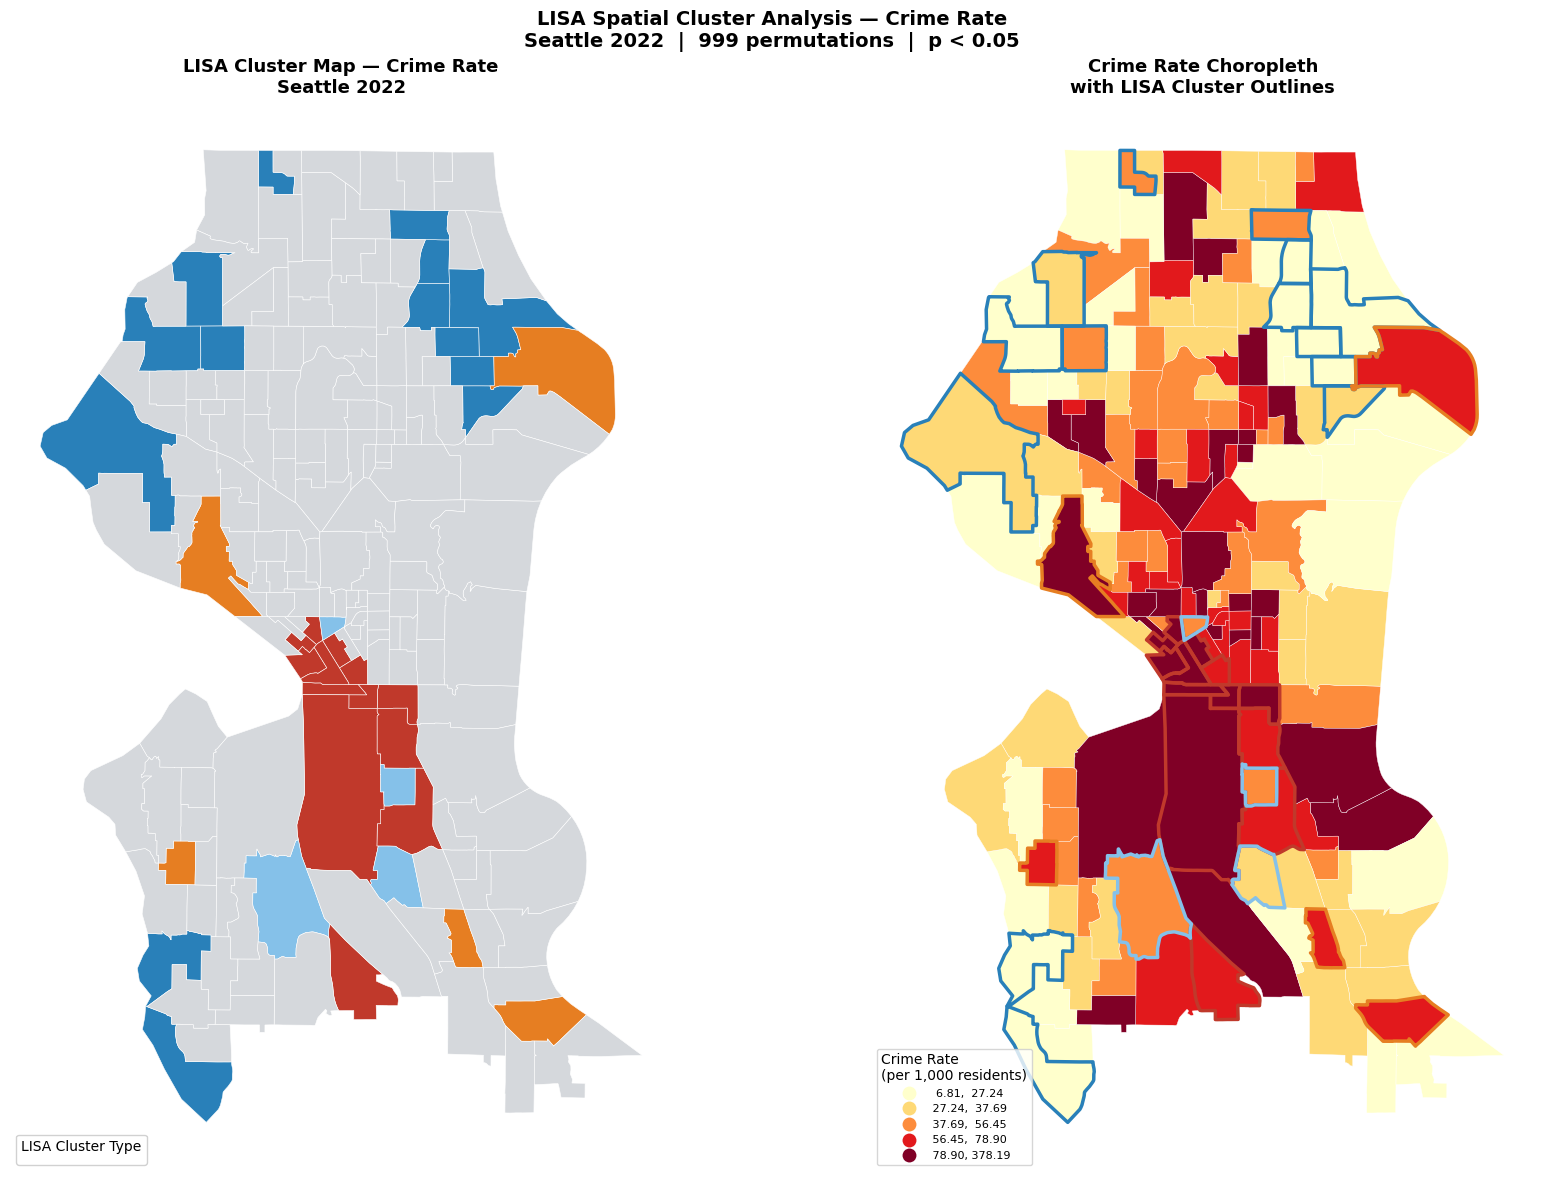


LISA Cluster Summary:
High-High             13 tracts  (7.3%)
Low-Low               14 tracts  (7.9%)
High-Low               5 tracts  (2.8%)
Low-High               4 tracts  (2.3%)
Not Significant      141 tracts  (79.7%)


In [ ]:
# Four cluster types:
# High-High (red)   — crime hotspot surrounded by high-crime tracts
# Low-Low (blue)    — crime coldspot surrounded by low-crime tracts
# High-Low (orange) — high-crime tract surrounded by low-crime neighbors
# Low-High (lblue)  — low-crime tract surrounded by high-crime neighbors
# Gray              — not statistically significant

cluster_colors = {
    'High-High':       '#C0392B',
    'Low-Low':         '#2980B9',
    'High-Low':        '#E67E22',
    'Low-High':        '#85C1E9',
    'Not Significant': '#D5D8DC'
}

cluster_labels_ordered = [
    'High-High', 'Low-Low', 'High-Low',
    'Low-High', 'Not Significant'
]

gdf_master['LISA_color'] = gdf_master['LISA_cluster'].map(cluster_colors)

fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Left — LISA cluster map
for cluster_type in cluster_labels_ordered:
    subset = gdf_master[gdf_master['LISA_cluster'] == cluster_type]
    if len(subset) > 0:
        count = len(subset)
        subset.plot(
            ax=axes[0],
            color=cluster_colors[cluster_type],
            edgecolor='white',
            linewidth=0.4,
            label=f'{cluster_type} (n={count})'
        )

axes[0].legend(
    title='LISA Cluster Type',
    loc='lower left',
    fontsize=9,
    title_fontsize=10,
    framealpha=0.9
)
axes[0].set_title("LISA Cluster Map — Crime Rate\nSeattle 2022",
                  fontsize=13, fontweight='bold')
axes[0].set_axis_off()

# Right — Crime rate choropleth with LISA outlines overlaid
gdf_master.plot(
    column='crime_rate',
    cmap='YlOrRd',
    scheme='quantiles',
    k=5,
    legend=True,
    legend_kwds={
        'title': 'Crime Rate\n(per 1,000 residents)',
        'loc': 'lower left',
        'fontsize': 8
    },
    edgecolor='white',
    linewidth=0.3,
    ax=axes[1]
)

# Overlay LISA cluster outlines
for cluster_type, color in cluster_colors.items():
    if cluster_type == 'Not Significant':
        continue
    subset = gdf_master[gdf_master['LISA_cluster'] == cluster_type]
    if len(subset) > 0:
        subset.plot(ax=axes[1], facecolor='none',
                    edgecolor=color, linewidth=2.5, zorder=5)

axes[1].set_title("Crime Rate Choropleth\nwith LISA Cluster Outlines",
                  fontsize=13, fontweight='bold')
axes[1].set_axis_off()

plt.suptitle("LISA Spatial Cluster Analysis — Crime Rate\n"
             "Seattle 2022  |  999 permutations  |  p < 0.05",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print(f'\nLISA Cluster Summary:')
print('='*50)
for cluster in cluster_labels_ordered:
    n = (gdf_master['LISA_cluster'] == cluster).sum()
    pct = n / len(gdf_master) * 100
    print(f'{cluster:<20} {n:>3} tracts  ({pct:.1f}%)')

The LISA cluster map confirms two distinct and spatially coherent crime
zones in Seattle, with 79.7% of tracts showing no significant local
clustering pattern.

HIGH-HIGH hotspot (13 tracts, 7.3%) — a contiguous cluster of dark red
tracts forming a tight corridor through Downtown, Capitol Hill, and SoDo.
The right-hand choropleth confirms these tracts correspond to the darkest
quantile (78–378 crimes per 1,000) and their black outlines show they
are spatially concentrated rather than scattered — a true crime hotspot
zone where high-crime tracts reinforce each other.

LOW-LOW coldspot (14 tracts, 7.9%) — the largest significant cluster,
spread across North and West Seattle in a fragmented arc of blue tracts.
The choropleth confirms these are all in the lightest quantile (6.81–27
per 1,000) — a stable low-crime zone where residential neighborhood
character is spatially self-reinforcing.

HIGH-LOW spatial outliers (5 tracts, 2.8%) — the orange tracts are the
most analytically interesting. They appear as isolated islands of high
crime surrounded by lower-crime neighbors — visible on the right map as
dark-fill tracts with orange outlines sitting within otherwise moderate
surroundings. These likely represent individual commercial corridors or
transit nodes that generate crime independently of their immediate
neighborhood context.

LOW-HIGH spatial outliers (4 tracts, 2.3%) — light blue tracts that are
low-crime but surrounded by higher-crime neighbors. These appear at the
edges of the Downtown hotspot — likely parks, institutional, or
low-population tracts buffered within the high-crime zone.

The combined LISA findings have a direct implication for Phase 5
modeling — the presence of significant spatial autocorrelation
(Global Moran's I = 0.216, p = 0.001) means OLS regression residuals
are likely to be spatially correlated, violating the independence
assumption. A spatial lag or spatial error regression model should be
evaluated alongside OLS in Phase 5.

---
# PHASE 5: FEATURE ENGINEERING & PREPROCESSING FOR MODELING
---

## 5.1 Variable Transformations
### 5.1.1 Log Transform Skewed Variables — Crime Rate, Population Density, EMS Rate, etc.

In [ ]:
# Your code here

### 5.1.2 Verify Normality After Transformation — Histogram and Q-Q Plot

In [ ]:
# Your code here

## 5.2 Multicollinearity Check
### 5.2.1 Variance Inflation Factor (VIF) for All Predictors

In [ ]:
# Your code here

### 5.2.2 Drop or Combine Variables with VIF > 10

In [ ]:
# Your code here

## 5.3 Feature Scaling
### 5.3.1 Define Final Feature Matrix (X) and Target Variable (y)

In [ ]:
# Your code here

### 5.3.2 Standardize All Predictor Variables — Z-Score Normalization

In [ ]:
# Your code here

### 5.3.3 Verify Scaled Variable Distributions

In [ ]:
# Your code here

## 5.4 Train-Test Split
### 5.4.1 Split into Training and Test Sets — 80/20

In [ ]:
# Your code here

### 5.4.2 Verify Split Sizes

In [ ]:
# Your code here

---
# PHASE 6: PREDICTIVE MODELING
---

## 6.1 Model 1 — Ordinary Least Squares (OLS) Linear Regression
### 6.1.1 Fit OLS Model on Training Data

In [ ]:
# Your code here

### 6.1.2 Model Summary — Coefficients, p-values, R²

In [ ]:
# Your code here

### 6.1.3 Interpret Significant Predictors

In [ ]:
# Your code here

### 6.1.4 Residual Analysis — Residuals vs Fitted Values Plot

In [ ]:
# Your code here

### 6.1.5 Check Residual Normality — Q-Q Plot

In [ ]:
# Your code here

### 6.1.6 Evaluate on Test Set — RMSE, MAE, R²

In [ ]:
# Your code here

## 6.2 Model 2 — Poisson Regression (GLM)
> Poisson regression is appropriate for count-based crime rates and handles non-negative outcomes better than OLS.

### 6.2.1 Fit Poisson GLM on Training Data

In [ ]:
# Your code here

### 6.2.2 Model Summary — Coefficients and Significance

In [ ]:
# Your code here

### 6.2.3 Check for Overdispersion

In [ ]:
# Your code here

### 6.2.4 Evaluate on Test Set — RMSE, MAE, Pseudo R²

In [ ]:
# Your code here

## 6.3 Model 3 — Negative Binomial GLM
> Used if overdispersion is detected in the Poisson model.

### 6.3.1 Fit Negative Binomial GLM

In [ ]:
# Your code here

### 6.3.2 Model Summary and Comparison with Poisson

In [ ]:
# Your code here

### 6.3.3 Evaluate on Test Set — RMSE, MAE, Pseudo R²

In [ ]:
# Your code here

## 6.4 Model 4 — Ridge Regression (Regularized)
### 6.4.1 Fit Ridge Regression with Cross-Validated Alpha

In [ ]:
# Your code here

### 6.4.2 Plot Coefficient Paths

In [ ]:
# Your code here

### 6.4.3 Evaluate on Test Set — RMSE, MAE, R²

In [ ]:
# Your code here

## 6.5 Model 5 — Lasso Regression (Feature Selection)
### 6.5.1 Fit Lasso Regression with Cross-Validated Alpha

In [ ]:
# Your code here

### 6.5.2 Identify Variables Shrunk to Zero — Automatic Feature Selection

In [ ]:
# Your code here

### 6.5.3 Evaluate on Test Set — RMSE, MAE, R²

In [ ]:
# Your code here

## 6.6 Cross-Validation
### 6.6.1 K-Fold Cross-Validation (k=5) Across All Models

In [ ]:
# Your code here

### 6.6.2 Compare Mean CV RMSE and R² Across Models

In [ ]:
# Your code here

## 6.7 Model Comparison & Selection
### 6.7.1 Summary Table — All Models vs All Metrics (RMSE, MAE, R², CV Score)

In [ ]:
# Your code here

### 6.7.2 Select Best Performing Model

In [ ]:
# Your code here

### 6.7.3 Justification for Model Selection

In [ ]:
# Your code here

---
# PHASE 7: SPATIAL MODELING
---

## 7.1 Spatial Clustering — Crime Hotspot Detection (DBSCAN)
### 7.1.1 DBSCAN Clustering on Crime Incident Coordinates

In [ ]:
# Your code here

### 7.1.2 Visualize Crime Clusters on Seattle Map

In [ ]:
# Your code here

### 7.1.3 Characterize Each Cluster — Dominant Offense Types and Density

In [ ]:
# Your code here

## 7.2 Geographically Weighted Regression (GWR)
> GWR allows regression coefficients to vary spatially — it reveals which predictors matter more in which parts of Seattle.

### 7.2.1 Bandwidth Selection

In [ ]:
# Your code here

### 7.2.2 Fit GWR Model

In [ ]:
# Your code here

### 7.2.3 Map Spatially Varying Coefficients per Predictor

In [ ]:
# Your code here

### 7.2.4 Compare GWR Local R² to Global OLS R²

In [ ]:
# Your code here

---
# PHASE 8: RESULTS & INTERPRETATION
---

## 8.1 Best Model — Final Predictions
### 8.1.1 Generate Predictions on Full Seattle Dataset

In [ ]:
# Your code here

### 8.1.2 Map Predicted Crime Rate vs Actual Crime Rate — Side-by-Side Choropleth

In [ ]:
# Your code here

### 8.1.3 Residual Map — Where Does the Model Over/Under Predict?

In [ ]:
# Your code here

## 8.2 Feature Importance & Predictor Interpretation
### 8.2.1 Coefficient Plot — Direction and Magnitude of Each Predictor

In [ ]:
# Your code here

### 8.2.2 Rank Predictors by Absolute Standardized Coefficient

In [ ]:
# Your code here

### 8.2.3 Interpret Each Significant Predictor in Context of Seattle

In [ ]:
# Your code here

## 8.3 EMS Call Rate — Novel Predictor Validation
### 8.3.1 Correlation of EMS Call Rate with Crime Rate

In [ ]:
# Your code here

### 8.3.2 Partial Regression Plot — EMS Call Rate Controlling for All Other Variables

In [ ]:
# Your code here

### 8.3.3 Conclusion — Is EMS Call Rate a Valid Proxy for Neighborhood Distress?

In [ ]:
# Your code here

---
# PHASE 9: CONCLUSIONS & DISCUSSION
---

## 9.1 Summary of Findings
### 9.1.1 Key Predictors of Crime Rate in Seattle (2022)

In [ ]:
# Your code here

### 9.1.2 Spatial Patterns — Which Neighborhoods Are Highest Risk and Why?

In [ ]:
# Your code here

### 9.1.3 Model Performance Summary

In [ ]:
# Your code here

## 9.2 Limitations

> - **Redacted Coordinates:** A portion of SPD incidents have suppressed location data and were excluded from spatial analysis.
> - **Temporal Snapshot:** Cross-sectional 2022 analysis only, no causality can be inferred.
> - **Ecological Fallacy:** Tract-level aggregation may not reflect individual-level patterns.
> - **Transit Data:** Current GTFS feed used instead of exact 2022 historical feed, stop locations may differ slightly.


## 9.3 Future Work

> -

---
# APPENDIX
---

## A. Data Dictionary
> Full description of every variable in the master dataset — source, unit, computation method, and value range.

In [ ]:
# Your code here

## B. Dataset Sources & Access URLs

| Dataset | Source | URL |
|---|---|---|
| Population (OFM) | Washington OFM | https://ofm.wa.gov |
| Median Income (ACS B19013) | U.S. Census Bureau | https://data.census.gov |
| Unemployment (ACS B23025) | U.S. Census Bureau | https://data.census.gov |
| Land Use / Zoning | Seattle GIS | https://data-seattlecitygis.opendata.arcgis.com |
| Transit Stops (GTFS) | King County Metro | https://kingcounty.gov/metro |
| EMS 911 Calls | Seattle Open Data | https://data.seattle.gov |
| SPD Crime Data | Seattle Open Data | https://data.seattle.gov |
| Seattle City Limits | Seattle Open Data | https://data.seattle.gov |
| Census Tracts (TIGER) | U.S. Census Bureau | https://www.census.gov/cgi-bin/geo/shapefiles |


## C. Shapefile CRS Reference

| Shapefile | Native CRS | Reprojected To |
|---|---|---|
| TIGER/Line Census Tracts | EPSG:4269 (NAD83) | EPSG:2926 |
| Seattle City Limits | EPSG:4326 (WGS84) | EPSG:2926 |
| DPD Zoning (DPD_ZONING_PV) | EPSG:2926 (WA State Plane) | EPSG:2926 (no change) |

> **EPSG:2926** — Washington State Plane North (feet) is used as the common CRS throughout this project for accurate area calculations within Seattle.

## D. Supplementary Plots and Tables

In [ ]:
# Your code here

## E. References

1. City of Seattle. *911 Medic Response Calls.* https://data.seattle.gov
2. City of Seattle Police Department. *Crime Incident Dataset.* https://data.seattle.gov
3. U.S. Census Bureau. *American Community Survey (ACS).* https://www.census.gov/programs-surveys/acs
4. City of Seattle GIS. *Land Use/Zoning Data.* https://data.seattle.gov
5. Yu, D., & Fang, C. 'How Neighborhood Characteristics Influence Neighborhood Crimes: A Bayesian Hierarchical Spatial Analysis.' *International Journal of Environmental Research and Public Health*, 2022.
6. De Nadai, M., Xu, Y., Letouzé, E., & González, M. C. 'Socio-economic, built environment, and mobility conditions associated with crime: A study of multiple cities.' *ArXiv preprint*, 2020.
7. Shaw, C. R., & McKay, H. D. *Social Disorganization Theory.*